In [1]:
import sage
from sklearn.model_selection import train_test_split


# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [feature_names.index(col) for col in categorical_columns]

# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=0)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=0)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [2]:
import os

from catboost import CatBoostClassifier


model_filename = "../credit_model.cbm"

if os.path.isfile(model_filename):
    model = CatBoostClassifier()
    model.load_model(model_filename)
else:
    model = CatBoostClassifier(iterations=50, learning_rate=0.3, depth=3)
    model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val), verbose=False)
    model.save_model(model_filename)

In [3]:
import numpy as np
from sklearn.metrics import log_loss


# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.602
Model cross entropy = 0.457


In [4]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score = {:.3f}".format(roc_auc_score(Y_test, model.predict_proba(test)[:, 1])))

ROC AUC Score = 0.849


In [5]:
from sklearn.metrics import confusion_matrix

pred_test = model.predict_proba(test)
pred_test = np.argmax(pred_test, axis=1)

tn, fp, fn, tp = confusion_matrix(Y_test, pred_test, labels=[0,1]).ravel()
p = tp + fn
fnr = fn / p if p > 0.0 else np.float64(0.0)

print("False negative rate = {:.3f}".format(fnr))

False negative rate = 0.042


In [6]:
print("Classifier got {} positive examples wrong".format(int(round(Y_test.sum() * fnr))))

Classifier got 3 positive examples wrong


# Global FNR

In [7]:
# Setup and calculate with custom fairness-related loss function
imputer = sage.MarginalImputer(model, train[:512])
estimator_fnr = sage.PermutationEstimator(imputer, 'fnr')
%time sage_values_fnr = estimator_fnr(test, Y_test, verbose=True, thresh=0.1)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

fn = 0, p = 369, fnr = 0.0
===> Iteration 0, Prev loss = 0.0 [outer loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 369, fnr = 0.005420054200542005
	Loss = 0.005420054200542005 [inner loop]
fn = 2, p = 369, fnr = 0.005420054200542005
	Loss = 0.005420054200542005 [inner loop]
fn = 2, p = 369, fnr = 0.005420054200542005
	Loss = 0.005420054200542005 [inner loop]
fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [inner loop]
fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [inner loop]
fn = 4, p = 369, fnr = 0.01084010840108401
	Loss = 0.01084010840108401 [inner loop]
fn = 5, p = 369, fnr = 0.013550135501355014
	Loss = 0.013550135501355014 [inner loop]
fn = 6, p = 369, fnr = 0.016260162601626018
	Loss = 0.016260162601626018 [inner loop]
fn = 8, p = 369, fnr = 0.02168021680216802
	Loss = 0.02168021680216802 [inner loop]
fn = 9, p = 369, fnr = 0.024390243902439025
	Loss = 

fn = 12, p = 366, fnr = 0.03278688524590164
	Loss = 0.03278688524590164 [inner loop]
fn = 14, p = 366, fnr = 0.03825136612021858
	Loss = 0.03825136612021858 [inner loop]
fn = 13, p = 366, fnr = 0.03551912568306011
	Loss = 0.03551912568306011 [inner loop]
fn = 15, p = 366, fnr = 0.040983606557377046
	Loss = 0.040983606557377046 [inner loop]
fn = 16, p = 366, fnr = 0.04371584699453552
	Loss = 0.04371584699453552 [inner loop]
fn = 15, p = 366, fnr = 0.040983606557377046
	Loss = 0.040983606557377046 [inner loop]
StdDev Ratio = 0.2996 (Converge at 0.1000)
fn = 0, p = 361, fnr = 0.0
===> Iteration 5, Prev loss = 0.0 [outer loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 1, p =

fn = 9, p = 382, fnr = 0.02356020942408377
	Loss = 0.02356020942408377 [inner loop]
fn = 10, p = 382, fnr = 0.02617801047120419
	Loss = 0.02617801047120419 [inner loop]
fn = 10, p = 382, fnr = 0.02617801047120419
	Loss = 0.02617801047120419 [inner loop]
fn = 12, p = 382, fnr = 0.031413612565445025
	Loss = 0.031413612565445025 [inner loop]
fn = 13, p = 382, fnr = 0.034031413612565446
	Loss = 0.034031413612565446 [inner loop]
fn = 12, p = 382, fnr = 0.031413612565445025
	Loss = 0.031413612565445025 [inner loop]
fn = 13, p = 382, fnr = 0.034031413612565446
	Loss = 0.034031413612565446 [inner loop]
fn = 18, p = 382, fnr = 0.04712041884816754
	Loss = 0.04712041884816754 [inner loop]
fn = 21, p = 382, fnr = 0.0549738219895288
	Loss = 0.0549738219895288 [inner loop]
fn = 16, p = 382, fnr = 0.041884816753926704
	Loss = 0.041884816753926704 [inner loop]
StdDev Ratio = 0.1882 (Converge at 0.1000)
fn = 0, p = 355, fnr = 0.0
===> Iteration 10, Prev loss = 0.0 [outer loop]
fn = 0, p = 355, fnr = 0.

fn = 3, p = 349, fnr = 0.008595988538681949
	Loss = 0.008595988538681949 [inner loop]
fn = 3, p = 349, fnr = 0.008595988538681949
	Loss = 0.008595988538681949 [inner loop]
fn = 4, p = 349, fnr = 0.011461318051575931
	Loss = 0.011461318051575931 [inner loop]
fn = 8, p = 349, fnr = 0.022922636103151862
	Loss = 0.022922636103151862 [inner loop]
fn = 7, p = 349, fnr = 0.02005730659025788
	Loss = 0.02005730659025788 [inner loop]
fn = 9, p = 349, fnr = 0.025787965616045846
	Loss = 0.025787965616045846 [inner loop]
fn = 11, p = 349, fnr = 0.03151862464183381
	Loss = 0.03151862464183381 [inner loop]
fn = 11, p = 349, fnr = 0.03151862464183381
	Loss = 0.03151862464183381 [inner loop]
fn = 11, p = 349, fnr = 0.03151862464183381
	Loss = 0.03151862464183381 [inner loop]
fn = 10, p = 349, fnr = 0.02865329512893983
	Loss = 0.02865329512893983 [inner loop]
fn = 13, p = 349, fnr = 0.03724928366762178
	Loss = 0.03724928366762178 [inner loop]
fn = 15, p = 349, fnr = 0.04297994269340974
	Loss = 0.0429799

fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 342, fnr = 0.0029239766081871343
	Loss = 0.0029239766081871343 [inner loop]
fn = 1, p = 342, fnr = 0.0029239766081871343
	Loss = 0.0029239766081871343 [inner loop]
fn = 1, p = 342, fnr = 0.0029239766081871343
	Loss = 0.0029239766081871343 [inner loop]
fn = 4, p = 342, fnr = 0.011695906432748537
	Loss = 0.011695906432748537 [inner loop]
fn = 5, p = 342, fnr = 0.014619883040935672
	Loss = 0.014619883040935672 [inner loop]
fn = 3, p = 342, fnr = 0.008771929824561403
	Loss = 0.008771929824561403 [inner loop]
fn = 4, p = 342, fnr = 0.011695906432748537
	Loss = 0.011695906432748537 [inner loop]
fn = 4, p = 342, fnr = 0.011695906432748537
	Loss = 0.011695906432748537 [inner loop]
fn = 7, p = 342, fnr = 0.02046783625730994
	Loss = 0.02046783625730994 [inner loop]
fn = 12, p = 3

fn = 19, p = 372, fnr = 0.051075268817204304
	Loss = 0.051075268817204304 [inner loop]
fn = 17, p = 372, fnr = 0.0456989247311828
	Loss = 0.0456989247311828 [inner loop]
StdDev Ratio = 0.2016 (Converge at 0.1000)
fn = 0, p = 377, fnr = 0.0
===> Iteration 24, Prev loss = 0.0 [outer loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 377, fnr = 0.002652519893899204
	Loss = 0.002652519893899204 [inner loop]
fn = 1, p = 377, fnr = 0.002652519893899204
	Loss = 0.002652519893899204 [inner loop]
fn = 1, p = 377, fnr = 0.002652519893899204
	Loss = 0.002652519893899204 [inner loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 377, fnr = 0.005305039787798408
	Loss = 0.005305039787798408 [inner loop]
fn = 4, p = 377, fnr = 0.010610079575596816
	Loss = 0.010610079575596816 [inner loop]
fn = 6, p = 377, fnr = 0.015915119363395226
	Loss = 0.015915119363395226 [inner loop]
fn = 6, p = 377, fnr = 0.015915119363395

fn = 11, p = 375, fnr = 0.029333333333333333
	Loss = 0.029333333333333333 [inner loop]
fn = 10, p = 375, fnr = 0.02666666666666667
	Loss = 0.02666666666666667 [inner loop]
fn = 15, p = 375, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 17, p = 375, fnr = 0.04533333333333334
	Loss = 0.04533333333333334 [inner loop]
fn = 17, p = 375, fnr = 0.04533333333333334
	Loss = 0.04533333333333334 [inner loop]
StdDev Ratio = 0.2407 (Converge at 0.1000)
fn = 0, p = 365, fnr = 0.0
===> Iteration 29, Prev loss = 0.0 [outer loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 365, fnr = 0.005479452054794521
	Loss = 0.005479452054794521 [inner loop]
fn = 1, p = 365, fnr = 0.0027397260273972603
	Loss = 0.0027397260273972603 [inner loop]
fn = 3, p = 365, fnr = 0.00821917808219178
	Loss = 

fn = 12, p = 364, fnr = 0.03296703296703297
	Loss = 0.03296703296703297 [inner loop]
fn = 14, p = 364, fnr = 0.038461538461538464
	Loss = 0.038461538461538464 [inner loop]
fn = 18, p = 364, fnr = 0.04945054945054945
	Loss = 0.04945054945054945 [inner loop]
fn = 17, p = 364, fnr = 0.046703296703296704
	Loss = 0.046703296703296704 [inner loop]
StdDev Ratio = 0.2327 (Converge at 0.1000)
fn = 0, p = 362, fnr = 0.0
===> Iteration 34, Prev loss = 0.0 [outer loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 3, p = 36

fn = 8, p = 347, fnr = 0.023054755043227664
	Loss = 0.023054755043227664 [inner loop]
fn = 9, p = 347, fnr = 0.025936599423631124
	Loss = 0.025936599423631124 [inner loop]
fn = 12, p = 347, fnr = 0.0345821325648415
	Loss = 0.0345821325648415 [inner loop]
fn = 11, p = 347, fnr = 0.03170028818443804
	Loss = 0.03170028818443804 [inner loop]
fn = 12, p = 347, fnr = 0.0345821325648415
	Loss = 0.0345821325648415 [inner loop]
fn = 15, p = 347, fnr = 0.043227665706051875
	Loss = 0.043227665706051875 [inner loop]
fn = 17, p = 347, fnr = 0.04899135446685879
	Loss = 0.04899135446685879 [inner loop]
fn = 19, p = 347, fnr = 0.05475504322766571
	Loss = 0.05475504322766571 [inner loop]
fn = 21, p = 347, fnr = 0.06051873198847262
	Loss = 0.06051873198847262 [inner loop]
fn = 19, p = 347, fnr = 0.05475504322766571
	Loss = 0.05475504322766571 [inner loop]
StdDev Ratio = 0.2014 (Converge at 0.1000)
fn = 0, p = 373, fnr = 0.0
===> Iteration 39, Prev loss = 0.0 [outer loop]
fn = 0, p = 373, fnr = 0.0
	Loss

fn = 5, p = 352, fnr = 0.014204545454545454
	Loss = 0.014204545454545454 [inner loop]
fn = 7, p = 352, fnr = 0.019886363636363636
	Loss = 0.019886363636363636 [inner loop]
fn = 10, p = 352, fnr = 0.028409090909090908
	Loss = 0.028409090909090908 [inner loop]
fn = 13, p = 352, fnr = 0.036931818181818184
	Loss = 0.036931818181818184 [inner loop]
fn = 14, p = 352, fnr = 0.03977272727272727
	Loss = 0.03977272727272727 [inner loop]
fn = 14, p = 352, fnr = 0.03977272727272727
	Loss = 0.03977272727272727 [inner loop]
fn = 16, p = 352, fnr = 0.045454545454545456
	Loss = 0.045454545454545456 [inner loop]
fn = 15, p = 352, fnr = 0.04261363636363636
	Loss = 0.04261363636363636 [inner loop]
fn = 14, p = 352, fnr = 0.03977272727272727
	Loss = 0.03977272727272727 [inner loop]
fn = 14, p = 352, fnr = 0.03977272727272727
	Loss = 0.03977272727272727 [inner loop]
fn = 17, p = 352, fnr = 0.048295454545454544
	Loss = 0.048295454545454544 [inner loop]
fn = 15, p = 352, fnr = 0.04261363636363636
	Loss = 0.0

fn = 0, p = 343, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 343, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 343, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 343, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 343, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 343, fnr = 0.0058309037900874635
	Loss = 0.0058309037900874635 [inner loop]
fn = 2, p = 343, fnr = 0.0058309037900874635
	Loss = 0.0058309037900874635 [inner loop]
fn = 1, p = 343, fnr = 0.0029154518950437317
	Loss = 0.0029154518950437317 [inner loop]
fn = 1, p = 343, fnr = 0.0029154518950437317
	Loss = 0.0029154518950437317 [inner loop]
fn = 1, p = 343, fnr = 0.0029154518950437317
	Loss = 0.0029154518950437317 [inner loop]
fn = 3, p = 343, fnr = 0.008746355685131196
	Loss = 0.008746355685131196 [inner loop]
fn = 3, p = 343, fnr = 0.008746355685131196
	Loss = 0.008746355685131196 [inner loop]
fn = 6, p = 343, fnr = 0.01749271137026239
	Loss = 0.01749271137026239 [inner loop]
fn = 5, p = 343, fnr = 0.014577259475218658


fn = 19, p = 360, fnr = 0.05277777777777778
	Loss = 0.05277777777777778 [inner loop]
StdDev Ratio = 0.1853 (Converge at 0.1000)
fn = 0, p = 365, fnr = 0.0
===> Iteration 53, Prev loss = 0.0 [outer loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 365, fnr = 0.0027397260273972603
	Loss = 0.0027397260273972603 [inner loop]
fn = 3, p = 365, fnr = 0.00821917808219178
	Loss = 0.00821917808219178 [inner loop]
fn = 3, p = 365, fnr = 0.00821917808219178
	Loss = 0.00821917808219178 [inner loop]
fn = 3, p = 365, fnr = 0.00821917808219178
	Loss = 0.00821917808219178 [inner loop]
fn = 3, p = 365, fnr = 0.00821917808219178
	Loss = 0.00821917808219178 [inner loop]
fn = 5, p = 365, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 6, p = 365, fnr = 0.01643835616438356
	Loss = 0.01643835616438356 [inner loop]
fn = 6, p = 365, fnr = 0.01643835616438356
	Loss = 0.01643835616438356 [inner loop]
fn = 7, p = 365, fn

fn = 10, p = 359, fnr = 0.027855153203342618
	Loss = 0.027855153203342618 [inner loop]
fn = 7, p = 359, fnr = 0.019498607242339833
	Loss = 0.019498607242339833 [inner loop]
fn = 11, p = 359, fnr = 0.03064066852367688
	Loss = 0.03064066852367688 [inner loop]
fn = 14, p = 359, fnr = 0.03899721448467967
	Loss = 0.03899721448467967 [inner loop]
fn = 14, p = 359, fnr = 0.03899721448467967
	Loss = 0.03899721448467967 [inner loop]
fn = 15, p = 359, fnr = 0.04178272980501393
	Loss = 0.04178272980501393 [inner loop]
fn = 16, p = 359, fnr = 0.04456824512534819
	Loss = 0.04456824512534819 [inner loop]
StdDev Ratio = 0.1748 (Converge at 0.1000)
fn = 0, p = 372, fnr = 0.0
===> Iteration 58, Prev loss = 0.0 [outer loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 372, fnr = 0.002688172043010753
	Loss = 0.002688172043010753 [inner loop]
fn = 1, p = 372, fnr = 0.002688172043010753
	Loss = 0.002688172043010753 [inner loop]
fn = 1, p = 372, fnr = 0.002688172043010753
	Loss = 0.002688

fn = 2, p = 359, fnr = 0.005571030640668524
	Loss = 0.005571030640668524 [inner loop]
fn = 5, p = 359, fnr = 0.013927576601671309
	Loss = 0.013927576601671309 [inner loop]
fn = 8, p = 359, fnr = 0.022284122562674095
	Loss = 0.022284122562674095 [inner loop]
fn = 8, p = 359, fnr = 0.022284122562674095
	Loss = 0.022284122562674095 [inner loop]
fn = 10, p = 359, fnr = 0.027855153203342618
	Loss = 0.027855153203342618 [inner loop]
fn = 11, p = 359, fnr = 0.03064066852367688
	Loss = 0.03064066852367688 [inner loop]
fn = 12, p = 359, fnr = 0.033426183844011144
	Loss = 0.033426183844011144 [inner loop]
fn = 11, p = 359, fnr = 0.03064066852367688
	Loss = 0.03064066852367688 [inner loop]
fn = 12, p = 359, fnr = 0.033426183844011144
	Loss = 0.033426183844011144 [inner loop]
fn = 13, p = 359, fnr = 0.036211699164345405
	Loss = 0.036211699164345405 [inner loop]
fn = 12, p = 359, fnr = 0.033426183844011144
	Loss = 0.033426183844011144 [inner loop]
fn = 12, p = 359, fnr = 0.033426183844011144
	Loss 

fn = 0, p = 389, fnr = 0.0
===> Iteration 67, Prev loss = 0.0 [outer loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 389, fnr = 0.002570694087403599
	Loss = 0.002570694087403599 [inner loop]
fn = 3, p = 389, fnr = 0.007712082262210797
	Loss = 0.007712082262210797 [inner loop]
fn = 3, p = 389, fnr = 0.007712082262210797
	Loss = 0.007712082262210797 [inner loop]
fn = 4, p = 389, fnr = 0.010282776349614395
	Loss = 0.010282776349614395 [inner loop]
fn = 3, p = 389, fnr = 0.007712082262210797
	Loss = 0.007712082262210797 [inner loop]
fn = 5, p = 389, fnr = 0.012853470437017995
	Loss = 0.012853470437017995 [inner loop]
fn = 5, p = 389, fnr = 0.012853470437017995
	Loss = 0.012853470437017995 [inner loop]
fn = 6, p = 389, fnr = 0.015424164524421594
	Loss = 0.015424164

fn = 22, p = 379, fnr = 0.05804749340369393
	Loss = 0.05804749340369393 [inner loop]
fn = 23, p = 379, fnr = 0.06068601583113457
	Loss = 0.06068601583113457 [inner loop]
fn = 21, p = 379, fnr = 0.055408970976253295
	Loss = 0.055408970976253295 [inner loop]
StdDev Ratio = 0.1638 (Converge at 0.1000)
fn = 0, p = 373, fnr = 0.0
===> Iteration 72, Prev loss = 0.0 [outer loop]
fn = 0, p = 373, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 373, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 373, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 373, fnr = 0.002680965147453083
	Loss = 0.002680965147453083 [inner loop]
fn = 2, p = 373, fnr = 0.005361930294906166
	Loss = 0.005361930294906166 [inner loop]
fn = 2, p = 373, fnr = 0.005361930294906166
	Loss = 0.005361930294906166 [inner loop]
fn = 2, p = 373, fnr = 0.005361930294906166
	Loss = 0.005361930294906166 [inner loop]
fn = 2, p = 373, fnr = 0.005361930294906166
	Loss = 0.005361930294906166 [inner loop]
fn = 4, p = 373, fnr = 0.01072386058981

fn = 10, p = 351, fnr = 0.02849002849002849
	Loss = 0.02849002849002849 [inner loop]
fn = 11, p = 351, fnr = 0.03133903133903134
	Loss = 0.03133903133903134 [inner loop]
fn = 12, p = 351, fnr = 0.03418803418803419
	Loss = 0.03418803418803419 [inner loop]
fn = 12, p = 351, fnr = 0.03418803418803419
	Loss = 0.03418803418803419 [inner loop]
fn = 16, p = 351, fnr = 0.045584045584045586
	Loss = 0.045584045584045586 [inner loop]
fn = 15, p = 351, fnr = 0.042735042735042736
	Loss = 0.042735042735042736 [inner loop]
fn = 16, p = 351, fnr = 0.045584045584045586
	Loss = 0.045584045584045586 [inner loop]
fn = 17, p = 351, fnr = 0.04843304843304843
	Loss = 0.04843304843304843 [inner loop]
fn = 19, p = 351, fnr = 0.05413105413105413
	Loss = 0.05413105413105413 [inner loop]
fn = 18, p = 351, fnr = 0.05128205128205128
	Loss = 0.05128205128205128 [inner loop]
StdDev Ratio = 0.1531 (Converge at 0.1000)
fn = 0, p = 359, fnr = 0.0
===> Iteration 77, Prev loss = 0.0 [outer loop]
fn = 0, p = 359, fnr = 0.0

fn = 4, p = 362, fnr = 0.011049723756906077
	Loss = 0.011049723756906077 [inner loop]
fn = 5, p = 362, fnr = 0.013812154696132596
	Loss = 0.013812154696132596 [inner loop]
fn = 8, p = 362, fnr = 0.022099447513812154
	Loss = 0.022099447513812154 [inner loop]
fn = 10, p = 362, fnr = 0.027624309392265192
	Loss = 0.027624309392265192 [inner loop]
fn = 9, p = 362, fnr = 0.024861878453038673
	Loss = 0.024861878453038673 [inner loop]
fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 13, p = 362, fnr = 0.03591160220994475
	Loss = 0.03591160220994475 [inner loop]
fn = 14, p = 362, fnr = 0.03867403314917127
	Loss = 0.03867403314917127 [inner loop]
fn = 13, p = 362, fnr = 0.03591160220994475
	Loss = 0.03591160220994475 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
fn = 16, p = 362, fnr = 0.04419889502762431
	Loss = 0.04419889502762431 [inner loop]
fn = 13, p = 362, fnr = 0.03591160220994475
	Loss = 0.03591

fn = 2, p = 344, fnr = 0.005813953488372093
	Loss = 0.005813953488372093 [inner loop]
fn = 3, p = 344, fnr = 0.00872093023255814
	Loss = 0.00872093023255814 [inner loop]
fn = 3, p = 344, fnr = 0.00872093023255814
	Loss = 0.00872093023255814 [inner loop]
fn = 3, p = 344, fnr = 0.00872093023255814
	Loss = 0.00872093023255814 [inner loop]
fn = 4, p = 344, fnr = 0.011627906976744186
	Loss = 0.011627906976744186 [inner loop]
fn = 4, p = 344, fnr = 0.011627906976744186
	Loss = 0.011627906976744186 [inner loop]
fn = 6, p = 344, fnr = 0.01744186046511628
	Loss = 0.01744186046511628 [inner loop]
fn = 7, p = 344, fnr = 0.020348837209302327
	Loss = 0.020348837209302327 [inner loop]
fn = 10, p = 344, fnr = 0.029069767441860465
	Loss = 0.029069767441860465 [inner loop]
fn = 11, p = 344, fnr = 0.03197674418604651
	Loss = 0.03197674418604651 [inner loop]
fn = 12, p = 344, fnr = 0.03488372093023256
	Loss = 0.03488372093023256 [inner loop]
fn = 15, p = 344, fnr = 0.0436046511627907
	Loss = 0.0436046511

fn = 0, p = 363, fnr = 0.0
===> Iteration 91, Prev loss = 0.0 [outer loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 2, p = 363, fnr = 0.005509641873278237
	Loss = 0.005509641873278237 [inner loop]
fn = 3, p = 363, fnr = 0.008264462809917356
	Loss = 0.008264462809917356 [inner loop]
fn = 5, p = 363, fnr = 0.013774104683195593
	Loss = 0.013774104683195593 [inner loop]
fn = 6, p = 363, fnr = 0.01652892561983471
	Loss = 0.01652892561983471 [inner loop]
fn = 6, p = 363, fnr = 0.01652892561983471
	Loss = 0.01652892561983471 [inner loop]
fn = 6, p = 363, fnr = 0.01652892561983471
	Loss = 0.01652892561983471 [inner l

fn = 14, p = 361, fnr = 0.038781163434903045
	Loss = 0.038781163434903045 [inner loop]
fn = 14, p = 361, fnr = 0.038781163434903045
	Loss = 0.038781163434903045 [inner loop]
fn = 14, p = 361, fnr = 0.038781163434903045
	Loss = 0.038781163434903045 [inner loop]
fn = 11, p = 361, fnr = 0.030470914127423823
	Loss = 0.030470914127423823 [inner loop]
fn = 11, p = 361, fnr = 0.030470914127423823
	Loss = 0.030470914127423823 [inner loop]
StdDev Ratio = 0.1485 (Converge at 0.1000)
fn = 0, p = 354, fnr = 0.0
===> Iteration 96, Prev loss = 0.0 [outer loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 354, fnr = 0.002824858757062147
	Loss = 0.002824858757062147 [inner loop]
fn = 1, p = 354, fnr = 0.002824858757062147
	Loss = 0.002824858757062147 [inner loop]
fn = 3, p = 354

fn = 12, p = 353, fnr = 0.0339943342776204
	Loss = 0.0339943342776204 [inner loop]
fn = 14, p = 353, fnr = 0.039660056657223795
	Loss = 0.039660056657223795 [inner loop]
fn = 17, p = 353, fnr = 0.04815864022662889
	Loss = 0.04815864022662889 [inner loop]
fn = 19, p = 353, fnr = 0.053824362606232294
	Loss = 0.053824362606232294 [inner loop]
fn = 17, p = 353, fnr = 0.04815864022662889
	Loss = 0.04815864022662889 [inner loop]
fn = 19, p = 353, fnr = 0.053824362606232294
	Loss = 0.053824362606232294 [inner loop]
StdDev Ratio = 0.1518 (Converge at 0.1000)
fn = 0, p = 377, fnr = 0.0
===> Iteration 101, Prev loss = 0.0 [outer loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 377, fnr = 0.005305039787798408
	Loss = 0.005305039787798408 [inner loop]
fn = 3, p = 377, fnr = 0.007957559681697613
	Loss = 0.007957559681697613 

fn = 4, p = 372, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 7, p = 372, fnr = 0.01881720430107527
	Loss = 0.01881720430107527 [inner loop]
fn = 8, p = 372, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 9, p = 372, fnr = 0.024193548387096774
	Loss = 0.024193548387096774 [inner loop]
fn = 10, p = 372, fnr = 0.026881720430107527
	Loss = 0.026881720430107527 [inner loop]
fn = 13, p = 372, fnr = 0.03494623655913978
	Loss = 0.03494623655913978 [inner loop]
fn = 16, p = 372, fnr = 0.043010752688172046
	Loss = 0.043010752688172046 [inner loop]
fn = 17, p = 372, fnr = 0.0456989247311828
	Loss = 0.0456989247311828 [inner loop]
fn = 18, p = 372, fnr = 0.04838709677419355
	Loss = 0.04838709677419355 [inner loop]
StdDev Ratio = 0.1532 (Converge at 0.1000)
fn = 0, p = 366, fnr = 0.0
===> Iteration 106, Prev loss = 0.0 [outer loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, 

fn = 3, p = 352, fnr = 0.008522727272727272
	Loss = 0.008522727272727272 [inner loop]
fn = 3, p = 352, fnr = 0.008522727272727272
	Loss = 0.008522727272727272 [inner loop]
fn = 3, p = 352, fnr = 0.008522727272727272
	Loss = 0.008522727272727272 [inner loop]
fn = 6, p = 352, fnr = 0.017045454545454544
	Loss = 0.017045454545454544 [inner loop]
fn = 5, p = 352, fnr = 0.014204545454545454
	Loss = 0.014204545454545454 [inner loop]
fn = 8, p = 352, fnr = 0.022727272727272728
	Loss = 0.022727272727272728 [inner loop]
fn = 10, p = 352, fnr = 0.028409090909090908
	Loss = 0.028409090909090908 [inner loop]
fn = 12, p = 352, fnr = 0.03409090909090909
	Loss = 0.03409090909090909 [inner loop]
fn = 11, p = 352, fnr = 0.03125
	Loss = 0.03125 [inner loop]
fn = 11, p = 352, fnr = 0.03125
	Loss = 0.03125 [inner loop]
fn = 11, p = 352, fnr = 0.03125
	Loss = 0.03125 [inner loop]
fn = 11, p = 352, fnr = 0.03125
	Loss = 0.03125 [inner loop]
fn = 9, p = 352, fnr = 0.02556818181818182
	Loss = 0.025568181818181

fn = 3, p = 355, fnr = 0.008450704225352112
	Loss = 0.008450704225352112 [inner loop]
fn = 5, p = 355, fnr = 0.014084507042253521
	Loss = 0.014084507042253521 [inner loop]
fn = 6, p = 355, fnr = 0.016901408450704224
	Loss = 0.016901408450704224 [inner loop]
fn = 5, p = 355, fnr = 0.014084507042253521
	Loss = 0.014084507042253521 [inner loop]
fn = 4, p = 355, fnr = 0.011267605633802818
	Loss = 0.011267605633802818 [inner loop]
fn = 6, p = 355, fnr = 0.016901408450704224
	Loss = 0.016901408450704224 [inner loop]
fn = 9, p = 355, fnr = 0.02535211267605634
	Loss = 0.02535211267605634 [inner loop]
fn = 9, p = 355, fnr = 0.02535211267605634
	Loss = 0.02535211267605634 [inner loop]
fn = 9, p = 355, fnr = 0.02535211267605634
	Loss = 0.02535211267605634 [inner loop]
fn = 8, p = 355, fnr = 0.022535211267605635
	Loss = 0.022535211267605635 [inner loop]
fn = 10, p = 355, fnr = 0.028169014084507043
	Loss = 0.028169014084507043 [inner loop]
fn = 9, p = 355, fnr = 0.02535211267605634
	Loss = 0.025352

fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 3, p = 368, fnr = 0.008152173913043478
	Loss = 0.008152173913043478 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 6, p = 368, fnr = 0.016304347826086956
	Loss = 0.016304347826086956 [inner loop]
fn = 8, p = 368, fnr = 0.021739130434782608
	Loss = 0.021739130434782608 [inner loop]
fn = 10, p = 368, fnr = 0.02717391304347826
	Loss = 0.02717391304347826 [inner loop]
fn = 14, p = 368, fnr = 0.03804347826086957
	Loss = 0.03804347826086957 [inner loop]
fn = 15, p = 368, fnr = 0.04076086956521739
	Loss = 0.04076086956521739 [inner loop]
fn = 16, p = 368, fnr = 0.043478260869565216
	Loss = 0.043478260869565216 [inner loop]
fn = 18, p = 368, fnr = 0.04891304347826087
	Loss = 0.04891304347826087 [inner loop]
fn = 20, p = 368, fnr = 0.054347826086956

fn = 0, p = 382, fnr = 0.0
===> Iteration 125, Prev loss = 0.0 [outer loop]
fn = 0, p = 382, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 382, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 382, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 382, fnr = 0.002617801047120419
	Loss = 0.002617801047120419 [inner loop]
fn = 2, p = 382, fnr = 0.005235602094240838
	Loss = 0.005235602094240838 [inner loop]
fn = 3, p = 382, fnr = 0.007853403141361256
	Loss = 0.007853403141361256 [inner loop]
fn = 3, p = 382, fnr = 0.007853403141361256
	Loss = 0.007853403141361256 [inner loop]
fn = 3, p = 382, fnr = 0.007853403141361256
	Loss = 0.007853403141361256 [inner loop]
fn = 5, p = 382, fnr = 0.013089005235602094
	Loss = 0.013089005235602094 [inner loop]
fn = 5, p = 382, fnr = 0.013089005235602094
	Loss = 0.013089005235602094 [inner loop]
fn = 10, p = 382, fnr = 0.02617801047120419
	Loss = 0.02617801047120419 [inner loop]
fn = 8, p = 382, fnr = 0.020942408376963352
	Loss = 0.020942408376963352 [inner l

fn = 12, p = 360, fnr = 0.03333333333333333
	Loss = 0.03333333333333333 [inner loop]
fn = 16, p = 360, fnr = 0.044444444444444446
	Loss = 0.044444444444444446 [inner loop]
fn = 17, p = 360, fnr = 0.04722222222222222
	Loss = 0.04722222222222222 [inner loop]
fn = 16, p = 360, fnr = 0.044444444444444446
	Loss = 0.044444444444444446 [inner loop]
fn = 15, p = 360, fnr = 0.041666666666666664
	Loss = 0.041666666666666664 [inner loop]
StdDev Ratio = 0.1452 (Converge at 0.1000)
fn = 0, p = 379, fnr = 0.0
===> Iteration 130, Prev loss = 0.0 [outer loop]
fn = 0, p = 379, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 379, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 379, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 379, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 379, fnr = 0.002638522427440633
	Loss = 0.002638522427440633 [inner loop]
fn = 4, p = 379, fnr = 0.010554089709762533
	Loss = 0.010554089709762533 [inner loop]
fn = 5, p = 379, fnr = 0.013192612137203167
	Loss = 0.0131926121372031

fn = 9, p = 371, fnr = 0.02425876010781671
	Loss = 0.02425876010781671 [inner loop]
fn = 9, p = 371, fnr = 0.02425876010781671
	Loss = 0.02425876010781671 [inner loop]
fn = 9, p = 371, fnr = 0.02425876010781671
	Loss = 0.02425876010781671 [inner loop]
fn = 11, p = 371, fnr = 0.029649595687331536
	Loss = 0.029649595687331536 [inner loop]
fn = 11, p = 371, fnr = 0.029649595687331536
	Loss = 0.029649595687331536 [inner loop]
fn = 12, p = 371, fnr = 0.03234501347708895
	Loss = 0.03234501347708895 [inner loop]
fn = 13, p = 371, fnr = 0.03504043126684636
	Loss = 0.03504043126684636 [inner loop]
fn = 14, p = 371, fnr = 0.03773584905660377
	Loss = 0.03773584905660377 [inner loop]
fn = 12, p = 371, fnr = 0.03234501347708895
	Loss = 0.03234501347708895 [inner loop]
StdDev Ratio = 0.1450 (Converge at 0.1000)
fn = 0, p = 377, fnr = 0.0
===> Iteration 135, Prev loss = 0.0 [outer loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p =

fn = 7, p = 361, fnr = 0.019390581717451522
	Loss = 0.019390581717451522 [inner loop]
fn = 8, p = 361, fnr = 0.0221606648199446
	Loss = 0.0221606648199446 [inner loop]
fn = 8, p = 361, fnr = 0.0221606648199446
	Loss = 0.0221606648199446 [inner loop]
fn = 11, p = 361, fnr = 0.030470914127423823
	Loss = 0.030470914127423823 [inner loop]
fn = 12, p = 361, fnr = 0.0332409972299169
	Loss = 0.0332409972299169 [inner loop]
fn = 14, p = 361, fnr = 0.038781163434903045
	Loss = 0.038781163434903045 [inner loop]
fn = 14, p = 361, fnr = 0.038781163434903045
	Loss = 0.038781163434903045 [inner loop]
fn = 17, p = 361, fnr = 0.04709141274238227
	Loss = 0.04709141274238227 [inner loop]
fn = 21, p = 361, fnr = 0.05817174515235457
	Loss = 0.05817174515235457 [inner loop]
fn = 25, p = 361, fnr = 0.06925207756232687
	Loss = 0.06925207756232687 [inner loop]
fn = 23, p = 361, fnr = 0.06371191135734072
	Loss = 0.06371191135734072 [inner loop]
fn = 25, p = 361, fnr = 0.06925207756232687
	Loss = 0.069252077562

fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 352, fnr = 0.002840909090909091
	Loss = 0.002840909090909091 [inner loop]
fn = 1, p = 352, fnr = 0.002840909090909091
	Loss = 0.002840909090909091 [inner loop]
fn = 4, p = 352, fnr = 0.011363636363636364
	Loss = 0.011363636363636364 [inner loop]
fn = 4, p = 352, fnr = 0.011363636363636364
	Loss = 0.011363636363636364 [inner loop]
fn = 4, p = 352, fnr = 0.011363636363636364
	Loss = 0.011363636363636364 [inner loop]
fn = 5, p = 352, fnr = 0.014204545454545454
	Loss = 0.014204545454545454 [inner loop]
fn = 5, p = 352, fnr = 0.014204545454545454
	Loss = 0.014204545454545454 [inner loop]
fn = 9, p = 352, fnr = 0.02556818181818182
	Loss = 0.02556818181818182 [inner loop]
fn = 9, p = 352, fnr = 0.02556818181818182
	Loss = 0.02556818181818182 [inner loop]
fn = 9, p = 352, fnr = 0.02556818181818182
	Loss = 0.02556818181818182 [in

fn = 20, p = 360, fnr = 0.05555555555555555
	Loss = 0.05555555555555555 [inner loop]
fn = 19, p = 360, fnr = 0.05277777777777778
	Loss = 0.05277777777777778 [inner loop]
fn = 18, p = 360, fnr = 0.05
	Loss = 0.05 [inner loop]
fn = 19, p = 360, fnr = 0.05277777777777778
	Loss = 0.05277777777777778 [inner loop]
StdDev Ratio = 0.1413 (Converge at 0.1000)
fn = 0, p = 383, fnr = 0.0
===> Iteration 149, Prev loss = 0.0 [outer loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 383, fnr = 0.0026109660574412533
	Loss = 0.0026109660574412533 [inner loop]
fn = 1, p = 383, fnr = 0.0026109660574412533
	Loss = 0.0026109660574412533 [inner loop]
fn = 2, p = 383, fnr = 0.005221932114882507
	Loss = 0.005221932114882507 [inner loop]
fn = 3, p = 383, fnr = 0.007832898172323759
	Loss = 0.007832898172323759 [inner loop]
fn = 3, p = 383, fnr = 0.007832898172323759
	Loss = 0.007832898172323759 [inner loop]
fn = 3, p = 383, fnr = 0.007832898172323759
	Loss = 0.007832898172323759 [inner loop]

fn = 10, p = 360, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 10, p = 360, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 12, p = 360, fnr = 0.03333333333333333
	Loss = 0.03333333333333333 [inner loop]
fn = 10, p = 360, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 11, p = 360, fnr = 0.030555555555555555
	Loss = 0.030555555555555555 [inner loop]
fn = 14, p = 360, fnr = 0.03888888888888889
	Loss = 0.03888888888888889 [inner loop]
StdDev Ratio = 0.1437 (Converge at 0.1000)
fn = 0, p = 369, fnr = 0.0
===> Iteration 154, Prev loss = 0.0 [outer loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 369, fnr = 0.0027100271002710027
	Loss = 0.0027100271002710027 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 369, fnr = 0.0027100271002710027
	Loss = 0.0027100271002710027 [inner loop]
fn = 1, p = 369, fnr = 0.002710

fn = 10, p = 364, fnr = 0.027472527472527472
	Loss = 0.027472527472527472 [inner loop]
fn = 10, p = 364, fnr = 0.027472527472527472
	Loss = 0.027472527472527472 [inner loop]
fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021978021978022 [inner loop]
fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021978021978022 [inner loop]
fn = 13, p = 364, fnr = 0.03571428571428571
	Loss = 0.03571428571428571 [inner loop]
fn = 14, p = 364, fnr = 0.038461538461538464
	Loss = 0.038461538461538464 [inner loop]
fn = 14, p = 364, fnr = 0.038461538461538464
	Loss = 0.038461538461538464 [inner loop]
fn = 19, p = 364, fnr = 0.0521978021978022
	Loss = 0.0521978021978022 [inner loop]
fn = 20, p = 364, fnr = 0.054945054945054944
	Loss = 0.054945054945054944 [inner loop]
fn = 22, p = 364, fnr = 0.06043956043956044
	Loss = 0.06043956043956044 [inner loop]
StdDev Ratio = 0.1427 (Converge at 0.1000)
fn = 0, p = 370, fnr = 0.0
===> Iteration 159, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 

fn = 4, p = 346, fnr = 0.011560693641618497
	Loss = 0.011560693641618497 [inner loop]
fn = 5, p = 346, fnr = 0.014450867052023121
	Loss = 0.014450867052023121 [inner loop]
fn = 5, p = 346, fnr = 0.014450867052023121
	Loss = 0.014450867052023121 [inner loop]
fn = 6, p = 346, fnr = 0.017341040462427744
	Loss = 0.017341040462427744 [inner loop]
fn = 7, p = 346, fnr = 0.02023121387283237
	Loss = 0.02023121387283237 [inner loop]
fn = 7, p = 346, fnr = 0.02023121387283237
	Loss = 0.02023121387283237 [inner loop]
fn = 10, p = 346, fnr = 0.028901734104046242
	Loss = 0.028901734104046242 [inner loop]
fn = 13, p = 346, fnr = 0.03757225433526012
	Loss = 0.03757225433526012 [inner loop]
fn = 13, p = 346, fnr = 0.03757225433526012
	Loss = 0.03757225433526012 [inner loop]
fn = 13, p = 346, fnr = 0.03757225433526012
	Loss = 0.03757225433526012 [inner loop]
fn = 19, p = 346, fnr = 0.05491329479768786
	Loss = 0.05491329479768786 [inner loop]
fn = 16, p = 346, fnr = 0.046242774566473986
	Loss = 0.046242

fn = 2, p = 380, fnr = 0.005263157894736842
	Loss = 0.005263157894736842 [inner loop]
fn = 3, p = 380, fnr = 0.007894736842105263
	Loss = 0.007894736842105263 [inner loop]
fn = 4, p = 380, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 4, p = 380, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 6, p = 380, fnr = 0.015789473684210527
	Loss = 0.015789473684210527 [inner loop]
fn = 9, p = 380, fnr = 0.02368421052631579
	Loss = 0.02368421052631579 [inner loop]
fn = 12, p = 380, fnr = 0.031578947368421054
	Loss = 0.031578947368421054 [inner loop]
fn = 12, p = 380, fnr = 0.031578947368421054
	Loss = 0.031578947368421054 [inner loop]
fn = 12, p = 380, fnr = 0.031578947368421054
	Loss = 0.031578947368421054 [inner loop]
fn = 15, p = 380, fnr = 0.039473684210526314
	Loss = 0.039473684210526314 [inner loop]
fn = 17, p = 380, fnr = 0.04473684210526316
	Loss = 0.04473684210526316 [inner loop]
fn = 22, p = 380, fnr = 0.05789473684210526
	Loss = 0

fn = 0, p = 358, fnr = 0.0
===> Iteration 173, Prev loss = 0.0 [outer loop]
fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 358, fnr = 0.002793296089385475
	Loss = 0.002793296089385475 [inner loop]
fn = 1, p = 358, fnr = 0.002793296089385475
	Loss = 0.002793296089385475 [inner loop]
fn = 1, p = 358, fnr = 0.002793296089385475
	Loss = 0.002793296089385475 [inner loop]
fn = 3, p = 358, fnr = 0.008379888268156424
	Loss = 0.008379888268156424 [inner loop]
fn = 4, p = 358, fnr = 0.0111731843575419
	Loss = 0.0111731843575419 [inner loop]
fn = 4, p = 358, fnr = 0.0111731843575419
	Loss = 0.0111731843575419 [inner loop]
fn = 4, p = 358, fnr = 0.0111731843575419
	Loss = 0.0111731843575419 [inner loop]
fn = 8, p = 358, fnr = 0.0223463687150838
	Loss = 0.0223463687150838 [inner loop]
fn = 11, p = 358, fnr = 0.030726256983240222
	Loss = 0.030726256983240222 [inner loop]
fn = 12, p = 358, fnr = 0.0335195530726257
	Loss = 0.0335195530726257 [inner loop]
fn = 13, p = 358, fnr = 0.0363

fn = 16, p = 362, fnr = 0.04419889502762431
	Loss = 0.04419889502762431 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
fn = 13, p = 362, fnr = 0.03591160220994475
	Loss = 0.03591160220994475 [inner loop]
StdDev Ratio = 0.1254 (Converge at 0.1000)
fn = 0, p = 365, fnr = 0.0
===> Iteration 178, Prev loss = 0.0 [outer loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 4, p = 365, fnr = 0.010958904109589041
	Loss = 0.010958904109589041 [inner loop]
fn = 5, p = 365, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 4, p = 365, fnr = 0.010958904109589041
	Loss = 0.010958904109589041 [inner loop]
fn = 6, p = 365, fnr = 0.01643835616438356
	Loss = 0.0164383

fn = 11, p = 369, fnr = 0.02981029810298103
	Loss = 0.02981029810298103 [inner loop]
fn = 12, p = 369, fnr = 0.032520325203252036
	Loss = 0.032520325203252036 [inner loop]
fn = 15, p = 369, fnr = 0.04065040650406504
	Loss = 0.04065040650406504 [inner loop]
fn = 13, p = 369, fnr = 0.03523035230352303
	Loss = 0.03523035230352303 [inner loop]
fn = 13, p = 369, fnr = 0.03523035230352303
	Loss = 0.03523035230352303 [inner loop]
StdDev Ratio = 0.1183 (Converge at 0.1000)
fn = 0, p = 362, fnr = 0.0
===> Iteration 183, Prev loss = 0.0 [outer loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 3, p = 362, fnr = 0.0082872928176

fn = 9, p = 374, fnr = 0.02406417112299465
	Loss = 0.02406417112299465 [inner loop]
fn = 13, p = 374, fnr = 0.034759358288770054
	Loss = 0.034759358288770054 [inner loop]
fn = 14, p = 374, fnr = 0.0374331550802139
	Loss = 0.0374331550802139 [inner loop]
fn = 13, p = 374, fnr = 0.034759358288770054
	Loss = 0.034759358288770054 [inner loop]
fn = 12, p = 374, fnr = 0.03208556149732621
	Loss = 0.03208556149732621 [inner loop]
fn = 14, p = 374, fnr = 0.0374331550802139
	Loss = 0.0374331550802139 [inner loop]
fn = 17, p = 374, fnr = 0.045454545454545456
	Loss = 0.045454545454545456 [inner loop]
fn = 19, p = 374, fnr = 0.05080213903743316
	Loss = 0.05080213903743316 [inner loop]
fn = 17, p = 374, fnr = 0.045454545454545456
	Loss = 0.045454545454545456 [inner loop]
StdDev Ratio = 0.1216 (Converge at 0.1000)
fn = 0, p = 355, fnr = 0.0
===> Iteration 188, Prev loss = 0.0 [outer loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p

fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner loop]
fn = 4, p = 362, fnr = 0.011049723756906077
	Loss = 0.011049723756906077 [inner loop]
fn = 4, p = 362, fnr = 0.011049723756906077
	Loss = 0.011049723756906077 [inner loop]
fn = 8, p = 362, fnr = 0.022099447513812154
	Loss = 0.022099447513812154 [inner loop]
fn = 10, p = 362, fnr = 0.027624309392265192
	Loss = 0.027624309392265192 [inner loop]
fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 13, p = 362, fnr = 0.03591160220994475
	Loss = 0.03591160220994475 [inner loop]
fn = 11, p = 362, fnr = 0.03038674033149171
	Loss = 0.03038674033149171 [inner loop]
fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 13, p = 362, fnr = 0.03591160220994475
	Loss = 0.03591160220994475 [inner loop]
fn = 13, p = 362, fnr = 0.03591160220994475
	Loss = 0.03591160220994475 [inner loop]
fn = 

fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 351, fnr = 0.002849002849002849
	Loss = 0.002849002849002849 [inner loop]
fn = 1, p = 351, fnr = 0.002849002849002849
	Loss = 0.002849002849002849 [inner loop]
fn = 2, p = 351, fnr = 0.005698005698005698
	Loss = 0.005698005698005698 [inner loop]
fn = 2, p = 351, fnr = 0.005698005698005698
	Loss = 0.005698005698005698 [inner loop]
fn = 3, p = 351, fnr = 0.008547008547008548
	Loss = 0.008547008547008548 [inner loop]
fn = 3, p = 351, fnr = 0.008547008547008548
	Loss = 0.008547008547008548 [inner loop]
fn = 3, p = 351, fnr = 0.008547008547008548
	Loss = 0.008547008547008548 [inner loop]
fn = 2, p = 351, fnr = 0.005698005698005698
	Loss = 0.005698005698005698 [inner loop]
fn = 4, p = 351, fnr = 0.011396011396011397
	Loss = 0.011396011396011397 [inner loop]
fn = 7, p = 351, fnr = 0.019943019943019943
	Loss = 0.019943019943019943 [inner loop]
fn = 9, p = 351, fnr = 0.02564102564

fn = 11, p = 346, fnr = 0.031791907514450865
	Loss = 0.031791907514450865 [inner loop]
fn = 12, p = 346, fnr = 0.03468208092485549
	Loss = 0.03468208092485549 [inner loop]
fn = 12, p = 346, fnr = 0.03468208092485549
	Loss = 0.03468208092485549 [inner loop]
fn = 12, p = 346, fnr = 0.03468208092485549
	Loss = 0.03468208092485549 [inner loop]
StdDev Ratio = 0.1170 (Converge at 0.1000)
fn = 0, p = 361, fnr = 0.0
===> Iteration 202, Prev loss = 0.0 [outer loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 3, p = 361, fnr = 0.008310249307479225
	Loss = 0.008310249307479225 [inner loop]
fn = 3, p = 361, fnr = 0.008310249307479225
	Loss = 0.008310249307479225 [inner loop]
fn = 3, p = 361, fnr = 0.008310249307479225
	Loss = 0.00831

fn = 6, p = 369, fnr = 0.016260162601626018
	Loss = 0.016260162601626018 [inner loop]
fn = 7, p = 369, fnr = 0.018970189701897018
	Loss = 0.018970189701897018 [inner loop]
fn = 7, p = 369, fnr = 0.018970189701897018
	Loss = 0.018970189701897018 [inner loop]
fn = 13, p = 369, fnr = 0.03523035230352303
	Loss = 0.03523035230352303 [inner loop]
fn = 14, p = 369, fnr = 0.037940379403794036
	Loss = 0.037940379403794036 [inner loop]
fn = 13, p = 369, fnr = 0.03523035230352303
	Loss = 0.03523035230352303 [inner loop]
fn = 11, p = 369, fnr = 0.02981029810298103
	Loss = 0.02981029810298103 [inner loop]
StdDev Ratio = 0.1171 (Converge at 0.1000)
fn = 0, p = 362, fnr = 0.0
===> Iteration 207, Prev loss = 0.0 [outer loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817

fn = 2, p = 347, fnr = 0.005763688760806916
	Loss = 0.005763688760806916 [inner loop]
fn = 2, p = 347, fnr = 0.005763688760806916
	Loss = 0.005763688760806916 [inner loop]
fn = 3, p = 347, fnr = 0.008645533141210375
	Loss = 0.008645533141210375 [inner loop]
fn = 3, p = 347, fnr = 0.008645533141210375
	Loss = 0.008645533141210375 [inner loop]
fn = 7, p = 347, fnr = 0.020172910662824207
	Loss = 0.020172910662824207 [inner loop]
fn = 10, p = 347, fnr = 0.02881844380403458
	Loss = 0.02881844380403458 [inner loop]
fn = 10, p = 347, fnr = 0.02881844380403458
	Loss = 0.02881844380403458 [inner loop]
fn = 9, p = 347, fnr = 0.025936599423631124
	Loss = 0.025936599423631124 [inner loop]
fn = 14, p = 347, fnr = 0.040345821325648415
	Loss = 0.040345821325648415 [inner loop]
fn = 13, p = 347, fnr = 0.037463976945244955
	Loss = 0.037463976945244955 [inner loop]
fn = 14, p = 347, fnr = 0.040345821325648415
	Loss = 0.040345821325648415 [inner loop]
fn = 13, p = 347, fnr = 0.037463976945244955
	Loss = 

fn = 2, p = 371, fnr = 0.005390835579514825
	Loss = 0.005390835579514825 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 2, p = 371, fnr = 0.005390835579514825
	Loss = 0.005390835579514825 [inner loop]
fn = 3, p = 371, fnr = 0.008086253369272238
	Loss = 0.008086253369272238 [inner loop]
fn = 5, p = 371, fnr = 0.013477088948787063
	Loss = 0.013477088948787063 [inner loop]
fn = 5, p = 371, fnr = 0.013477088948787063
	Loss = 0.013477088948787063 [inner loop]
fn = 6, p = 371, fnr = 0.016172506738544475
	Loss = 0.016172506738544475 [inner loop]
fn = 8, p = 371, fnr = 0.0215633423180593
	Loss = 0.0215633423180593 [inner loop]
fn = 14, p = 371, fnr = 0.03773584905660377
	Loss = 0.03773584905660377 [inner loop]
fn = 16, p = 371, fnr = 0.0431266846361186
	Loss = 0.0431266846361186 [inner loop]
fn = 18, p = 371, fnr = 0.04851752021563342
	Loss = 0.04851752021563342 [inner loop]
fn = 18, p = 371, fnr = 0.04851752021563342
	Loss = 0.0485175

fn = 11, p = 376, fnr = 0.02925531914893617
	Loss = 0.02925531914893617 [inner loop]
fn = 12, p = 376, fnr = 0.031914893617021274
	Loss = 0.031914893617021274 [inner loop]
StdDev Ratio = 0.1199 (Converge at 0.1000)
fn = 0, p = 348, fnr = 0.0
===> Iteration 221, Prev loss = 0.0 [outer loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 348, fnr = 0.005747126436781609
	Loss = 0.005747126436781609 [inner loop]
fn = 2, p = 348, fnr = 0.005747126436781609
	Loss = 0.005747126436781609 [inner loop]
fn = 5, p = 348, fnr = 0.014367816091954023
	Loss = 0.014367816091954023 [inner loop]
fn = 5, p = 348, fnr = 0.014367816091954023
	Loss = 0.014367816091954023 [inner loop]
fn = 6, p = 348, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 7, p = 348, fnr = 0.020114942528735632
	Loss = 0.020114942528735632 [inner loop]
fn = 8, p = 348, fnr = 0.022988505747126436
	Loss = 0.022988505747126436 [inner loop]
fn 

fn = 17, p = 377, fnr = 0.04509283819628647
	Loss = 0.04509283819628647 [inner loop]
fn = 14, p = 377, fnr = 0.03713527851458886
	Loss = 0.03713527851458886 [inner loop]
fn = 17, p = 377, fnr = 0.04509283819628647
	Loss = 0.04509283819628647 [inner loop]
fn = 18, p = 377, fnr = 0.04774535809018567
	Loss = 0.04774535809018567 [inner loop]
StdDev Ratio = 0.1186 (Converge at 0.1000)
fn = 0, p = 385, fnr = 0.0
===> Iteration 226, Prev loss = 0.0 [outer loop]
fn = 0, p = 385, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 385, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 385, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 385, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 385, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 385, fnr = 0.0025974025974025974
	Loss = 0.0025974025974025974 [inner loop]
fn = 2, p = 385, fnr = 0.005194805194805195
	Loss = 0.005194805194805195 [inner loop]
fn = 1, p = 385, fnr = 0.0025974025974025974
	Loss = 0.0025974025974025974 [inner loop]
fn = 3, p = 385, fn

fn = 10, p = 362, fnr = 0.027624309392265192
	Loss = 0.027624309392265192 [inner loop]
fn = 8, p = 362, fnr = 0.022099447513812154
	Loss = 0.022099447513812154 [inner loop]
fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 10, p = 362, fnr = 0.027624309392265192
	Loss = 0.027624309392265192 [inner loop]
fn = 11, p = 362, fnr = 0.03038674033149171
	Loss = 0.03038674033149171 [inner loop]
fn = 10, p = 362, fnr = 0.027624309392265192
	Loss = 0.027624309392265192 [inner loop]
fn = 11, p = 362, fnr = 0.03038674033149171
	Loss = 0.03038674033149171 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
fn = 17, p = 362, fnr = 0.04696132596685083
	Loss = 0.04696132596685083 [inner loop]
StdDev Ratio = 0.1163 (Converge at 0.1000)
fn = 0, p = 355, fnr = 0.0
===> Iteration 231, Prev loss = 0.0 [outer loop]
fn = 0, p = 355, fnr = 0

fn = 8, p = 372, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 9, p = 372, fnr = 0.024193548387096774
	Loss = 0.024193548387096774 [inner loop]
fn = 8, p = 372, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 9, p = 372, fnr = 0.024193548387096774
	Loss = 0.024193548387096774 [inner loop]
fn = 10, p = 372, fnr = 0.026881720430107527
	Loss = 0.026881720430107527 [inner loop]
fn = 12, p = 372, fnr = 0.03225806451612903
	Loss = 0.03225806451612903 [inner loop]
fn = 15, p = 372, fnr = 0.04032258064516129
	Loss = 0.04032258064516129 [inner loop]
fn = 16, p = 372, fnr = 0.043010752688172046
	Loss = 0.043010752688172046 [inner loop]
fn = 14, p = 372, fnr = 0.03763440860215054
	Loss = 0.03763440860215054 [inner loop]
fn = 16, p = 372, fnr = 0.043010752688172046
	Loss = 0.043010752688172046 [inner loop]
fn = 17, p = 372, fnr = 0.0456989247311828
	Loss = 0.0456989247311828 [inner loop]
fn = 19, p = 372, fnr = 0.051075268817204304
	Loss = 0.05

fn = 1, p = 359, fnr = 0.002785515320334262
	Loss = 0.002785515320334262 [inner loop]
fn = 1, p = 359, fnr = 0.002785515320334262
	Loss = 0.002785515320334262 [inner loop]
fn = 1, p = 359, fnr = 0.002785515320334262
	Loss = 0.002785515320334262 [inner loop]
fn = 2, p = 359, fnr = 0.005571030640668524
	Loss = 0.005571030640668524 [inner loop]
fn = 4, p = 359, fnr = 0.011142061281337047
	Loss = 0.011142061281337047 [inner loop]
fn = 3, p = 359, fnr = 0.008356545961002786
	Loss = 0.008356545961002786 [inner loop]
fn = 4, p = 359, fnr = 0.011142061281337047
	Loss = 0.011142061281337047 [inner loop]
fn = 6, p = 359, fnr = 0.016713091922005572
	Loss = 0.016713091922005572 [inner loop]
fn = 7, p = 359, fnr = 0.019498607242339833
	Loss = 0.019498607242339833 [inner loop]
fn = 5, p = 359, fnr = 0.013927576601671309
	Loss = 0.013927576601671309 [inner loop]
fn = 11, p = 359, fnr = 0.03064066852367688
	Loss = 0.03064066852367688 [inner loop]
fn = 13, p = 359, fnr = 0.036211699164345405
	Loss = 0.

fn = 0, p = 370, fnr = 0.0
===> Iteration 245, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 2, p = 370, fnr = 0.005405405405405406
	Loss = 0.005405405405405406 [inner loop]
fn = 3, p = 370, fnr = 0.008108108108108109
	Loss = 0.008108108108108109 [inner loop]
fn = 6, p = 370, fnr = 0.016216216216216217
	Loss = 0.016216216216216217 [inner loop]
fn = 6, p = 370, fnr = 0.016216216216216217
	Loss = 0.016216216216216217 [inner loop]
fn = 9, p = 370, fnr = 0.024324324324324326
	Loss = 0.024324324324324326 [inner loop]
fn = 11, p = 370, fnr = 0.02972972972972973
	Loss = 0.02972972972972973 [inner loop]
fn = 12, p = 370, fnr = 0.032432432432432434
	Loss = 0.032432432432432434 [inner 

fn = 15, p = 363, fnr = 0.04132231404958678
	Loss = 0.04132231404958678 [inner loop]
fn = 12, p = 363, fnr = 0.03305785123966942
	Loss = 0.03305785123966942 [inner loop]
fn = 13, p = 363, fnr = 0.03581267217630854
	Loss = 0.03581267217630854 [inner loop]
fn = 14, p = 363, fnr = 0.03856749311294766
	Loss = 0.03856749311294766 [inner loop]
StdDev Ratio = 0.1277 (Converge at 0.1000)
fn = 0, p = 342, fnr = 0.0
===> Iteration 250, Prev loss = 0.0 [outer loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 342, fnr = 0.0029239766081871343
	Loss = 0.0029239766081871343 [inner loop]
fn = 1, p = 342, fnr = 0.0029239766081871343
	Loss = 0.0029239766081871343 [inner loop]
fn = 1, p = 342, fnr = 0.0029239766081871343
	Loss = 

fn = 9, p = 352, fnr = 0.02556818181818182
	Loss = 0.02556818181818182 [inner loop]
fn = 9, p = 352, fnr = 0.02556818181818182
	Loss = 0.02556818181818182 [inner loop]
fn = 9, p = 352, fnr = 0.02556818181818182
	Loss = 0.02556818181818182 [inner loop]
fn = 8, p = 352, fnr = 0.022727272727272728
	Loss = 0.022727272727272728 [inner loop]
fn = 7, p = 352, fnr = 0.019886363636363636
	Loss = 0.019886363636363636 [inner loop]
StdDev Ratio = 0.1250 (Converge at 0.1000)
fn = 0, p = 367, fnr = 0.0
===> Iteration 255, Prev loss = 0.0 [outer loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	Loss = 0.0027247956403269754 [inner loop]
fn = 4, p = 367, fnr = 0.010899182561307902
	Loss = 0.010899182561307902 [inner loop]
fn = 5, p = 367, fnr = 0.013623978201634877
	Loss = 0.013623978201634877 [inner loop]
fn = 4, p = 367, fnr = 0.0108991825613079

fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021978021978022 [inner loop]
fn = 9, p = 364, fnr = 0.024725274725274724
	Loss = 0.024725274725274724 [inner loop]
fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021978021978022 [inner loop]
fn = 13, p = 364, fnr = 0.03571428571428571
	Loss = 0.03571428571428571 [inner loop]
fn = 18, p = 364, fnr = 0.04945054945054945
	Loss = 0.04945054945054945 [inner loop]
fn = 16, p = 364, fnr = 0.04395604395604396
	Loss = 0.04395604395604396 [inner loop]
fn = 17, p = 364, fnr = 0.046703296703296704
	Loss = 0.046703296703296704 [inner loop]
StdDev Ratio = 0.1262 (Converge at 0.1000)
fn = 0, p = 368, fnr = 0.0
===> Iteration 260, Prev loss = 0.0 [outer loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 2, p = 368, fnr = 0.005434782608695652
	Loss = 0.00543

fn = 3, p = 348, fnr = 0.008620689655172414
	Loss = 0.008620689655172414 [inner loop]
fn = 6, p = 348, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 5, p = 348, fnr = 0.014367816091954023
	Loss = 0.014367816091954023 [inner loop]
fn = 6, p = 348, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 9, p = 348, fnr = 0.02586206896551724
	Loss = 0.02586206896551724 [inner loop]
fn = 8, p = 348, fnr = 0.022988505747126436
	Loss = 0.022988505747126436 [inner loop]
fn = 11, p = 348, fnr = 0.031609195402298854
	Loss = 0.031609195402298854 [inner loop]
fn = 11, p = 348, fnr = 0.031609195402298854
	Loss = 0.031609195402298854 [inner loop]
fn = 14, p = 348, fnr = 0.040229885057471264
	Loss = 0.040229885057471264 [inner loop]
fn = 17, p = 348, fnr = 0.04885057471264368
	Loss = 0.04885057471264368 [inner loop]
fn = 15, p = 348, fnr = 0.04310344827586207
	Loss = 0.04310344827586207 [inner loop]
fn = 12, p = 348, fnr = 0.034482758620689655
	Loss = 0.

fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 6, p = 360, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 6, p = 360, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 12, p = 360, fnr = 0.03333333333333333
	Loss = 0.03333333333333333 [inner loop]
fn = 22, p = 360, fnr = 0.06111111111111111
	Loss = 0.06111111111111111 [inner loop]
fn = 19, p = 360, fnr = 0.052777777777

fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
StdDev Ratio = 0.1292 (Converge at 0.1000)
fn = 0, p = 369, fnr = 0.0
===> Iteration 274, Prev loss = 0.0 [outer loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 369, fnr = 0.0027100271002710027
	Loss = 0.0027100271002710027 [inner loop]
fn = 2, p = 369, fnr = 0.005420054200542005
	Loss = 0.005420054200542005 [inner loop]
fn = 2, p = 369, fnr = 0.005420054200542005
	Loss = 0.005420054200542005 [inner loop]
fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [inner loop]
fn = 4, p = 369, fnr = 0.01084010840108401
	Loss = 0.01084010840108401 [inner loop]
fn = 4, p = 369, fnr = 0.01084010840108401
	Loss = 0.01084010840108401 [inner loop]
fn = 7, p = 369, fnr = 0.018970189701897018
	Loss = 0.018970189701897018 [

fn = 15, p = 370, fnr = 0.04054054054054054
	Loss = 0.04054054054054054 [inner loop]
fn = 15, p = 370, fnr = 0.04054054054054054
	Loss = 0.04054054054054054 [inner loop]
fn = 16, p = 370, fnr = 0.043243243243243246
	Loss = 0.043243243243243246 [inner loop]
fn = 17, p = 370, fnr = 0.04594594594594595
	Loss = 0.04594594594594595 [inner loop]
StdDev Ratio = 0.1316 (Converge at 0.1000)
fn = 0, p = 360, fnr = 0.0
===> Iteration 279, Prev loss = 0.0 [outer loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 3, p = 360, fnr = 0.008333333333333333
	Loss = 0.008333333333333333 [inner loop]
fn = 

fn = 9, p = 358, fnr = 0.025139664804469275
	Loss = 0.025139664804469275 [inner loop]
fn = 12, p = 358, fnr = 0.0335195530726257
	Loss = 0.0335195530726257 [inner loop]
fn = 12, p = 358, fnr = 0.0335195530726257
	Loss = 0.0335195530726257 [inner loop]
fn = 12, p = 358, fnr = 0.0335195530726257
	Loss = 0.0335195530726257 [inner loop]
fn = 13, p = 358, fnr = 0.036312849162011177
	Loss = 0.036312849162011177 [inner loop]
fn = 12, p = 358, fnr = 0.0335195530726257
	Loss = 0.0335195530726257 [inner loop]
fn = 15, p = 358, fnr = 0.04189944134078212
	Loss = 0.04189944134078212 [inner loop]
StdDev Ratio = 0.1304 (Converge at 0.1000)
fn = 0, p = 370, fnr = 0.0
===> Iteration 284, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 4, p = 370

fn = 2, p = 372, fnr = 0.005376344086021506
	Loss = 0.005376344086021506 [inner loop]
fn = 5, p = 372, fnr = 0.013440860215053764
	Loss = 0.013440860215053764 [inner loop]
fn = 7, p = 372, fnr = 0.01881720430107527
	Loss = 0.01881720430107527 [inner loop]
fn = 8, p = 372, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 9, p = 372, fnr = 0.024193548387096774
	Loss = 0.024193548387096774 [inner loop]
fn = 9, p = 372, fnr = 0.024193548387096774
	Loss = 0.024193548387096774 [inner loop]
fn = 8, p = 372, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 6, p = 372, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 10, p = 372, fnr = 0.026881720430107527
	Loss = 0.026881720430107527 [inner loop]
fn = 10, p = 372, fnr = 0.026881720430107527
	Loss = 0.026881720430107527 [inner loop]
fn = 11, p = 372, fnr = 0.02956989247311828
	Loss = 0.02956989247311828 [inner loop]
StdDev Ratio = 0.1270 (Converge at 0.1000)
fn = 0, p = 

fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 5, p = 361, fnr = 0.013850415512465374
	Loss = 0.013850415512465374 [inner loop]
fn = 5, p = 361, fnr = 0.013850415512465374
	Loss = 0.013850415512465374 [inner loop]
fn = 7, p = 361, fnr = 0.019390581717451522
	Loss = 0.019390581717451522 [inner loop]
fn = 9, p = 361, fnr = 0.024930747922437674
	Loss = 0.024930747922437674 [inner loop]
fn = 10, p = 361, fnr = 0.027700831024930747
	Loss = 0.027700831024930747 [inner loop]
fn = 14, p = 361, fnr = 0.038781163434903045
	Loss = 0.038781163434903045 [inner loop]
fn = 14, p = 361, fnr = 0.038781163434903045
	Loss = 0.038781163434903045 [inner loop]
fn = 15, p = 361, fnr = 0.04155124653739612
	Loss = 0.04155

fn = 20, p = 364, fnr = 0.054945054945054944
	Loss = 0.054945054945054944 [inner loop]
StdDev Ratio = 0.1217 (Converge at 0.1000)
fn = 0, p = 365, fnr = 0.0
===> Iteration 298, Prev loss = 0.0 [outer loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 365, fnr = 0.0027397260273972603
	Loss = 0.0027397260273972603 [inner loop]
fn = 1, p = 365, fnr = 0.0027397260273972603
	Loss = 0.0027397260273972603 [inner loop]
fn = 1, p = 365, fnr = 0.0027397260273972603
	Loss = 0.0027397260273972603 [inner loop]
fn = 1, p = 365, fnr = 0.0027397260273972603
	Loss = 0.0027397260273972603 [inner loop]
fn = 4, p = 365, fnr = 0.010958904109589041
	Loss = 0.010958904109589041 [inner loop]
fn = 8, p = 365, fnr = 0.021917808219178082
	Loss = 0.021917808219178082 [inner loop]
fn = 9, p = 365, fnr = 0.024657534246575342
	Loss = 0.024657534246575342 [inner loop]
fn = 9, p = 365, fnr = 0.024657534246575342
	Loss = 0.024657534246575342 [inner 

fn = 17, p = 373, fnr = 0.045576407506702415
	Loss = 0.045576407506702415 [inner loop]
fn = 17, p = 373, fnr = 0.045576407506702415
	Loss = 0.045576407506702415 [inner loop]
fn = 22, p = 373, fnr = 0.058981233243967826
	Loss = 0.058981233243967826 [inner loop]
fn = 23, p = 373, fnr = 0.06166219839142091
	Loss = 0.06166219839142091 [inner loop]
fn = 20, p = 373, fnr = 0.05361930294906166
	Loss = 0.05361930294906166 [inner loop]
StdDev Ratio = 0.1221 (Converge at 0.1000)
fn = 0, p = 357, fnr = 0.0
===> Iteration 303, Prev loss = 0.0 [outer loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 357, fnr = 0.0028011204481792717
	Loss = 0.0028011204481792717 [inner loop]
fn = 2, p = 357, fnr = 0.0056022408963585435
	Loss = 0.0056022408963585435 [inner loop]
fn = 3, p = 357, fnr = 0.008403361344537815
	Loss = 0.008403361344537815 [inner loop]
fn = 4, p = 357, fnr = 0.011204481792717087
	Loss = 0.011204481792717087 [inner loop]
fn = 4, p = 357, fnr = 0.011204481792717087
	Loss 

fn = 9, p = 347, fnr = 0.025936599423631124
	Loss = 0.025936599423631124 [inner loop]
fn = 12, p = 347, fnr = 0.0345821325648415
	Loss = 0.0345821325648415 [inner loop]
fn = 11, p = 347, fnr = 0.03170028818443804
	Loss = 0.03170028818443804 [inner loop]
fn = 14, p = 347, fnr = 0.040345821325648415
	Loss = 0.040345821325648415 [inner loop]
fn = 17, p = 347, fnr = 0.04899135446685879
	Loss = 0.04899135446685879 [inner loop]
fn = 17, p = 347, fnr = 0.04899135446685879
	Loss = 0.04899135446685879 [inner loop]
fn = 18, p = 347, fnr = 0.05187319884726225
	Loss = 0.05187319884726225 [inner loop]
fn = 16, p = 347, fnr = 0.04610951008645533
	Loss = 0.04610951008645533 [inner loop]
fn = 17, p = 347, fnr = 0.04899135446685879
	Loss = 0.04899135446685879 [inner loop]
fn = 15, p = 347, fnr = 0.043227665706051875
	Loss = 0.043227665706051875 [inner loop]
StdDev Ratio = 0.1248 (Converge at 0.1000)
fn = 0, p = 364, fnr = 0.0
===> Iteration 308, Prev loss = 0.0 [outer loop]
fn = 0, p = 364, fnr = 0.0
	

fn = 4, p = 387, fnr = 0.0103359173126615
	Loss = 0.0103359173126615 [inner loop]
fn = 6, p = 387, fnr = 0.015503875968992248
	Loss = 0.015503875968992248 [inner loop]
fn = 8, p = 387, fnr = 0.020671834625323
	Loss = 0.020671834625323 [inner loop]
fn = 9, p = 387, fnr = 0.023255813953488372
	Loss = 0.023255813953488372 [inner loop]
fn = 9, p = 387, fnr = 0.023255813953488372
	Loss = 0.023255813953488372 [inner loop]
fn = 11, p = 387, fnr = 0.028423772609819122
	Loss = 0.028423772609819122 [inner loop]
fn = 14, p = 387, fnr = 0.03617571059431524
	Loss = 0.03617571059431524 [inner loop]
fn = 14, p = 387, fnr = 0.03617571059431524
	Loss = 0.03617571059431524 [inner loop]
fn = 15, p = 387, fnr = 0.03875968992248062
	Loss = 0.03875968992248062 [inner loop]
fn = 18, p = 387, fnr = 0.046511627906976744
	Loss = 0.046511627906976744 [inner loop]
fn = 20, p = 387, fnr = 0.05167958656330749
	Loss = 0.05167958656330749 [inner loop]
fn = 20, p = 387, fnr = 0.05167958656330749
	Loss = 0.051679586563

fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 3, p = 361, fnr = 0.008310249307479225
	Loss = 0.008310249307479225 [inner loop]
fn = 4, p = 361, fnr = 0.0110803324099723
	Loss = 0.0110803324099723 [inner loop]
fn = 5, p = 361, fnr = 0.013850415512465374
	Loss = 0.013850415512465374 [inner loop]
fn = 4, p = 361, fnr = 0.0110803324099723
	Loss = 0.0110803324099723 [inner loop]
fn = 3, p = 361, fnr = 0.008310249307479225
	Loss = 0.008310249307479225 [inner loop]
fn = 5, p = 361, fnr = 0.013850415512465374
	Loss = 0.013850415512465374 [inner loop]
fn = 6, p = 361, fnr = 0.01662049861495845
	Loss = 0.01662049861495845 [inner loop]
fn = 9, p = 361, fnr = 0.024930747922437674
	Loss = 0.024930747922437674 [inner loop]
fn = 9, p = 

fn = 0, p = 360, fnr = 0.0
===> Iteration 322, Prev loss = 0.0 [outer loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 3, p = 360, fnr = 0.008333333333333333
	Loss = 0.00833333

fn = 14, p = 372, fnr = 0.03763440860215054
	Loss = 0.03763440860215054 [inner loop]
fn = 14, p = 372, fnr = 0.03763440860215054
	Loss = 0.03763440860215054 [inner loop]
fn = 14, p = 372, fnr = 0.03763440860215054
	Loss = 0.03763440860215054 [inner loop]
fn = 15, p = 372, fnr = 0.04032258064516129
	Loss = 0.04032258064516129 [inner loop]
fn = 16, p = 372, fnr = 0.043010752688172046
	Loss = 0.043010752688172046 [inner loop]
fn = 15, p = 372, fnr = 0.04032258064516129
	Loss = 0.04032258064516129 [inner loop]
StdDev Ratio = 0.1252 (Converge at 0.1000)
fn = 0, p = 356, fnr = 0.0
===> Iteration 327, Prev loss = 0.0 [outer loop]
fn = 0, p = 356, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 356, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 356, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 356, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 356, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 356, fnr = 0.0056179775280898875
	Loss = 0.0056179775280898875 [inner loop]
fn = 1, p = 356, fnr 

fn = 9, p = 367, fnr = 0.02452316076294278
	Loss = 0.02452316076294278 [inner loop]
fn = 12, p = 367, fnr = 0.0326975476839237
	Loss = 0.0326975476839237 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 12, p = 367, fnr = 0.0326975476839237
	Loss = 0.0326975476839237 [inner loop]
fn = 16, p = 367, fnr = 0.043596730245231606
	Loss = 0.043596730245231606 [inner loop]
fn = 15, p = 367, fnr = 0.04087193460490463
	Loss = 0.04087193460490463 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
StdDev Ratio = 0.1235 (Converge at 0.1000)
fn = 0, p = 373, fnr = 0.0
===> Iteration 332, Prev loss = 0.0 [outer loop]
fn = 0, p = 373, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 373, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 373, fnr = 0.002680965147453083
	Loss = 0.002680965147453083 [inner loop]
fn = 2, p = 37

fn = 9, p = 365, fnr = 0.024657534246575342
	Loss = 0.024657534246575342 [inner loop]
fn = 10, p = 365, fnr = 0.0273972602739726
	Loss = 0.0273972602739726 [inner loop]
fn = 11, p = 365, fnr = 0.030136986301369864
	Loss = 0.030136986301369864 [inner loop]
fn = 10, p = 365, fnr = 0.0273972602739726
	Loss = 0.0273972602739726 [inner loop]
fn = 11, p = 365, fnr = 0.030136986301369864
	Loss = 0.030136986301369864 [inner loop]
fn = 12, p = 365, fnr = 0.03287671232876712
	Loss = 0.03287671232876712 [inner loop]
fn = 14, p = 365, fnr = 0.038356164383561646
	Loss = 0.038356164383561646 [inner loop]
fn = 16, p = 365, fnr = 0.043835616438356165
	Loss = 0.043835616438356165 [inner loop]
fn = 13, p = 365, fnr = 0.03561643835616438
	Loss = 0.03561643835616438 [inner loop]
fn = 14, p = 365, fnr = 0.038356164383561646
	Loss = 0.038356164383561646 [inner loop]
fn = 13, p = 365, fnr = 0.03561643835616438
	Loss = 0.03561643835616438 [inner loop]
fn = 12, p = 365, fnr = 0.03287671232876712
	Loss = 0.0328

fn = 2, p = 385, fnr = 0.005194805194805195
	Loss = 0.005194805194805195 [inner loop]
fn = 3, p = 385, fnr = 0.007792207792207792
	Loss = 0.007792207792207792 [inner loop]
fn = 2, p = 385, fnr = 0.005194805194805195
	Loss = 0.005194805194805195 [inner loop]
fn = 1, p = 385, fnr = 0.0025974025974025974
	Loss = 0.0025974025974025974 [inner loop]
fn = 2, p = 385, fnr = 0.005194805194805195
	Loss = 0.005194805194805195 [inner loop]
fn = 5, p = 385, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 5, p = 385, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 6, p = 385, fnr = 0.015584415584415584
	Loss = 0.015584415584415584 [inner loop]
fn = 10, p = 385, fnr = 0.025974025974025976
	Loss = 0.025974025974025976 [inner loop]
fn = 13, p = 385, fnr = 0.033766233766233764
	Loss = 0.033766233766233764 [inner loop]
fn = 12, p = 385, fnr = 0.03116883116883117
	Loss = 0.03116883116883117 [inner loop]
fn = 15, p = 385, fnr = 0.03896103896103896
	Loss =

fn = 19, p = 370, fnr = 0.051351351351351354
	Loss = 0.051351351351351354 [inner loop]
StdDev Ratio = 0.1251 (Converge at 0.1000)
fn = 0, p = 363, fnr = 0.0
===> Iteration 346, Prev loss = 0.0 [outer loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 3, p = 363, fnr = 0.008264462809917356
	Loss = 0.008264462809917356 [inner loop]
fn = 4, p = 363, fnr = 0.011019283746556474
	Loss = 0.011019283746556474 [inner loop]
fn = 6, p = 363, fnr = 0.01652892561983471
	Loss = 0.01652892561983471 [inner loop]
fn = 9, p = 363, fnr = 0.024793388429752067
	Loss = 0.024793388429752067 [inner loop]
fn = 10, p = 363, fnr = 0.027548209366391185
	Loss = 0.027548209366391185 [inner loop]
fn = 11, p = 363, fnr = 0.0303030

fn = 13, p = 365, fnr = 0.03561643835616438
	Loss = 0.03561643835616438 [inner loop]
fn = 13, p = 365, fnr = 0.03561643835616438
	Loss = 0.03561643835616438 [inner loop]
fn = 14, p = 365, fnr = 0.038356164383561646
	Loss = 0.038356164383561646 [inner loop]
fn = 17, p = 365, fnr = 0.04657534246575343
	Loss = 0.04657534246575343 [inner loop]
fn = 17, p = 365, fnr = 0.04657534246575343
	Loss = 0.04657534246575343 [inner loop]
fn = 14, p = 365, fnr = 0.038356164383561646
	Loss = 0.038356164383561646 [inner loop]
StdDev Ratio = 0.1218 (Converge at 0.1000)
fn = 0, p = 370, fnr = 0.0
===> Iteration 351, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 

fn = 4, p = 356, fnr = 0.011235955056179775
	Loss = 0.011235955056179775 [inner loop]
fn = 6, p = 356, fnr = 0.016853932584269662
	Loss = 0.016853932584269662 [inner loop]
fn = 8, p = 356, fnr = 0.02247191011235955
	Loss = 0.02247191011235955 [inner loop]
fn = 8, p = 356, fnr = 0.02247191011235955
	Loss = 0.02247191011235955 [inner loop]
fn = 10, p = 356, fnr = 0.028089887640449437
	Loss = 0.028089887640449437 [inner loop]
fn = 11, p = 356, fnr = 0.03089887640449438
	Loss = 0.03089887640449438 [inner loop]
fn = 14, p = 356, fnr = 0.03932584269662921
	Loss = 0.03932584269662921 [inner loop]
fn = 16, p = 356, fnr = 0.0449438202247191
	Loss = 0.0449438202247191 [inner loop]
fn = 17, p = 356, fnr = 0.047752808988764044
	Loss = 0.047752808988764044 [inner loop]
fn = 15, p = 356, fnr = 0.042134831460674156
	Loss = 0.042134831460674156 [inner loop]
StdDev Ratio = 0.1214 (Converge at 0.1000)
fn = 0, p = 356, fnr = 0.0
===> Iteration 356, Prev loss = 0.0 [outer loop]
fn = 0, p = 356, fnr = 0.0


fn = 9, p = 351, fnr = 0.02564102564102564
	Loss = 0.02564102564102564 [inner loop]
fn = 11, p = 351, fnr = 0.03133903133903134
	Loss = 0.03133903133903134 [inner loop]
fn = 11, p = 351, fnr = 0.03133903133903134
	Loss = 0.03133903133903134 [inner loop]
fn = 13, p = 351, fnr = 0.037037037037037035
	Loss = 0.037037037037037035 [inner loop]
fn = 14, p = 351, fnr = 0.039886039886039885
	Loss = 0.039886039886039885 [inner loop]
fn = 17, p = 351, fnr = 0.04843304843304843
	Loss = 0.04843304843304843 [inner loop]
fn = 14, p = 351, fnr = 0.039886039886039885
	Loss = 0.039886039886039885 [inner loop]
fn = 14, p = 351, fnr = 0.039886039886039885
	Loss = 0.039886039886039885 [inner loop]
fn = 14, p = 351, fnr = 0.039886039886039885
	Loss = 0.039886039886039885 [inner loop]
fn = 17, p = 351, fnr = 0.04843304843304843
	Loss = 0.04843304843304843 [inner loop]
fn = 18, p = 351, fnr = 0.05128205128205128
	Loss = 0.05128205128205128 [inner loop]
fn = 19, p = 351, fnr = 0.05413105413105413
	Loss = 0.05

fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	Loss = 0.0027247956403269754 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	Loss = 0.0027247956403269754 [inner loop]
fn = 2, p = 367, fnr = 0.005449591280653951
	Loss = 0.005449591280653951 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	Loss = 0.0027247956403269754 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	Loss = 0.0027247956403269754 [inner loop]
fn = 2, p = 367, fnr = 0.005449591280653951
	Loss = 0.005449591280653951 [inner loop]
fn = 4, p = 367, fnr = 0.010899182561307902
	Loss = 0.010899182561307902 [inner loop]
fn = 6, p = 367, fnr = 0.01634877384196185
	Loss = 0.01634877384196185 [inner loop]
fn = 6, p = 367, fnr = 0.01634877384196185
	Loss = 0.01634877384196185 [inner loop]
fn = 5, p = 367, fnr = 0.013623978201634877
	Loss = 0.013623978201634877 [inner loop]
fn = 6, p = 367, fnr = 0.01634877384196185
	Loss = 0.01634877384196185 [inner loop]


fn = 15, p = 363, fnr = 0.04132231404958678
	Loss = 0.04132231404958678 [inner loop]
fn = 14, p = 363, fnr = 0.03856749311294766
	Loss = 0.03856749311294766 [inner loop]
StdDev Ratio = 0.1251 (Converge at 0.1000)
fn = 0, p = 368, fnr = 0.0
===> Iteration 370, Prev loss = 0.0 [outer loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 3, p = 368, fnr = 0.008152173913043478
	Loss = 0.008152173913043478 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 6, p = 368, fnr = 0.016304347826086956
	Loss = 0.016304347826086956 [inner loop]
fn = 8, p = 368, fnr = 0.021739130434782608
	Loss = 0.02173

fn = 12, p = 355, fnr = 0.03380281690140845
	Loss = 0.03380281690140845 [inner loop]
fn = 12, p = 355, fnr = 0.03380281690140845
	Loss = 0.03380281690140845 [inner loop]
fn = 15, p = 355, fnr = 0.04225352112676056
	Loss = 0.04225352112676056 [inner loop]
fn = 15, p = 355, fnr = 0.04225352112676056
	Loss = 0.04225352112676056 [inner loop]
fn = 20, p = 355, fnr = 0.056338028169014086
	Loss = 0.056338028169014086 [inner loop]
fn = 22, p = 355, fnr = 0.061971830985915494
	Loss = 0.061971830985915494 [inner loop]
fn = 22, p = 355, fnr = 0.061971830985915494
	Loss = 0.061971830985915494 [inner loop]
fn = 23, p = 355, fnr = 0.0647887323943662
	Loss = 0.0647887323943662 [inner loop]
fn = 20, p = 355, fnr = 0.056338028169014086
	Loss = 0.056338028169014086 [inner loop]
StdDev Ratio = 0.1212 (Converge at 0.1000)
fn = 0, p = 365, fnr = 0.0
===> Iteration 375, Prev loss = 0.0 [outer loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0

fn = 8, p = 366, fnr = 0.02185792349726776
	Loss = 0.02185792349726776 [inner loop]
fn = 10, p = 366, fnr = 0.0273224043715847
	Loss = 0.0273224043715847 [inner loop]
fn = 10, p = 366, fnr = 0.0273224043715847
	Loss = 0.0273224043715847 [inner loop]
fn = 11, p = 366, fnr = 0.030054644808743168
	Loss = 0.030054644808743168 [inner loop]
fn = 14, p = 366, fnr = 0.03825136612021858
	Loss = 0.03825136612021858 [inner loop]
fn = 14, p = 366, fnr = 0.03825136612021858
	Loss = 0.03825136612021858 [inner loop]
fn = 15, p = 366, fnr = 0.040983606557377046
	Loss = 0.040983606557377046 [inner loop]
fn = 15, p = 366, fnr = 0.040983606557377046
	Loss = 0.040983606557377046 [inner loop]
fn = 15, p = 366, fnr = 0.040983606557377046
	Loss = 0.040983606557377046 [inner loop]
fn = 18, p = 366, fnr = 0.04918032786885246
	Loss = 0.04918032786885246 [inner loop]
fn = 18, p = 366, fnr = 0.04918032786885246
	Loss = 0.04918032786885246 [inner loop]
fn = 20, p = 366, fnr = 0.0546448087431694
	Loss = 0.054644808

fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 3, p = 370, fnr = 0.008108108108108109
	Loss = 0.008108108108108109 [inner loop]
fn = 2, p = 370, fnr = 0.005405405405405406
	Loss = 0.005405405405405406 [inner loop]
fn = 3, p = 370, fnr = 0.008108108108108109
	Loss = 0.008108108108108109 [inner loop]
fn = 3, p = 370, fnr = 0.008108108108108109
	Loss = 0.008108108108108109 [inner loop]
fn = 4, p = 370, fnr = 0.010810810810810811
	Loss = 0.010810810810810811 [inner loop]
fn = 5, p = 370, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 7, p = 370, fnr = 0.01891891891891892
	Loss = 0.01891891891891892 [inner loop]
fn = 9, p = 370, fnr = 0.024324324324324326
	Loss = 0.024324324324324326 [inner loop]
fn = 9, p = 370, fnr = 0.024324324324324326
	Loss = 0.024324324324324326 [inner loop]
fn = 10, p = 370, fnr = 0.02702702702702703
	Loss = 0.02

fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 383, fnr = 0.005221932114882507
	Loss = 0.005221932114882507 [inner loop]
fn = 3, p = 383, fnr = 0.007832898172323759
	Loss = 0.007832898172323759 [inner loop]
fn = 4, p = 383, fnr = 0.010443864229765013
	Loss = 0.010443864229765013 [inner loop]
fn = 8, p = 383, fnr = 0.020887728459530026
	Loss = 0.020887728459530026 [inner loop]
fn = 8, p = 383, fnr = 0.020887728459530026
	Loss = 0.020887728459530026 [inner loop]
fn = 10, p = 383, fnr = 0.02610966057441253
	Loss = 0.02610966057441253 [inner loop]
fn = 9, p = 383, fnr = 0.02349869451697128
	Loss = 0.02349869451697128 [inner loop]
fn = 10, p = 383, fnr = 0.02610966057

fn = 25, p = 373, fnr = 0.06702412868632708
	Loss = 0.06702412868632708 [inner loop]
fn = 22, p = 373, fnr = 0.058981233243967826
	Loss = 0.058981233243967826 [inner loop]
StdDev Ratio = 0.1204 (Converge at 0.1000)
fn = 0, p = 334, fnr = 0.0
===> Iteration 394, Prev loss = 0.0 [outer loop]
fn = 0, p = 334, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 334, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 334, fnr = 0.0029940119760479044
	Loss = 0.0029940119760479044 [inner loop]
fn = 2, p = 334, fnr = 0.005988023952095809
	Loss = 0.005988023952095809 [inner loop]
fn = 3, p = 334, fnr = 0.008982035928143712
	Loss = 0.008982035928143712 [inner loop]
fn = 3, p = 334, fnr = 0.008982035928143712
	Loss = 0.008982035928143712 [inner loop]
fn = 3, p = 334, fnr = 0.008982035928143712
	Loss = 0.008982035928143712 [inner loop]
fn = 4, p = 334, fnr = 0.011976047904191617
	Loss = 0.011976047904191617 [inner loop]
fn = 7, p = 334, fnr = 0.020958083832335328
	Loss = 0.020958083832335328 [inner loop]
f

fn = 16, p = 339, fnr = 0.0471976401179941
	Loss = 0.0471976401179941 [inner loop]
fn = 16, p = 339, fnr = 0.0471976401179941
	Loss = 0.0471976401179941 [inner loop]
fn = 16, p = 339, fnr = 0.0471976401179941
	Loss = 0.0471976401179941 [inner loop]
fn = 17, p = 339, fnr = 0.05014749262536873
	Loss = 0.05014749262536873 [inner loop]
fn = 20, p = 339, fnr = 0.058997050147492625
	Loss = 0.058997050147492625 [inner loop]
fn = 19, p = 339, fnr = 0.05604719764011799
	Loss = 0.05604719764011799 [inner loop]
fn = 19, p = 339, fnr = 0.05604719764011799
	Loss = 0.05604719764011799 [inner loop]
StdDev Ratio = 0.1202 (Converge at 0.1000)
fn = 0, p = 348, fnr = 0.0
===> Iteration 399, Prev loss = 0.0 [outer loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 348, fnr = 0.0028735632183908046
	Loss = 0.0028735632183908046 [inner loop]
fn = 1, p = 348, fnr = 0.0028735632183908046
	Loss = 0.0028735632183908046 [inner loop]
fn = 2, p 

fn = 6, p = 374, fnr = 0.016042780748663103
	Loss = 0.016042780748663103 [inner loop]
fn = 9, p = 374, fnr = 0.02406417112299465
	Loss = 0.02406417112299465 [inner loop]
fn = 11, p = 374, fnr = 0.029411764705882353
	Loss = 0.029411764705882353 [inner loop]
fn = 13, p = 374, fnr = 0.034759358288770054
	Loss = 0.034759358288770054 [inner loop]
fn = 12, p = 374, fnr = 0.03208556149732621
	Loss = 0.03208556149732621 [inner loop]
fn = 11, p = 374, fnr = 0.029411764705882353
	Loss = 0.029411764705882353 [inner loop]
fn = 12, p = 374, fnr = 0.03208556149732621
	Loss = 0.03208556149732621 [inner loop]
fn = 13, p = 374, fnr = 0.034759358288770054
	Loss = 0.034759358288770054 [inner loop]
fn = 15, p = 374, fnr = 0.040106951871657755
	Loss = 0.040106951871657755 [inner loop]
fn = 16, p = 374, fnr = 0.0427807486631016
	Loss = 0.0427807486631016 [inner loop]
StdDev Ratio = 0.1191 (Converge at 0.1000)
fn = 0, p = 372, fnr = 0.0
===> Iteration 404, Prev loss = 0.0 [outer loop]
fn = 0, p = 372, fnr = 

fn = 5, p = 379, fnr = 0.013192612137203167
	Loss = 0.013192612137203167 [inner loop]
fn = 5, p = 379, fnr = 0.013192612137203167
	Loss = 0.013192612137203167 [inner loop]
fn = 8, p = 379, fnr = 0.021108179419525065
	Loss = 0.021108179419525065 [inner loop]
fn = 9, p = 379, fnr = 0.023746701846965697
	Loss = 0.023746701846965697 [inner loop]
fn = 8, p = 379, fnr = 0.021108179419525065
	Loss = 0.021108179419525065 [inner loop]
fn = 10, p = 379, fnr = 0.026385224274406333
	Loss = 0.026385224274406333 [inner loop]
fn = 9, p = 379, fnr = 0.023746701846965697
	Loss = 0.023746701846965697 [inner loop]
fn = 11, p = 379, fnr = 0.029023746701846966
	Loss = 0.029023746701846966 [inner loop]
fn = 12, p = 379, fnr = 0.0316622691292876
	Loss = 0.0316622691292876 [inner loop]
fn = 14, p = 379, fnr = 0.036939313984168866
	Loss = 0.036939313984168866 [inner loop]
fn = 16, p = 379, fnr = 0.04221635883905013
	Loss = 0.04221635883905013 [inner loop]
fn = 16, p = 379, fnr = 0.04221635883905013
	Loss = 0.0

fn = 0, p = 375, fnr = 0.0
===> Iteration 413, Prev loss = 0.0 [outer loop]
fn = 0, p = 375, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 375, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 375, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 375, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 375, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 375, fnr = 0.0026666666666666666
	Loss = 0.0026666666666666666 [inner loop]
fn = 1, p = 375, fnr = 0.0026666666666666666
	Loss = 0.0026666666666666666 [inner loop]
fn = 2, p = 375, fnr = 0.005333333333333333
	Loss = 0.005333333333333333 [inner loop]
fn = 2, p = 375, fnr = 0.005333333333333333
	Loss = 0.005333333333333333 [inner loop]
fn = 2, p = 375, fnr = 0.005333333333333333
	Loss = 0.005333333333333333 [inner loop]
fn = 4, p = 375, fnr = 0.010666666666666666
	Loss = 0.010666666666666666 [inner loop]
fn = 3, p = 375, fnr = 0.008
	Loss = 0.008 [inner loop]
fn = 6, p = 375, fnr = 0.016
	Loss = 0.016 [inner loop]
fn = 6, p = 375, fnr = 0.016
	Lo

fn = 0, p = 372, fnr = 0.0
===> Iteration 418, Prev loss = 0.0 [outer loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 372, fnr = 0.005376344086021506
	Loss = 0.005376344086021506 [inner loop]
fn = 2, p = 372, fnr = 0.005376344086021506
	Loss = 0.005376344086021506 [inner loop]
fn = 2, p = 372, fnr = 0.005376344086021506
	Loss = 0.005376344086021506 [inner loop]
fn = 3, p = 372, fnr = 0.008064516129032258
	Loss = 0.008064516129032258 [inner loop]
fn = 3, p = 372, fnr = 0.008064516129032258
	Loss = 0.008064516129032258 [inner loop]
fn = 5, p = 372, fnr = 0.013440860215053764
	Loss = 0.013440860215053764 [inner loop]
fn = 7, p = 372, fnr = 0.01881720430107527
	Loss = 0.01881720430107527 [inner loop]
fn = 8, p = 372, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 9, p = 372, fnr = 0.024193548387096774
	Loss = 0.024193548387096774 [inner loop]
fn = 11, p = 372, fnr = 0.02956989247311828
	Los

fn = 18, p = 371, fnr = 0.04851752021563342
	Loss = 0.04851752021563342 [inner loop]
fn = 18, p = 371, fnr = 0.04851752021563342
	Loss = 0.04851752021563342 [inner loop]
StdDev Ratio = 0.1103 (Converge at 0.1000)
fn = 0, p = 371, fnr = 0.0
===> Iteration 423, Prev loss = 0.0 [outer loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 4, p = 371, fnr = 0.01078167115902965
	Loss = 0.01078167115902965 [inner loop]
fn = 4, p = 371, fnr = 0.01078167115902965
	Loss = 0.01078167115902965 [inner loop]
fn = 6, p = 371, fnr = 0.016172506738544475
	Loss = 0.016172506738544475 [inner loop]
fn = 7, p = 371, fnr = 0.018867924528301886
	Loss = 0.018867924528301886 [inner loop]
fn = 7, p = 371, fnr = 0.018867924528301886
	Loss = 0.018867924528301886 [inner loop]
fn = 7, p = 371, fnr = 0.018867924528301886
	Loss = 0.018

fn = 6, p = 357, fnr = 0.01680672268907563
	Loss = 0.01680672268907563 [inner loop]
fn = 7, p = 357, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 12, p = 357, fnr = 0.03361344537815126
	Loss = 0.03361344537815126 [inner loop]
fn = 13, p = 357, fnr = 0.036414565826330535
	Loss = 0.036414565826330535 [inner loop]
fn = 13, p = 357, fnr = 0.036414565826330535
	Loss = 0.036414565826330535 [inner loop]
fn = 13, p = 357, fnr = 0.036414565826330535
	Loss = 0.036414565826330535 [inner loop]
fn = 17, p = 357, fnr = 0.047619047619047616
	Loss = 0.047619047619047616 [inner loop]
fn = 16, p = 357, fnr = 0.04481792717086835
	Loss = 0.04481792717086835 [inner loop]
StdDev Ratio = 0.1117 (Converge at 0.1000)
fn = 0, p = 366, fnr = 0.0
===> Iteration 428, Prev loss = 0.0 [outer loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [i

fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 10, p = 364, fnr = 0.027472527472527472
	Loss = 0.027472527472527472 [inner loop]
fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02197802197802198 [inner loop]
fn = 12, p = 364, fnr = 0.03296703296703297
	Loss = 0.03296703296703297 [inner loop]
fn = 12, p = 364, fnr = 0.03296703296703297
	Loss = 0.03296703296703297 [inner loop]
fn = 15, p = 364, fnr = 0.04120879120879121
	Loss = 0.04120879120879121 [inner loop]
fn = 17, p = 364, fnr = 0.046703296703296704
	Loss = 0.046703296703296704 [inner loop]
StdDev Ratio = 0.1165 (Converge at 0.1000)
fn = 0, p = 358, fnr = 0.0
===> Iteration 433, Prev loss = 0.0 [outer loop]
fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1

fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 4, p = 364, fnr = 0.01098901098901099
	Loss = 0.01098901098901099 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 7, p = 364, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02197802197802198 [inner loop]
fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02197802197802198 [inner loop]
fn = 9, p = 364, fnr = 0.024725274725274724
	Loss = 0.024725274725274724 [inner loop]
fn = 10, p = 364, fnr = 0.027472527472527472
	Loss = 0.027472527472527472 [inner loop]
fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021978021978022 [inner loop]
fn = 12, p = 364, fnr = 0.03296703296703297
	Loss = 0.032967

fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 358, fnr = 0.00558659217877095
	Loss = 0.00558659217877095 [inner loop]
fn = 2, p = 358, fnr = 0.00558659217877095
	Loss = 0.00558659217877095 [inner loop]
fn = 2, p = 358, fnr = 0.00558659217877095
	Loss = 0.00558659217877095 [inner loop]
fn = 3, p = 358, fnr = 0.008379888268156424
	Loss = 0.008379888268156424 [inner loop]
fn = 3, p = 358, fnr = 0.008379888268156424
	Loss = 0.008379888268156424 [inner loop]
fn = 3, p = 358, fnr = 0.008379888268156424
	Loss = 0.008379888268156424 [inner loop]
fn = 3, p = 358, fnr = 0.008379888268156424
	Loss = 0.008379888268156424 [inner loop]
fn = 5, p = 358, fnr = 0.013966480446927373
	Loss = 0.013966480446927373 [inner loop]
fn = 5, p = 358, fnr = 0.013966480446927373
	Loss = 0.013966480446927373 [inner loop]
fn = 6, p = 358, fnr = 0.01675977653631285
	Loss = 0.01675977653631285 [inner loop]
fn = 5, p = 358, fnr = 0.013966480446927373


fn = 13, p = 358, fnr = 0.036312849162011177
	Loss = 0.036312849162011177 [inner loop]
StdDev Ratio = 0.1217 (Converge at 0.1000)
fn = 0, p = 368, fnr = 0.0
===> Iteration 447, Prev loss = 0.0 [outer loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 3, p = 368, fnr = 0.008152173913043478
	Loss = 0.008152173913043478 [inner loop]
fn = 2, p = 368, fnr = 0.005434782608695652
	Loss = 0.005434782608695652 [inner loop]
fn = 2, p = 368, fnr = 0.005434782608695652
	Loss = 0.005434782608695652 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 4, p = 368, fnr = 0.010869565217391304
	Loss = 0.010869565217391304 [inner loop]
fn = 6, p = 368, fnr = 0.016304347826086956
	Loss = 0.016304347826086956 [inner loop]
fn = 11, p = 368, fnr = 0.029891304347826088
	Loss = 0.029891304347826088 [inner loop]
f

fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 15, p = 367, fnr = 0.04087193460490463
	Loss = 0.04087193460490463 [inner loop]
fn = 17, p = 367, fnr = 0.04632152588555858
	Loss = 0.04632152588555858 [inner loop]
fn = 18, p = 367, fnr = 0.04904632152588556
	Loss = 0.04904632152588556 [inner loop]
StdDev Ratio = 0.1187 (Converge at 0.1000)
fn = 0, p = 367, fnr = 0.0
===> Iteration 452, Prev loss = 0.0 [outer loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	Loss = 0.0027247956403269754 [inner loop]
fn = 2, p = 367, fnr = 0.005449591280653951
	Loss = 0.00

fn = 10, p = 362, fnr = 0.027624309392265192
	Loss = 0.027624309392265192 [inner loop]
fn = 10, p = 362, fnr = 0.027624309392265192
	Loss = 0.027624309392265192 [inner loop]
fn = 10, p = 362, fnr = 0.027624309392265192
	Loss = 0.027624309392265192 [inner loop]
fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 14, p = 362, fnr = 0.03867403314917127
	Loss = 0.03867403314917127 [inner loop]
fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
StdDev Ratio = 0.1205 (Converge at 0.1000)
fn = 0, p = 355, fnr = 0.0
===> Iteration 457, Prev loss = 0.0 [outer loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 355, fnr = 0.00281690140845

fn = 2, p = 379, fnr = 0.005277044854881266
	Loss = 0.005277044854881266 [inner loop]
fn = 3, p = 379, fnr = 0.0079155672823219
	Loss = 0.0079155672823219 [inner loop]
fn = 5, p = 379, fnr = 0.013192612137203167
	Loss = 0.013192612137203167 [inner loop]
fn = 6, p = 379, fnr = 0.0158311345646438
	Loss = 0.0158311345646438 [inner loop]
fn = 8, p = 379, fnr = 0.021108179419525065
	Loss = 0.021108179419525065 [inner loop]
fn = 8, p = 379, fnr = 0.021108179419525065
	Loss = 0.021108179419525065 [inner loop]
fn = 9, p = 379, fnr = 0.023746701846965697
	Loss = 0.023746701846965697 [inner loop]
fn = 12, p = 379, fnr = 0.0316622691292876
	Loss = 0.0316622691292876 [inner loop]
fn = 11, p = 379, fnr = 0.029023746701846966
	Loss = 0.029023746701846966 [inner loop]
fn = 11, p = 379, fnr = 0.029023746701846966
	Loss = 0.029023746701846966 [inner loop]
fn = 10, p = 379, fnr = 0.026385224274406333
	Loss = 0.026385224274406333 [inner loop]
fn = 14, p = 379, fnr = 0.036939313984168866
	Loss = 0.0369393

fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 4, p = 357, fnr = 0.011204481792717087
	Loss = 0.011204481792717087 [inner loop]
fn = 5, p = 357, fnr = 0.014005602240896359
	Loss = 0.014005602240896359 [inner loop]
fn = 7, p = 357, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 7, p = 357, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 7, p = 357, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 9, p = 357, fnr = 0.025210084033613446
	Loss = 0.025210084033613446 [inner loop]
fn = 11, p = 357, fnr = 0.03081232492997199
	Loss = 0.03081232492997199 [inner loop]
fn = 12, p = 357, fnr = 0.03361344537815126
	Loss = 0.03361344537815126 [inner loop]
fn = 14, p = 357, fnr = 0.0392156862745098
	Loss = 0.0392156862745098 [inner loop]
fn = 17, p = 357, fnr = 0.047619047619047616
	Loss = 0.047619047619047616 [inner loop]
fn = 14, p = 357, fnr = 0.0392156862745098
	Loss = 0.0392156862745098 [inner loop]
fn = 13, p = 357, fnr

fn = 10, p = 358, fnr = 0.027932960893854747
	Loss = 0.027932960893854747 [inner loop]
fn = 10, p = 358, fnr = 0.027932960893854747
	Loss = 0.027932960893854747 [inner loop]
fn = 13, p = 358, fnr = 0.036312849162011177
	Loss = 0.036312849162011177 [inner loop]
fn = 13, p = 358, fnr = 0.036312849162011177
	Loss = 0.036312849162011177 [inner loop]
StdDev Ratio = 0.1191 (Converge at 0.1000)
fn = 0, p = 360, fnr = 0.0
===> Iteration 471, Prev loss = 0.0 [outer loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 3, p = 360, fnr = 0.008333333333333333
	Loss = 0.008333333333333333 [inner loop]
fn = 3, p = 360

fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
fn = 14, p = 362, fnr = 0.03867403314917127
	Loss = 0.03867403314917127 [inner loop]
fn = 14, p = 362, fnr = 0.03867403314917127
	Loss = 0.03867403314917127 [inner loop]
fn = 18, p = 362, fnr = 0.049723756906077346
	Loss = 0.049723756906077346 [inner loop]
fn = 19, p = 362, fnr = 0.052486187845303865
	Loss = 0.052486187845303865 [inner loop]
fn = 19, p = 362, fnr = 0.052486187845303865
	Loss = 0.052486187845303865 [inner loop]
fn = 19, p = 362, fnr = 0.052486187845303865
	Loss = 0.052486187845303865 [inner loop]
StdDev Ratio = 0.1179 (Converge at 0.1000)
fn = 0, p = 371, fnr = 0.0
===> Iteration 476, Prev loss = 0.0 [outer loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.

fn = 6, p = 379, fnr = 0.0158311345646438
	Loss = 0.0158311345646438 [inner loop]
fn = 8, p = 379, fnr = 0.021108179419525065
	Loss = 0.021108179419525065 [inner loop]
fn = 12, p = 379, fnr = 0.0316622691292876
	Loss = 0.0316622691292876 [inner loop]
fn = 11, p = 379, fnr = 0.029023746701846966
	Loss = 0.029023746701846966 [inner loop]
fn = 13, p = 379, fnr = 0.03430079155672823
	Loss = 0.03430079155672823 [inner loop]
fn = 12, p = 379, fnr = 0.0316622691292876
	Loss = 0.0316622691292876 [inner loop]
fn = 14, p = 379, fnr = 0.036939313984168866
	Loss = 0.036939313984168866 [inner loop]
fn = 17, p = 379, fnr = 0.044854881266490766
	Loss = 0.044854881266490766 [inner loop]
fn = 17, p = 379, fnr = 0.044854881266490766
	Loss = 0.044854881266490766 [inner loop]
fn = 18, p = 379, fnr = 0.047493403693931395
	Loss = 0.047493403693931395 [inner loop]
StdDev Ratio = 0.1172 (Converge at 0.1000)
fn = 0, p = 378, fnr = 0.0
===> Iteration 481, Prev loss = 0.0 [outer loop]
fn = 0, p = 378, fnr = 0.0


fn = 2, p = 364, fnr = 0.005494505494505495
	Loss = 0.005494505494505495 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 7, p = 364, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 7, p = 364, fnr = 0.019230769230769232
	Loss = 0.

fn = 13, p = 376, fnr = 0.034574468085106384
	Loss = 0.034574468085106384 [inner loop]
StdDev Ratio = 0.1170 (Converge at 0.1000)
fn = 0, p = 371, fnr = 0.0
===> Iteration 490, Prev loss = 0.0 [outer loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 2, p = 371, fnr = 0.005390835579514825
	Loss = 0.005390835579514825 [inner loop]
fn = 2, p = 371, fnr = 0.005390835579514825
	Loss = 0.005390835579514825 [inner loop]
fn = 3, p = 371, fnr = 0.008086253369272238
	Loss = 0.008086253369272238 [inner loop]
fn = 3, p = 371, fnr = 0.008086253369272238
	Loss = 0.008086253369272238 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 2, p = 371, fnr = 0.005390835579514825
	L

fn = 12, p = 347, fnr = 0.0345821325648415
	Loss = 0.0345821325648415 [inner loop]
fn = 15, p = 347, fnr = 0.043227665706051875
	Loss = 0.043227665706051875 [inner loop]
fn = 15, p = 347, fnr = 0.043227665706051875
	Loss = 0.043227665706051875 [inner loop]
fn = 17, p = 347, fnr = 0.04899135446685879
	Loss = 0.04899135446685879 [inner loop]
StdDev Ratio = 0.1179 (Converge at 0.1000)
fn = 0, p = 366, fnr = 0.0
===> Iteration 495, Prev loss = 0.0 [outer loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 366, fnr = 0.00273224043715847
	Loss = 0.00273224043715847 [inner loop]
fn = 4, p = 366, fnr = 0.01092896174863388
	Loss = 0.01092896174863388 [inner loop]
fn = 3, p = 366, fnr = 0.00819672131147541
	Loss = 0.00819672131147541 [inner loop]
fn = 4, p = 366, fnr = 0.01092896174863388
	Loss = 0.01092896174863388 [inner loop]
fn = 4, p = 366, fnr = 0.01092896174863388
	Loss = 0.01092896174863388 [inner loop]
fn = 6, p = 366

fn = 9, p = 363, fnr = 0.024793388429752067
	Loss = 0.024793388429752067 [inner loop]
fn = 11, p = 363, fnr = 0.030303030303030304
	Loss = 0.030303030303030304 [inner loop]
fn = 14, p = 363, fnr = 0.03856749311294766
	Loss = 0.03856749311294766 [inner loop]
fn = 14, p = 363, fnr = 0.03856749311294766
	Loss = 0.03856749311294766 [inner loop]
fn = 14, p = 363, fnr = 0.03856749311294766
	Loss = 0.03856749311294766 [inner loop]
StdDev Ratio = 0.1233 (Converge at 0.1000)
fn = 0, p = 351, fnr = 0.0
===> Iteration 500, Prev loss = 0.0 [outer loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 351, fnr = 0.002849002849002849
	Loss = 0.002849002849002849 [inner loop]
fn = 2, p = 351, fnr = 0.005698005698005698
	Loss = 0.005698005698005698 [inner loop]
fn = 2, p = 351, fnr = 0.005698005698005698
	Loss = 0.005698005698005698 [inner loop]
fn = 4, p = 351, fnr = 0.01139601139601

fn = 12, p = 381, fnr = 0.031496062992125984
	Loss = 0.031496062992125984 [inner loop]
fn = 9, p = 381, fnr = 0.023622047244094488
	Loss = 0.023622047244094488 [inner loop]
fn = 13, p = 381, fnr = 0.03412073490813648
	Loss = 0.03412073490813648 [inner loop]
fn = 21, p = 381, fnr = 0.05511811023622047
	Loss = 0.05511811023622047 [inner loop]
fn = 19, p = 381, fnr = 0.049868766404199474
	Loss = 0.049868766404199474 [inner loop]
fn = 20, p = 381, fnr = 0.05249343832020997
	Loss = 0.05249343832020997 [inner loop]
fn = 18, p = 381, fnr = 0.047244094488188976
	Loss = 0.047244094488188976 [inner loop]
fn = 17, p = 381, fnr = 0.04461942257217848
	Loss = 0.04461942257217848 [inner loop]
StdDev Ratio = 0.1222 (Converge at 0.1000)
fn = 0, p = 338, fnr = 0.0
===> Iteration 505, Prev loss = 0.0 [outer loop]
fn = 0, p = 338, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 338, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 338, fnr = 0.005917159763313609
	Loss = 0.005917159763313609 [inner loop]
fn =

fn = 7, p = 370, fnr = 0.01891891891891892
	Loss = 0.01891891891891892 [inner loop]
fn = 9, p = 370, fnr = 0.024324324324324326
	Loss = 0.024324324324324326 [inner loop]
fn = 8, p = 370, fnr = 0.021621621621621623
	Loss = 0.021621621621621623 [inner loop]
fn = 6, p = 370, fnr = 0.016216216216216217
	Loss = 0.016216216216216217 [inner loop]
fn = 8, p = 370, fnr = 0.021621621621621623
	Loss = 0.021621621621621623 [inner loop]
fn = 11, p = 370, fnr = 0.02972972972972973
	Loss = 0.02972972972972973 [inner loop]
fn = 10, p = 370, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 12, p = 370, fnr = 0.032432432432432434
	Loss = 0.032432432432432434 [inner loop]
fn = 10, p = 370, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 10, p = 370, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 8, p = 370, fnr = 0.021621621621621623
	Loss = 0.021621621621621623 [inner loop]
fn = 9, p = 370, fnr = 0.024324324324324326
	Loss = 0.02432

fn = 2, p = 374, fnr = 0.0053475935828877
	Loss = 0.0053475935828877 [inner loop]
fn = 2, p = 374, fnr = 0.0053475935828877
	Loss = 0.0053475935828877 [inner loop]
fn = 4, p = 374, fnr = 0.0106951871657754
	Loss = 0.0106951871657754 [inner loop]
fn = 4, p = 374, fnr = 0.0106951871657754
	Loss = 0.0106951871657754 [inner loop]
fn = 4, p = 374, fnr = 0.0106951871657754
	Loss = 0.0106951871657754 [inner loop]
fn = 4, p = 374, fnr = 0.0106951871657754
	Loss = 0.0106951871657754 [inner loop]
fn = 6, p = 374, fnr = 0.016042780748663103
	Loss = 0.016042780748663103 [inner loop]
fn = 10, p = 374, fnr = 0.026737967914438502
	Loss = 0.026737967914438502 [inner loop]
fn = 12, p = 374, fnr = 0.03208556149732621
	Loss = 0.03208556149732621 [inner loop]
fn = 15, p = 374, fnr = 0.040106951871657755
	Loss = 0.040106951871657755 [inner loop]
fn = 20, p = 374, fnr = 0.053475935828877004
	Loss = 0.053475935828877004 [inner loop]
fn = 20, p = 374, fnr = 0.053475935828877004
	Loss = 0.053475935828877004 [i

fn = 1, p = 377, fnr = 0.002652519893899204
	Loss = 0.002652519893899204 [inner loop]
fn = 2, p = 377, fnr = 0.005305039787798408
	Loss = 0.005305039787798408 [inner loop]
fn = 2, p = 377, fnr = 0.005305039787798408
	Loss = 0.005305039787798408 [inner loop]
fn = 3, p = 377, fnr = 0.007957559681697613
	Loss = 0.007957559681697613 [inner loop]
fn = 3, p = 377, fnr = 0.007957559681697613
	Loss = 0.007957559681697613 [inner loop]
fn = 5, p = 377, fnr = 0.013262599469496022
	Loss = 0.013262599469496022 [inner loop]
fn = 5, p = 377, fnr = 0.013262599469496022
	Loss = 0.013262599469496022 [inner loop]
fn = 10, p = 377, fnr = 0.026525198938992044
	Loss = 0.026525198938992044 [inner loop]
fn = 7, p = 377, fnr = 0.01856763925729443
	Loss = 0.01856763925729443 [inner loop]
fn = 8, p = 377, fnr = 0.021220159151193633
	Loss = 0.021220159151193633 [inner loop]
fn = 9, p = 377, fnr = 0.023872679045092837
	Loss = 0.023872679045092837 [inner loop]
fn = 10, p = 377, fnr = 0.026525198938992044
	Loss = 0.

fn = 18, p = 369, fnr = 0.04878048780487805
	Loss = 0.04878048780487805 [inner loop]
fn = 22, p = 369, fnr = 0.05962059620596206
	Loss = 0.05962059620596206 [inner loop]
fn = 22, p = 369, fnr = 0.05962059620596206
	Loss = 0.05962059620596206 [inner loop]
fn = 23, p = 369, fnr = 0.06233062330623306
	Loss = 0.06233062330623306 [inner loop]
StdDev Ratio = 0.1169 (Converge at 0.1000)
fn = 0, p = 347, fnr = 0.0
===> Iteration 524, Prev loss = 0.0 [outer loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 347, fnr = 0.002881844380403458
	Loss = 0.002881844380403458 [inner loop]
fn = 2, p = 347, fnr = 0.005763688760806916
	Loss = 0.005763688760806916 [inner loop]
fn = 

fn = 14, p = 385, fnr = 0.03636363636363636
	Loss = 0.03636363636363636 [inner loop]
fn = 18, p = 385, fnr = 0.046753246753246755
	Loss = 0.046753246753246755 [inner loop]
fn = 20, p = 385, fnr = 0.05194805194805195
	Loss = 0.05194805194805195 [inner loop]
fn = 20, p = 385, fnr = 0.05194805194805195
	Loss = 0.05194805194805195 [inner loop]
fn = 16, p = 385, fnr = 0.04155844155844156
	Loss = 0.04155844155844156 [inner loop]
fn = 15, p = 385, fnr = 0.03896103896103896
	Loss = 0.03896103896103896 [inner loop]
fn = 15, p = 385, fnr = 0.03896103896103896
	Loss = 0.03896103896103896 [inner loop]
StdDev Ratio = 0.1172 (Converge at 0.1000)
fn = 0, p = 347, fnr = 0.0
===> Iteration 529, Prev loss = 0.0 [outer loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 347, fnr = 0.002881844380403458
	Loss = 0.002881844380403458 [inner loop]
fn = 1, p = 347, fnr = 0.002881844380403458
	Loss = 0.002881844380403458 [inner loop]
fn = 2, 

fn = 4, p = 346, fnr = 0.011560693641618497
	Loss = 0.011560693641618497 [inner loop]
fn = 4, p = 346, fnr = 0.011560693641618497
	Loss = 0.011560693641618497 [inner loop]
fn = 6, p = 346, fnr = 0.017341040462427744
	Loss = 0.017341040462427744 [inner loop]
fn = 7, p = 346, fnr = 0.02023121387283237
	Loss = 0.02023121387283237 [inner loop]
fn = 7, p = 346, fnr = 0.02023121387283237
	Loss = 0.02023121387283237 [inner loop]
fn = 10, p = 346, fnr = 0.028901734104046242
	Loss = 0.028901734104046242 [inner loop]
fn = 10, p = 346, fnr = 0.028901734104046242
	Loss = 0.028901734104046242 [inner loop]
fn = 11, p = 346, fnr = 0.031791907514450865
	Loss = 0.031791907514450865 [inner loop]
fn = 14, p = 346, fnr = 0.04046242774566474
	Loss = 0.04046242774566474 [inner loop]
fn = 13, p = 346, fnr = 0.03757225433526012
	Loss = 0.03757225433526012 [inner loop]
StdDev Ratio = 0.1194 (Converge at 0.1000)
fn = 0, p = 357, fnr = 0.0
===> Iteration 534, Prev loss = 0.0 [outer loop]
fn = 0, p = 357, fnr = 0

fn = 3, p = 371, fnr = 0.008086253369272238
	Loss = 0.008086253369272238 [inner loop]
fn = 3, p = 371, fnr = 0.008086253369272238
	Loss = 0.008086253369272238 [inner loop]
fn = 3, p = 371, fnr = 0.008086253369272238
	Loss = 0.008086253369272238 [inner loop]
fn = 5, p = 371, fnr = 0.013477088948787063
	Loss = 0.013477088948787063 [inner loop]
fn = 7, p = 371, fnr = 0.018867924528301886
	Loss = 0.018867924528301886 [inner loop]
fn = 11, p = 371, fnr = 0.029649595687331536
	Loss = 0.029649595687331536 [inner loop]
fn = 12, p = 371, fnr = 0.03234501347708895
	Loss = 0.03234501347708895 [inner loop]
fn = 14, p = 371, fnr = 0.03773584905660377
	Loss = 0.03773584905660377 [inner loop]
fn = 16, p = 371, fnr = 0.0431266846361186
	Loss = 0.0431266846361186 [inner loop]
fn = 19, p = 371, fnr = 0.05121293800539083
	Loss = 0.05121293800539083 [inner loop]
fn = 19, p = 371, fnr = 0.05121293800539083
	Loss = 0.05121293800539083 [inner loop]
fn = 19, p = 371, fnr = 0.05121293800539083
	Loss = 0.051212

fn = 15, p = 382, fnr = 0.03926701570680628
	Loss = 0.03926701570680628 [inner loop]
StdDev Ratio = 0.1206 (Converge at 0.1000)
fn = 0, p = 370, fnr = 0.0
===> Iteration 543, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702702702702703 [inner loop]
fn = 3, p = 370, fnr = 0.008108108108108109
	Loss = 0.008108108108108109 [inner loop]
fn = 4, p = 370, fnr = 0.010810810810810811
	Loss = 0.010810810810810811 [inner loop]
fn = 4, p = 370, fnr = 0.010810810810810811
	Loss = 0.010810810810810811 [inner loop]
fn = 5, p = 370, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 5, p = 370, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 4, p = 370, fnr = 0.010810810810810811
	Loss = 0.010810810810810811 [inner loop]
fn =

fn = 15, p = 345, fnr = 0.043478260869565216
	Loss = 0.043478260869565216 [inner loop]
fn = 15, p = 345, fnr = 0.043478260869565216
	Loss = 0.043478260869565216 [inner loop]
fn = 16, p = 345, fnr = 0.0463768115942029
	Loss = 0.0463768115942029 [inner loop]
fn = 18, p = 345, fnr = 0.05217391304347826
	Loss = 0.05217391304347826 [inner loop]
StdDev Ratio = 0.1197 (Converge at 0.1000)
fn = 0, p = 371, fnr = 0.0
===> Iteration 548, Prev loss = 0.0 [outer loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 2, p = 371, fnr = 0.005390835579514825
	Loss = 0.005390835579514825 [inner loop]
fn = 5, p = 371, fnr = 0.013477088948787063
	Loss = 0.013477088948787063 [inner loop]
fn = 6, p = 371, fnr = 0.016172506738544475
	Loss = 0.016172506738544475 [inner loop]
f

fn = 15, p = 356, fnr = 0.042134831460674156
	Loss = 0.042134831460674156 [inner loop]
fn = 15, p = 356, fnr = 0.042134831460674156
	Loss = 0.042134831460674156 [inner loop]
fn = 18, p = 356, fnr = 0.05056179775280899
	Loss = 0.05056179775280899 [inner loop]
fn = 17, p = 356, fnr = 0.047752808988764044
	Loss = 0.047752808988764044 [inner loop]
fn = 20, p = 356, fnr = 0.056179775280898875
	Loss = 0.056179775280898875 [inner loop]
fn = 21, p = 356, fnr = 0.05898876404494382
	Loss = 0.05898876404494382 [inner loop]
fn = 23, p = 356, fnr = 0.06460674157303371
	Loss = 0.06460674157303371 [inner loop]
fn = 18, p = 356, fnr = 0.05056179775280899
	Loss = 0.05056179775280899 [inner loop]
StdDev Ratio = 0.1166 (Converge at 0.1000)
fn = 0, p = 363, fnr = 0.0
===> Iteration 553, Prev loss = 0.0 [outer loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
f

fn = 5, p = 357, fnr = 0.014005602240896359
	Loss = 0.014005602240896359 [inner loop]
fn = 5, p = 357, fnr = 0.014005602240896359
	Loss = 0.014005602240896359 [inner loop]
fn = 7, p = 357, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 8, p = 357, fnr = 0.022408963585434174
	Loss = 0.022408963585434174 [inner loop]
fn = 9, p = 357, fnr = 0.025210084033613446
	Loss = 0.025210084033613446 [inner loop]
fn = 11, p = 357, fnr = 0.03081232492997199
	Loss = 0.03081232492997199 [inner loop]
fn = 14, p = 357, fnr = 0.0392156862745098
	Loss = 0.0392156862745098 [inner loop]
fn = 14, p = 357, fnr = 0.0392156862745098
	Loss = 0.0392156862745098 [inner loop]
fn = 12, p = 357, fnr = 0.03361344537815126
	Loss = 0.03361344537815126 [inner loop]
fn = 14, p = 357, fnr = 0.0392156862745098
	Loss = 0.0392156862745098 [inner loop]
fn = 19, p = 357, fnr = 0.05322128851540616
	Loss = 0.05322128851540616 [inner loop]
fn = 20, p = 357, fnr = 0.056022408963585436
	Loss = 0.056022408963585

fn = 0, p = 375, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 375, fnr = 0.0026666666666666666
	Loss = 0.0026666666666666666 [inner loop]
fn = 2, p = 375, fnr = 0.005333333333333333
	Loss = 0.005333333333333333 [inner loop]
fn = 4, p = 375, fnr = 0.010666666666666666
	Loss = 0.010666666666666666 [inner loop]
fn = 4, p = 375, fnr = 0.010666666666666666
	Loss = 0.010666666666666666 [inner loop]
fn = 5, p = 375, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 5, p = 375, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 6, p = 375, fnr = 0.016
	Loss = 0.016 [inner loop]
fn = 8, p = 375, fnr = 0.021333333333333333
	Loss = 0.021333333333333333 [inner loop]
fn = 10, p = 375, fnr = 0.02666666666666667
	Loss = 0.02666666666666667 [inner loop]
fn = 9, p = 375, fnr = 0.024
	Loss = 0.024 [inner loop]
fn = 12, p = 375, fnr = 0.032
	Loss = 0.032 [inner loop]
fn = 14, p = 375, fnr = 0.037333333333333336
	Loss = 0.037333333333333336 [inner loop]
fn 

fn = 0, p = 344, fnr = 0.0
===> Iteration 567, Prev loss = 0.0 [outer loop]
fn = 0, p = 344, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 344, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 344, fnr = 0.0029069767441860465
	Loss = 0.0029069767441860465 [inner loop]
fn = 3, p = 344, fnr = 0.00872093023255814
	Loss = 0.00872093023255814 [inner loop]
fn = 3, p = 344, fnr = 0.00872093023255814
	Loss = 0.00872093023255814 [inner loop]
fn = 6, p = 344, fnr = 0.01744186046511628
	Loss = 0.01744186046511628 [inner loop]
fn = 5, p = 344, fnr = 0.014534883720930232
	Loss = 0.014534883720930232 [inner loop]
fn = 5, p = 344, fnr = 0.014534883720930232
	Loss = 0.014534883720930232 [inner loop]
fn = 6, p = 344, fnr = 0.01744186046511628
	Loss = 0.01744186046511628 [inner loop]
fn = 5, p = 344, fnr = 0.014534883720930232
	Loss = 0.014534883720930232 [inner loop]
fn = 7, p = 344, fnr = 0.020348837209302327
	Loss = 0.020348837209302327 [inner loop]
fn = 7, p = 344, fnr = 0.020348837209302327
	Loss = 

fn = 15, p = 355, fnr = 0.04225352112676056
	Loss = 0.04225352112676056 [inner loop]
fn = 12, p = 355, fnr = 0.03380281690140845
	Loss = 0.03380281690140845 [inner loop]
StdDev Ratio = 0.1218 (Converge at 0.1000)
fn = 0, p = 363, fnr = 0.0
===> Iteration 572, Prev loss = 0.0 [outer loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 2, p = 363, fnr = 0.005509641873278237
	Loss = 0.005509641873278237 [inner loop]
fn = 2, p = 363, fnr = 0.005509641873278237
	Loss = 0.005509641873278237 [inner loop]
fn = 2, p = 363, fnr = 0.005509641873278237
	Loss = 0.005509641873278237 [inner loop]
fn = 4, p = 363, fnr = 0.01101928

fn = 20, p = 354, fnr = 0.05649717514124294
	Loss = 0.05649717514124294 [inner loop]
fn = 19, p = 354, fnr = 0.05367231638418079
	Loss = 0.05367231638418079 [inner loop]
fn = 19, p = 354, fnr = 0.05367231638418079
	Loss = 0.05367231638418079 [inner loop]
StdDev Ratio = 0.1190 (Converge at 0.1000)
fn = 0, p = 347, fnr = 0.0
===> Iteration 577, Prev loss = 0.0 [outer loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 347, fnr = 0.002881844380403458
	Loss = 0.002881844380403458 [inner loop]
fn = 1, p = 347, fnr = 0.002881844380403458
	Loss = 0.002881844380403458 [inner loop]
fn = 4, p = 347, fnr = 0.011527377521613832
	Loss = 0.011527377521613832 [inner loop]
fn = 5, p = 347, fnr = 0.01440922190201729
	Loss = 0.01440922190201729 [inner loop]
fn = 5, p = 347, fnr = 0.01440922190201729
	Loss = 0.01440922190201729 [inner loop]
fn = 5, p = 347, fnr = 0.01440922190201729
	Loss = 0.01440922190201729 [inner loop]
fn = 8, p = 347, fnr = 0.023054755043227664
	Loss = 0.0230547550

fn = 11, p = 358, fnr = 0.030726256983240222
	Loss = 0.030726256983240222 [inner loop]
fn = 15, p = 358, fnr = 0.04189944134078212
	Loss = 0.04189944134078212 [inner loop]
fn = 19, p = 358, fnr = 0.05307262569832402
	Loss = 0.05307262569832402 [inner loop]
fn = 17, p = 358, fnr = 0.04748603351955307
	Loss = 0.04748603351955307 [inner loop]
fn = 18, p = 358, fnr = 0.05027932960893855
	Loss = 0.05027932960893855 [inner loop]
fn = 18, p = 358, fnr = 0.05027932960893855
	Loss = 0.05027932960893855 [inner loop]
fn = 15, p = 358, fnr = 0.04189944134078212
	Loss = 0.04189944134078212 [inner loop]
fn = 14, p = 358, fnr = 0.03910614525139665
	Loss = 0.03910614525139665 [inner loop]
StdDev Ratio = 0.1185 (Converge at 0.1000)
fn = 0, p = 359, fnr = 0.0
===> Iteration 582, Prev loss = 0.0 [outer loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inn

fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 6, p = 360, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 7, p = 360, fnr = 0.019444444444444445
	Loss = 0.019444444444444445 [inner loop]
fn = 6, p = 360, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 7, p = 360, fnr = 0.019444444444444445
	Loss = 0.019444444444444445 [inner loop]
fn = 8, p = 360, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 8, p = 360, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 8, p = 360, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 9, p = 360, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 12, p = 360, fnr = 0.03333333333333333
	Loss = 0.03333333333333333 [inner loop]
fn = 11, p = 360, fnr = 0.030555555555555555
	Loss = 0.030555555555555555 [inner loop]
StdDev Ratio = 0.1179 (Converge at 0.1000)
fn = 0, p = 368, fnr = 0.0
===> Iteration

fn = 2, p = 359, fnr = 0.005571030640668524
	Loss = 0.005571030640668524 [inner loop]
fn = 2, p = 359, fnr = 0.005571030640668524
	Loss = 0.005571030640668524 [inner loop]
fn = 3, p = 359, fnr = 0.008356545961002786
	Loss = 0.008356545961002786 [inner loop]
fn = 6, p = 359, fnr = 0.016713091922005572
	Loss = 0.016713091922005572 [inner loop]
fn = 7, p = 359, fnr = 0.019498607242339833
	Loss = 0.019498607242339833 [inner loop]
fn = 9, p = 359, fnr = 0.025069637883008356
	Loss = 0.025069637883008356 [inner loop]
fn = 11, p = 359, fnr = 0.03064066852367688
	Loss = 0.03064066852367688 [inner loop]
fn = 13, p = 359, fnr = 0.036211699164345405
	Loss = 0.036211699164345405 [inner loop]
fn = 15, p = 359, fnr = 0.04178272980501393
	Loss = 0.04178272980501393 [inner loop]
fn = 15, p = 359, fnr = 0.04178272980501393
	Loss = 0.04178272980501393 [inner loop]
fn = 20, p = 359, fnr = 0.055710306406685235
	Loss = 0.055710306406685235 [inner loop]
fn = 22, p = 359, fnr = 0.06128133704735376
	Loss = 0.0

fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 4, p = 364, fnr = 0.01098901098901099
	Loss = 0.01098901098901099 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 7, p = 364, fnr = 0.019230769230769232
	Loss 

fn = 18, p = 370, fnr = 0.04864864864864865
	Loss = 0.04864864864864865 [inner loop]
fn = 19, p = 370, fnr = 0.051351351351351354
	Loss = 0.051351351351351354 [inner loop]
fn = 21, p = 370, fnr = 0.05675675675675676
	Loss = 0.05675675675675676 [inner loop]
StdDev Ratio = 0.1154 (Converge at 0.1000)
fn = 0, p = 377, fnr = 0.0
===> Iteration 601, Prev loss = 0.0 [outer loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 377, fnr = 0.002652519893899204
	Loss = 0.002652519893899204 [inner loop]
fn = 2, p = 377, fnr = 0.005305039787798408
	Loss = 0.005305039787798408 [inner loop]
fn = 3, p = 377, fnr = 0.007957559681697613
	Loss = 0.007957559681697613 [inner loop]
fn = 5, p = 377, fnr = 0.013262599469496022
	Loss = 0.013262599469496022 [inner loop]
fn = 6, p = 377, fnr = 0.015915119363395226
	Loss = 0.015915119363395226

fn = 10, p = 358, fnr = 0.027932960893854747
	Loss = 0.027932960893854747 [inner loop]
fn = 10, p = 358, fnr = 0.027932960893854747
	Loss = 0.027932960893854747 [inner loop]
fn = 10, p = 358, fnr = 0.027932960893854747
	Loss = 0.027932960893854747 [inner loop]
fn = 10, p = 358, fnr = 0.027932960893854747
	Loss = 0.027932960893854747 [inner loop]
StdDev Ratio = 0.1169 (Converge at 0.1000)
fn = 0, p = 342, fnr = 0.0
===> Iteration 606, Prev loss = 0.0 [outer loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 342, fnr = 0.0029239766081871343
	Loss = 0.0029239766081871343 [inner loop]
fn = 2, p = 342, fnr = 0.005847953216374269
	Loss = 0.005847953216374269 [inner loop]
fn = 3, p = 342, fnr = 0.008771929824561403
	Lo

fn = 7, p = 354, fnr = 0.01977401129943503
	Loss = 0.01977401129943503 [inner loop]
fn = 9, p = 354, fnr = 0.025423728813559324
	Loss = 0.025423728813559324 [inner loop]
fn = 8, p = 354, fnr = 0.022598870056497175
	Loss = 0.022598870056497175 [inner loop]
fn = 13, p = 354, fnr = 0.03672316384180791
	Loss = 0.03672316384180791 [inner loop]
fn = 13, p = 354, fnr = 0.03672316384180791
	Loss = 0.03672316384180791 [inner loop]
fn = 14, p = 354, fnr = 0.03954802259887006
	Loss = 0.03954802259887006 [inner loop]
fn = 14, p = 354, fnr = 0.03954802259887006
	Loss = 0.03954802259887006 [inner loop]
fn = 13, p = 354, fnr = 0.03672316384180791
	Loss = 0.03672316384180791 [inner loop]
fn = 16, p = 354, fnr = 0.04519774011299435
	Loss = 0.04519774011299435 [inner loop]
StdDev Ratio = 0.1189 (Converge at 0.1000)
fn = 0, p = 361, fnr = 0.0
===> Iteration 611, Prev loss = 0.0 [outer loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p =

fn = 4, p = 365, fnr = 0.010958904109589041
	Loss = 0.010958904109589041 [inner loop]
fn = 5, p = 365, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 7, p = 365, fnr = 0.019178082191780823
	Loss = 0.019178082191780823 [inner loop]
fn = 8, p = 365, fnr = 0.021917808219178082
	Loss = 0.021917808219178082 [inner loop]
fn = 9, p = 365, fnr = 0.024657534246575342
	Loss = 0.024657534246575342 [inner loop]
fn = 9, p = 365, fnr = 0.024657534246575342
	Loss = 0.024657534246575342 [inner loop]
fn = 8, p = 365, fnr = 0.021917808219178082
	Loss = 0.021917808219178082 [inner loop]
fn = 10, p = 365, fnr = 0.0273972602739726
	Loss = 0.0273972602739726 [inner loop]
fn = 13, p = 365, fnr = 0.03561643835616438
	Loss = 0.03561643835616438 [inner loop]
fn = 13, p = 365, fnr = 0.03561643835616438
	Loss = 0.03561643835616438 [inner loop]
fn = 14, p = 365, fnr = 0.038356164383561646
	Loss = 0.038356164383561646 [inner loop]
fn = 15, p = 365, fnr = 0.0410958904109589
	Loss = 0.041095890

fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 2, p = 364, fnr = 0.005494505494505495
	Loss = 0.005494505494505495 [inner loop]
fn = 4, p = 364, fnr = 0.01098901098901099
	Loss = 0.01098901098901099 [inner loop]
fn = 4, p = 364, fnr = 0.01098901098901099
	Loss = 0.01098901098901099 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 4, p = 364, fnr = 0.01098901098901099
	Loss = 0.01098901098901099 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 7, p = 364, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 10, p = 364, fnr = 0.027472527472527472
	Loss = 0.027472527472527472 [inner loop]
f

fn = 0, p = 372, fnr = 0.0
===> Iteration 625, Prev loss = 0.0 [outer loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 372, fnr = 0.002688172043010753
	Loss = 0.002688172043010753 [inner loop]
fn = 1, p = 372, fnr = 0.002688172043010753
	Loss = 0.002688172043010753 [inner loop]
fn = 2, p = 372, fnr = 0.005376344086021506
	Loss = 0.005376344086021506 [inner loop]
fn = 4, p = 372, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 6, p = 372, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 5, p = 372, fnr = 0.013440860215053764
	Loss = 0.013440860215053764 [inner loop]
fn = 6, p = 372, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 8, p = 372, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 6, p = 372, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner 

fn = 16, p = 377, fnr = 0.042440318302387266
	Loss = 0.042440318302387266 [inner loop]
fn = 14, p = 377, fnr = 0.03713527851458886
	Loss = 0.03713527851458886 [inner loop]
StdDev Ratio = 0.1228 (Converge at 0.1000)
fn = 0, p = 368, fnr = 0.0
===> Iteration 630, Prev loss = 0.0 [outer loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 368, fnr = 0.002717391304347826
	Loss = 0.002717391304347826 [inner loop]
fn = 3, p = 368, fnr = 0.008152173913043478
	Loss = 0.008152173913043478 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 5, p = 368, fnr = 0.01358695652173913
	Loss = 0.01358695652173913 [inner loop]
fn = 8, p = 368, fnr = 0.021739130434782608
	Loss = 0.021739130434782608 [inn

fn = 9, p = 362, fnr = 0.024861878453038673
	Loss = 0.024861878453038673 [inner loop]
fn = 11, p = 362, fnr = 0.03038674033149171
	Loss = 0.03038674033149171 [inner loop]
fn = 14, p = 362, fnr = 0.03867403314917127
	Loss = 0.03867403314917127 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
fn = 16, p = 362, fnr = 0.04419889502762431
	Loss = 0.04419889502762431 [inner loop]
fn = 16, p = 362, fnr = 0.04419889502762431
	Loss = 0.04419889502762431 [inner loop]
StdDev Ratio = 0.1246 (Converge at 0.1000)
fn = 0, p = 359, fnr = 0.0
===> Iteration 635, Prev loss = 0.0 [outer loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 359, fnr = 0.008356545961002786
	Loss = 0.008356545961002786 [inner loop]
fn = 5, p = 359, fnr = 0.013927576601671309
	Loss = 0.013927576601671309 [in

fn = 9, p = 358, fnr = 0.025139664804469275
	Loss = 0.025139664804469275 [inner loop]
fn = 13, p = 358, fnr = 0.036312849162011177
	Loss = 0.036312849162011177 [inner loop]
fn = 13, p = 358, fnr = 0.036312849162011177
	Loss = 0.036312849162011177 [inner loop]
fn = 15, p = 358, fnr = 0.04189944134078212
	Loss = 0.04189944134078212 [inner loop]
fn = 16, p = 358, fnr = 0.0446927374301676
	Loss = 0.0446927374301676 [inner loop]
fn = 18, p = 358, fnr = 0.05027932960893855
	Loss = 0.05027932960893855 [inner loop]
fn = 18, p = 358, fnr = 0.05027932960893855
	Loss = 0.05027932960893855 [inner loop]
fn = 19, p = 358, fnr = 0.05307262569832402
	Loss = 0.05307262569832402 [inner loop]
fn = 17, p = 358, fnr = 0.04748603351955307
	Loss = 0.04748603351955307 [inner loop]
StdDev Ratio = 0.1249 (Converge at 0.1000)
fn = 0, p = 342, fnr = 0.0
===> Iteration 640, Prev loss = 0.0 [outer loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 342, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p

fn = 3, p = 353, fnr = 0.0084985835694051
	Loss = 0.0084985835694051 [inner loop]
fn = 7, p = 353, fnr = 0.019830028328611898
	Loss = 0.019830028328611898 [inner loop]
fn = 7, p = 353, fnr = 0.019830028328611898
	Loss = 0.019830028328611898 [inner loop]
fn = 8, p = 353, fnr = 0.0226628895184136
	Loss = 0.0226628895184136 [inner loop]
fn = 9, p = 353, fnr = 0.025495750708215296
	Loss = 0.025495750708215296 [inner loop]
fn = 8, p = 353, fnr = 0.0226628895184136
	Loss = 0.0226628895184136 [inner loop]
fn = 10, p = 353, fnr = 0.028328611898016998
	Loss = 0.028328611898016998 [inner loop]
fn = 10, p = 353, fnr = 0.028328611898016998
	Loss = 0.028328611898016998 [inner loop]
fn = 13, p = 353, fnr = 0.036827195467422094
	Loss = 0.036827195467422094 [inner loop]
fn = 13, p = 353, fnr = 0.036827195467422094
	Loss = 0.036827195467422094 [inner loop]
fn = 15, p = 353, fnr = 0.042492917847025496
	Loss = 0.042492917847025496 [inner loop]
fn = 13, p = 353, fnr = 0.036827195467422094
	Loss = 0.036827

fn = 4, p = 387, fnr = 0.0103359173126615
	Loss = 0.0103359173126615 [inner loop]
fn = 4, p = 387, fnr = 0.0103359173126615
	Loss = 0.0103359173126615 [inner loop]
fn = 6, p = 387, fnr = 0.015503875968992248
	Loss = 0.015503875968992248 [inner loop]
fn = 6, p = 387, fnr = 0.015503875968992248
	Loss = 0.015503875968992248 [inner loop]
fn = 6, p = 387, fnr = 0.015503875968992248
	Loss = 0.015503875968992248 [inner loop]
fn = 7, p = 387, fnr = 0.01808785529715762
	Loss = 0.01808785529715762 [inner loop]
fn = 10, p = 387, fnr = 0.025839793281653745
	Loss = 0.025839793281653745 [inner loop]
fn = 10, p = 387, fnr = 0.025839793281653745
	Loss = 0.025839793281653745 [inner loop]
fn = 12, p = 387, fnr = 0.031007751937984496
	Loss = 0.031007751937984496 [inner loop]
fn = 13, p = 387, fnr = 0.03359173126614987
	Loss = 0.03359173126614987 [inner loop]
fn = 15, p = 387, fnr = 0.03875968992248062
	Loss = 0.03875968992248062 [inner loop]
fn = 16, p = 387, fnr = 0.041343669250646
	Loss = 0.04134366925

fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 377, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 377, fnr = 0.002652519893899204
	Loss = 0.002652519893899204 [inner loop]
fn = 2, p = 377, fnr = 0.005305039787798408
	Loss = 0.005305039787798408 [inner loop]
fn = 2, p = 377, fnr = 0.005305039787798408
	Loss = 0.005305039787798408 [inner loop]
fn = 4, p = 377, fnr = 0.010610079575596816
	Loss = 0.010610079575596816 [inner loop]
fn = 8, p = 377, fnr = 0.021220159151193633
	Loss = 0.021220159151193633 [inner loop]
fn = 11, p = 377, fnr = 0.029177718832891247
	Loss = 0.029177718832891247 [inner loop]
fn = 12, p = 377, fnr = 0.03183023872679045
	Loss = 0.03183023872679045 [inner loop]
fn = 14, p = 377, fnr = 0.03713527851458886
	Loss = 0.03713527851458886 [inner loop]
fn = 13, p = 377, fnr = 0.034482758620689655
	Loss = 0.034482758620689655 [inner loop]
fn = 14, p = 377, fnr = 0.03713527851458886
	Loss = 0.03713527851458886 [inner loop]
fn = 16, p = 377, fnr = 0.04244031830

fn = 20, p = 361, fnr = 0.055401662049861494
	Loss = 0.055401662049861494 [inner loop]
StdDev Ratio = 0.1192 (Converge at 0.1000)
fn = 0, p = 353, fnr = 0.0
===> Iteration 659, Prev loss = 0.0 [outer loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 353, fnr = 0.0028328611898017
	Loss = 0.0028328611898017 [inner loop]
fn = 3, p = 353, fnr = 0.0084985835694051
	Loss = 0.0084985835694051 [inner loop]
fn = 3, p = 353, fnr = 0.0084985835694051
	Loss = 0.0084985835694051 [inner loop]
fn = 4, p = 353, fnr = 0.0113314447592068
	Loss = 0.0113314447592068 [inner loop]
fn = 5, p = 353, fnr = 0.014164305949008499
	Loss = 0.014164305949008499 [inner loop]
fn = 6, p = 353, fnr = 0.0169971671388102
	Loss = 0.0169971671388102 [inner loop]
fn = 4, p = 353, fnr = 0.0113314447592068
	Loss = 0.0113314447592068 [inner loop]
fn = 8, p = 353, fnr = 0.0226628895184136
	Loss = 0.02266288

fn = 12, p = 331, fnr = 0.03625377643504532
	Loss = 0.03625377643504532 [inner loop]
fn = 11, p = 331, fnr = 0.03323262839879154
	Loss = 0.03323262839879154 [inner loop]
fn = 10, p = 331, fnr = 0.030211480362537766
	Loss = 0.030211480362537766 [inner loop]
StdDev Ratio = 0.1172 (Converge at 0.1000)
fn = 0, p = 360, fnr = 0.0
===> Iteration 664, Prev loss = 0.0 [outer loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 360, fnr = 0.008333333333333333
	Loss = 0.008333333333333333 [inner loop]
fn = 3, p = 360, fnr = 0.008333333333333333
	Loss = 0.008333333333333333 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 5, p = 360, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn =

fn = 12, p = 356, fnr = 0.033707865168539325
	Loss = 0.033707865168539325 [inner loop]
fn = 12, p = 356, fnr = 0.033707865168539325
	Loss = 0.033707865168539325 [inner loop]
fn = 14, p = 356, fnr = 0.03932584269662921
	Loss = 0.03932584269662921 [inner loop]
fn = 14, p = 356, fnr = 0.03932584269662921
	Loss = 0.03932584269662921 [inner loop]
fn = 16, p = 356, fnr = 0.0449438202247191
	Loss = 0.0449438202247191 [inner loop]
fn = 15, p = 356, fnr = 0.042134831460674156
	Loss = 0.042134831460674156 [inner loop]
StdDev Ratio = 0.1182 (Converge at 0.1000)
fn = 0, p = 360, fnr = 0.0
===> Iteration 669, Prev loss = 0.0 [outer loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 3, p = 360, fnr 

fn = 8, p = 355, fnr = 0.022535211267605635
	Loss = 0.022535211267605635 [inner loop]
fn = 10, p = 355, fnr = 0.028169014084507043
	Loss = 0.028169014084507043 [inner loop]
fn = 10, p = 355, fnr = 0.028169014084507043
	Loss = 0.028169014084507043 [inner loop]
fn = 12, p = 355, fnr = 0.03380281690140845
	Loss = 0.03380281690140845 [inner loop]
fn = 13, p = 355, fnr = 0.036619718309859155
	Loss = 0.036619718309859155 [inner loop]
fn = 14, p = 355, fnr = 0.03943661971830986
	Loss = 0.03943661971830986 [inner loop]
fn = 15, p = 355, fnr = 0.04225352112676056
	Loss = 0.04225352112676056 [inner loop]
fn = 21, p = 355, fnr = 0.059154929577464786
	Loss = 0.059154929577464786 [inner loop]
fn = 18, p = 355, fnr = 0.05070422535211268
	Loss = 0.05070422535211268 [inner loop]
StdDev Ratio = 0.1181 (Converge at 0.1000)
fn = 0, p = 369, fnr = 0.0
===> Iteration 674, Prev loss = 0.0 [outer loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn 

fn = 6, p = 377, fnr = 0.015915119363395226
	Loss = 0.015915119363395226 [inner loop]
fn = 6, p = 377, fnr = 0.015915119363395226
	Loss = 0.015915119363395226 [inner loop]
fn = 7, p = 377, fnr = 0.01856763925729443
	Loss = 0.01856763925729443 [inner loop]
fn = 9, p = 377, fnr = 0.023872679045092837
	Loss = 0.023872679045092837 [inner loop]
fn = 9, p = 377, fnr = 0.023872679045092837
	Loss = 0.023872679045092837 [inner loop]
fn = 9, p = 377, fnr = 0.023872679045092837
	Loss = 0.023872679045092837 [inner loop]
fn = 10, p = 377, fnr = 0.026525198938992044
	Loss = 0.026525198938992044 [inner loop]
fn = 11, p = 377, fnr = 0.029177718832891247
	Loss = 0.029177718832891247 [inner loop]
fn = 13, p = 377, fnr = 0.034482758620689655
	Loss = 0.034482758620689655 [inner loop]
fn = 14, p = 377, fnr = 0.03713527851458886
	Loss = 0.03713527851458886 [inner loop]
fn = 16, p = 377, fnr = 0.042440318302387266
	Loss = 0.042440318302387266 [inner loop]
fn = 15, p = 377, fnr = 0.03978779840848806
	Loss = 0

fn = 0, p = 376, fnr = 0.0
===> Iteration 683, Prev loss = 0.0 [outer loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 376, fnr = 0.0026595744680851063
	Loss = 0.0026595744680851063 [inner loop]
fn = 2, p = 376, fnr = 0.005319148936170213
	Loss = 0.005319148936170213 [inner loop]
fn = 3, p = 376, fnr = 0.007978723404255319
	Loss = 0.007978723404255319 [inner loop]
fn = 5, p = 376, fnr = 0.013297872340425532
	Loss = 0.013297872340425532 [inner loop]
fn = 5, p = 376, fnr = 0.013297872340425532
	Loss = 0.013297872340425532 [inner loop]
fn = 3, p = 376, fnr = 0.007978723404255319
	Loss = 0.007978723404255319 [inner loop]
fn = 4, p = 376, fnr = 0.010638297872340425
	Loss = 0.010638297872340425 [inner loop]
fn = 5, p = 376, fnr = 0.013297872340425532
	Loss = 0.013297872340425532 [inner loop]
fn = 6, p = 376, fnr = 0.015957446808510637
	Loss = 0.015957446808510637 [inner loop]
fn = 7, p = 376, fnr = 0.018617021276595744


fn = 15, p = 356, fnr = 0.042134831460674156
	Loss = 0.042134831460674156 [inner loop]
fn = 15, p = 356, fnr = 0.042134831460674156
	Loss = 0.042134831460674156 [inner loop]
StdDev Ratio = 0.1186 (Converge at 0.1000)
fn = 0, p = 363, fnr = 0.0
===> Iteration 688, Prev loss = 0.0 [outer loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 2, p = 363, fnr = 0.005509641873278237
	Loss = 0.005509641873278237 [inner loop]
fn = 2, p = 363, fnr = 0.005509641873278237
	Loss = 0.005509641873278237 [inner loop]
fn = 4, p = 363, fnr = 0.011019283746556474
	Loss = 0.011019283746556474 [inner loop]
fn = 5, p = 363, fnr = 0.013774104683195593
	Loss = 0.013774104683195593 [inner loop]
fn = 5, p = 363, fnr = 0.013774104683195593
	Loss = 0.013774104683195593 [inner loop]
fn = 5, p = 363, fnr = 0.013774104683195593
	Loss

fn = 15, p = 350, fnr = 0.04285714285714286
	Loss = 0.04285714285714286 [inner loop]
fn = 15, p = 350, fnr = 0.04285714285714286
	Loss = 0.04285714285714286 [inner loop]
fn = 15, p = 350, fnr = 0.04285714285714286
	Loss = 0.04285714285714286 [inner loop]
fn = 17, p = 350, fnr = 0.04857142857142857
	Loss = 0.04857142857142857 [inner loop]
fn = 19, p = 350, fnr = 0.054285714285714284
	Loss = 0.054285714285714284 [inner loop]
fn = 21, p = 350, fnr = 0.06
	Loss = 0.06 [inner loop]
fn = 22, p = 350, fnr = 0.06285714285714286
	Loss = 0.06285714285714286 [inner loop]
StdDev Ratio = 0.1176 (Converge at 0.1000)
fn = 0, p = 381, fnr = 0.0
===> Iteration 693, Prev loss = 0.0 [outer loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn

fn = 9, p = 356, fnr = 0.025280898876404494
	Loss = 0.025280898876404494 [inner loop]
fn = 8, p = 356, fnr = 0.02247191011235955
	Loss = 0.02247191011235955 [inner loop]
fn = 9, p = 356, fnr = 0.025280898876404494
	Loss = 0.025280898876404494 [inner loop]
fn = 12, p = 356, fnr = 0.033707865168539325
	Loss = 0.033707865168539325 [inner loop]
fn = 14, p = 356, fnr = 0.03932584269662921
	Loss = 0.03932584269662921 [inner loop]
fn = 15, p = 356, fnr = 0.042134831460674156
	Loss = 0.042134831460674156 [inner loop]
fn = 16, p = 356, fnr = 0.0449438202247191
	Loss = 0.0449438202247191 [inner loop]
fn = 14, p = 356, fnr = 0.03932584269662921
	Loss = 0.03932584269662921 [inner loop]
StdDev Ratio = 0.1166 (Converge at 0.1000)
fn = 0, p = 363, fnr = 0.0
===> Iteration 698, Prev loss = 0.0 [outer loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 363, fnr = 0.005509641873278237
	Loss = 0.005509641873278237 [inner loop]
fn = 4, p = 363, fnr = 0.011019283746556474
	Loss = 0.011019

fn = 4, p = 372, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 4, p = 372, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 4, p = 372, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 6, p = 372, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 7, p = 372, fnr = 0.01881720430107527
	Loss = 0.01881720430107527 [inner loop]
fn = 7, p = 372, fnr = 0.01881720430107527
	Loss = 0.01881720430107527 [inner loop]
fn = 8, p = 372, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 10, p = 372, fnr = 0.026881720430107527
	Loss = 0.026881720430107527 [inner loop]
fn = 11, p = 372, fnr = 0.02956989247311828
	Loss = 0.02956989247311828 [inner loop]
fn = 12, p = 372, fnr = 0.03225806451612903
	Loss = 0.03225806451612903 [inner loop]
fn = 14, p = 372, fnr = 0.03763440860215054
	Loss = 0.03763440860215054 [inner loop]
fn = 18, p = 372, fnr = 0.04838709677419355
	Loss = 0.048387

fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 3, p = 360, fnr = 0.008333333333333333
	Loss = 0.008333333333333333 [inner loop]
fn = 8, p = 360, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 9, p = 360, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 7, p = 360, fnr = 0.019444444444444445
	Loss = 0.019444444444444445 [inner loop]
fn = 7, p = 360, fnr = 0.019444444444444445
	Loss = 0.019444444444444445 [inner loop]
fn = 8, p = 360, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 8, p = 360, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 9, p = 360, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 10, p = 360, fnr = 0.02

fn = 14, p = 374, fnr = 0.0374331550802139
	Loss = 0.0374331550802139 [inner loop]
fn = 14, p = 374, fnr = 0.0374331550802139
	Loss = 0.0374331550802139 [inner loop]
StdDev Ratio = 0.1154 (Converge at 0.1000)
fn = 0, p = 354, fnr = 0.0
===> Iteration 712, Prev loss = 0.0 [outer loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 354, fnr = 0.002824858757062147
	Loss = 0.002824858757062147 [inner loop]
fn = 1, p = 354, fnr = 0.002824858757062147
	Loss = 0.002824858757062147 [inner loop]
fn = 2, p = 354, fnr = 0.005649717514124294
	Loss = 0.005649717514124294 [inner loop]
fn = 2, p = 354, fnr = 0.005649717514124294
	Loss = 0.005649717514124294 [inner loop]
fn = 4, p = 354, fnr = 0.011299435028248588
	Loss = 0.011299435028248588 [inner loop]
fn = 4, p = 354, fnr = 0.011299435028248588
	Loss = 0.011299435028248588 [inner loop]
fn = 6, p = 354, fnr = 0.01694915254237288
	Loss = 0.01694915254237288 [inner loop]
fn = 11, p 

fn = 12, p = 372, fnr = 0.03225806451612903
	Loss = 0.03225806451612903 [inner loop]
fn = 14, p = 372, fnr = 0.03763440860215054
	Loss = 0.03763440860215054 [inner loop]
fn = 15, p = 372, fnr = 0.04032258064516129
	Loss = 0.04032258064516129 [inner loop]
fn = 16, p = 372, fnr = 0.043010752688172046
	Loss = 0.043010752688172046 [inner loop]
fn = 18, p = 372, fnr = 0.04838709677419355
	Loss = 0.04838709677419355 [inner loop]
fn = 21, p = 372, fnr = 0.056451612903225805
	Loss = 0.056451612903225805 [inner loop]
fn = 23, p = 372, fnr = 0.06182795698924731
	Loss = 0.06182795698924731 [inner loop]
StdDev Ratio = 0.1131 (Converge at 0.1000)
fn = 0, p = 366, fnr = 0.0
===> Iteration 717, Prev loss = 0.0 [outer loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 366, fnr = 0.00273224043715847
	Loss = 0.00273224043715847 [inner loop]
fn = 1, p = 366, fnr = 0.00273224043715847
	Loss = 0.00273224043715847 [inner loop]
fn = 2, p 

fn = 10, p = 377, fnr = 0.026525198938992044
	Loss = 0.026525198938992044 [inner loop]
fn = 10, p = 377, fnr = 0.026525198938992044
	Loss = 0.026525198938992044 [inner loop]
fn = 13, p = 377, fnr = 0.034482758620689655
	Loss = 0.034482758620689655 [inner loop]
fn = 12, p = 377, fnr = 0.03183023872679045
	Loss = 0.03183023872679045 [inner loop]
fn = 14, p = 377, fnr = 0.03713527851458886
	Loss = 0.03713527851458886 [inner loop]
fn = 13, p = 377, fnr = 0.034482758620689655
	Loss = 0.034482758620689655 [inner loop]
fn = 13, p = 377, fnr = 0.034482758620689655
	Loss = 0.034482758620689655 [inner loop]
fn = 16, p = 377, fnr = 0.042440318302387266
	Loss = 0.042440318302387266 [inner loop]
fn = 18, p = 377, fnr = 0.04774535809018567
	Loss = 0.04774535809018567 [inner loop]
fn = 16, p = 377, fnr = 0.042440318302387266
	Loss = 0.042440318302387266 [inner loop]
StdDev Ratio = 0.1131 (Converge at 0.1000)
fn = 0, p = 361, fnr = 0.0
===> Iteration 722, Prev loss = 0.0 [outer loop]
fn = 0, p = 361, 

fn = 4, p = 390, fnr = 0.010256410256410256
	Loss = 0.010256410256410256 [inner loop]
fn = 2, p = 390, fnr = 0.005128205128205128
	Loss = 0.005128205128205128 [inner loop]
fn = 4, p = 390, fnr = 0.010256410256410256
	Loss = 0.010256410256410256 [inner loop]
fn = 4, p = 390, fnr = 0.010256410256410256
	Loss = 0.010256410256410256 [inner loop]
fn = 5, p = 390, fnr = 0.01282051282051282
	Loss = 0.01282051282051282 [inner loop]
fn = 8, p = 390, fnr = 0.020512820512820513
	Loss = 0.020512820512820513 [inner loop]
fn = 9, p = 390, fnr = 0.023076923076923078
	Loss = 0.023076923076923078 [inner loop]
fn = 11, p = 390, fnr = 0.028205128205128206
	Loss = 0.028205128205128206 [inner loop]
fn = 14, p = 390, fnr = 0.035897435897435895
	Loss = 0.035897435897435895 [inner loop]
fn = 13, p = 390, fnr = 0.03333333333333333
	Loss = 0.03333333333333333 [inner loop]
fn = 14, p = 390, fnr = 0.035897435897435895
	Loss = 0.035897435897435895 [inner loop]
fn = 14, p = 390, fnr = 0.035897435897435895
	Loss = 0

fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 3, p = 363, fnr = 0.008264462809917356
	Loss = 0.008264462809917356 [inner loop]
fn = 3, p = 363, fnr = 0.008264462809917356
	Loss = 0.008264462809917356 [inner loop]
fn = 4, p = 363, fnr = 0.011019283746556474
	Loss = 0.011019283746556474 [inner loop]
fn = 5, p = 363, fnr = 0.013774104683195593
	Loss = 0.013774104683195593 [inner loop]
fn = 7, p = 363, fnr = 0.01928374655647383
	Loss = 0.01928374655647383 [inner loop]
fn = 10, p = 363, fnr = 0.027548209366391185
	Loss = 0.027548209366391185 [inner loop]
fn = 12, p = 363, fnr = 0.03305785123966942
	Loss = 0.03305785123966942 [inner loop]
fn = 12, p = 363, fnr = 0.03305785123966942
	Loss = 0.03305785123966942 [inner loop]
fn = 14, p = 363, fnr = 0.03856749311294766
	Loss = 0.03856749311294766 [inner loop]
fn = 16, p = 363, fnr = 0.044077134986

fn = 13, p = 363, fnr = 0.03581267217630854
	Loss = 0.03581267217630854 [inner loop]
StdDev Ratio = 0.1135 (Converge at 0.1000)
fn = 0, p = 361, fnr = 0.0
===> Iteration 736, Prev loss = 0.0 [outer loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 6, p = 361, fnr = 0.01662049861495845
	Loss = 0.01662049861495845 [inner loop]
fn = 7, p = 361, fnr = 0.019390581717451522
	Loss = 0.019390581717451522 [inner loop]
fn = 7, p = 361, fnr = 0.019390581717451522
	Loss = 0.019390581717451522

fn = 19, p = 372, fnr = 0.051075268817204304
	Loss = 0.051075268817204304 [inner loop]
StdDev Ratio = 0.1150 (Converge at 0.1000)
fn = 0, p = 381, fnr = 0.0
===> Iteration 741, Prev loss = 0.0 [outer loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 381, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 381, fnr = 0.0026246719160104987
	Loss = 0.0026246719160104987 [inner loop]
fn = 2, p = 381, fnr = 0.005249343832020997
	Loss = 0.005249343832020997 [inner loop]
fn = 3, p = 381, fnr = 0.007874015748031496
	Loss = 0.007874015748031496 [inner loop]
fn = 3, p = 381, fnr = 0.007874015748031496
	Loss = 0.007874015748031496 [inner loop]
fn = 3, p = 381, fnr = 0.007874015748031496
	Loss = 0.007874015748031496 [inner loop]
fn = 8, p = 381, fnr = 0.02099737532808399
	Loss = 0.02099737532808399 [inner loop]
fn = 7, p = 381, fnr = 0.01837270341207349
	Loss = 0.01837270341207349 [inner loop]
fn = 7, p = 381, fnr = 0.0183727034120

fn = 13, p = 378, fnr = 0.03439153439153439
	Loss = 0.03439153439153439 [inner loop]
fn = 15, p = 378, fnr = 0.03968253968253968
	Loss = 0.03968253968253968 [inner loop]
fn = 16, p = 378, fnr = 0.042328042328042326
	Loss = 0.042328042328042326 [inner loop]
fn = 14, p = 378, fnr = 0.037037037037037035
	Loss = 0.037037037037037035 [inner loop]
fn = 11, p = 378, fnr = 0.0291005291005291
	Loss = 0.0291005291005291 [inner loop]
StdDev Ratio = 0.1164 (Converge at 0.1000)
fn = 0, p = 355, fnr = 0.0
===> Iteration 746, Prev loss = 0.0 [outer loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0

fn = 4, p = 349, fnr = 0.011461318051575931
	Loss = 0.011461318051575931 [inner loop]
fn = 7, p = 349, fnr = 0.02005730659025788
	Loss = 0.02005730659025788 [inner loop]
fn = 7, p = 349, fnr = 0.02005730659025788
	Loss = 0.02005730659025788 [inner loop]
fn = 10, p = 349, fnr = 0.02865329512893983
	Loss = 0.02865329512893983 [inner loop]
fn = 9, p = 349, fnr = 0.025787965616045846
	Loss = 0.025787965616045846 [inner loop]
fn = 12, p = 349, fnr = 0.034383954154727794
	Loss = 0.034383954154727794 [inner loop]
fn = 12, p = 349, fnr = 0.034383954154727794
	Loss = 0.034383954154727794 [inner loop]
fn = 13, p = 349, fnr = 0.03724928366762178
	Loss = 0.03724928366762178 [inner loop]
fn = 15, p = 349, fnr = 0.04297994269340974
	Loss = 0.04297994269340974 [inner loop]
fn = 18, p = 349, fnr = 0.05157593123209169
	Loss = 0.05157593123209169 [inner loop]
StdDev Ratio = 0.1160 (Converge at 0.1000)
fn = 0, p = 357, fnr = 0.0
===> Iteration 751, Prev loss = 0.0 [outer loop]
fn = 0, p = 357, fnr = 0.0


fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 4, p = 364, fnr = 0.01098901098901099
	Loss = 0.01098901098901099 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 4, p = 364, fnr = 0.01098901098901099
	Loss = 0.01098901098901099 [inner loop]
fn = 4, p = 364, fnr = 0.01098901098901099
	Loss = 0.01098901098901099 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 7, p = 364, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 7, p = 364, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 10, p = 364, fnr = 0.027472527472527472
	Loss = 0.027472527472527472 [inner loop]
fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021

fn = 0, p = 369, fnr = 0.0
===> Iteration 760, Prev loss = 0.0 [outer loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 369, fnr = 0.0027100271002710027
	Loss = 0.0027100271002710027 [inner loop]
fn = 2, p = 369, fnr = 0.005420054200542005
	Loss = 0.005420054200542005 [inner loop]
fn = 2, p = 369, fnr = 0.005420054200542005
	Loss = 0.005420054200542005 [inner loop]
fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [inner loop]
fn = 5, p = 369, fnr = 0.013550135501355014
	Loss = 0.013550135501355014 [inner loop]
fn = 6, p = 369, fnr = 0.016260162601626018
	Loss = 0.016260162601626018 [inner loop]
fn = 10, p = 369, fnr = 0.02710027100271003
	Loss = 0.02710027100271003 [inner loop]
fn = 10, p = 369, fnr = 0.02710027100271003
	Loss = 0.0271002

fn = 15, p = 388, fnr = 0.03865979381443299
	Loss = 0.03865979381443299 [inner loop]
fn = 15, p = 388, fnr = 0.03865979381443299
	Loss = 0.03865979381443299 [inner loop]
fn = 13, p = 388, fnr = 0.03350515463917526
	Loss = 0.03350515463917526 [inner loop]
fn = 11, p = 388, fnr = 0.028350515463917526
	Loss = 0.028350515463917526 [inner loop]
StdDev Ratio = 0.1172 (Converge at 0.1000)
fn = 0, p = 348, fnr = 0.0
===> Iteration 765, Prev loss = 0.0 [outer loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 348, fnr = 0.0028735632183908046
	Loss = 0.0028735632183908046 [inner loop]
fn = 2, p = 348, fnr = 0.005747126436781609
	Loss = 0.005747126436781609 [inner loop]
fn = 3, p = 348, fnr = 0.008620689655172414
	Loss = 0.008620689655172414 [inner loop]
fn = 5, p = 348, fn

fn = 7, p = 360, fnr = 0.019444444444444445
	Loss = 0.019444444444444445 [inner loop]
fn = 9, p = 360, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 10, p = 360, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 13, p = 360, fnr = 0.03611111111111111
	Loss = 0.03611111111111111 [inner loop]
fn = 13, p = 360, fnr = 0.03611111111111111
	Loss = 0.03611111111111111 [inner loop]
fn = 14, p = 360, fnr = 0.03888888888888889
	Loss = 0.03888888888888889 [inner loop]
fn = 11, p = 360, fnr = 0.030555555555555555
	Loss = 0.030555555555555555 [inner loop]
StdDev Ratio = 0.1164 (Converge at 0.1000)
fn = 0, p = 363, fnr = 0.0
===> Iteration 770, Prev loss = 0.0 [outer loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.00275482093

fn = 7, p = 356, fnr = 0.019662921348314606
	Loss = 0.019662921348314606 [inner loop]
fn = 10, p = 356, fnr = 0.028089887640449437
	Loss = 0.028089887640449437 [inner loop]
fn = 10, p = 356, fnr = 0.028089887640449437
	Loss = 0.028089887640449437 [inner loop]
fn = 11, p = 356, fnr = 0.03089887640449438
	Loss = 0.03089887640449438 [inner loop]
fn = 13, p = 356, fnr = 0.03651685393258427
	Loss = 0.03651685393258427 [inner loop]
fn = 16, p = 356, fnr = 0.0449438202247191
	Loss = 0.0449438202247191 [inner loop]
fn = 16, p = 356, fnr = 0.0449438202247191
	Loss = 0.0449438202247191 [inner loop]
fn = 14, p = 356, fnr = 0.03932584269662921
	Loss = 0.03932584269662921 [inner loop]
StdDev Ratio = 0.1176 (Converge at 0.1000)
fn = 0, p = 371, fnr = 0.0
===> Iteration 775, Prev loss = 0.0 [outer loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 1, 

fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 2, p = 361, fnr = 0.00554016620498615
	Loss = 0.00554016620498615 [inner loop]
fn = 3, p = 361, fnr = 0.008310249307479225
	Loss = 0.008310249307479225 [inner loop]
fn = 4, p = 361, fnr = 0.0110803324099723
	Loss = 0.0110803324099723 [inner loop]
fn = 5, p = 361, fnr = 0.013850415512465374
	Loss = 0.013850415512465374 [inner loop]
fn = 8, p = 361, fnr = 0.0221606648199446
	Loss = 0.0221606648199446 [inner loop]
fn = 8, p = 361, fnr = 0.0221606648199446
	Loss = 0.0221606648199446 [inner loop]
fn = 9, p = 361, fnr = 0.024930747922437674
	Loss = 0.024930747922437674 [inner loop]
fn = 9, p = 361, fnr = 0.024930747922437674
	Loss = 0.024930747922437674 [inner loop]
fn = 11, p = 361, fnr = 0.030470914127423823
	Loss = 0.030470914127423823 [inner loop]
fn = 9, p = 361, fnr = 0.024930747922437674
	Loss = 0.024930747922437

fn = 0, p = 332, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 332, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 332, fnr = 0.0030120481927710845
	Loss = 0.0030120481927710845 [inner loop]
fn = 2, p = 332, fnr = 0.006024096385542169
	Loss = 0.006024096385542169 [inner loop]
fn = 3, p = 332, fnr = 0.009036144578313253
	Loss = 0.009036144578313253 [inner loop]
fn = 3, p = 332, fnr = 0.009036144578313253
	Loss = 0.009036144578313253 [inner loop]
fn = 6, p = 332, fnr = 0.018072289156626505
	Loss = 0.018072289156626505 [inner loop]
fn = 7, p = 332, fnr = 0.02108433734939759
	Loss = 0.02108433734939759 [inner loop]
fn = 5, p = 332, fnr = 0.015060240963855422
	Loss = 0.015060240963855422 [inner loop]
fn = 6, p = 332, fnr = 0.018072289156626505
	Loss = 0.018072289156626505 [inner loop]
fn = 8, p = 332, fnr = 0.024096385542168676
	Loss = 0.024096385542168676 [inner loop]
fn = 8, p = 332, fnr = 0.024096385542168676
	Loss = 0.024096385542168676 [inner loop]
fn = 10, p = 332, fnr = 0.0301204819

fn = 16, p = 373, fnr = 0.04289544235924933
	Loss = 0.04289544235924933 [inner loop]
fn = 16, p = 373, fnr = 0.04289544235924933
	Loss = 0.04289544235924933 [inner loop]
fn = 16, p = 373, fnr = 0.04289544235924933
	Loss = 0.04289544235924933 [inner loop]
fn = 19, p = 373, fnr = 0.05093833780160858
	Loss = 0.05093833780160858 [inner loop]
StdDev Ratio = 0.1138 (Converge at 0.1000)
fn = 0, p = 372, fnr = 0.0
===> Iteration 789, Prev loss = 0.0 [outer loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 372, fnr = 0.002688172043010753
	Loss = 0.002688172043010753 [inner loop]
fn = 1, p = 372, fnr = 0.002688172043010753
	Loss = 0.002688172043010753 [inner loop]
fn = 2, p = 372, fnr = 0.005376344086021506
	Loss = 0.005376344086021506 [inner loop]
fn = 4, p = 372, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 4, p = 372, fnr = 0.0107526881720430

fn = 5, p = 367, fnr = 0.013623978201634877
	Loss = 0.013623978201634877 [inner loop]
fn = 4, p = 367, fnr = 0.010899182561307902
	Loss = 0.010899182561307902 [inner loop]
fn = 7, p = 367, fnr = 0.01907356948228883
	Loss = 0.01907356948228883 [inner loop]
fn = 13, p = 367, fnr = 0.035422343324250684
	Loss = 0.035422343324250684 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 13, p = 367, fnr = 0.035422343324250684
	Loss = 0.035422343324250684 [inner loop]
StdDev Ratio = 0.1132 (Converge at 0.1000)
fn = 0, p = 369, fnr = 0.0
===> Iteration 794, Prev loss = 0.0 [outer loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0,

fn = 4, p = 366, fnr = 0.01092896174863388
	Loss = 0.01092896174863388 [inner loop]
fn = 4, p = 366, fnr = 0.01092896174863388
	Loss = 0.01092896174863388 [inner loop]
fn = 4, p = 366, fnr = 0.01092896174863388
	Loss = 0.01092896174863388 [inner loop]
fn = 6, p = 366, fnr = 0.01639344262295082
	Loss = 0.01639344262295082 [inner loop]
fn = 6, p = 366, fnr = 0.01639344262295082
	Loss = 0.01639344262295082 [inner loop]
fn = 6, p = 366, fnr = 0.01639344262295082
	Loss = 0.01639344262295082 [inner loop]
fn = 10, p = 366, fnr = 0.0273224043715847
	Loss = 0.0273224043715847 [inner loop]
fn = 12, p = 366, fnr = 0.03278688524590164
	Loss = 0.03278688524590164 [inner loop]
fn = 14, p = 366, fnr = 0.03825136612021858
	Loss = 0.03825136612021858 [inner loop]
fn = 13, p = 366, fnr = 0.03551912568306011
	Loss = 0.03551912568306011 [inner loop]
fn = 12, p = 366, fnr = 0.03278688524590164
	Loss = 0.03278688524590164 [inner loop]
fn = 12, p = 366, fnr = 0.03278688524590164
	Loss = 0.03278688524590164 [

fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 366, fnr = 0.00273224043715847
	Loss = 0.00273224043715847 [inner loop]
fn = 2, p = 366, fnr = 0.00546448087431694
	Loss = 0.00546448087431694 [inner loop]
fn = 3, p = 366, fnr = 0.00819672131147541
	Loss = 0.00819672131147541 [inner loop]
fn = 5, p = 366, fnr = 0.01366120218579235
	Loss = 0.01366120218579235 [inner loop]
fn = 6, p = 366, fnr = 0.01639344262295082
	Loss = 0.01639344262295082 [inner loop]
fn = 7, p = 366, fnr = 0.01912568306010929
	Loss = 0.01912568306010929 [inner loop]
fn = 8, p = 366, fnr = 0.02185792349726776
	Loss = 0.02185792349726776 [inner loop]
fn = 11, p = 366, fnr = 0.030054644808743168
	Loss = 0.030054644808743168 [inner loop]
fn = 10, p = 366, fnr = 0.0273224043715847
	Loss = 0.027322404371

fn = 13, p = 395, fnr = 0.03291139240506329
	Loss = 0.03291139240506329 [inner loop]
fn = 12, p = 395, fnr = 0.030379746835443037
	Loss = 0.030379746835443037 [inner loop]
StdDev Ratio = 0.1140 (Converge at 0.1000)
fn = 0, p = 362, fnr = 0.0
===> Iteration 808, Prev loss = 0.0 [outer loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.0082872

fn = 8, p = 362, fnr = 0.022099447513812154
	Loss = 0.022099447513812154 [inner loop]
fn = 9, p = 362, fnr = 0.024861878453038673
	Loss = 0.024861878453038673 [inner loop]
fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 13, p = 362, fnr = 0.03591160220994475
	Loss = 0.03591160220994475 [inner loop]
fn = 14, p = 362, fnr = 0.03867403314917127
	Loss = 0.03867403314917127 [inner loop]
fn = 14, p = 362, fnr = 0.03867403314917127
	Loss = 0.03867403314917127 [inner loop]
StdDev Ratio = 0.1135 (Converge at 0.1000)
fn = 0, p = 353, fnr = 0.0
===> Iteration 813, Prev loss = 0.0 [outer loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 353, fnr = 0.0028328611898017
	Loss = 0.0028328611898017 [inner loop]
fn = 3, p = 353, fnr = 0.00

fn = 9, p = 369, fnr = 0.024390243902439025
	Loss = 0.024390243902439025 [inner loop]
fn = 11, p = 369, fnr = 0.02981029810298103
	Loss = 0.02981029810298103 [inner loop]
fn = 14, p = 369, fnr = 0.037940379403794036
	Loss = 0.037940379403794036 [inner loop]
fn = 14, p = 369, fnr = 0.037940379403794036
	Loss = 0.037940379403794036 [inner loop]
fn = 17, p = 369, fnr = 0.04607046070460705
	Loss = 0.04607046070460705 [inner loop]
fn = 19, p = 369, fnr = 0.051490514905149054
	Loss = 0.051490514905149054 [inner loop]
fn = 19, p = 369, fnr = 0.051490514905149054
	Loss = 0.051490514905149054 [inner loop]
fn = 19, p = 369, fnr = 0.051490514905149054
	Loss = 0.051490514905149054 [inner loop]
StdDev Ratio = 0.1143 (Converge at 0.1000)
fn = 0, p = 374, fnr = 0.0
===> Iteration 818, Prev loss = 0.0 [outer loop]
fn = 0, p = 374, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 374, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 374, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 374, fnr = 0.0
	Loss =

fn = 3, p = 359, fnr = 0.008356545961002786
	Loss = 0.008356545961002786 [inner loop]
fn = 4, p = 359, fnr = 0.011142061281337047
	Loss = 0.011142061281337047 [inner loop]
fn = 3, p = 359, fnr = 0.008356545961002786
	Loss = 0.008356545961002786 [inner loop]
fn = 5, p = 359, fnr = 0.013927576601671309
	Loss = 0.013927576601671309 [inner loop]
fn = 8, p = 359, fnr = 0.022284122562674095
	Loss = 0.022284122562674095 [inner loop]
fn = 10, p = 359, fnr = 0.027855153203342618
	Loss = 0.027855153203342618 [inner loop]
fn = 8, p = 359, fnr = 0.022284122562674095
	Loss = 0.022284122562674095 [inner loop]
fn = 9, p = 359, fnr = 0.025069637883008356
	Loss = 0.025069637883008356 [inner loop]
fn = 9, p = 359, fnr = 0.025069637883008356
	Loss = 0.025069637883008356 [inner loop]
fn = 9, p = 359, fnr = 0.025069637883008356
	Loss = 0.025069637883008356 [inner loop]
fn = 9, p = 359, fnr = 0.025069637883008356
	Loss = 0.025069637883008356 [inner loop]
fn = 8, p = 359, fnr = 0.022284122562674095
	Loss = 0

fn = 1, p = 353, fnr = 0.0028328611898017
	Loss = 0.0028328611898017 [inner loop]
fn = 3, p = 353, fnr = 0.0084985835694051
	Loss = 0.0084985835694051 [inner loop]
fn = 3, p = 353, fnr = 0.0084985835694051
	Loss = 0.0084985835694051 [inner loop]
fn = 3, p = 353, fnr = 0.0084985835694051
	Loss = 0.0084985835694051 [inner loop]
fn = 4, p = 353, fnr = 0.0113314447592068
	Loss = 0.0113314447592068 [inner loop]
fn = 3, p = 353, fnr = 0.0084985835694051
	Loss = 0.0084985835694051 [inner loop]
fn = 6, p = 353, fnr = 0.0169971671388102
	Loss = 0.0169971671388102 [inner loop]
fn = 8, p = 353, fnr = 0.0226628895184136
	Loss = 0.0226628895184136 [inner loop]
fn = 6, p = 353, fnr = 0.0169971671388102
	Loss = 0.0169971671388102 [inner loop]
fn = 5, p = 353, fnr = 0.014164305949008499
	Loss = 0.014164305949008499 [inner loop]
fn = 10, p = 353, fnr = 0.028328611898016998
	Loss = 0.028328611898016998 [inner loop]
fn = 12, p = 353, fnr = 0.0339943342776204
	Loss = 0.0339943342776204 [inner loop]
fn = 1

fn = 0, p = 366, fnr = 0.0
===> Iteration 832, Prev loss = 0.0 [outer loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 366, fnr = 0.00546448087431694
	Loss = 0.00546448087431694 [inner loop]
fn = 3, p = 366, fnr = 0.00819672131147541
	Loss = 0.00819672131147541 [inner loop]
fn = 4, p = 366, fnr = 0.01092896174863388
	Loss = 0.01092896174863388 [inner loop]
fn = 7, p = 366, fnr = 0.01912568306010929
	Loss = 0.01912568306010929 [inner loop]
fn = 8, p = 366, fnr = 0.02185792349726776
	Loss = 0.02185792349726776 [inner loop]
fn = 9, p = 366, fnr = 0.02459016393442623
	Loss = 0.02459016393442623 [inner loop]
fn = 8, p = 366, fnr = 0.02185792349726776
	Loss = 0.02185792349726776 [inner loop]
fn = 10, p = 366, fnr = 0.0273224043715847
	Loss = 0.0273224043715847 [inner loop]
fn = 11, p = 366, fnr = 0.030054644808743168


fn = 14, p = 373, fnr = 0.03753351206434316
	Loss = 0.03753351206434316 [inner loop]
fn = 13, p = 373, fnr = 0.03485254691689008
	Loss = 0.03485254691689008 [inner loop]
fn = 16, p = 373, fnr = 0.04289544235924933
	Loss = 0.04289544235924933 [inner loop]
fn = 18, p = 373, fnr = 0.04825737265415549
	Loss = 0.04825737265415549 [inner loop]
fn = 17, p = 373, fnr = 0.045576407506702415
	Loss = 0.045576407506702415 [inner loop]
StdDev Ratio = 0.1114 (Converge at 0.1000)
fn = 0, p = 374, fnr = 0.0
===> Iteration 837, Prev loss = 0.0 [outer loop]
fn = 0, p = 374, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 374, fnr = 0.00267379679144385
	Loss = 0.00267379679144385 [inner loop]
fn = 1, p = 374, fnr = 0.00267379679144385
	Loss = 0.00267379679144385 [inner loop]
fn = 1, p = 374, fnr = 0.00267379679144385
	Loss = 0.00267379679144385 [inner loop]
fn = 1, p = 374, fnr = 0.00267379679144385
	Loss = 0.00267379679144385 [inner loop]
fn = 1, p = 374, fnr = 0.00267379679144385
	Loss = 0.0026737967914

fn = 4, p = 346, fnr = 0.011560693641618497
	Loss = 0.011560693641618497 [inner loop]
fn = 5, p = 346, fnr = 0.014450867052023121
	Loss = 0.014450867052023121 [inner loop]
fn = 6, p = 346, fnr = 0.017341040462427744
	Loss = 0.017341040462427744 [inner loop]
fn = 7, p = 346, fnr = 0.02023121387283237
	Loss = 0.02023121387283237 [inner loop]
fn = 9, p = 346, fnr = 0.02601156069364162
	Loss = 0.02601156069364162 [inner loop]
fn = 11, p = 346, fnr = 0.031791907514450865
	Loss = 0.031791907514450865 [inner loop]
fn = 15, p = 346, fnr = 0.04335260115606936
	Loss = 0.04335260115606936 [inner loop]
fn = 15, p = 346, fnr = 0.04335260115606936
	Loss = 0.04335260115606936 [inner loop]
fn = 18, p = 346, fnr = 0.05202312138728324
	Loss = 0.05202312138728324 [inner loop]
fn = 18, p = 346, fnr = 0.05202312138728324
	Loss = 0.05202312138728324 [inner loop]
StdDev Ratio = 0.1107 (Converge at 0.1000)
fn = 0, p = 368, fnr = 0.0
===> Iteration 842, Prev loss = 0.0 [outer loop]
fn = 0, p = 368, fnr = 0.0
	

fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 353, fnr = 0.0084985835694051
	Loss = 0.0084985835694051 [inner loop]
fn = 3, p = 353, fnr = 0.0084985835694051
	Loss = 0.0084985835694051 [inner loop]
fn = 6, p = 353, fnr = 0.0169971671388102
	Loss = 0.0169971671388102 [inner loop]
fn = 8, p = 353, fnr = 0.0226628895184136
	Loss = 0.0226628895184136 [inner loop]
fn = 11, p = 353, fnr = 0.031161473087818695
	Loss = 0.031161473087818695 [inner loop]
fn = 12, p = 353, fnr = 0.0339943342776204
	Loss = 0.0339943342776204 [inner loop]
fn = 14, p = 353, fnr = 0.039660056657223795
	Loss = 0.039660056657223795 [inner loop]
fn = 14, p = 353, fnr = 0.039660056657223795
	Loss = 0.039660056657223795 [inner loop]
fn = 13, p = 353, fnr = 0.036827195467422094
	Loss = 0.036827195467422094 [inner loop]
fn = 16, p = 353, fnr = 0.0453257

fn = 15, p = 358, fnr = 0.04189944134078212
	Loss = 0.04189944134078212 [inner loop]
fn = 13, p = 358, fnr = 0.036312849162011177
	Loss = 0.036312849162011177 [inner loop]
StdDev Ratio = 0.1108 (Converge at 0.1000)
fn = 0, p = 355, fnr = 0.0
===> Iteration 851, Prev loss = 0.0 [outer loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 355, fnr = 0.005633802816901409
	Loss = 0.005633802816901409 [inner loop]
fn = 2, p = 355, fnr = 0.005633802816901409
	Loss = 0.005633802816901409 [inner loop]
fn = 3, p = 355, fnr = 0.008450704225352112
	Loss = 0.008450704225352112 [inner loop]
fn = 4, p = 355, fnr = 0.011267605633802818
	Loss = 0.011267605633802818 [inner loop]
fn = 9, p = 355, fnr = 0.02535211267605634
	Loss = 0.02535211267605634 [inner loop]
fn = 13, p = 355, fnr

fn = 14, p = 368, fnr = 0.03804347826086957
	Loss = 0.03804347826086957 [inner loop]
fn = 17, p = 368, fnr = 0.04619565217391304
	Loss = 0.04619565217391304 [inner loop]
fn = 19, p = 368, fnr = 0.051630434782608696
	Loss = 0.051630434782608696 [inner loop]
fn = 18, p = 368, fnr = 0.04891304347826087
	Loss = 0.04891304347826087 [inner loop]
StdDev Ratio = 0.1112 (Converge at 0.1000)
fn = 0, p = 355, fnr = 0.0
===> Iteration 856, Prev loss = 0.0 [outer loop]
fn = 0, p = 355, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 355, fnr = 0.0028169014084507044
	Loss = 0.0028169014084507044 [inner loop]
fn = 2, p = 355, fnr = 0.005633802816901409
	Loss = 0.005633802816901409 [inner loop]
fn = 3, p = 355, fnr = 0.008450704225352112
	Loss = 0.008450704225352112 [inner loop]
fn = 4, p = 355, fnr = 0.011267605633802818
	Loss = 0.011267605633802818 [inner loop]
fn = 3, p = 355, fnr = 0.008450704225352112
	Loss = 0.008450704225352112 [inner loop]
fn = 3, p = 355, fnr = 0.008450704225352112
	Loss = 0.0

fn = 12, p = 368, fnr = 0.03260869565217391
	Loss = 0.03260869565217391 [inner loop]
fn = 13, p = 368, fnr = 0.035326086956521736
	Loss = 0.035326086956521736 [inner loop]
fn = 11, p = 368, fnr = 0.029891304347826088
	Loss = 0.029891304347826088 [inner loop]
fn = 12, p = 368, fnr = 0.03260869565217391
	Loss = 0.03260869565217391 [inner loop]
fn = 11, p = 368, fnr = 0.029891304347826088
	Loss = 0.029891304347826088 [inner loop]
fn = 13, p = 368, fnr = 0.035326086956521736
	Loss = 0.035326086956521736 [inner loop]
fn = 14, p = 368, fnr = 0.03804347826086957
	Loss = 0.03804347826086957 [inner loop]
fn = 16, p = 368, fnr = 0.043478260869565216
	Loss = 0.043478260869565216 [inner loop]
fn = 16, p = 368, fnr = 0.043478260869565216
	Loss = 0.043478260869565216 [inner loop]
fn = 17, p = 368, fnr = 0.04619565217391304
	Loss = 0.04619565217391304 [inner loop]
StdDev Ratio = 0.1103 (Converge at 0.1000)
fn = 0, p = 369, fnr = 0.0
===> Iteration 861, Prev loss = 0.0 [outer loop]
fn = 0, p = 369, fn

fn = 3, p = 373, fnr = 0.00804289544235925
	Loss = 0.00804289544235925 [inner loop]
fn = 4, p = 373, fnr = 0.010723860589812333
	Loss = 0.010723860589812333 [inner loop]
fn = 6, p = 373, fnr = 0.0160857908847185
	Loss = 0.0160857908847185 [inner loop]
fn = 6, p = 373, fnr = 0.0160857908847185
	Loss = 0.0160857908847185 [inner loop]
fn = 7, p = 373, fnr = 0.01876675603217158
	Loss = 0.01876675603217158 [inner loop]
fn = 11, p = 373, fnr = 0.029490616621983913
	Loss = 0.029490616621983913 [inner loop]
fn = 16, p = 373, fnr = 0.04289544235924933
	Loss = 0.04289544235924933 [inner loop]
fn = 15, p = 373, fnr = 0.040214477211796246
	Loss = 0.040214477211796246 [inner loop]
fn = 17, p = 373, fnr = 0.045576407506702415
	Loss = 0.045576407506702415 [inner loop]
fn = 18, p = 373, fnr = 0.04825737265415549
	Loss = 0.04825737265415549 [inner loop]
fn = 18, p = 373, fnr = 0.04825737265415549
	Loss = 0.04825737265415549 [inner loop]
fn = 19, p = 373, fnr = 0.05093833780160858
	Loss = 0.050938337801

fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 354, fnr = 0.005649717514124294
	Loss = 0.005649717514124294 [inner loop]
fn = 4, p = 354, fnr = 0.011299435028248588
	Loss = 0.011299435028248588 [inner loop]
fn = 4, p = 354, fnr = 0.011299435028248588
	Loss = 0.011299435028248588 [inner loop]
fn = 6, p = 354, fnr = 0.01694915254237288
	Loss = 0.01694915254237288 [inner loop]
fn = 5, p = 354, fnr = 0.014124293785310734
	Loss = 0.014124293785310734 [inner loop]
fn = 6, p = 354, fnr = 0.01694915254237288
	Loss = 0.01694915254237288 [inner loop]
fn = 7, p = 354, fnr = 0.01977401129943503
	Loss = 0.01977401129943503 [inner loop]
fn = 6, p = 354, fnr = 0.01694915254237288
	Loss = 0.01694915254237288 [inner loop]
fn = 7, p = 354, fnr = 0.01977401129943503
	Loss = 0.0197740

fn = 18, p = 355, fnr = 0.05070422535211268
	Loss = 0.05070422535211268 [inner loop]
fn = 19, p = 355, fnr = 0.05352112676056338
	Loss = 0.05352112676056338 [inner loop]
fn = 22, p = 355, fnr = 0.061971830985915494
	Loss = 0.061971830985915494 [inner loop]
fn = 21, p = 355, fnr = 0.059154929577464786
	Loss = 0.059154929577464786 [inner loop]
fn = 21, p = 355, fnr = 0.059154929577464786
	Loss = 0.059154929577464786 [inner loop]
StdDev Ratio = 0.1106 (Converge at 0.1000)
fn = 0, p = 371, fnr = 0.0
===> Iteration 875, Prev loss = 0.0 [outer loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 2, p = 371, fnr = 0.005390835579514825
	Loss = 0.005390835579514825 [inner loop]
fn = 4, p = 371, fnr = 0.01078167115902965
	Loss = 0.01078167115902965 [inner loop]
fn = 4, p = 371, fnr = 0.01078167115902965
	Loss = 0.01078167115902965 [inner loop]
fn = 4, p = 371, fnr = 0.01078167115902965
	Loss = 0.010

fn = 5, p = 358, fnr = 0.013966480446927373
	Loss = 0.013966480446927373 [inner loop]
fn = 6, p = 358, fnr = 0.01675977653631285
	Loss = 0.01675977653631285 [inner loop]
fn = 7, p = 358, fnr = 0.019553072625698324
	Loss = 0.019553072625698324 [inner loop]
fn = 12, p = 358, fnr = 0.0335195530726257
	Loss = 0.0335195530726257 [inner loop]
fn = 13, p = 358, fnr = 0.036312849162011177
	Loss = 0.036312849162011177 [inner loop]
fn = 16, p = 358, fnr = 0.0446927374301676
	Loss = 0.0446927374301676 [inner loop]
fn = 15, p = 358, fnr = 0.04189944134078212
	Loss = 0.04189944134078212 [inner loop]
fn = 18, p = 358, fnr = 0.05027932960893855
	Loss = 0.05027932960893855 [inner loop]
fn = 22, p = 358, fnr = 0.061452513966480445
	Loss = 0.061452513966480445 [inner loop]
StdDev Ratio = 0.1103 (Converge at 0.1000)
fn = 0, p = 353, fnr = 0.0
===> Iteration 880, Prev loss = 0.0 [outer loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 353, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p =

fn = 1, p = 366, fnr = 0.00273224043715847
	Loss = 0.00273224043715847 [inner loop]
fn = 2, p = 366, fnr = 0.00546448087431694
	Loss = 0.00546448087431694 [inner loop]
fn = 4, p = 366, fnr = 0.01092896174863388
	Loss = 0.01092896174863388 [inner loop]
fn = 4, p = 366, fnr = 0.01092896174863388
	Loss = 0.01092896174863388 [inner loop]
fn = 6, p = 366, fnr = 0.01639344262295082
	Loss = 0.01639344262295082 [inner loop]
fn = 9, p = 366, fnr = 0.02459016393442623
	Loss = 0.02459016393442623 [inner loop]
fn = 7, p = 366, fnr = 0.01912568306010929
	Loss = 0.01912568306010929 [inner loop]
fn = 9, p = 366, fnr = 0.02459016393442623
	Loss = 0.02459016393442623 [inner loop]
fn = 11, p = 366, fnr = 0.030054644808743168
	Loss = 0.030054644808743168 [inner loop]
fn = 13, p = 366, fnr = 0.03551912568306011
	Loss = 0.03551912568306011 [inner loop]
fn = 13, p = 366, fnr = 0.03551912568306011
	Loss = 0.03551912568306011 [inner loop]
fn = 13, p = 366, fnr = 0.03551912568306011
	Loss = 0.03551912568306011

fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 3, p = 360, fnr = 0.008333333333333333
	Loss = 0.008333333333333333 [inner loop]
fn = 3, p = 360, fnr = 0.008333333333333333
	Loss = 0.008333333333333333 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 5, p = 360, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn = 6, p = 360, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 6, p = 360, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 6, p = 360, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.

fn = 12, p = 355, fnr = 0.03380281690140845
	Loss = 0.03380281690140845 [inner loop]
fn = 15, p = 355, fnr = 0.04225352112676056
	Loss = 0.04225352112676056 [inner loop]
fn = 14, p = 355, fnr = 0.03943661971830986
	Loss = 0.03943661971830986 [inner loop]
StdDev Ratio = 0.1088 (Converge at 0.1000)
fn = 0, p = 365, fnr = 0.0
===> Iteration 894, Prev loss = 0.0 [outer loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 365, fnr = 0.005479452054794521
	Loss = 0.005479452054794521 [inner loop]
fn = 2, p = 365, fnr = 0.005479452054794521
	Loss = 0.005479452054794521 [inner loop]
fn = 2, p = 365, fnr = 0.005479452054794521
	Loss = 0.005479452054794521 [inner loop]
fn = 1, p = 365, fnr = 0.0027397260273972603
	Loss = 0.0027397260273972603 [inner loop]
fn = 2, p = 365, fnr = 0.005479452054794521
	Loss = 0.005479452054794521 [inner loop]
fn = 4, p = 365, fnr = 0.0109589041095

fn = 7, p = 350, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 8, p = 350, fnr = 0.022857142857142857
	Loss = 0.022857142857142857 [inner loop]
fn = 11, p = 350, fnr = 0.03142857142857143
	Loss = 0.03142857142857143 [inner loop]
fn = 10, p = 350, fnr = 0.02857142857142857
	Loss = 0.02857142857142857 [inner loop]
fn = 15, p = 350, fnr = 0.04285714285714286
	Loss = 0.04285714285714286 [inner loop]
fn = 14, p = 350, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 14, p = 350, fnr = 0.04
	Loss = 0.04 [inner loop]
StdDev Ratio = 0.1083 (Converge at 0.1000)
fn = 0, p = 374, fnr = 0.0
===> Iteration 899, Prev loss = 0.0 [outer loop]
fn = 0, p = 374, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 374, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 374, fnr = 0.00267379679144385
	Loss = 0.00267379679144385 [inner loop]
fn = 2, p = 374, fnr = 0.0053475935828877
	Loss = 0.0053475935828877 [inner loop]
fn = 3, p = 374, fnr = 0.008021390374331552
	Loss = 0.008021390374331552 [inner loop]
fn = 4, p = 374, fnr

fn = 8, p = 376, fnr = 0.02127659574468085
	Loss = 0.02127659574468085 [inner loop]
fn = 11, p = 376, fnr = 0.02925531914893617
	Loss = 0.02925531914893617 [inner loop]
fn = 11, p = 376, fnr = 0.02925531914893617
	Loss = 0.02925531914893617 [inner loop]
fn = 16, p = 376, fnr = 0.0425531914893617
	Loss = 0.0425531914893617 [inner loop]
fn = 16, p = 376, fnr = 0.0425531914893617
	Loss = 0.0425531914893617 [inner loop]
fn = 16, p = 376, fnr = 0.0425531914893617
	Loss = 0.0425531914893617 [inner loop]
fn = 19, p = 376, fnr = 0.05053191489361702
	Loss = 0.05053191489361702 [inner loop]
fn = 21, p = 376, fnr = 0.05585106382978723
	Loss = 0.05585106382978723 [inner loop]
fn = 18, p = 376, fnr = 0.047872340425531915
	Loss = 0.047872340425531915 [inner loop]
StdDev Ratio = 0.1069 (Converge at 0.1000)
fn = 0, p = 378, fnr = 0.0
===> Iteration 904, Prev loss = 0.0 [outer loop]
fn = 0, p = 378, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 378, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 378, 

fn = 4, p = 358, fnr = 0.0111731843575419
	Loss = 0.0111731843575419 [inner loop]
fn = 5, p = 358, fnr = 0.013966480446927373
	Loss = 0.013966480446927373 [inner loop]
fn = 6, p = 358, fnr = 0.01675977653631285
	Loss = 0.01675977653631285 [inner loop]
fn = 9, p = 358, fnr = 0.025139664804469275
	Loss = 0.025139664804469275 [inner loop]
fn = 7, p = 358, fnr = 0.019553072625698324
	Loss = 0.019553072625698324 [inner loop]
fn = 8, p = 358, fnr = 0.0223463687150838
	Loss = 0.0223463687150838 [inner loop]
fn = 8, p = 358, fnr = 0.0223463687150838
	Loss = 0.0223463687150838 [inner loop]
fn = 11, p = 358, fnr = 0.030726256983240222
	Loss = 0.030726256983240222 [inner loop]
fn = 12, p = 358, fnr = 0.0335195530726257
	Loss = 0.0335195530726257 [inner loop]
fn = 10, p = 358, fnr = 0.027932960893854747
	Loss = 0.027932960893854747 [inner loop]
StdDev Ratio = 0.1079 (Converge at 0.1000)
fn = 0, p = 354, fnr = 0.0
===> Iteration 909, Prev loss = 0.0 [outer loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0

fn = 4, p = 358, fnr = 0.0111731843575419
	Loss = 0.0111731843575419 [inner loop]
fn = 3, p = 358, fnr = 0.008379888268156424
	Loss = 0.008379888268156424 [inner loop]
fn = 4, p = 358, fnr = 0.0111731843575419
	Loss = 0.0111731843575419 [inner loop]
fn = 3, p = 358, fnr = 0.008379888268156424
	Loss = 0.008379888268156424 [inner loop]
fn = 3, p = 358, fnr = 0.008379888268156424
	Loss = 0.008379888268156424 [inner loop]
fn = 3, p = 358, fnr = 0.008379888268156424
	Loss = 0.008379888268156424 [inner loop]
fn = 5, p = 358, fnr = 0.013966480446927373
	Loss = 0.013966480446927373 [inner loop]
fn = 5, p = 358, fnr = 0.013966480446927373
	Loss = 0.013966480446927373 [inner loop]
fn = 6, p = 358, fnr = 0.01675977653631285
	Loss = 0.01675977653631285 [inner loop]
fn = 6, p = 358, fnr = 0.01675977653631285
	Loss = 0.01675977653631285 [inner loop]
fn = 5, p = 358, fnr = 0.013966480446927373
	Loss = 0.013966480446927373 [inner loop]
fn = 7, p = 358, fnr = 0.019553072625698324
	Loss = 0.019553072625

fn = 0, p = 370, fnr = 0.0
===> Iteration 918, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 370, fnr = 0.005405405405405406
	Loss = 0.005405405405405406 [inner loop]
fn = 2, p = 370, fnr = 0.005405405405405406
	Loss = 0.005405405405405406 [inner loop]
fn = 3, p = 370, fnr = 0.008108108108108109
	Loss = 0.008108108108108109 [inner loop]
fn = 4, p = 370, fnr = 0.010810810810810811
	Loss = 0.010810810810810811 [inner loop]
fn = 4, p = 370, fnr = 0.010810810810810811
	Loss = 0.010810810810810811 [inner loop]
fn = 6, p = 370, fnr = 0.016216216216216217
	Loss = 0.016216216216216217 [inner loop]
fn = 6, p = 370, fnr = 0.016216216216216217
	Loss = 0.016216216216216217 [inner loop]
fn = 8, p = 370, fnr = 0.021621621621621623
	Loss = 0.021621621621621623 [inner loop]
fn = 8, p = 370, fnr = 0.021

fn = 13, p = 366, fnr = 0.03551912568306011
	Loss = 0.03551912568306011 [inner loop]
fn = 13, p = 366, fnr = 0.03551912568306011
	Loss = 0.03551912568306011 [inner loop]
fn = 15, p = 366, fnr = 0.040983606557377046
	Loss = 0.040983606557377046 [inner loop]
StdDev Ratio = 0.1062 (Converge at 0.1000)
fn = 0, p = 384, fnr = 0.0
===> Iteration 923, Prev loss = 0.0 [outer loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 384, fnr = 0.0026041666666666665
	Loss = 0.0026041666666666665 [inner loop]
fn = 1, p = 384, fnr = 0.0026041666666666665
	Loss = 0.0026041666666666665 [inner loop]
fn = 1, p = 384, fnr = 0.0026041666666666665
	Loss = 0.0026041666666666665 [inner loop]
fn = 2, p = 384, fnr = 0.005208333333333333
	Loss = 0.005208333333333333 [inner loop]
fn = 1, p = 384, fnr = 0.0026041666666666665
	Loss = 0.0026041666666666665 [inner loop]
fn = 2, p = 384, fnr = 0.00520

fn = 10, p = 357, fnr = 0.028011204481792718
	Loss = 0.028011204481792718 [inner loop]
fn = 15, p = 357, fnr = 0.04201680672268908
	Loss = 0.04201680672268908 [inner loop]
fn = 14, p = 357, fnr = 0.0392156862745098
	Loss = 0.0392156862745098 [inner loop]
fn = 17, p = 357, fnr = 0.047619047619047616
	Loss = 0.047619047619047616 [inner loop]
fn = 23, p = 357, fnr = 0.06442577030812324
	Loss = 0.06442577030812324 [inner loop]
fn = 23, p = 357, fnr = 0.06442577030812324
	Loss = 0.06442577030812324 [inner loop]
fn = 22, p = 357, fnr = 0.06162464985994398
	Loss = 0.06162464985994398 [inner loop]
StdDev Ratio = 0.1044 (Converge at 0.1000)
fn = 0, p = 361, fnr = 0.0
===> Iteration 928, Prev loss = 0.0 [outer loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 361, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 1, p = 361, fnr = 0.002770083102493075
	Loss = 0.002770083102493075 [inner loop]
fn = 2, 

fn = 3, p = 342, fnr = 0.008771929824561403
	Loss = 0.008771929824561403 [inner loop]
fn = 3, p = 342, fnr = 0.008771929824561403
	Loss = 0.008771929824561403 [inner loop]
fn = 5, p = 342, fnr = 0.014619883040935672
	Loss = 0.014619883040935672 [inner loop]
fn = 6, p = 342, fnr = 0.017543859649122806
	Loss = 0.017543859649122806 [inner loop]
fn = 6, p = 342, fnr = 0.017543859649122806
	Loss = 0.017543859649122806 [inner loop]
fn = 8, p = 342, fnr = 0.023391812865497075
	Loss = 0.023391812865497075 [inner loop]
fn = 9, p = 342, fnr = 0.02631578947368421
	Loss = 0.02631578947368421 [inner loop]
fn = 12, p = 342, fnr = 0.03508771929824561
	Loss = 0.03508771929824561 [inner loop]
fn = 14, p = 342, fnr = 0.04093567251461988
	Loss = 0.04093567251461988 [inner loop]
fn = 12, p = 342, fnr = 0.03508771929824561
	Loss = 0.03508771929824561 [inner loop]
fn = 10, p = 342, fnr = 0.029239766081871343
	Loss = 0.029239766081871343 [inner loop]
StdDev Ratio = 0.1056 (Converge at 0.1000)
fn = 0, p = 360

fn = 4, p = 367, fnr = 0.010899182561307902
	Loss = 0.010899182561307902 [inner loop]
fn = 4, p = 367, fnr = 0.010899182561307902
	Loss = 0.010899182561307902 [inner loop]
fn = 6, p = 367, fnr = 0.01634877384196185
	Loss = 0.01634877384196185 [inner loop]
fn = 6, p = 367, fnr = 0.01634877384196185
	Loss = 0.01634877384196185 [inner loop]
fn = 9, p = 367, fnr = 0.02452316076294278
	Loss = 0.02452316076294278 [inner loop]
fn = 9, p = 367, fnr = 0.02452316076294278
	Loss = 0.02452316076294278 [inner loop]
fn = 9, p = 367, fnr = 0.02452316076294278
	Loss = 0.02452316076294278 [inner loop]
fn = 11, p = 367, fnr = 0.02997275204359673
	Loss = 0.02997275204359673 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 16, p = 367, fnr = 0.043596730245231606
	Loss = 0.043596730245231606 [inner loop]
fn = 20, p = 367, fnr = 0.05449591280653951
	Loss = 0.05449591280653951 [inner loop]
fn = 21, p = 367, fnr = 0.05722070844686648
	Loss = 0.057220708446

fn = 1, p = 386, fnr = 0.0025906735751295338
	Loss = 0.0025906735751295338 [inner loop]
fn = 2, p = 386, fnr = 0.0051813471502590676
	Loss = 0.0051813471502590676 [inner loop]
fn = 3, p = 386, fnr = 0.007772020725388601
	Loss = 0.007772020725388601 [inner loop]
fn = 2, p = 386, fnr = 0.0051813471502590676
	Loss = 0.0051813471502590676 [inner loop]
fn = 2, p = 386, fnr = 0.0051813471502590676
	Loss = 0.0051813471502590676 [inner loop]
fn = 4, p = 386, fnr = 0.010362694300518135
	Loss = 0.010362694300518135 [inner loop]
fn = 6, p = 386, fnr = 0.015544041450777202
	Loss = 0.015544041450777202 [inner loop]
fn = 6, p = 386, fnr = 0.015544041450777202
	Loss = 0.015544041450777202 [inner loop]
fn = 8, p = 386, fnr = 0.02072538860103627
	Loss = 0.02072538860103627 [inner loop]
fn = 9, p = 386, fnr = 0.023316062176165803
	Loss = 0.023316062176165803 [inner loop]
fn = 11, p = 386, fnr = 0.02849740932642487
	Loss = 0.02849740932642487 [inner loop]
fn = 11, p = 386, fnr = 0.02849740932642487
	Loss

fn = 16, p = 356, fnr = 0.0449438202247191
	Loss = 0.0449438202247191 [inner loop]
fn = 17, p = 356, fnr = 0.047752808988764044
	Loss = 0.047752808988764044 [inner loop]
StdDev Ratio = 0.1032 (Converge at 0.1000)
fn = 0, p = 360, fnr = 0.0
===> Iteration 947, Prev loss = 0.0 [outer loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 1, p = 360, fnr = 0.002777777777777778
	Loss = 0.002777777777777778 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 2, p = 360, fnr = 0.005555555555555556
	Loss = 0.005555555555555556 [inner loop]
fn = 3, p = 360, fnr = 0.00833333333333

fn = 14, p = 345, fnr = 0.04057971014492753
	Loss = 0.04057971014492753 [inner loop]
fn = 15, p = 345, fnr = 0.043478260869565216
	Loss = 0.043478260869565216 [inner loop]
fn = 15, p = 345, fnr = 0.043478260869565216
	Loss = 0.043478260869565216 [inner loop]
fn = 15, p = 345, fnr = 0.043478260869565216
	Loss = 0.043478260869565216 [inner loop]
fn = 18, p = 345, fnr = 0.05217391304347826
	Loss = 0.05217391304347826 [inner loop]
fn = 18, p = 345, fnr = 0.05217391304347826
	Loss = 0.05217391304347826 [inner loop]
StdDev Ratio = 0.1033 (Converge at 0.1000)
fn = 0, p = 352, fnr = 0.0
===> Iteration 952, Prev loss = 0.0 [outer loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 352, fnr = 0.002840909090909091
	Loss = 0.002840909090909091 [inner loop]
fn = 2, p = 352, fnr = 0.005681818181818182
	Loss = 0.005681818181818182 [inner loop]
fn = 2, p = 352, fnr = 0.005681818181818182
	Loss = 0.005681818181818182 [inner loop]
fn = 3, p = 352, fnr = 0.008522727272727272
	Loss = 0.0

fn = 12, p = 367, fnr = 0.0326975476839237
	Loss = 0.0326975476839237 [inner loop]
fn = 17, p = 367, fnr = 0.04632152588555858
	Loss = 0.04632152588555858 [inner loop]
fn = 18, p = 367, fnr = 0.04904632152588556
	Loss = 0.04904632152588556 [inner loop]
fn = 17, p = 367, fnr = 0.04632152588555858
	Loss = 0.04632152588555858 [inner loop]
fn = 19, p = 367, fnr = 0.051771117166212535
	Loss = 0.051771117166212535 [inner loop]
fn = 19, p = 367, fnr = 0.051771117166212535
	Loss = 0.051771117166212535 [inner loop]
fn = 21, p = 367, fnr = 0.05722070844686648
	Loss = 0.05722070844686648 [inner loop]
fn = 21, p = 367, fnr = 0.05722070844686648
	Loss = 0.05722070844686648 [inner loop]
fn = 24, p = 367, fnr = 0.0653950953678474
	Loss = 0.0653950953678474 [inner loop]
fn = 21, p = 367, fnr = 0.05722070844686648
	Loss = 0.05722070844686648 [inner loop]
StdDev Ratio = 0.1058 (Converge at 0.1000)
fn = 0, p = 364, fnr = 0.0
===> Iteration 957, Prev loss = 0.0 [outer loop]
fn = 0, p = 364, fnr = 0.0
	Los

fn = 5, p = 359, fnr = 0.013927576601671309
	Loss = 0.013927576601671309 [inner loop]
fn = 6, p = 359, fnr = 0.016713091922005572
	Loss = 0.016713091922005572 [inner loop]
fn = 5, p = 359, fnr = 0.013927576601671309
	Loss = 0.013927576601671309 [inner loop]
fn = 6, p = 359, fnr = 0.016713091922005572
	Loss = 0.016713091922005572 [inner loop]
fn = 6, p = 359, fnr = 0.016713091922005572
	Loss = 0.016713091922005572 [inner loop]
fn = 7, p = 359, fnr = 0.019498607242339833
	Loss = 0.019498607242339833 [inner loop]
fn = 10, p = 359, fnr = 0.027855153203342618
	Loss = 0.027855153203342618 [inner loop]
fn = 9, p = 359, fnr = 0.025069637883008356
	Loss = 0.025069637883008356 [inner loop]
fn = 9, p = 359, fnr = 0.025069637883008356
	Loss = 0.025069637883008356 [inner loop]
fn = 9, p = 359, fnr = 0.025069637883008356
	Loss = 0.025069637883008356 [inner loop]
fn = 9, p = 359, fnr = 0.025069637883008356
	Loss = 0.025069637883008356 [inner loop]
fn = 13, p = 359, fnr = 0.036211699164345405
	Loss = 

fn = 0, p = 348, fnr = 0.0
===> Iteration 966, Prev loss = 0.0 [outer loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 348, fnr = 0.005747126436781609
	Loss = 0.005747126436781609 [inner loop]
fn = 3, p = 348, fnr = 0.008620689655172414
	Loss = 0.008620689655172414 [inner loop]
fn = 4, p = 348, fnr = 0.011494252873563218
	Loss = 0.011494252873563218 [inner loop]
fn = 6, p = 348, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 7, p = 348, fnr = 0.020114942528735632
	Loss = 0.020114942528735632 [inner loop]
fn = 7, p = 348, fnr = 0.020114942528735632
	Loss = 0.020114942528735632 [inner loop]
fn = 8, p = 348, fnr = 0.022988505747126436
	Loss = 0.022988505747126436 [inner loop]
fn = 9, p = 348, fnr = 0.02586206896551724
	Loss = 0.025862068

fn = 13, p = 363, fnr = 0.03581267217630854
	Loss = 0.03581267217630854 [inner loop]
fn = 11, p = 363, fnr = 0.030303030303030304
	Loss = 0.030303030303030304 [inner loop]
fn = 12, p = 363, fnr = 0.03305785123966942
	Loss = 0.03305785123966942 [inner loop]
fn = 12, p = 363, fnr = 0.03305785123966942
	Loss = 0.03305785123966942 [inner loop]
fn = 12, p = 363, fnr = 0.03305785123966942
	Loss = 0.03305785123966942 [inner loop]
StdDev Ratio = 0.1047 (Converge at 0.1000)
fn = 0, p = 369, fnr = 0.0
===> Iteration 971, Prev loss = 0.0 [outer loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 369, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 369, fnr = 0.005420054200542005
	Loss = 0.005420054200542005 [inner loop]
fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [inner loop]
fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [

fn = 6, p = 367, fnr = 0.01634877384196185
	Loss = 0.01634877384196185 [inner loop]
fn = 5, p = 367, fnr = 0.013623978201634877
	Loss = 0.013623978201634877 [inner loop]
fn = 9, p = 367, fnr = 0.02452316076294278
	Loss = 0.02452316076294278 [inner loop]
fn = 9, p = 367, fnr = 0.02452316076294278
	Loss = 0.02452316076294278 [inner loop]
fn = 12, p = 367, fnr = 0.0326975476839237
	Loss = 0.0326975476839237 [inner loop]
fn = 12, p = 367, fnr = 0.0326975476839237
	Loss = 0.0326975476839237 [inner loop]
fn = 18, p = 367, fnr = 0.04904632152588556
	Loss = 0.04904632152588556 [inner loop]
fn = 19, p = 367, fnr = 0.051771117166212535
	Loss = 0.051771117166212535 [inner loop]
fn = 15, p = 367, fnr = 0.04087193460490463
	Loss = 0.04087193460490463 [inner loop]
StdDev Ratio = 0.1052 (Converge at 0.1000)
fn = 0, p = 372, fnr = 0.0
===> Iteration 976, Prev loss = 0.0 [outer loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 372, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 372,

fn = 1, p = 350, fnr = 0.002857142857142857
	Loss = 0.002857142857142857 [inner loop]
fn = 2, p = 350, fnr = 0.005714285714285714
	Loss = 0.005714285714285714 [inner loop]
fn = 2, p = 350, fnr = 0.005714285714285714
	Loss = 0.005714285714285714 [inner loop]
fn = 4, p = 350, fnr = 0.011428571428571429
	Loss = 0.011428571428571429 [inner loop]
fn = 8, p = 350, fnr = 0.022857142857142857
	Loss = 0.022857142857142857 [inner loop]
fn = 11, p = 350, fnr = 0.03142857142857143
	Loss = 0.03142857142857143 [inner loop]
fn = 11, p = 350, fnr = 0.03142857142857143
	Loss = 0.03142857142857143 [inner loop]
fn = 12, p = 350, fnr = 0.03428571428571429
	Loss = 0.03428571428571429 [inner loop]
fn = 10, p = 350, fnr = 0.02857142857142857
	Loss = 0.02857142857142857 [inner loop]
fn = 10, p = 350, fnr = 0.02857142857142857
	Loss = 0.02857142857142857 [inner loop]
fn = 10, p = 350, fnr = 0.02857142857142857
	Loss = 0.02857142857142857 [inner loop]
fn = 11, p = 350, fnr = 0.03142857142857143
	Loss = 0.031428

fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 2, p = 364, fnr = 0.005494505494505495
	Loss = 0.005494505494505495 [inner loop]
fn = 5, p = 364, fnr = 0.013736263736263736
	Loss = 0.013736263736263736 [inner loop]
fn = 8, p = 364, fnr = 0.02197802197802198
	Loss = 0.02197802197802198 [inner loop]
fn = 9, p = 364, fnr = 0.024725274725274724
	Loss = 0.024725274725274724 [inner loop]
fn = 9, p = 364, fnr = 0.024725274725274724
	Loss = 0.024725274725274724 [inner loop]
fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021978021978022 [inner loop]
fn = 11, p = 364, fnr = 0.03021978021978022
	Loss = 0.03021978021978022 [inner loop]
fn = 13, p = 364, fnr 

fn = 0, p = 365, fnr = 0.0
===> Iteration 990, Prev loss = 0.0 [outer loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 365, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 365, fnr = 0.005479452054794521
	Loss = 0.005479452054794521 [inner loop]
fn = 3, p = 365, fnr = 0.00821917808219178
	Loss = 0.00821917808219178 [inner loop]
fn = 3, p = 365, fnr = 0.00821917808219178
	Loss = 0.00821917808219178 [inner loop]
fn = 4, p = 365, fnr = 0.010958904109589041
	Loss = 0.010958904109589041 [inner loop]
fn = 6, p = 365, fnr = 0.01643835616438356
	Loss = 0.01643835616438356 [inner loop]
fn = 9, p = 365, fnr = 0.024657534246575342
	Loss = 0.024657534246575342 [inner loop]
fn = 10, p = 365, fnr = 0.0273972602739726
	Loss = 0.0273972602739726 [inner loop]
fn = 10, p = 365, fnr = 0.0273972602739726
	Loss = 0.0273972602739726 [inner loop]
fn = 10, p = 365, fnr = 0.0273972602739726
	Loss = 0.0273972602739726 [inner loop]
fn = 10, p = 365, fnr = 0.0273972602739726
	Loss = 0.02739726

fn = 9, p = 361, fnr = 0.024930747922437674
	Loss = 0.024930747922437674 [inner loop]
fn = 9, p = 361, fnr = 0.024930747922437674
	Loss = 0.024930747922437674 [inner loop]
fn = 9, p = 361, fnr = 0.024930747922437674
	Loss = 0.024930747922437674 [inner loop]
StdDev Ratio = 0.1095 (Converge at 0.1000)
fn = 0, p = 352, fnr = 0.0
===> Iteration 995, Prev loss = 0.0 [outer loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 352, fnr = 0.002840909090909091
	Loss = 0.002840909090909091 [inner loop]
fn = 1, p = 352, fnr = 0.002840909090909091
	Loss = 0.002840909090909091 [inner loop]
fn = 2, p = 352, fnr = 0.005681818181818182
	Loss = 0.005681818181818182 [inner loop]
fn = 4, p = 352, fnr = 0.011363636363636364
	Loss = 0.011363636363636364 [inner loop]
fn = 4, p = 352, fnr = 0.011363636363636364
	Loss = 0.011363636363636364 [inner loop]
fn = 5, p = 352, fnr = 0.014204545454545454
	Loss = 0.014204545454545454 [inner loop]
fn = 7, p = 352, fnr = 0.019886363636363636
	Loss = 0.0

fn = 10, p = 370, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 10, p = 370, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 10, p = 370, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 11, p = 370, fnr = 0.02972972972972973
	Loss = 0.02972972972972973 [inner loop]
fn = 12, p = 370, fnr = 0.032432432432432434
	Loss = 0.032432432432432434 [inner loop]
fn = 12, p = 370, fnr = 0.032432432432432434
	Loss = 0.032432432432432434 [inner loop]
fn = 11, p = 370, fnr = 0.02972972972972973
	Loss = 0.02972972972972973 [inner loop]
StdDev Ratio = 0.1087 (Converge at 0.1000)
fn = 0, p = 370, fnr = 0.0
===> Iteration 1000, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 370, fnr 

fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 6, p = 362, fnr = 0.016574585635359115
	Loss = 0.016574585635359115 [inner loop]
fn = 8, p = 362, fnr = 0.022099447513812154
	Loss = 0.022099447513812154 [inner loop]
fn = 6, p = 362, fnr = 0.016574585635359115
	Loss = 0.016574585635359115 [inner loop]
fn = 8, p = 362, fnr = 0.022099447513812154
	Loss = 0.022099447513812154 [inner loop]
fn = 13, p = 362, fnr = 0.03591160220994475
	Loss = 0.03591160220994475 [inner loop]
fn = 12, p = 362, fnr = 0.03314917127071823
	Loss = 0.03314917127071823 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
fn = 16, p = 362, fnr = 0.04419889502762431
	Loss = 0.04419889502762431 [inner loop]
fn = 15, p = 362, fnr = 0.04143646408839779
	Loss = 0.04143646408839779 [inner loop]
fn = 16, p = 362, fnr = 0.04419889502762431
	Loss = 0.0441

fn = 2, p = 340, fnr = 0.0058823529411764705
	Loss = 0.0058823529411764705 [inner loop]
fn = 2, p = 340, fnr = 0.0058823529411764705
	Loss = 0.0058823529411764705 [inner loop]
fn = 3, p = 340, fnr = 0.008823529411764706
	Loss = 0.008823529411764706 [inner loop]
fn = 4, p = 340, fnr = 0.011764705882352941
	Loss = 0.011764705882352941 [inner loop]
fn = 5, p = 340, fnr = 0.014705882352941176
	Loss = 0.014705882352941176 [inner loop]
fn = 3, p = 340, fnr = 0.008823529411764706
	Loss = 0.008823529411764706 [inner loop]
fn = 7, p = 340, fnr = 0.020588235294117647
	Loss = 0.020588235294117647 [inner loop]
fn = 8, p = 340, fnr = 0.023529411764705882
	Loss = 0.023529411764705882 [inner loop]
fn = 13, p = 340, fnr = 0.03823529411764706
	Loss = 0.03823529411764706 [inner loop]
fn = 13, p = 340, fnr = 0.03823529411764706
	Loss = 0.03823529411764706 [inner loop]
fn = 14, p = 340, fnr = 0.041176470588235294
	Loss = 0.041176470588235294 [inner loop]
fn = 22, p = 340, fnr = 0.06470588235294118
	Loss =

fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 364, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 2, p = 364, fnr = 0.005494505494505495
	Loss = 0.005494505494505495 [inner loop]
fn = 1, p = 364, fnr = 0.0027472527472527475
	Loss = 0.0027472527472527475 [inner loop]
fn = 3, p = 364, fnr = 0.008241758241758242
	Loss = 0.008241758241758242 [inner loop]
fn = 4, p = 364, fnr = 0.01098901098901099
	Loss = 0.01098901098901099 [inner loop]
fn = 6, p = 364, fnr = 0.016483516483516484
	Loss = 0.016483516483516484 [inner loop]
fn = 7, p = 364, fnr = 0.0

fn = 11, p = 362, fnr = 0.03038674033149171
	Loss = 0.03038674033149171 [inner loop]
fn = 10, p = 362, fnr = 0.027624309392265192
	Loss = 0.027624309392265192 [inner loop]
StdDev Ratio = 0.1090 (Converge at 0.1000)
fn = 0, p = 363, fnr = 0.0
===> Iteration 1019, Prev loss = 0.0 [outer loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 363, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 2, p = 363, fnr = 0.005509641873278237
	Loss = 0.005509641873278237 [inner loop]
fn = 1, p = 363, fnr = 0.0027548209366391185
	Loss = 0.0027548209366391185 [inner loop]
fn = 3, p = 363, fnr = 0.008264462809917356
	Loss = 0.008264462809917356 [inner loop]
fn = 4, p = 363, fnr = 0.011019283746556474
	Loss = 0.011019283746556474 [inner loop]
fn = 4, p = 363, fnr = 0.011019283746556474
	Loss = 0.011019283746556474 [inner lo

fn = 7, p = 359, fnr = 0.019498607242339833
	Loss = 0.019498607242339833 [inner loop]
fn = 8, p = 359, fnr = 0.022284122562674095
	Loss = 0.022284122562674095 [inner loop]
fn = 8, p = 359, fnr = 0.022284122562674095
	Loss = 0.022284122562674095 [inner loop]
fn = 10, p = 359, fnr = 0.027855153203342618
	Loss = 0.027855153203342618 [inner loop]
fn = 8, p = 359, fnr = 0.022284122562674095
	Loss = 0.022284122562674095 [inner loop]
fn = 8, p = 359, fnr = 0.022284122562674095
	Loss = 0.022284122562674095 [inner loop]
fn = 7, p = 359, fnr = 0.019498607242339833
	Loss = 0.019498607242339833 [inner loop]
StdDev Ratio = 0.1086 (Converge at 0.1000)
fn = 0, p = 358, fnr = 0.0
===> Iteration 1024, Prev loss = 0.0 [outer loop]
fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 358, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 358, fnr = 0.00558659217877095
	Loss = 0.00558659217877095 [inner loop]
fn = 2, p = 358, fnr = 0.00558659217877095
	Loss = 0.00558659217877095 [inner loop]
fn = 

fn = 4, p = 369, fnr = 0.01084010840108401
	Loss = 0.01084010840108401 [inner loop]
fn = 4, p = 369, fnr = 0.01084010840108401
	Loss = 0.01084010840108401 [inner loop]
fn = 4, p = 369, fnr = 0.01084010840108401
	Loss = 0.01084010840108401 [inner loop]
fn = 8, p = 369, fnr = 0.02168021680216802
	Loss = 0.02168021680216802 [inner loop]
fn = 9, p = 369, fnr = 0.024390243902439025
	Loss = 0.024390243902439025 [inner loop]
fn = 9, p = 369, fnr = 0.024390243902439025
	Loss = 0.024390243902439025 [inner loop]
fn = 9, p = 369, fnr = 0.024390243902439025
	Loss = 0.024390243902439025 [inner loop]
fn = 12, p = 369, fnr = 0.032520325203252036
	Loss = 0.032520325203252036 [inner loop]
fn = 11, p = 369, fnr = 0.02981029810298103
	Loss = 0.02981029810298103 [inner loop]
fn = 12, p = 369, fnr = 0.032520325203252036
	Loss = 0.032520325203252036 [inner loop]
fn = 14, p = 369, fnr = 0.037940379403794036
	Loss = 0.037940379403794036 [inner loop]
fn = 12, p = 369, fnr = 0.032520325203252036
	Loss = 0.03252

fn = 6, p = 357, fnr = 0.01680672268907563
	Loss = 0.01680672268907563 [inner loop]
fn = 5, p = 357, fnr = 0.014005602240896359
	Loss = 0.014005602240896359 [inner loop]
fn = 8, p = 357, fnr = 0.022408963585434174
	Loss = 0.022408963585434174 [inner loop]
fn = 10, p = 357, fnr = 0.028011204481792718
	Loss = 0.028011204481792718 [inner loop]
fn = 12, p = 357, fnr = 0.03361344537815126
	Loss = 0.03361344537815126 [inner loop]
fn = 15, p = 357, fnr = 0.04201680672268908
	Loss = 0.04201680672268908 [inner loop]
fn = 15, p = 357, fnr = 0.04201680672268908
	Loss = 0.04201680672268908 [inner loop]
fn = 18, p = 357, fnr = 0.05042016806722689
	Loss = 0.05042016806722689 [inner loop]
fn = 19, p = 357, fnr = 0.05322128851540616
	Loss = 0.05322128851540616 [inner loop]
fn = 20, p = 357, fnr = 0.056022408963585436
	Loss = 0.056022408963585436 [inner loop]
fn = 19, p = 357, fnr = 0.05322128851540616
	Loss = 0.05322128851540616 [inner loop]
fn = 20, p = 357, fnr = 0.056022408963585436
	Loss = 0.05602

fn = 0, p = 347, fnr = 0.0
===> Iteration 1038, Prev loss = 0.0 [outer loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 347, fnr = 0.002881844380403458
	Loss = 0.002881844380403458 [inner loop]
fn = 2, p = 347, fnr = 0.005763688760806916
	Loss = 0.005763688760806916 [inner loop]
fn = 2, p = 347, fnr = 0.005763688760806916
	Loss = 0.005763688760806916 [inner loop]
fn = 2, p = 347, fnr = 0.005763688760806916
	Loss = 0.005763688760806916 [inner loop]
fn = 2, p = 347, fnr = 0.005763688760806916
	Loss = 0.005763688760806916 [inner loop]
fn = 5, p = 347, fnr = 0.01440922190201729
	Loss = 0.01440922190201729 [inner loop]
fn = 7, p = 347, fnr = 0.020172910662824207
	Loss = 0.020172910662824207 [inner loop]
fn = 9, p = 347, fnr = 0.025936599423631124
	Loss = 0.025936599423631124 [inner loop]
fn = 10, p = 347, fnr = 0.028

fn = 13, p = 360, fnr = 0.03611111111111111
	Loss = 0.03611111111111111 [inner loop]
fn = 16, p = 360, fnr = 0.044444444444444446
	Loss = 0.044444444444444446 [inner loop]
fn = 14, p = 360, fnr = 0.03888888888888889
	Loss = 0.03888888888888889 [inner loop]
fn = 18, p = 360, fnr = 0.05
	Loss = 0.05 [inner loop]
fn = 18, p = 360, fnr = 0.05
	Loss = 0.05 [inner loop]
StdDev Ratio = 0.1078 (Converge at 0.1000)
fn = 0, p = 357, fnr = 0.0
===> Iteration 1043, Prev loss = 0.0 [outer loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 357, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 357, fnr = 0.0056022408963585435
	Loss = 0.0056022408963585435 [inner loop]
fn = 2, p = 357, fnr = 0.0056022408963585435
	Loss = 0.0056022408963585435 [inner loop]
fn = 1, p = 357, fnr = 0.0028011204481792717
	Loss = 0.0028011204481792717 [inner loop]
fn = 3, p = 357, fnr = 0.008403361344537815
	Loss = 0.008403361344537815 [inner loop]
fn = 5,

fn = 10, p = 367, fnr = 0.027247956403269755
	Loss = 0.027247956403269755 [inner loop]
fn = 9, p = 367, fnr = 0.02452316076294278
	Loss = 0.02452316076294278 [inner loop]
fn = 11, p = 367, fnr = 0.02997275204359673
	Loss = 0.02997275204359673 [inner loop]
fn = 17, p = 367, fnr = 0.04632152588555858
	Loss = 0.04632152588555858 [inner loop]
fn = 15, p = 367, fnr = 0.04087193460490463
	Loss = 0.04087193460490463 [inner loop]
fn = 16, p = 367, fnr = 0.043596730245231606
	Loss = 0.043596730245231606 [inner loop]
fn = 18, p = 367, fnr = 0.04904632152588556
	Loss = 0.04904632152588556 [inner loop]
fn = 15, p = 367, fnr = 0.04087193460490463
	Loss = 0.04087193460490463 [inner loop]
fn = 15, p = 367, fnr = 0.04087193460490463
	Loss = 0.04087193460490463 [inner loop]
StdDev Ratio = 0.1054 (Converge at 0.1000)
fn = 0, p = 370, fnr = 0.0
===> Iteration 1048, Prev loss = 0.0 [outer loop]
fn = 0, p = 370, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 370, fnr = 0.002702702702702703
	Loss = 0.002702

fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 3, p = 371, fnr = 0.008086253369272238
	Loss = 0.008086253369272238 [inner loop]
fn = 4, p = 371, fnr = 0.01078167115902965
	Loss = 0.01078167115902965 [inner loop]
fn = 5, p = 371, fnr = 0.013477088948787063
	Loss = 0.013477088948787063 [inner loop]
fn = 6, p = 371, fnr = 0.016172506738544475
	Loss = 0.016172506738544475 [inner loop]
fn = 8, p = 371, fnr = 0.0215633423180593
	Loss = 0.0215633423180593 [inner loop]
fn = 9, p = 371, fnr = 0.02425876010781671
	Loss = 0.02425876010781671 [inner loop]
fn = 11, p = 371, fnr = 0.029649595687331536
	Loss = 0.029649595687331536 [inner loop]
fn = 14, p = 371, fnr = 0.03773584905660377
	Loss = 0.03773584905660377 [inner loop]
fn = 14, p = 371, fnr = 0.03773584905660377
	Loss = 0.03773584905660377 [inner loop]
fn = 14, p = 371, fnr = 0.03773584905660377
	Loss = 0.03773584905660377 [inner loop]
fn = 17, p = 371, fnr = 0.04582210242587601
	Loss = 0.04582210

fn = 0, p = 375, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 375, fnr = 0.0026666666666666666
	Loss = 0.0026666666666666666 [inner loop]
fn = 1, p = 375, fnr = 0.0026666666666666666
	Loss = 0.0026666666666666666 [inner loop]
fn = 2, p = 375, fnr = 0.005333333333333333
	Loss = 0.005333333333333333 [inner loop]
fn = 2, p = 375, fnr = 0.005333333333333333
	Loss = 0.005333333333333333 [inner loop]
fn = 2, p = 375, fnr = 0.005333333333333333
	Loss = 0.005333333333333333 [inner loop]
fn = 3, p = 375, fnr = 0.008
	Loss = 0.008 [inner loop]
fn = 4, p = 375, fnr = 0.010666666666666666
	Loss = 0.010666666666666666 [inner loop]
fn = 5, p = 375, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 6, p = 375, fnr = 0.016
	Loss = 0.016 [inner loop]
fn = 8, p = 375, fnr = 0.021333333333333333
	Loss = 0.021333333333333333 [inner loop]
fn = 7, p = 375, fnr = 0.018666666666666668
	Loss = 0.018666666666666668 [inner loop]
fn = 11, p = 375, fnr = 0.029333333333333333
	Loss = 0.029

fn = 0, p = 368, fnr = 0.0
===> Iteration 1062, Prev loss = 0.0 [outer loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 368, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 368, fnr = 0.005434782608695652
	Loss = 0.005434782608695652 [inner loop]
fn = 2, p = 368, fnr = 0.005434782608695652
	Loss = 0.005434782608695652 [inner loop]
fn = 2, p = 368, fnr = 0.005434782608695652
	Loss = 0.005434782608695652 [inner loop]
fn = 3, p = 368, fnr = 0.008152173913043478
	Loss = 0.008152173913043478 [inner loop]
fn = 7, p = 368, fnr = 0.019021739130434784
	Loss = 0.019021739130434784 [inner loop]
fn = 9, p = 368, fnr = 0.024456521739130436
	Loss = 0.024456521739130436 [inner loop]
fn = 10, p = 368, fnr = 0.02717391304347826
	Loss = 0.02717391304347826 [inner loop]
fn = 11, p = 368, fnr = 0.029891304347826088
	Loss = 0.029891304347826088 [inner loop]
fn = 12, p = 368, fnr = 0.03260869565217391
	Loss = 0.03260869565217391 [inner 

fn = 20, p = 361, fnr = 0.055401662049861494
	Loss = 0.055401662049861494 [inner loop]
fn = 20, p = 361, fnr = 0.055401662049861494
	Loss = 0.055401662049861494 [inner loop]
fn = 20, p = 361, fnr = 0.055401662049861494
	Loss = 0.055401662049861494 [inner loop]
StdDev Ratio = 0.1044 (Converge at 0.1000)
fn = 0, p = 384, fnr = 0.0
===> Iteration 1067, Prev loss = 0.0 [outer loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 384, fnr = 0.0026041666666666665
	Loss = 0.0026041666666666665 [inner loop]
fn = 2, p = 384, fnr = 0.005208333333333333
	Loss = 0.005208333333333333 [inner loop]
fn = 2, p = 384, fnr = 0.005208333333333333
	Loss = 0.005208333333333333 [inner loop]
fn = 3, p = 384, fnr = 0.0078125
	Loss = 0.0078125 [inner loop]
fn = 1, p = 384, fnr = 0.0026041666666666665
	Loss = 0.0026041666666666665 [inner loop]

fn = 12, p = 349, fnr = 0.034383954154727794
	Loss = 0.034383954154727794 [inner loop]
fn = 14, p = 349, fnr = 0.04011461318051576
	Loss = 0.04011461318051576 [inner loop]
fn = 13, p = 349, fnr = 0.03724928366762178
	Loss = 0.03724928366762178 [inner loop]
fn = 14, p = 349, fnr = 0.04011461318051576
	Loss = 0.04011461318051576 [inner loop]
fn = 16, p = 349, fnr = 0.045845272206303724
	Loss = 0.045845272206303724 [inner loop]
fn = 16, p = 349, fnr = 0.045845272206303724
	Loss = 0.045845272206303724 [inner loop]
fn = 18, p = 349, fnr = 0.05157593123209169
	Loss = 0.05157593123209169 [inner loop]
fn = 21, p = 349, fnr = 0.06017191977077364
	Loss = 0.06017191977077364 [inner loop]
fn = 21, p = 349, fnr = 0.06017191977077364
	Loss = 0.06017191977077364 [inner loop]
StdDev Ratio = 0.1051 (Converge at 0.1000)
fn = 0, p = 374, fnr = 0.0
===> Iteration 1072, Prev loss = 0.0 [outer loop]
fn = 0, p = 374, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 374, fnr = 0.00267379679144385
	Loss = 0.0026

fn = 3, p = 387, fnr = 0.007751937984496124
	Loss = 0.007751937984496124 [inner loop]
fn = 4, p = 387, fnr = 0.0103359173126615
	Loss = 0.0103359173126615 [inner loop]
fn = 7, p = 387, fnr = 0.01808785529715762
	Loss = 0.01808785529715762 [inner loop]
fn = 7, p = 387, fnr = 0.01808785529715762
	Loss = 0.01808785529715762 [inner loop]
fn = 9, p = 387, fnr = 0.023255813953488372
	Loss = 0.023255813953488372 [inner loop]
fn = 9, p = 387, fnr = 0.023255813953488372
	Loss = 0.023255813953488372 [inner loop]
fn = 10, p = 387, fnr = 0.025839793281653745
	Loss = 0.025839793281653745 [inner loop]
fn = 12, p = 387, fnr = 0.031007751937984496
	Loss = 0.031007751937984496 [inner loop]
fn = 11, p = 387, fnr = 0.028423772609819122
	Loss = 0.028423772609819122 [inner loop]
fn = 13, p = 387, fnr = 0.03359173126614987
	Loss = 0.03359173126614987 [inner loop]
fn = 15, p = 387, fnr = 0.03875968992248062
	Loss = 0.03875968992248062 [inner loop]
fn = 18, p = 387, fnr = 0.046511627906976744
	Loss = 0.046511

fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 351, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 351, fnr = 0.002849002849002849
	Loss = 0.002849002849002849 [inner loop]
fn = 1, p = 351, fnr = 0.002849002849002849
	Loss = 0.002849002849002849 [inner loop]
fn = 2, p = 351, fnr = 0.005698005698005698
	Loss = 0.005698005698005698 [inner loop]
fn = 3, p = 351, fnr = 0.008547008547008548
	Loss = 0.008547008547008548 [inner loop]
fn = 3, p = 351, fnr = 0.008547008547008548
	Loss = 0.008547008547008548 [inner loop]
fn = 4, p = 351, fnr = 0.011396011396011397
	Loss = 0.011396011396011397 [inner loop]
fn = 6, p = 351, fnr = 0.017094017094017096
	Loss = 0.017094017094017096 [inner loop]
fn = 7, p = 351, fnr = 0.019943019943019943
	Loss = 0.019943019943019943 [inner loop]
fn = 12, p = 351, fnr = 0.03418803418803419
	Loss = 

fn = 16, p = 361, fnr = 0.0443213296398892
	Loss = 0.0443213296398892 [inner loop]
fn = 15, p = 361, fnr = 0.04155124653739612
	Loss = 0.04155124653739612 [inner loop]
fn = 17, p = 361, fnr = 0.04709141274238227
	Loss = 0.04709141274238227 [inner loop]
fn = 16, p = 361, fnr = 0.0443213296398892
	Loss = 0.0443213296398892 [inner loop]
fn = 16, p = 361, fnr = 0.0443213296398892
	Loss = 0.0443213296398892 [inner loop]
StdDev Ratio = 0.1044 (Converge at 0.1000)
fn = 0, p = 359, fnr = 0.0
===> Iteration 1086, Prev loss = 0.0 [outer loop]
fn = 0, p = 359, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 359, fnr = 0.002785515320334262
	Loss = 0.002785515320334262 [inner loop]
fn = 1, p = 359, fnr = 0.002785515320334262
	Loss = 0.002785515320334262 [inner loop]
fn = 4, p = 359, fnr = 0.011142061281337047
	Loss = 0.011142061281337047 [inner loop]
fn = 4, p = 359, fnr = 0.011142061281337047
	Loss = 0.011142061281337047 [inner loop]
fn = 6, p = 359, fnr = 0.016713091922005572
	Loss = 0.01671309192

fn = 8, p = 382, fnr = 0.020942408376963352
	Loss = 0.020942408376963352 [inner loop]
fn = 10, p = 382, fnr = 0.02617801047120419
	Loss = 0.02617801047120419 [inner loop]
fn = 11, p = 382, fnr = 0.028795811518324606
	Loss = 0.028795811518324606 [inner loop]
fn = 12, p = 382, fnr = 0.031413612565445025
	Loss = 0.031413612565445025 [inner loop]
fn = 12, p = 382, fnr = 0.031413612565445025
	Loss = 0.031413612565445025 [inner loop]
fn = 15, p = 382, fnr = 0.03926701570680628
	Loss = 0.03926701570680628 [inner loop]
fn = 19, p = 382, fnr = 0.049738219895287955
	Loss = 0.049738219895287955 [inner loop]
fn = 18, p = 382, fnr = 0.04712041884816754
	Loss = 0.04712041884816754 [inner loop]
fn = 19, p = 382, fnr = 0.049738219895287955
	Loss = 0.049738219895287955 [inner loop]
fn = 20, p = 382, fnr = 0.05235602094240838
	Loss = 0.05235602094240838 [inner loop]
StdDev Ratio = 0.1058 (Converge at 0.1000)
fn = 0, p = 380, fnr = 0.0
===> Iteration 1091, Prev loss = 0.0 [outer loop]
fn = 0, p = 380, fn

fn = 4, p = 360, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 5, p = 360, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn = 6, p = 360, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 8, p = 360, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 7, p = 360, fnr = 0.019444444444444445
	Loss = 0.019444444444444445 [inner loop]
fn = 10, p = 360, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 10, p = 360, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 8, p = 360, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 10, p = 360, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 9, p = 360, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 11, p = 360, fnr = 0.030555555555555555
	Loss = 0.030555555555555555 [inner loop]
fn = 14, p = 360, fnr = 0.03888888888888889
	Loss = 0.03888888888888889 [inner l

fn = 0, p = 354, fnr = 0.0
===> Iteration 1100, Prev loss = 0.0 [outer loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 354, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 354, fnr = 0.002824858757062147
	Loss = 0.002824858757062147 [inner loop]
fn = 1, p = 354, fnr = 0.002824858757062147
	Loss = 0.002824858757062147 [inner loop]
fn = 2, p = 354, fnr = 0.005649717514124294
	Loss = 0.005649717514124294 [inner loop]
fn = 3, p = 354, fnr = 0.00847457627118644
	Loss = 0.00847457627118644 [inner loop]
fn = 4, p = 354, fnr = 0.011299435028248588
	Loss = 0.011299435028248588 [inner loop]
fn = 5, p = 354, fnr = 0.014124293785310734
	Loss = 0.014124293785310734 [inner loop]
fn = 5, p = 354, fnr = 0.014124293785310734
	Loss = 0.014124293785310734 [inner loop]
fn = 6, p = 354, fnr = 0.01694915254237288
	Loss = 0.01694915254237288 [inner loop]
fn = 7, p = 354, fnr = 0.01977401129943503
	Loss = 0.01977401129943503 [inner loop]
fn = 11, p = 354, fnr = 0.031073446327683617
	Loss 

fn = 0, p = 371, fnr = 0.0
===> Iteration 1105, Prev loss = 0.0 [outer loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 2, p = 371, fnr = 0.005390835579514825
	Loss = 0.005390835579514825 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 2, p = 371, fnr = 0.005390835579514825
	Loss = 0.005390835579514825 [inner loop]
fn = 4, p = 371, fnr = 0.01078167115902965
	Loss = 0.01078167115902965 [inner loop]
fn = 4, p = 371, fnr = 0.01078167115902965
	Loss = 0.01078167115902965 [inner loop]
fn = 2, p = 371, fnr = 0.005390835579514825
	Loss = 0.005390835579514825 [i

fn = 12, p = 340, fnr = 0.03529411764705882
	Loss = 0.03529411764705882 [inner loop]
fn = 13, p = 340, fnr = 0.03823529411764706
	Loss = 0.03823529411764706 [inner loop]
fn = 13, p = 340, fnr = 0.03823529411764706
	Loss = 0.03823529411764706 [inner loop]
fn = 13, p = 340, fnr = 0.03823529411764706
	Loss = 0.03823529411764706 [inner loop]
fn = 10, p = 340, fnr = 0.029411764705882353
	Loss = 0.029411764705882353 [inner loop]
fn = 15, p = 340, fnr = 0.04411764705882353
	Loss = 0.04411764705882353 [inner loop]
StdDev Ratio = 0.1049 (Converge at 0.1000)
fn = 0, p = 347, fnr = 0.0
===> Iteration 1110, Prev loss = 0.0 [outer loop]
fn = 0, p = 347, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 347, fnr = 0.002881844380403458
	Loss = 0.002881844380403458 [inner loop]
fn = 1, p = 347, fnr = 0.002881844380403458
	Loss = 0.002881844380403458 [inner loop]
fn = 1, p = 347, fnr = 0.002881844380403458
	Loss = 0.002881844380403458 [inner loop]
fn = 2, p = 347, fnr = 0.005763688760806916
	Loss = 0.0057

fn = 6, p = 356, fnr = 0.016853932584269662
	Loss = 0.016853932584269662 [inner loop]
fn = 9, p = 356, fnr = 0.025280898876404494
	Loss = 0.025280898876404494 [inner loop]
fn = 8, p = 356, fnr = 0.02247191011235955
	Loss = 0.02247191011235955 [inner loop]
fn = 10, p = 356, fnr = 0.028089887640449437
	Loss = 0.028089887640449437 [inner loop]
fn = 10, p = 356, fnr = 0.028089887640449437
	Loss = 0.028089887640449437 [inner loop]
fn = 11, p = 356, fnr = 0.03089887640449438
	Loss = 0.03089887640449438 [inner loop]
fn = 14, p = 356, fnr = 0.03932584269662921
	Loss = 0.03932584269662921 [inner loop]
fn = 14, p = 356, fnr = 0.03932584269662921
	Loss = 0.03932584269662921 [inner loop]
fn = 15, p = 356, fnr = 0.042134831460674156
	Loss = 0.042134831460674156 [inner loop]
fn = 16, p = 356, fnr = 0.0449438202247191
	Loss = 0.0449438202247191 [inner loop]
fn = 19, p = 356, fnr = 0.05337078651685393
	Loss = 0.05337078651685393 [inner loop]
fn = 20, p = 356, fnr = 0.056179775280898875
	Loss = 0.05617

fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn = 2, p = 371, fnr = 0.005390835579514825
	Loss = 0.005390835579514825 [inner loop]
fn = 3, p = 371, fnr = 0.008086253369272238
	Loss = 0.008086253369272238 [inner loop]
fn = 3, p = 371, fnr = 0.008086253369272238
	Loss = 0.008086253369272238 [inner loop]
fn = 3, p = 371, fnr = 0.008086253369272238
	Loss = 0.008086253369272238 [inner loop]
fn = 5, p = 371, fnr = 0.013477088948787063
	Loss = 0.013477088948787063 [inner loop]
fn = 4, p = 371, fnr = 0.01078167115902965
	Loss = 0.01078167115902965 [inner loop]
fn = 4, p = 371, fnr = 0.01078167115902965
	Loss = 0.01078167115902965 [inner loop]
fn = 7, p = 371, fnr = 0.018867924528301886
	Loss = 0.018867924528301886 [inner loop]
fn = 9, p = 371, fnr = 0.02425876010781671
	Loss = 0.02425876010781671 [inner loop]
fn = 11, p = 371, fnr = 0.029649595687331536
	Loss = 0.029649595687331536 [inner loop]
fn = 10, p = 371, fnr = 0.026954177897574125
	Loss = 0.02

fn = 15, p = 369, fnr = 0.04065040650406504
	Loss = 0.04065040650406504 [inner loop]
fn = 16, p = 369, fnr = 0.04336043360433604
	Loss = 0.04336043360433604 [inner loop]
fn = 17, p = 369, fnr = 0.04607046070460705
	Loss = 0.04607046070460705 [inner loop]
StdDev Ratio = 0.1043 (Converge at 0.1000)
fn = 0, p = 362, fnr = 0.0
===> Iteration 1124, Prev loss = 0.0 [outer loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 362, fnr = 0.0055248618784530384
	Loss = 0.0055248618784530384 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 3, p = 362, fnr = 0.008287292817679558
	Loss = 0.008287292817679558 [inner loop]
fn = 6, p = 362, fnr = 0.016574585635359115
	Loss = 0.016574585635359115 [inner loop]
fn = 8, p = 362, fnr = 0.022099447513812154
	Loss = 0.022099447513812154 [inner loop]
fn 

fn = 13, p = 367, fnr = 0.035422343324250684
	Loss = 0.035422343324250684 [inner loop]
fn = 13, p = 367, fnr = 0.035422343324250684
	Loss = 0.035422343324250684 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 17, p = 367, fnr = 0.04632152588555858
	Loss = 0.04632152588555858 [inner loop]
fn = 14, p = 367, fnr = 0.03814713896457766
	Loss = 0.03814713896457766 [inner loop]
fn = 15, p = 367, fnr = 0.04087193460490463
	Loss = 0.04087193460490463 [inner loop]
StdDev Ratio = 0.1038 (Converge at 0.1000)
fn = 0, p = 348, fnr = 0.0
===> Iteration 1129, Prev loss = 0.0 [outer loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 348, fnr = 0.0028735632183908046
	Loss = 0.0028735632183908046 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 348, fnr = 0.0028735632183908046
	Loss = 0.0028735632183908046 [inner loop]
fn = 3, p = 348, fnr = 0.008620689

fn = 6, p = 369, fnr = 0.016260162601626018
	Loss = 0.016260162601626018 [inner loop]
fn = 7, p = 369, fnr = 0.018970189701897018
	Loss = 0.018970189701897018 [inner loop]
fn = 10, p = 369, fnr = 0.02710027100271003
	Loss = 0.02710027100271003 [inner loop]
fn = 14, p = 369, fnr = 0.037940379403794036
	Loss = 0.037940379403794036 [inner loop]
fn = 16, p = 369, fnr = 0.04336043360433604
	Loss = 0.04336043360433604 [inner loop]
fn = 15, p = 369, fnr = 0.04065040650406504
	Loss = 0.04065040650406504 [inner loop]
fn = 17, p = 369, fnr = 0.04607046070460705
	Loss = 0.04607046070460705 [inner loop]
fn = 18, p = 369, fnr = 0.04878048780487805
	Loss = 0.04878048780487805 [inner loop]
fn = 20, p = 369, fnr = 0.05420054200542006
	Loss = 0.05420054200542006 [inner loop]
fn = 19, p = 369, fnr = 0.051490514905149054
	Loss = 0.051490514905149054 [inner loop]
fn = 18, p = 369, fnr = 0.04878048780487805
	Loss = 0.04878048780487805 [inner loop]
StdDev Ratio = 0.1036 (Converge at 0.1000)
fn = 0, p = 362,

fn = 0, p = 349, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 349, fnr = 0.0028653295128939827
	Loss = 0.0028653295128939827 [inner loop]
fn = 1, p = 349, fnr = 0.0028653295128939827
	Loss = 0.0028653295128939827 [inner loop]
fn = 2, p = 349, fnr = 0.0057306590257879654
	Loss = 0.0057306590257879654 [inner loop]
fn = 2, p = 349, fnr = 0.0057306590257879654
	Loss = 0.0057306590257879654 [inner loop]
fn = 5, p = 349, fnr = 0.014326647564469915
	Loss = 0.014326647564469915 [inner loop]
fn = 5, p = 349, fnr = 0.014326647564469915
	Loss = 0.014326647564469915 [inner loop]
fn = 6, p = 349, fnr = 0.017191977077363897
	Loss = 0.017191977077363897 [inner loop]
fn = 7, p = 349, fnr = 0.02005730659025788
	Loss = 0.02005730659025788 [inner loop]
fn = 7, p = 349, fnr = 0.02005730659025788
	Loss = 0.02005730659025788 [inner loop]
fn = 7, p = 349, fnr = 0.02005730659025788
	Loss = 0.02005730659025788 [inner loop]
fn = 8, p = 349, fnr = 0.022922636103151862
	Loss = 0.022922636103151862 [inner loop]


fn = 0, p = 374, fnr = 0.0
===> Iteration 1143, Prev loss = 0.0 [outer loop]
fn = 0, p = 374, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 374, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 374, fnr = 0.00267379679144385
	Loss = 0.00267379679144385 [inner loop]
fn = 2, p = 374, fnr = 0.0053475935828877
	Loss = 0.0053475935828877 [inner loop]
fn = 1, p = 374, fnr = 0.00267379679144385
	Loss = 0.00267379679144385 [inner loop]
fn = 2, p = 374, fnr = 0.0053475935828877
	Loss = 0.0053475935828877 [inner loop]
fn = 3, p = 374, fnr = 0.008021390374331552
	Loss = 0.008021390374331552 [inner loop]
fn = 3, p = 374, fnr = 0.008021390374331552
	Loss = 0.008021390374331552 [inner loop]
fn = 5, p = 374, fnr = 0.013368983957219251
	Loss = 0.013368983957219251 [inner loop]
fn = 4, p = 374, fnr = 0.0106951871657754
	Loss = 0.0106951871657754 [inner loop]
fn = 4, p = 374, fnr = 0.0106951871657754
	Loss = 0.0106951871657754 [inner loop]
fn = 4, p = 374, fnr = 0.0106951871657754
	Loss = 0.0106951871657

fn = 9, p = 356, fnr = 0.025280898876404494
	Loss = 0.025280898876404494 [inner loop]
fn = 10, p = 356, fnr = 0.028089887640449437
	Loss = 0.028089887640449437 [inner loop]
fn = 13, p = 356, fnr = 0.03651685393258427
	Loss = 0.03651685393258427 [inner loop]
fn = 15, p = 356, fnr = 0.042134831460674156
	Loss = 0.042134831460674156 [inner loop]
fn = 17, p = 356, fnr = 0.047752808988764044
	Loss = 0.047752808988764044 [inner loop]
fn = 17, p = 356, fnr = 0.047752808988764044
	Loss = 0.047752808988764044 [inner loop]
StdDev Ratio = 0.1049 (Converge at 0.1000)
fn = 0, p = 366, fnr = 0.0
===> Iteration 1148, Prev loss = 0.0 [outer loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 366, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 366, fnr = 0.00273224043715847
	Loss = 0.00273224043715847 [inner loop]
fn = 3, p = 366, fnr = 0.00819672131147541
	Loss = 0.00819672131147541 [inner loop]
fn = 3, p = 366, fnr = 0.008196721311

fn = 12, p = 354, fnr = 0.03389830508474576
	Loss = 0.03389830508474576 [inner loop]
fn = 11, p = 354, fnr = 0.031073446327683617
	Loss = 0.031073446327683617 [inner loop]
fn = 15, p = 354, fnr = 0.0423728813559322
	Loss = 0.0423728813559322 [inner loop]
fn = 16, p = 354, fnr = 0.04519774011299435
	Loss = 0.04519774011299435 [inner loop]
fn = 16, p = 354, fnr = 0.04519774011299435
	Loss = 0.04519774011299435 [inner loop]
fn = 15, p = 354, fnr = 0.0423728813559322
	Loss = 0.0423728813559322 [inner loop]
fn = 14, p = 354, fnr = 0.03954802259887006
	Loss = 0.03954802259887006 [inner loop]
StdDev Ratio = 0.1053 (Converge at 0.1000)
fn = 0, p = 360, fnr = 0.0
===> Iteration 1153, Prev loss = 0.0 [outer loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 360, fnr = 0.0


fn = 11, p = 363, fnr = 0.030303030303030304
	Loss = 0.030303030303030304 [inner loop]
fn = 12, p = 363, fnr = 0.03305785123966942
	Loss = 0.03305785123966942 [inner loop]
fn = 14, p = 363, fnr = 0.03856749311294766
	Loss = 0.03856749311294766 [inner loop]
fn = 18, p = 363, fnr = 0.049586776859504134
	Loss = 0.049586776859504134 [inner loop]
fn = 21, p = 363, fnr = 0.05785123966942149
	Loss = 0.05785123966942149 [inner loop]
fn = 22, p = 363, fnr = 0.06060606060606061
	Loss = 0.06060606060606061 [inner loop]
fn = 23, p = 363, fnr = 0.06336088154269973
	Loss = 0.06336088154269973 [inner loop]
fn = 21, p = 363, fnr = 0.05785123966942149
	Loss = 0.05785123966942149 [inner loop]
StdDev Ratio = 0.1038 (Converge at 0.1000)
fn = 0, p = 371, fnr = 0.0
===> Iteration 1158, Prev loss = 0.0 [outer loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 371, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 371, fnr = 0.0026954177897574125
	Loss = 0.0026954177897574125 [inner loop]
fn =

fn = 4, p = 340, fnr = 0.011764705882352941
	Loss = 0.011764705882352941 [inner loop]
fn = 4, p = 340, fnr = 0.011764705882352941
	Loss = 0.011764705882352941 [inner loop]
fn = 6, p = 340, fnr = 0.01764705882352941
	Loss = 0.01764705882352941 [inner loop]
fn = 6, p = 340, fnr = 0.01764705882352941
	Loss = 0.01764705882352941 [inner loop]
fn = 6, p = 340, fnr = 0.01764705882352941
	Loss = 0.01764705882352941 [inner loop]
fn = 11, p = 340, fnr = 0.03235294117647059
	Loss = 0.03235294117647059 [inner loop]
fn = 12, p = 340, fnr = 0.03529411764705882
	Loss = 0.03529411764705882 [inner loop]
fn = 13, p = 340, fnr = 0.03823529411764706
	Loss = 0.03823529411764706 [inner loop]
fn = 14, p = 340, fnr = 0.041176470588235294
	Loss = 0.041176470588235294 [inner loop]
fn = 16, p = 340, fnr = 0.047058823529411764
	Loss = 0.047058823529411764 [inner loop]
fn = 16, p = 340, fnr = 0.047058823529411764
	Loss = 0.047058823529411764 [inner loop]
fn = 15, p = 340, fnr = 0.04411764705882353
	Loss = 0.044117

fn = 0, p = 380, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 380, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 380, fnr = 0.002631578947368421
	Loss = 0.002631578947368421 [inner loop]
fn = 2, p = 380, fnr = 0.005263157894736842
	Loss = 0.005263157894736842 [inner loop]
fn = 5, p = 380, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 5, p = 380, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 7, p = 380, fnr = 0.018421052631578946
	Loss = 0.018421052631578946 [inner loop]
fn = 7, p = 380, fnr = 0.018421052631578946
	Loss = 0.018421052631578946 [inner loop]
fn = 7, p = 380, fnr = 0.018421052631578946
	Loss = 0.018421052631578946 [inner loop]
fn = 9, p = 380, fnr = 0.02368421052631579
	Loss = 0.02368421052631579 [inner loop]
fn = 10, p = 380, fnr = 0.02631578947368421
	Loss = 0.02631578947368421 [inner loop]
fn = 13, p = 380, fnr = 0.034210526315789476
	Loss = 0.034210526315789476 [inner loop]
fn = 13, p = 380, fnr = 0.034210526315

fn = 21, p = 376, fnr = 0.05585106382978723
	Loss = 0.05585106382978723 [inner loop]
fn = 19, p = 376, fnr = 0.05053191489361702
	Loss = 0.05053191489361702 [inner loop]
StdDev Ratio = 0.1038 (Converge at 0.1000)
fn = 0, p = 333, fnr = 0.0
===> Iteration 1172, Prev loss = 0.0 [outer loop]
fn = 0, p = 333, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 333, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 333, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 333, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 333, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 333, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 333, fnr = 0.003003003003003003
	Loss = 0.003003003003003003 [inner loop]
fn = 2, p = 333, fnr = 0.006006006006006006
	Loss = 0.006006006006006006 [inner loop]
fn = 3, p = 333, fnr = 0.009009009009009009
	Loss = 0.009009009009009009 [inner loop]
fn = 1, p = 333, fnr = 0.003003003003003003
	Loss = 0.003003003003003003 [inner loop]
fn = 4, p = 333, fnr = 0.012012012012012012
	Loss = 0.

fn = 7, p = 373, fnr = 0.01876675603217158
	Loss = 0.01876675603217158 [inner loop]
fn = 7, p = 373, fnr = 0.01876675603217158
	Loss = 0.01876675603217158 [inner loop]
fn = 8, p = 373, fnr = 0.021447721179624665
	Loss = 0.021447721179624665 [inner loop]
fn = 9, p = 373, fnr = 0.024128686327077747
	Loss = 0.024128686327077747 [inner loop]
fn = 9, p = 373, fnr = 0.024128686327077747
	Loss = 0.024128686327077747 [inner loop]
fn = 7, p = 373, fnr = 0.01876675603217158
	Loss = 0.01876675603217158 [inner loop]
fn = 6, p = 373, fnr = 0.0160857908847185
	Loss = 0.0160857908847185 [inner loop]
StdDev Ratio = 0.1031 (Converge at 0.1000)
fn = 0, p = 352, fnr = 0.0
===> Iteration 1177, Prev loss = 0.0 [outer loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 352, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 352, fnr = 0.002840909090909091
	Loss = 0.002840909090909091 [inner 

fn = 10, p = 364, fnr = 0.027472527472527472
	Loss = 0.027472527472527472 [inner loop]
fn = 13, p = 364, fnr = 0.03571428571428571
	Loss = 0.03571428571428571 [inner loop]
fn = 14, p = 364, fnr = 0.038461538461538464
	Loss = 0.038461538461538464 [inner loop]
fn = 16, p = 364, fnr = 0.04395604395604396
	Loss = 0.04395604395604396 [inner loop]
fn = 17, p = 364, fnr = 0.046703296703296704
	Loss = 0.046703296703296704 [inner loop]
fn = 19, p = 364, fnr = 0.0521978021978022
	Loss = 0.0521978021978022 [inner loop]
fn = 20, p = 364, fnr = 0.054945054945054944
	Loss = 0.054945054945054944 [inner loop]
fn = 19, p = 364, fnr = 0.0521978021978022
	Loss = 0.0521978021978022 [inner loop]
fn = 18, p = 364, fnr = 0.04945054945054945
	Loss = 0.04945054945054945 [inner loop]
StdDev Ratio = 0.1032 (Converge at 0.1000)
fn = 0, p = 343, fnr = 0.0
===> Iteration 1182, Prev loss = 0.0 [outer loop]
fn = 0, p = 343, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 343, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1,

fn = 1, p = 365, fnr = 0.0027397260273972603
	Loss = 0.0027397260273972603 [inner loop]
fn = 5, p = 365, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 5, p = 365, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 6, p = 365, fnr = 0.01643835616438356
	Loss = 0.01643835616438356 [inner loop]
fn = 8, p = 365, fnr = 0.021917808219178082
	Loss = 0.021917808219178082 [inner loop]
fn = 8, p = 365, fnr = 0.021917808219178082
	Loss = 0.021917808219178082 [inner loop]
fn = 9, p = 365, fnr = 0.024657534246575342
	Loss = 0.024657534246575342 [inner loop]
fn = 10, p = 365, fnr = 0.0273972602739726
	Loss = 0.0273972602739726 [inner loop]
fn = 10, p = 365, fnr = 0.0273972602739726
	Loss = 0.0273972602739726 [inner loop]
fn = 9, p = 365, fnr = 0.024657534246575342
	Loss = 0.024657534246575342 [inner loop]
fn = 10, p = 365, fnr = 0.0273972602739726
	Loss = 0.0273972602739726 [inner loop]
StdDev Ratio = 0.1058 (Converge at 0.1000)
fn = 0, p = 364, fnr = 0.0
=

fn = 2, p = 369, fnr = 0.005420054200542005
	Loss = 0.005420054200542005 [inner loop]
fn = 2, p = 369, fnr = 0.005420054200542005
	Loss = 0.005420054200542005 [inner loop]
fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [inner loop]
fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [inner loop]
fn = 3, p = 369, fnr = 0.008130081300813009
	Loss = 0.008130081300813009 [inner loop]
fn = 5, p = 369, fnr = 0.013550135501355014
	Loss = 0.013550135501355014 [inner loop]
fn = 7, p = 369, fnr = 0.018970189701897018
	Loss = 0.018970189701897018 [inner loop]
fn = 10, p = 369, fnr = 0.02710027100271003
	Loss = 0.02710027100271003 [inner loop]
fn = 11, p = 369, fnr = 0.02981029810298103
	Loss = 0.02981029810298103 [inner loop]
fn = 11, p = 369, fnr = 0.02981029810298103
	Loss = 0.02981029810298103 [inner loop]
fn = 12, p = 369, fnr = 0.032520325203252036
	Loss = 0.032520325203252036 [inner loop]
fn = 12, p = 369, fnr = 0.032520325203252036
	Loss = 0.0

fn = 20, p = 355, fnr = 0.056338028169014086
	Loss = 0.056338028169014086 [inner loop]
StdDev Ratio = 0.1037 (Converge at 0.1000)
fn = 0, p = 376, fnr = 0.0
===> Iteration 1196, Prev loss = 0.0 [outer loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 376, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 376, fnr = 0.0026595744680851063
	Loss = 0.0026595744680851063 [inner loop]
fn = 1, p = 376, fnr = 0.0026595744680851063
	Loss = 0.0026595744680851063 [inner loop]
fn = 3, p = 376, fnr = 0.007978723404255319
	Loss = 0.007978723404255319 [inner loop]
fn = 3, p = 376, fnr = 0.007978723404255319
	Loss = 0.007978723404255319 [inner loop]
fn = 4, p = 376, fnr = 0.010638297872340425
	Loss = 0.010638297872340425 [inner loop]
fn = 4, p = 376, fnr = 0.010638297872340425
	Loss = 0.010638297872340425 [inner loop]
fn = 8, p = 376, fnr = 0.02127659574468085
	Loss = 0.02127659574468085 [inner loop]
fn = 9, p = 376, fnr = 0.02393617

fn = 22, p = 362, fnr = 0.06077348066298342
	Loss = 0.06077348066298342 [inner loop]
fn = 27, p = 362, fnr = 0.07458563535911603
	Loss = 0.07458563535911603 [inner loop]
fn = 27, p = 362, fnr = 0.07458563535911603
	Loss = 0.07458563535911603 [inner loop]
fn = 23, p = 362, fnr = 0.06353591160220995
	Loss = 0.06353591160220995 [inner loop]
fn = 21, p = 362, fnr = 0.058011049723756904
	Loss = 0.058011049723756904 [inner loop]
StdDev Ratio = 0.1028 (Converge at 0.1000)
fn = 0, p = 367, fnr = 0.0
===> Iteration 1201, Prev loss = 0.0 [outer loop]
fn = 0, p = 367, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	Loss = 0.0027247956403269754 [inner loop]
fn = 2, p = 367, fnr = 0.005449591280653951
	Loss = 0.005449591280653951 [inner loop]
fn = 2, p = 367, fnr = 0.005449591280653951
	Loss = 0.005449591280653951 [inner loop]
fn = 1, p = 367, fnr = 0.0027247956403269754
	Loss = 0.0027247956403269754 [inner loop]
fn = 3, p = 367, fnr = 0.008174386920980926
	Loss = 0

fn = 4, p = 350, fnr = 0.011428571428571429
	Loss = 0.011428571428571429 [inner loop]
fn = 4, p = 350, fnr = 0.011428571428571429
	Loss = 0.011428571428571429 [inner loop]
fn = 5, p = 350, fnr = 0.014285714285714285
	Loss = 0.014285714285714285 [inner loop]
fn = 6, p = 350, fnr = 0.017142857142857144
	Loss = 0.017142857142857144 [inner loop]
fn = 6, p = 350, fnr = 0.017142857142857144
	Loss = 0.017142857142857144 [inner loop]
fn = 8, p = 350, fnr = 0.022857142857142857
	Loss = 0.022857142857142857 [inner loop]
fn = 9, p = 350, fnr = 0.025714285714285714
	Loss = 0.025714285714285714 [inner loop]
fn = 9, p = 350, fnr = 0.025714285714285714
	Loss = 0.025714285714285714 [inner loop]
fn = 13, p = 350, fnr = 0.037142857142857144
	Loss = 0.037142857142857144 [inner loop]
fn = 14, p = 350, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 16, p = 350, fnr = 0.045714285714285714
	Loss = 0.045714285714285714 [inner loop]
StdDev Ratio = 0.1024 (Converge at 0.1000)
fn = 0, p = 358, fnr = 0.0
===> Iteratio

fn = 1, p = 348, fnr = 0.0028735632183908046
	Loss = 0.0028735632183908046 [inner loop]
fn = 2, p = 348, fnr = 0.005747126436781609
	Loss = 0.005747126436781609 [inner loop]
fn = 2, p = 348, fnr = 0.005747126436781609
	Loss = 0.005747126436781609 [inner loop]
fn = 2, p = 348, fnr = 0.005747126436781609
	Loss = 0.005747126436781609 [inner loop]
fn = 3, p = 348, fnr = 0.008620689655172414
	Loss = 0.008620689655172414 [inner loop]
fn = 4, p = 348, fnr = 0.011494252873563218
	Loss = 0.011494252873563218 [inner loop]
fn = 6, p = 348, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 7, p = 348, fnr = 0.020114942528735632
	Loss = 0.020114942528735632 [inner loop]
fn = 7, p = 348, fnr = 0.020114942528735632
	Loss = 0.020114942528735632 [inner loop]
fn = 8, p = 348, fnr = 0.022988505747126436
	Loss = 0.022988505747126436 [inner loop]
fn = 10, p = 348, fnr = 0.028735632183908046
	Loss = 0.028735632183908046 [inner loop]
fn = 10, p = 348, fnr = 0.028735632183908046
	Loss 

fn = 11, p = 372, fnr = 0.02956989247311828
	Loss = 0.02956989247311828 [inner loop]
fn = 16, p = 372, fnr = 0.043010752688172046
	Loss = 0.043010752688172046 [inner loop]
fn = 15, p = 372, fnr = 0.04032258064516129
	Loss = 0.04032258064516129 [inner loop]
StdDev Ratio = 0.1011 (Converge at 0.1000)
fn = 0, p = 362, fnr = 0.0
===> Iteration 1215, Prev loss = 0.0 [outer loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 362, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner loop]
fn = 1, p = 362, fnr = 0.0027624309392265192
	Loss = 0.0027624309392265192 [inner l

fn = 8, p = 344, fnr = 0.023255813953488372
	Loss = 0.023255813953488372 [inner loop]
fn = 10, p = 344, fnr = 0.029069767441860465
	Loss = 0.029069767441860465 [inner loop]
fn = 12, p = 344, fnr = 0.03488372093023256
	Loss = 0.03488372093023256 [inner loop]
fn = 12, p = 344, fnr = 0.03488372093023256
	Loss = 0.03488372093023256 [inner loop]
fn = 12, p = 344, fnr = 0.03488372093023256
	Loss = 0.03488372093023256 [inner loop]
StdDev Ratio = 0.1015 (Converge at 0.1000)
fn = 0, p = 348, fnr = 0.0
===> Iteration 1220, Prev loss = 0.0 [outer loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 348, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 348, fnr = 0.0028735632183908046
	Loss = 0.0028735632183908046 [inner loop]
fn = 2, p = 348, fnr = 0.005747126436781609
	Loss = 0.005747126436781609 [inner loop]
fn = 3, p = 348, fnr = 0.008620689655172414
	Loss = 0.008620689655172414 [inner loop]
fn = 3, p = 348, fnr = 0.00862068965

fn = 7, p = 391, fnr = 0.017902813299232736
	Loss = 0.017902813299232736 [inner loop]
fn = 6, p = 391, fnr = 0.015345268542199489
	Loss = 0.015345268542199489 [inner loop]
fn = 6, p = 391, fnr = 0.015345268542199489
	Loss = 0.015345268542199489 [inner loop]
fn = 7, p = 391, fnr = 0.017902813299232736
	Loss = 0.017902813299232736 [inner loop]
fn = 7, p = 391, fnr = 0.017902813299232736
	Loss = 0.017902813299232736 [inner loop]
fn = 8, p = 391, fnr = 0.020460358056265986
	Loss = 0.020460358056265986 [inner loop]
fn = 10, p = 391, fnr = 0.02557544757033248
	Loss = 0.02557544757033248 [inner loop]
fn = 12, p = 391, fnr = 0.030690537084398978
	Loss = 0.030690537084398978 [inner loop]
fn = 14, p = 391, fnr = 0.03580562659846547
	Loss = 0.03580562659846547 [inner loop]
fn = 14, p = 391, fnr = 0.03580562659846547
	Loss = 0.03580562659846547 [inner loop]
fn = 15, p = 391, fnr = 0.03836317135549872
	Loss = 0.03836317135549872 [inner loop]
StdDev Ratio = 0.1011 (Converge at 0.1000)
fn = 0, p = 36

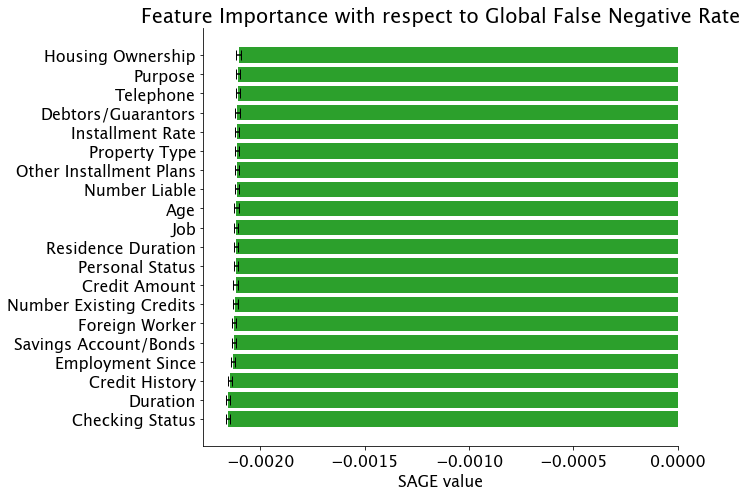

In [8]:
sage_values_fnr.plot(feature_names, title='Feature Importance with respect to Global False Negative Rate')

# Young group FNR

In [9]:
age_col = feature_names.index("Age")

In [10]:
where_young_train = train[:,age_col] <= 30
where_young_test = test[:,age_col] <= 30

test_young = test[where_young_test]
Y_test_young = Y_test[where_young_test]

In [12]:
# Setup and calculate with custom fairness-related loss function
imputer_young = sage.MarginalImputer(model, train[where_young_train])
estimator_young_fnr = sage.PermutationEstimator(imputer_young, 'fnr')
%time sage_values_young_fnr = estimator_young_fnr(test_young, Y_test_young, verbose=True, thresh=0.1)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_young_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

fn = 0, p = 301, fnr = 0.0
===> Iteration 0, Prev loss = 0.0 [outer loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 5, p = 301, fnr = 0

fn = 4, p = 322, fnr = 0.012422360248447204
	Loss = 0.012422360248447204 [inner loop]
fn = 4, p = 322, fnr = 0.012422360248447204
	Loss = 0.012422360248447204 [inner loop]
fn = 2, p = 322, fnr = 0.006211180124223602
	Loss = 0.006211180124223602 [inner loop]
fn = 3, p = 322, fnr = 0.009316770186335404
	Loss = 0.009316770186335404 [inner loop]
fn = 5, p = 322, fnr = 0.015527950310559006
	Loss = 0.015527950310559006 [inner loop]
fn = 5, p = 322, fnr = 0.015527950310559006
	Loss = 0.015527950310559006 [inner loop]
fn = 5, p = 322, fnr = 0.015527950310559006
	Loss = 0.015527950310559006 [inner loop]
fn = 2, p = 322, fnr = 0.006211180124223602
	Loss = 0.006211180124223602 [inner loop]
fn = 3, p = 322, fnr = 0.009316770186335404
	Loss = 0.009316770186335404 [inner loop]
fn = 1, p = 322, fnr = 0.003105590062111801
	Loss = 0.003105590062111801 [inner loop]
fn = 0, p = 322, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 322, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 322, fnr = 0.0
	Loss = 0

fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2595 (Converge at 0.1000)
fn = 0, p = 306, fnr = 0.0
===> Iteration 11, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679

fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2636 (Converge at 0.1000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 16, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.0099009

fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2966 (Converge at 0.1000)
fn = 0, p = 304, fnr = 0.0
===> Iteration 21, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.01315789473684

fn = 0, p = 316, fnr = 0.0
===> Iteration 26, Prev loss = 0.0 [outer loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 2, p = 316, fnr = 0.006329113924050633
	Loss = 0.006329113924050633 [inner loop]
fn = 2, p = 316, fnr = 0.006329113924050633
	Loss = 0.006329113924050633 [inner loop]
fn = 2, p = 316, fnr = 0.006329113924050633
	Loss = 0.006329113924050633 [inner loop]
fn = 4, p = 316, fnr = 0.012658227848101266
	Loss = 0.012658227848101266 [inner loop]
fn = 3, p = 316, fnr = 0.00949367088607595
	Loss = 0.00949367088607595 [inner loop]
fn = 3, p = 316, fnr = 0.00949367088607595
	Loss = 0.00949367088607595 [inner loop]
fn = 3, p = 316, fnr = 0.00949367088607595
	Loss = 0.00949367088607595 [inner loop]
fn = 4, p = 316, fnr = 0.012658227848101266
	Loss = 0.012658227848101266 [inner loop]
fn = 4, p = 316

fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 3, p = 311, fnr = 0.00964630225080386
	Loss = 0.00964630225080386 [inner loop]
fn = 3, p = 311, fnr = 0.00964630225080386
	Loss = 0.00964630225080386 [inner loop]
fn = 5, p = 311, fnr = 0.01607717041800643
	Loss = 0.01607717041800643 [inner loop]
fn = 5, p = 311, fnr = 0.01607717041800643
	Loss = 0.01607717041800643 [inner loop]
fn = 3, p = 311, fnr = 0.00964630225080386
	Loss = 0.00964630225080386 [inner loop]
fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.006430868167202572 [inner loop]
fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.00643086

fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 2, p = 283, fnr = 0.00706713780

fn = 0, p = 270, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 270, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 270, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 270, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 270, fnr = 0.003703703703703704
	Loss = 0.003703703703703704 [inner loop]
fn = 2, p = 270, fnr = 0.007407407407407408
	Loss = 0.007407407407407408 [inner loop]
fn = 1, p = 270, fnr = 0.003703703703703704
	Loss = 0.003703703703703704 [inner loop]
fn = 3, p = 270, fnr = 0.011111111111111112
	Loss = 0.011111111111111112 [inner loop]
fn = 2, p = 270, fnr = 0.007407407407407408
	Loss = 0.007407407407407408 [inner loop]
fn = 1, p = 270, fnr = 0.003703703703703704
	Loss = 0.003703703703703704 [inner loop]
fn = 2, p = 270, fnr = 0.007407407407407408
	Loss = 0.007407407407407408 [inner loop]
fn = 1, p = 270, fnr = 0.003703703703703704
	Loss = 0.003703703703703704 [inner loop]
fn = 1, p = 270, fnr = 0.003703703703703704
	Loss = 0.003703703703703704 [inner loop]
fn = 0, p = 270, f

fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 4, p = 292, fnr = 0.0136986301369863
	Loss = 0.0136986301

fn = 3, p = 274, fnr = 0.010948905109489052
	Loss = 0.010948905109489052 [inner loop]
fn = 3, p = 274, fnr = 0.010948905109489052
	Loss = 0.010948905109489052 [inner loop]
fn = 3, p = 274, fnr = 0.010948905109489052
	Loss = 0.010948905109489052 [inner loop]
fn = 1, p = 274, fnr = 0.0036496350364963502
	Loss = 0.0036496350364963502 [inner loop]
fn = 1, p = 274, fnr = 0.0036496350364963502
	Loss = 0.0036496350364963502 [inner loop]
fn = 2, p = 274, fnr = 0.0072992700729927005
	Loss = 0.0072992700729927005 [inner loop]
fn = 2, p = 274, fnr = 0.0072992700729927005
	Loss = 0.0072992700729927005 [inner loop]
fn = 3, p = 274, fnr = 0.010948905109489052
	Loss = 0.010948905109489052 [inner loop]
fn = 1, p = 274, fnr = 0.0036496350364963502
	Loss = 0.0036496350364963502 [inner loop]
fn = 3, p = 274, fnr = 0.010948905109489052
	Loss = 0.010948905109489052 [inner loop]
fn = 1, p = 274, fnr = 0.0036496350364963502
	Loss = 0.0036496350364963502 [inner loop]
fn = 0, p = 274, fnr = 0.0
	Loss = 0.0 [in

fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2561 (Converge at 0.1000)
fn = 0, p = 302, fnr = 0.0
===> Iteration 57, Prev loss = 0.0 [outer loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0

fn = 1, p = 278, fnr = 0.0035971223021582736
	Loss = 0.0035971223021582736 [inner loop]
fn = 3, p = 278, fnr = 0.01079136690647482
	Loss = 0.01079136690647482 [inner loop]
fn = 5, p = 278, fnr = 0.017985611510791366
	Loss = 0.017985611510791366 [inner loop]
fn = 5, p = 278, fnr = 0.017985611510791366
	Loss = 0.017985611510791366 [inner loop]
fn = 3, p = 278, fnr = 0.01079136690647482
	Loss = 0.01079136690647482 [inner loop]
fn = 3, p = 278, fnr = 0.01079136690647482
	Loss = 0.01079136690647482 [inner loop]
fn = 2, p = 278, fnr = 0.007194244604316547
	Loss = 0.007194244604316547 [inner loop]
fn = 0, p = 278, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 278, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2528 (Converge at 0.1000)
fn = 0, p = 285, fnr = 0.0
===> Iteration 62, Prev loss = 0.0 [outer loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0

fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2369 (Converge at 0.1000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 67, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Lo

fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2292 (Converge at 0.1000)
fn = 0, p = 296, fnr = 0.0
===> Iteration 72, Prev loss = 0.0 [outer loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296,

fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 2, p = 316, fnr = 0.006329113924050633
	Loss = 0.006329113924050633 [inner loop]
fn = 2, p = 316, fnr = 0.006329113924050633
	Loss = 0.006329113924050633 [inner loop]
fn = 3, p = 316, fnr = 0.00949367088607595
	Loss = 0.00949367088607595 [inner loop]
fn = 4, p = 316, fnr = 0.012658227848101266
	Loss = 0.012658227848101266 [inner loop]
fn = 3, p = 316, fnr = 0.00949367088607595
	Loss = 0.00949367088607595 [inner loop]
fn = 3, p = 316, fnr = 0.00949367088607595
	Loss = 0.00949367088607595 [inner loop]
fn

fn = 3, p = 287, fnr = 0.010452961672473868
	Loss = 0.010452961672473868 [inner loop]
fn = 3, p = 287, fnr = 0.010452961672473868
	Loss = 0.010452961672473868 [inner loop]
fn = 4, p = 287, fnr = 0.013937282229965157
	Loss = 0.013937282229965157 [inner loop]
fn = 7, p = 287, fnr = 0.024390243902439025
	Loss = 0.024390243902439025 [inner loop]
fn = 8, p = 287, fnr = 0.027874564459930314
	Loss = 0.027874564459930314 [inner loop]
fn = 6, p = 287, fnr = 0.020905923344947737
	Loss = 0.020905923344947737 [inner loop]
fn = 6, p = 287, fnr = 0.020905923344947737
	Loss = 0.020905923344947737 [inner loop]
fn = 9, p = 287, fnr = 0.0313588850174216
	Loss = 0.0313588850174216 [inner loop]
fn = 7, p = 287, fnr = 0.024390243902439025
	Loss = 0.024390243902439025 [inner loop]
fn = 4, p = 287, fnr = 0.013937282229965157
	Loss = 0.013937282229965157 [inner loop]
fn = 5, p = 287, fnr = 0.017421602787456445
	Loss = 0.017421602787456445 [inner loop]
fn = 4, p = 287, fnr = 0.013937282229965157
	Loss = 0.0139

fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2427 (Converge at 0.1000)
fn = 0, p = 310, fnr = 0.0
===> Iteration 88, Prev loss = 0.0 [outer loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner lo

fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2509 (Converge at 0.1000)
fn = 0, p = 312, fnr = 0.0
===> Iteration 93, Prev loss = 0.0 [outer loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner lo

fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 5, p = 297, fnr = 0.016835016835016835
	Loss = 0.016835016835016835 [inner loop]
fn = 4, p = 297, fnr = 0.013468013468013467
	Loss = 0.013468013468013467 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2801 (Converge at 0.1000)
fn = 0, p = 292, fnr = 0.0
===> Iteration 98, Prev loss = 0.0 [outer loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0

fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3005 (Converge at 0.1000)
fn = 0, p = 298, fnr = 0.0
===> Iteration 103, Prev loss = 0.0 [outer loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.01342281879194630

fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137

fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3055 (Converge at 0.1000)
fn = 0, p = 289, fnr = 0.0
===> Iteration 113, Prev loss = 0.0 [outer loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 4, p = 289, fnr = 0.

fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2871 (Converge at 0.1000)
fn = 0, p = 315, fnr = 0.0
===> Iteration 118, Prev loss = 0.0 [outer loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss =

fn = 0, p = 274, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 274, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 274, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 274, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 274, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 274, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 274, fnr = 0.0036496350364963502
	Loss = 0.0036496350364963502 [inner loop]
fn = 1, p = 274, fnr = 0.0036496350364963502
	Loss = 0.0036496350364963502 [inner loop]
fn = 0, p = 274, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 274, fnr = 0.0072992700729927005
	Loss = 0.0072992700729927005 [inner loop]
fn = 1, p = 274, fnr = 0.0036496350364963502
	Loss = 0.0036496350364963502 [inner loop]
fn = 3, p = 274, fnr = 0.010948905109489052
	Loss = 0.010948905109489052 [inner loop]
fn = 4, p = 274, fnr = 0.014598540145985401
	Loss = 0.014598540145985401 [inner loop]
fn = 4, p = 274, fnr = 0.014598540145985401
	Loss = 0.014598540145985401 [inner loop]
fn = 6, p = 274, fnr = 0.0

fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 2, p = 296, fnr = 0.006756756

fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 5, p = 299, fnr = 0.016722408026755852
	Loss = 0.016722408026755852 [inner loop]
fn = 5, p = 299, fnr = 0.016722408026755852
	Loss = 0.016722408026755852 [inner loop]
fn = 5, p = 299, fnr = 0.016722408026755852


fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner loop]
fn = 5, p = 307, fnr = 0.016286644951140065
	Loss = 0.016286644951140065 [inner loop]
fn = 4, p = 307, fnr = 0.013029315960912053
	Loss = 0.013029315960912053 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2686 (Converge at 0.1000)
fn = 0, p = 312, fnr = 0.0
===> Iteration 139, Prev loss = 0.0 [outer loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.

fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 5, p = 309, fnr = 0.016181229773462782
	Loss = 0.016181229773462782 [inner loop]
fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.003236245954692557 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2754 (Converge at 0.1000)
fn = 0, p = 304, fnr = 0.0
===> Iteration 144, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.

fn = 1, p = 321, fnr = 0.003115264797507788
	Loss = 0.003115264797507788 [inner loop]
fn = 1, p = 321, fnr = 0.003115264797507788
	Loss = 0.003115264797507788 [inner loop]
fn = 3, p = 321, fnr = 0.009345794392523364
	Loss = 0.009345794392523364 [inner loop]
fn = 2, p = 321, fnr = 0.006230529595015576
	Loss = 0.006230529595015576 [inner loop]
fn = 2, p = 321, fnr = 0.006230529595015576
	Loss = 0.006230529595015576 [inner loop]
fn = 0, p = 321, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 321, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 321, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2888 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 149, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 

fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2832 (Converge at 0.1000)
fn = 0, p = 297, fnr = 0.0
===> Iteration 154, Prev loss = 0.0 [outer loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 4, p = 297, fnr = 0.013468013468013467
	Loss = 0.013468013468013467 [inner loop]
fn = 7, p = 297, fnr = 0.02356902356902357
	Loss = 0.02356902356902357 [inner loop]
fn = 6, p = 297, fnr = 0.020202020202020204
	Loss = 0.020202020202020204 [inner loop]
fn = 2, p = 297, fnr = 0.00673400673400

fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2852 (Converge at 0.1000)
fn = 0, p = 290, fnr = 0.0
===> Iteration 159, Prev loss = 0.0 [outer loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.0103448275862

fn = 0, p = 314, fnr = 0.0
===> Iteration 164, Prev loss = 0.0 [outer loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 314, fnr = 0.0031847133757961785
	Loss = 0.0031847133757961785 [inner loop]
fn = 1, p = 314, fnr = 0.0031847133757961785
	Loss = 0.0031847133757961785 [inner loop]
fn = 1, p = 314, fnr = 0.0031847133757961785
	Loss = 0.0031847133757961785 [inner loop]
fn = 1, p = 314, fnr = 0.0031847133757961785
	Loss = 0.0031847133757961785 [inner loop]
fn = 3, p = 314, fnr = 0.009554140127388535
	Loss = 0.009554140127388535 [inner loop]
fn = 3, p = 314, fnr = 0.009554140127388535
	Loss = 0.009554140127388535 [inner loop]
fn = 4, p = 314, fnr = 0.012738853503184714
	Loss = 0.012738853503184714 [inner loop]
fn = 4, p = 314, fnr = 0.012738853503184714
	Loss = 0.012738853503184714 [inner loop]
fn = 2, p = 314, fnr = 0.006369426751592357
	Loss = 0.006369426751592357

fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Lo

fn = 4, p = 307, fnr = 0.013029315960912053
	Loss = 0.013029315960912053 [inner loop]
fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner loop]
fn = 4, p = 307, fnr = 0.013029315960912053
	Loss = 0.013029315960912053 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2932 (Converge at 0.1000)
fn = 0, p = 333, fnr = 0.0
===> Iteration 175, Prev loss = 0.0 [outer loop]
fn = 0, p = 333, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 333, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 333, fnr = 0.0
	Loss = 0.

fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3261 (Converge at 0.1000)
fn = 0, p = 287, fnr = 0.0
===> Iteration 180, Prev loss = 0.0 [outer loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287

fn = 7, p = 305, fnr = 0.022950819672131147
	Loss = 0.022950819672131147 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3022 (Converge at 0.1000)
fn = 0, p = 293, fnr = 0.0
===> Iteration 185, Prev loss = 0.0 [outer loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]

fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.3193 (Converge at 0.1000)
fn = 0, p = 310, fnr = 0.0
===> Iteration 190, Prev loss = 0.0 [outer loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.00645161

fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 4, p = 289, fnr = 0.01384083044982699
	Loss = 0.01384083044982699 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.0069204152249134

fn = 1, p = 325, fnr = 0.003076923076923077
	Loss = 0.003076923076923077 [inner loop]
fn = 1, p = 325, fnr = 0.003076923076923077
	Loss = 0.003076923076923077 [inner loop]
fn = 3, p = 325, fnr = 0.009230769230769232
	Loss = 0.009230769230769232 [inner loop]
fn = 3, p = 325, fnr = 0.009230769230769232
	Loss = 0.009230769230769232 [inner loop]
fn = 3, p = 325, fnr = 0.009230769230769232
	Loss = 0.009230769230769232 [inner loop]
fn = 3, p = 325, fnr = 0.009230769230769232
	Loss = 0.009230769230769232 [inner loop]
fn = 3, p = 325, fnr = 0.009230769230769232
	Loss = 0.009230769230769232 [inner loop]
fn = 2, p = 325, fnr = 0.006153846153846154
	Loss = 0.006153846153846154 [inner loop]
fn = 3, p = 325, fnr = 0.009230769230769232
	Loss = 0.009230769230769232 [inner loop]
fn = 1, p = 325, fnr = 0.003076923076923077
	Loss = 0.003076923076923077 [inner loop]
fn = 0, p = 325, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2813 (Converge at 0.1000)
fn = 0, p = 300, fnr = 0.0
===> Iteration 201

fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2563 (Converge at 0.1000)
fn = 0, p = 311, fnr = 0.0
===> Iteration 206, Prev loss = 0.0 [outer loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.0032154340

fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2557 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 211, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 2, p = 295, fnr = 0.006779661016949152
	Loss =

fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2598 (Converge at 0.1000)
fn = 0, p = 319, fnr = 0.0
===> Iteration 216, Prev loss = 0.0 [outer loop]
fn = 0, p = 319, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 319, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 319, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 319, fnr = 0.003134796238244514
	Loss = 0.003134796238244514 [inner loop]
fn = 1, p = 319, fnr = 0.003134796238244514
	Loss = 0.003134796238244514 [inner loop]
fn = 1, p = 319, fnr = 0.003134796238244514
	Loss = 0.003134796238244514 [inner loop]
fn = 1, p = 319, fnr = 0.003134796238244514
	Loss = 0.003134796238244514 [inner loop]
fn = 1, p = 319, fnr = 0.003134796238244514
	Loss = 0.003134796238244514 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 2, p = 319, 

fn = 3, p = 283, fnr = 0.01060070671378092
	Loss = 0.01060070671378092 [inner loop]
fn = 3, p = 283, fnr = 0.01060070671378092
	Loss = 0.01060070671378092 [inner loop]
fn = 3, p = 283, fnr = 0.01060070671378092
	Loss = 0.01060070671378092 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2666 (Converge at 0.1000)
fn = 0, p = 315, fnr = 0.0
===> Iteration 221, Prev loss = 0.0 [outer loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.0

fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2575 (Converge at 0.1000)
fn = 0, p = 280, fnr = 0.0
===> Iteration 226, Prev loss = 0.0 [outer loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 3, p = 280, fnr = 0.010714285714285714
	Loss = 0.010714285714285714 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 2, p = 280, fnr = 0.0071428571

fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 5, p = 288, fnr = 0.017361111111111112
	Loss = 0.017361111111111112 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]


fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2668 (Converge at 0.1000)
fn = 0, p = 293, fnr = 0.0
===> Iteration 237, Prev loss = 0.0 [outer loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fn

fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2521 (Converge at 0.1000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 242, Prev loss = 0.0 [outer loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 3, p = 294, fnr = 0.01020408163265306
	Loss = 0.01020408163265

fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner loop]
fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2322 (Converge at 0.1000)
fn = 0, p = 279, fnr = 0.0
===> Iteration 247, Prev loss = 0.0 [outer loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]

fn = 0, p = 299, fnr = 0.0
===> Iteration 252, Prev loss = 0.0 [outer loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 2, p = 299, f

fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.009740259

fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.

fn = 5, p = 304, fnr = 0.01644736842105263
	Loss = 0.01644736842105263 [inner loop]
fn = 5, p = 304, fnr = 0.01644736842105263
	Loss = 0.01644736842105263 [inner loop]
fn = 5, p = 304, fnr = 0.01644736842105263
	Loss = 0.01644736842105263 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868

fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 6, p = 291, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 5, p = 291, fnr = 0.01718213058419244
	Loss = 0.01718213058419244 [inner loop]
fn = 6, p = 291, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 6, p = 291, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 5, p = 291, fnr = 0.01718213058419244
	Loss = 0.01718213058419244 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.0137

fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2304 (Converge at 0.1000)
fn = 0, p = 286, fnr = 0.0
===> Iteration 278, Prev loss = 0.0 [outer loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.

fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2248 (Converge at 0.1000)
fn = 0, p = 297, fnr = 0.0
===> Iteration 283, Prev loss = 0.0 [outer loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.01010101010101010

fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 3, p = 

fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 3, p = 310, fnr = 0.00967741935483871
	Loss = 0.00967741935483871 [inner loop]
fn = 4, p = 310, fnr = 0.012903225806451613
	Loss = 0.012903225806451613 [inner loop]
fn = 4, p = 310, fnr = 0.012903225806451613
	Loss = 0.012903225806451613 [inner loop]
fn = 5, p = 310, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 4, p = 310, fnr = 0.012903225806451613
	Loss = 0.012903225806451613 [inner loop]
fn = 4, p = 310, fnr = 0.012903225806451613
	Loss = 0.012903225806451613 [inner loop]
fn = 4, p = 310, fnr = 0.012903225806451613
	Loss = 0.012903225806451613 [inner loop]
fn = 5, p = 310, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 5, p = 310, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 3, p = 310, fnr = 0.00967741935483871
	Loss = 0

fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 6, p = 296, fnr = 0.02027027027027027
	Loss = 0.02027027027027027 [inner loop]
fn = 5, p = 296, fnr = 0.016891891891891893
	Loss = 0.016891891891891893 [inner loop]
fn = 5, p = 296, fnr = 0.016891891891891893
	Loss = 0.016891891891891893 [inner loop]
fn = 6, p = 296, fnr = 0.02027027027027027
	Loss = 0.02027027027027027 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn

fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.00327868852

fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 5, p = 298, fnr = 0.016778523489932886
	Loss = 0.016778523489932886 [inner loop]
fn = 6, p = 298, fnr = 0.020134228187919462
	Loss = 0.020134228187919462 [inner loop]
fn = 6, p = 298, fnr = 0.020134228187919462
	Loss = 0.020134228187919462 [inner loop]
fn = 6, p = 298, fnr = 0.020134228187919462
	Loss = 0.020134228187919462 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 3, p = 298, fnr = 0.01006711409

fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 5, p = 285, fnr = 0.017543859649122806
	Loss = 0.017543859649122806 [inner loop]
fn = 3, p = 285, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1887 (Converge at 0.1000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 314, Prev l

fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 5, p = 315, fnr = 0.015873015873015872
	Loss = 0.015873015873015872 [inner loop]
fn = 5, p = 315, fnr = 0.015873015873015872
	Loss = 0.015873015873015872 [inner loop]
fn = 4, p = 315, fnr = 0.012698412698412698
	Loss = 0.012698412698412698 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1775 (Converge at 0.1000)
fn = 0, p = 300, fnr = 0.0
===> Iteration 319, Prev loss = 0.0 [outer loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 

fn = 4, p = 278, fnr = 0.014388489208633094
	Loss = 0.014388489208633094 [inner loop]
fn = 5, p = 278, fnr = 0.017985611510791366
	Loss = 0.017985611510791366 [inner loop]
fn = 3, p = 278, fnr = 0.01079136690647482
	Loss = 0.01079136690647482 [inner loop]
fn = 2, p = 278, fnr = 0.007194244604316547
	Loss = 0.007194244604316547 [inner loop]
fn = 2, p = 278, fnr = 0.007194244604316547
	Loss = 0.007194244604316547 [inner loop]
fn = 0, p = 278, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1805 (Converge at 0.1000)
fn = 0, p = 310, fnr = 0.0
===> Iteration 324, Prev loss = 0.0 [outer loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 310, fnr = 0.0032258064516129032
	Loss = 0.0032258064516129032 [inner loop]
fn = 1, p = 310, fnr = 0.0032258064516129032
	Loss = 0.0032258064516129032 [inner loop]
fn = 1, p = 310, 

fn = 6, p = 279, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 5, p = 279, fnr = 0.017921146953405017
	Loss = 0.017921146953405017 [inner loop]
fn = 5, p = 279, fnr = 0.017921146953405017
	Loss = 0.017921146953405017 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 1, p = 279, fnr = 0.0035842293906810036
	Loss = 0.0035842293906810036 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1872 (Converge at 0.1000)
fn = 0, p = 284, fnr = 0.0
===> Iteration 329, Prev loss = 0.0 [outer loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 2, p = 284, fnr = 0.007042253521126761
	Loss = 0.007042253521126761 [inner loop]
fn = 2, p = 284, fnr = 0.007042253521126761
	Loss = 0.007042253521126761 [inner loo

fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1857 (Converge at 0.1000)
fn = 0, p = 289, fnr = 0.0
===> Iteration 334, Prev loss = 0.0 [outer loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567

fn = 0, p = 321, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1849 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 339, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
f

fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Los

fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 7, p = 300, fnr = 0.023333333333333334
	Loss = 0.023333333333333334 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1907 (Converge at 0.1000)
fn = 0, p = 293, fnr 

fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1927 (Converge at 0.1000)
fn = 0, p = 308, fnr = 0.0
===> Iteration 355, Prev loss = 0.0 [outer loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.

fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 3, p = 277, fnr = 0.010830324909747292
	Loss = 0.010830324909747292 [inner loop]
fn = 3, p = 277, fnr = 0.010830324909747292
	Loss = 0.010830324909747292 [inner loop]
fn = 4, p = 277, fnr = 0.01444043321299639
	Loss = 0.01444043321299639 [inner loop]
fn = 4, p = 277, fnr = 0.01444043321299639
	Loss = 0.01444043321299639 [inner loop]
fn = 3, p = 277, fnr = 0.010830324909747292
	Loss = 0.010830324909747292 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1849 (Converge at 0.1000)
fn = 0, p = 278, fnr = 0.0
===> Iteration 360, Prev loss = 0.0 [outer loop]
fn = 0, p = 278, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 278, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 278, fn

fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1898 (Converge at 0.1000)
fn = 0, p = 283, fnr = 0.0
===> Iteration 365, Prev loss = 0.0 [outer loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 2, p = 283, fnr = 0.007067

fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1887 (Converge at 0.1000)
fn = 0, p = 296, fnr = 0.0
===> Iteration 370, Prev loss = 0.0 [outer loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.0067567

fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1865 (Converge at 0.1000)
fn = 0, p = 279, fnr = 0.0
===> Iteration 375, Prev loss = 0.0 [outer loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 279, fnr = 0.0035842293906810036
	Loss = 0.0035842293906810036 [inner loop]
fn = 1, p = 279, fnr = 0.0035842293906810036
	Loss = 0.0035842293906810036 [inner loop]
fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 3, p = 279, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 3, p = 279, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 3, p = 279, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 3, p = 279, fnr = 0.010752688172043012
	Loss = 0.0107526881720

fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1984 (Converge at 0.1000)
fn = 0, p = 291, fnr = 0.0
===> Iteration 380, Prev loss = 0.0 [outer loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 5, p = 291, fnr = 0.01718213058419244
	Loss = 0.01718213058419244 [inner loop]
fn = 5, p = 291, fnr = 0.017182130584

fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702

fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1972 (Converge at 0

fn = 3, p = 285, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1981 (Converge at 0.1000)
fn = 0, p = 290, fnr = 0.0
===> Iteration 396, Prev loss = 0.0 [outer loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loo

fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2043 (Converge at 0.1000)
fn = 0, p = 287, fnr = 0.0
===> Iteration 401, Prev loss = 0.0 [outer loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]

fn = 3, p = 316, fnr = 0.00949367088607595
	Loss = 0.00949367088607595 [inner loop]
fn = 2, p = 316, fnr = 0.006329113924050633
	Loss = 0.006329113924050633 [inner loop]
fn = 4, p = 316, fnr = 0.012658227848101266
	Loss = 0.012658227848101266 [inner loop]
fn = 5, p = 316, fnr = 0.015822784810126583
	Loss = 0.015822784810126583 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 3, p = 316, fnr = 0.00949367088607595
	Loss = 0.00949367088607595 [inner loop]
fn = 3, p = 316, fnr = 0.00949367088607595
	Loss = 0.00949367088607595 [inner loop]
fn = 4, p = 316, fnr = 0.012658227848101266
	Loss = 0.012658227848101266 [inner loop]
fn = 2, p = 316, fnr = 0.006329113924050633
	Loss = 0.006329113924050633 [inner loop]
fn = 2, p = 316, fnr = 0.006329113924050633
	Loss = 0.

fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2086 (Converge at 0

fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 7, p = 309, fnr = 0.022653721682847898
	Loss = 0.022653721682847898 [inner loop]
fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 2, p = 309, fnr = 0.006472491909385114
	Loss = 0.006472491909385114 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2064 (Converge at 0.1000)
fn = 0, p = 311, fnr = 0.0
===> Iteration 416, Prev loss = 0.0 [outer loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn 

fn = 5, p = 292, fnr = 0.017123287671232876
	Loss = 0.017123287671232876 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 4, p = 292, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2098 (Converge at 0.1000)
fn = 0, p = 304, fnr = 0.0
===> Iteration 421, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003

fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2074 (Converge at 0.1000)
fn = 0, p = 297, fnr = 0.0
===> Iteration 426, Prev loss = 0.0 [outer loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.0033670033

fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2102 (Converge at 0.1000)
fn = 0, p = 297, fnr = 0.0
===> Iteration 431, Prev loss = 0.0 [outer loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loo

fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 6, p = 296, fnr = 0.02027027027027027
	Loss = 0.02027027027027027 [inner loop]
fn = 5, p = 296, fnr = 0.016891891891891893
	Loss = 0.016891891891891893 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296,

fn = 3, p = 278, fnr = 0.01079136690647482
	Loss = 0.01079136690647482 [inner loop]
fn = 3, p = 278, fnr = 0.01079136690647482
	Loss = 0.01079136690647482 [inner loop]
fn = 3, p = 278, fnr = 0.01079136690647482
	Loss = 0.01079136690647482 [inner loop]
fn = 2, p = 278, fnr = 0.007194244604316547
	Loss = 0.007194244604316547 [inner loop]
fn = 0, p = 278, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2165 (Converge at 0.1000)
fn = 0, p = 308, fnr = 0.0
===> Iteration 442, Prev loss = 0.0 [outer loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.00324

fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2113 (Converge at 0.1000)
fn = 0, p = 283, fnr = 0.0
===> Iteration 447, Prev loss = 0.0 [outer loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 2, p = 283, fnr = 0.007067137809187279
	Loss = 0.007067137809187279 [inner loop]
fn = 1, p = 283, fnr = 0.0035335689045936395
	Loss = 0.0035335689045936395 [inner loop]
fn = 3, p = 283, fnr = 0.01060070671378092
	Loss = 0.01060070671378092 [inner loop]
fn = 2, p = 283, fnr = 0.007067137809187279
	Loss = 0.007067137809187279 [inner loop]
fn = 3, p = 283, fnr = 0.01060070671378092
	Loss = 0.01060070671378092 [inner loop]
fn = 4, p = 283, 

fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 4, p = 289, fnr = 0.01384083044982699
	Loss = 0.01384083044982699 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 4, p = 289, fnr = 0.01384083044982699
	Loss = 0.01384083044982699 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 4, p = 289, fnr = 0.01384083044982699
	Loss = 0.01384083044982699 [inner loop]
fn =

fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 5, p = 286, fnr = 0.017482517482517484
	Loss = 0.017482517482517484 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 5, p = 286, fnr = 0.017482517482517484
	Loss = 0.017482517482517484 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048

fn = 4, p = 315, fnr = 0.012698412698412698
	Loss = 0.012698412698412698 [inner loop]
fn = 5, p = 315, fnr = 0.015873015873015872
	Loss = 0.015873015873015872 [inner loop]
fn = 6, p = 315, fnr = 0.01904761904761905
	Loss = 0.01904761904761905 [inner loop]
fn = 8, p = 315, fnr = 0.025396825396825397
	Loss = 0.025396825396825397 [inner loop]
fn = 6, p = 315, fnr = 0.01904761904761905
	Loss = 0.01904761904761905 [inner loop]
fn = 7, p = 315, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 7, p = 315, fnr = 0.022222222222222223
	Loss = 0.022222222222222223 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2050 (Converge at 0.1000)
fn = 0, p = 291, fnr = 0.0
===> Iteration 463, Prev loss = 0.0 [outer loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 

fn = 5, p = 294, fnr = 0.017006802721088437
	Loss = 0.017006802721088437 [inner loop]
fn = 5, p = 294, fnr = 0.017006802721088437
	Loss = 0.017006802721088437 [inner loop]
fn = 5, p = 294, fnr = 0.017006802721088437
	Loss = 0.017006802721088437 [inner loop]
fn = 4, p = 294, fnr = 0.013605442176870748
	Loss = 0.013605442176870748 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2111 (Converge at 0.1000)
fn = 0, p = 310, fnr = 0.0
===> Iteration 468, Prev loss = 0.0 [outer loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.

fn = 3, p = 271, fnr = 0.01107011070110701
	Loss = 0.01107011070110701 [inner loop]
fn = 2, p = 271, fnr = 0.007380073800738007
	Loss = 0.007380073800738007 [inner loop]
fn = 3, p = 271, fnr = 0.01107011070110701
	Loss = 0.01107011070110701 [inner loop]
fn = 3, p = 271, fnr = 0.01107011070110701
	Loss = 0.01107011070110701 [inner loop]
fn = 0, p = 271, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 271, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1991 (Converge at 0.1000)
fn = 0, p = 296, fnr = 0.0
===> Iteration 473, Prev loss = 0.0 [outer loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [i

fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1996 (Converge at 0.1000)
fn = 0, p = 316, fnr = 0.0
===> Iteration 478, Prev loss = 0.0 [outer loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 3, p = 316, fnr = 0.00949367088607595
	Loss = 0.00949367088607595 [inner loop]
fn = 2, p = 316, fnr = 0.006329113924050633
	Lo

fn = 0, p = 301, fnr = 0.0
===> Iteration 483, Prev loss = 0.0 [outer loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 5, p = 301, fnr = 0.016611295681063124
	Loss = 0.016611295681063124 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 1, p = 301, fnr = 0

fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 2

fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 1, p = 285, fnr = 0.003508771929824

fn = 3, p = 317, fnr = 0.00946372239747634
	Loss = 0.00946372239747634 [inner loop]
fn = 2, p = 317, fnr = 0.006309148264984227
	Loss = 0.006309148264984227 [inner loop]
fn = 4, p = 317, fnr = 0.012618296529968454
	Loss = 0.012618296529968454 [inner loop]
fn = 2, p = 317, fnr = 0.006309148264984227
	Loss = 0.006309148264984227 [inner loop]
fn = 3, p = 317, fnr = 0.00946372239747634
	Loss = 0.00946372239747634 [inner loop]
fn = 2, p = 317, fnr = 0.006309148264984227
	Loss = 0.006309148264984227 [inner loop]
fn = 3, p = 317, fnr = 0.00946372239747634
	Loss = 0.00946372239747634 [inner loop]
fn = 3, p = 317, fnr = 0.00946372239747634
	Loss = 0.00946372239747634 [inner loop]
fn = 3, p = 317, fnr = 0.00946372239747634
	Loss = 0.00946372239747634 [inner loop]
fn = 1, p = 317, fnr = 0.0031545741324921135
	Loss = 0.0031545741324921135 [inner loop]
fn = 0, p = 317, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 317, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 317, fnr = 0.0
	Loss = 0.0 [inne

fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1939 (Converge at 0.1000)
fn = 0, p = 284, fnr = 0.0
===> Iteration 504, Prev loss = 0.0 [outer loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 

fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1893 (Converge at 0.1000)
fn = 0, p = 309, fnr = 0.0
===> Iteration 509, Prev loss = 0.0 [outer loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.003236245954692557 [inner loop]
fn = 2, p = 309, fnr = 0.006472491909385114
	Loss = 0.006472491909385114 [inner loop]
fn = 2, p = 309, fnr = 0.006472491909385114
	Loss = 0.006472491909385114 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 1, p = 309

fn = 6, p = 301, fnr = 0.019933554817275746
	Loss = 0.019933554817275746 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1877 (Converge at 0.1000)
fn = 0, p = 296, fnr = 0.0
===> Iteration 514, Prev loss = 0.0 [outer loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	L

fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1842 (Converge at 0.1000)
fn = 0, p = 277, fnr = 0.0
===> Iteration 519, Prev loss = 0.0 [outer loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	L

fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1840 (Converge at 0.1000)
fn = 0, p = 288, fnr = 0.0
===> Iteration 524, Prev loss = 0.0 [outer loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 4, p = 288, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn = 5, p = 288, fnr = 0.017361111111111112
	Loss = 0.017361111111111112 [inner loop]
fn = 6, p = 288, fnr = 0.020833333333333332
	Loss = 0

fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 5, p = 315, fnr = 0.015873015873015872
	Loss = 0.015873015873015872 [inner loop]
fn = 5, p = 315, fnr = 0.015873015873015872
	Loss = 0.015873015873015872 [inner loop]
fn = 5, p = 315, fnr = 0.015873015873015872
	Loss = 0.015873015873015872 [inner loop]
fn = 6, p = 315, fnr = 0.01904761904761905
	Loss = 0.01904761904761905 [inner loop]
fn = 8, p = 315, fnr = 0.025396825396825397
	Loss = 0.0253968253968253

fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0

fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 4, p = 292, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 6, p = 292, fnr = 0.02054794520547945
	Loss = 0.02054794520547945 [inner loop]
fn = 4, p = 292, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1870 (Converge at 0.1000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 540, Prev loss = 0.0 [outer loop]
fn = 0, p = 294, 

fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1829 (Converge at 0.1000)
fn = 0, p = 320, fnr = 0.0
===> Iteration 545, Prev loss = 0.0 [outer loop]
fn = 0, p = 320, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 320, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 320, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 320, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 1, p = 320, fnr = 0.003125

fn = 5, p = 293, fnr = 0.017064846416382253
	Loss = 0.017064846416382253 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1941 (Converge at 0.1000)
fn = 0, p = 306, fnr = 0.0
===> Iteration 550, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.0065359

fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1919 (Converge at 0.1000)
fn = 0, p = 290, fnr = 0.0
===> Iteration 555, Prev loss = 0.0 [outer loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p

fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1850 (Converge at 0.1000)
fn = 0, p = 296, fnr = 0.0
===> Iteration 560, Prev loss = 0.0 [outer loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296

fn = 0, p = 299, fnr = 0.0
===> Iteration 565, Prev loss = 0.0 [outer loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 6, p = 299, fnr = 0.020066889632107024
	Loss = 0.020066889632107024 [inner loop]
fn = 5, p = 299, fnr = 0.016722408026755852
	Loss = 0.016722408026755852 [inner loop]
fn = 4, p = 299, fnr =

fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 6, p = 304, fnr = 0.019736842105263157
	Loss = 0.019736842105263157 [inner loop]
fn = 7, p = 304, fnr = 0.023026315789473683
	Loss = 0.023026315789473683 [inner loop]
fn = 6, p = 304, fnr = 0.019736842105263157
	Loss = 0.019736842105263157 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1843 (Converge at 0.1000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 571

fn = 3, p = 279, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1934 (Converge at 0.1000)
fn = 0, p = 314, fnr = 0.0
===> Iteration 576, Prev loss = 0.0 [outer loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 314, fnr = 0.0031847133757961785
	Loss = 0.0031847133757961785 [inner loop]
fn = 2, p = 314, fnr = 0.006369426751592357
	Loss = 0.006369426751592357 [inner loop]
fn = 4, p = 314, fnr = 0.012738853503184714
	Loss = 0.012738853503184714 [inner loop]
fn = 4, p = 314, fnr = 0.012738853503184714
	Loss = 0.012738853503184714 [inner loop]
fn = 5, p = 314, fnr = 0.01592356687898089
	Loss = 0.01592356687898089 [inner loop]
fn = 6, p = 314, fnr = 0.01910828025477707
	Loss = 0.01910828025477707 

fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1947 (Converge at 0.1000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 581, Prev loss = 0.0 [outer loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.00340136054421768

fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2004 (Converge at 0.1000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 586, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1,

fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.2009 (Converge at 0.1000)
fn = 0, p = 312, fnr = 0.0
===> Iteration 591, Prev loss = 0.0 [outer loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 2, p = 312, fnr = 0.00641025641025641
	Loss = 0.0064102564102564

fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 2, p = 286, fnr = 0.006993006993006993
	Loss = 0.006993006993006993 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1973 (Converge at 0

fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 4, p = 285, fnr = 0.014035087719298246
	Loss = 0.014035087719298246 [inner loop]
fn = 7, p = 285, fnr = 0.02456140350877193
	Loss = 0.02456140350877193 [inner loop]
fn = 5, p = 285, fnr = 0.017543859649122806
	Loss = 0.017543859649122806 [inner loop]
fn = 5, p = 285, fnr = 0.017543859649122806
	Loss = 0.017543859649122806 [inner loop]
fn = 6, p = 285, fnr = 0.021052631578947368
	Loss = 0.021052631578947368 [inner loop]
fn = 4, p = 285, fnr = 0.014035087719298246
	Loss = 0.014035087719298246 [inner loop]
fn = 3, p = 285, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1911 (Converge at 0.1000)
fn = 0, p = 311, fnr = 0.0
===> Iteration 602, Prev loss = 0.0 [outer loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 

fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1846 (Converge at 0.1000)
fn = 0, p = 275, fnr = 0.0
===> Iteration 607, Prev loss = 0.0 [outer loop]
fn = 0, p = 275, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 275, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 275, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 275, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 275, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 275, fnr = 0.0036363636363636364
	Loss = 0.0036363636363636364 [inner loop]
fn = 2, p = 275, fnr = 0.007272727272727273
	Loss = 0.007272727272727273 [inner loop]
fn = 2, p = 275, fnr = 0.007272727272727273
	Loss = 0.007272727272727273 [inner loop]
fn = 2, p = 275, fnr = 0.007272727272727273
	

fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 5, p = 303, fnr = 0.0165016501650165
	Loss = 0.0165016501650165 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Los

fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.

fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 3, p = 287, fnr = 0.010452961672473868
	Loss = 0.010452961672473868 [inner loop]
fn = 4, p = 287, fnr = 0.013937282229965157
	Loss = 0.013937282229965157 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 3, p = 287, fnr = 0.010452961672473868
	Loss = 0.010452961672473868 [inner loop]
fn = 3, p = 287, fnr = 0.010452961672473868
	Loss = 0.010452961672473868 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.

fn = 3, p = 313, fnr = 0.009584664536741214
	Loss = 0.009584664536741214 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1838 (Converge at 0.1000)
fn = 0, p = 316, fnr = 0.0
===> Iteration 628, Prev loss = 0.0 [outer loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.

fn = 3, p = 295, fnr = 0.010169491525423728
	Loss = 0.010169491525423728 [inner loop]
fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1906 (Converge at 0.1000)
fn = 0, p = 281, fnr = 0.0
===> Iteration 633, Prev loss = 0.0 [outer loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 2, p = 281

fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1996 (Converge at 0.1000)
fn = 0, p = 292, fnr = 0.0
===> Iteration 638, Prev loss = 0.0 [outer loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 2, p = 292, 

fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 5, p = 315, fnr = 0.015873015873015872
	Loss = 0.015873015873015872 [inner loop]
fn = 4, 

fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 5, p = 306, fnr = 0.016339869281045753
	Loss = 0.016339869281045753 [inner loop]
fn = 8, p = 306, fnr = 0.026143790849673203
	Loss = 0.026143790849673203 [inner loop]
fn = 6, p = 306, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 5, p = 306, fnr = 0.016339869281045753
	Loss = 0.016339869281045753 [inner loop]
fn = 6, p = 306, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1970 (Converge at 0.1000)
fn = 0, p = 310, fnr = 0.0
===> Iteration 649, Prev los

fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 4, p = 305, fnr = 0.013114754098360656
	Loss = 0.013114754098360656 [inner loop]
fn = 4, p = 305, fnr = 0.013114754098360656
	Loss = 0.013114754098360656 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 4, p = 305, fnr = 0.013114754098360656
	Loss = 0.013114754098360656 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1908 (Converge at 0.1000)
fn = 0, p = 301, fnr = 0.0
===> Iteration 654, Prev loss = 0.0 [outer loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn 

fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1858 (Converge at 0.1000)
fn = 0, p = 277, fnr = 0.0
===> Iteration 659, Prev loss = 0.0 [outer loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 0, p = 2

fn = 0, p = 294, fnr = 0.0
===> Iteration 664, Prev loss = 0.0 [outer loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 3, p = 294, fnr = 0.01020408163265306
	Loss = 0.01020408163265306 [inner loop]
fn = 3, p = 294, fnr = 0.01020408163265306
	Loss = 0.01020408163265306 [inner loop]
fn = 3, p = 294, fnr = 0.01020408163265306
	Loss = 0.01020408163265306 [inner loop]
fn = 4, p = 294, fnr = 0.013605442176870748
	Loss = 0.013605442176870748 [inner loop]
fn = 4, p = 294, fnr = 0.013605442176870748
	Loss = 0.013605442176870748 [inner loop]
fn = 4, p = 294, fnr = 0.013605442176870748
	Loss = 0.013605442176870748 [inner loop]
fn = 3, p = 294, fnr = 0.010204081

fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.0032467532

fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 5, p = 315, fnr = 0.015873015873015872
	Loss = 0.015873015873015872 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 4, p = 315, fnr = 0.012698412698412698
	Loss = 0.012698412698412698 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 4, p = 

fn = 0, p = 310, fnr = 0.0
===> Iteration 679, Prev loss = 0.0 [outer loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 1, p = 310, fnr = 0.0032258064516129032
	Loss = 0.0032258064516129032 [inner loop]
fn = 1, p = 310, fnr = 0.0032258064516129032
	Loss = 0.0032258064516129032 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 310, fnr = 0.0032258064516129032
	Loss = 0.0032258064516129032 [inner loop]
fn = 1, p = 310, fnr = 0.0032258064516129032
	Loss = 0.0032258064516129032 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 2, p = 

fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 7, p = 293, fnr = 0.023890784982935155
	Loss = 0.023890784982935155 [inner loop]
fn = 9, p = 293, fnr = 0.030716723549488054
	Loss = 0.030716723549488054 [inner loop

fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 4, p = 302, fnr = 0.013245033112582781
	Loss = 0.013245033112582781 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss

fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.006493506493506494 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 5, p = 308, fnr = 0.016233766233766232
	Loss = 0.016233766233766232 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 4, p = 308, fnr = 0.012987012987012988
	Loss = 0.012987012987012988 [inner loop]
fn = 2, p = 308, fnr = 0.006493506493506494
	Loss = 0.

fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 5, p = 292, fnr = 0.017123287671232876
	Loss = 0.017123287671232876 [inner loop]
fn = 5, p = 292, fnr = 0.017123287671232876
	Loss = 0.017123287671232876 [inner loop]
fn = 5, p = 292, fnr = 0.017123287671232876
	Loss = 0.017123287671232876 [inner loop]
fn = 5, p = 292, fnr = 0.017123287671232876
	Loss = 0.017123287671232876 [inner loop]
fn = 4, p = 292, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 6, p = 292, fnr = 0.02054794520547945
	Loss = 0.02054794520547945 [inner loop]
fn = 6, p = 292, fnr = 0.02054794520547945
	Loss = 0.02054794520547945 [inner loop]
fn = 5, p = 292, fnr = 0.017123287671232876
	Loss = 0.01712328

fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]


fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 3, p = 285, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 3, p = 285, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1902 (Converge at 0.1000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 710, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]

fn = 6, p = 309, fnr = 0.019417475728155338
	Loss = 0.019417475728155338 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 2, p = 309, fnr = 0.006472491909385114
	Loss = 0.006472491909385114 [inner loop]
fn = 2, p = 309, fnr = 0.006472491909385114
	Loss = 0.006472491909385114 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1896 (Converge at 0.1000)
fn = 0, p = 286, fnr = 0.0
===> Iteration 715, Prev loss = 0.0 [outer loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, 

fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1916 (Converge at 0.1000)
fn = 0, p = 307, fnr = 0.0
===> Iteration 720, Prev loss = 0.0 [outer loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0

fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1947 (Converge at 0.1000)
fn = 0, p = 287, fnr = 0.0
===> Iteration 725, Prev loss = 0.0 [outer loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 2, p = 287, fnr = 0.00696864

fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 313, fnr = 0.003194888

fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 4, p = 306, fnr = 0.013071895424836602
	Loss = 0.013071895424836602 [inner loop]
fn = 5, p = 306, fnr = 0.016339869281045753
	Loss = 0.016339869281045753 [inner loop]
fn = 6, p = 306, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 4, p = 306, fnr = 0.013071895424836602
	Loss = 0.013071895424836602 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1936 (Converge at 0.1000)
fn = 0, p = 300, fnr = 0.0
===> Iteration 736, Prev loss = 0.0 [outer loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 3

fn = 0, p = 281, fnr = 0.0
===> Iteration 741, Prev loss = 0.0 [outer loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn =

fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 4, p = 288, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn = 4, p = 288, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 4, p = 288, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.

fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 5, p = 298, fnr = 0.016778523489932886
	Loss = 0.016778523489932886 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 5, p = 298, fnr = 0.016778523489932886
	Loss = 0.016778523489932886 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 5, p = 298, fnr = 0.016778523489932886
	Loss = 0.016778523489932886 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0

fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1849 (Converge at 0.1000)
fn = 0, p = 316, fnr = 0.0
===> Iteration 757, Prev loss = 0.0 [outer loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 316, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 2, p = 316, fnr = 0.006329113924050633
	Loss = 0.006329113924050633 [inner loop]
fn = 1, p = 316, fnr = 0.0031645569620253164
	Loss = 0.0031645569620253164 [inner loop]
fn = 1, p = 316, fnr = 0.00

fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1795 (Converge at 0.1000)
fn = 0, p = 277, fnr = 0.0
===> Iteration 762, Prev loss = 0.0 [outer loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 2, p = 277, fnr = 0.007220216606498195
	Loss = 0.007220216606498195 [inner loop]
fn = 1, p =

fn = 3, p = 310, fnr = 0.00967741935483871
	Loss = 0.00967741935483871 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 1, p = 310, fnr = 0.0032258064516129032
	Loss = 0.0032258064516129032 [inner loop]
fn = 1, p = 310, fnr = 0.0032258064516129032
	Loss = 0.0032258064516129032 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1814 (Converge at 0.1000)
fn = 0, p = 304, fnr = 0.0
===> Iteration 767, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loo

fn = 1, p = 310, fnr = 0.0032258064516129032
	Loss = 0.0032258064516129032 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 310, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1807 (Converge at 0.1000)
fn = 0, p = 314, fnr = 0.0
===> Iteration 772, Prev loss = 0.0 [outer loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 314, fnr = 0.006369426751592357
	Loss = 0.006369426751592357 [inner loop]
fn = 2, p = 314, fnr = 0.006369426751592357
	Loss = 0.006369426751592357 [inner loop]
fn = 3, p = 314, fnr = 0.009554140127388535
	Loss = 0.009554140127388535 [inner loop]
fn = 3, p = 314, fnr = 0.009554140127388535
	Loss = 0.009554140127388535 [inner loop]
fn = 4, p = 314, fnr = 0.012738853503184714
	Loss = 0.012738853503184714 [inner loop]

fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1790 (Converge at 0.1000)
fn = 0, p = 305, fnr = 0.0
===> Iteration 777, Prev loss = 0.0 [outer loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 5, p = 305, fnr = 0.01639344262295082
	Loss = 0.01639344262295082 [inner loop]
fn = 8, p = 305, fnr = 0.02622950819672131
	Loss = 0.02622950819672131 [inner loop]
fn = 8, p = 305, fnr = 0.02622950819672131
	Loss = 0.02622950819672131 [inner loop]
fn = 6, p = 305, fnr = 0.019672131147540985
	Loss = 0.019672131147540985 [inner loop]
fn = 9, p = 305, fnr = 0.

fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0

fn = 2, p = 318, fnr = 0.006289308176100629
	Loss = 0.006289308176100629 [inner loop]
fn = 2, p = 318, fnr = 0.006289308176100629
	Loss = 0.006289308176100629 [inner loop]
fn = 3, p = 318, fnr = 0.009433962264150943
	Loss = 0.009433962264150943 [inner loop]
fn = 5, p = 318, fnr = 0.015723270440251572
	Loss = 0.015723270440251572 [inner loop]
fn = 5, p = 318, fnr = 0.015723270440251572
	Loss = 0.015723270440251572 [inner loop]
fn = 4, p = 318, fnr = 0.012578616352201259
	Loss = 0.012578616352201259 [inner loop]
fn = 2, p = 318, fnr = 0.006289308176100629
	Loss = 0.006289308176100629 [inner loop]
fn = 3, p = 318, fnr = 0.009433962264150943
	Loss = 0.009433962264150943 [inner loop]
fn = 1, p = 318, fnr = 0.0031446540880503146
	Loss = 0.0031446540880503146 [inner loop]
fn = 1, p = 318, fnr = 0.0031446540880503146
	Loss = 0.0031446540880503146 [inner loop]
fn = 1, p = 318, fnr = 0.0031446540880503146
	Loss = 0.0031446540880503146 [inner loop]
fn = 2, p = 318, fnr = 0.006289308176100629
	Los

fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.003236245954692557 [inner loop]
fn = 2, p = 309, fnr = 0.006472491909385114
	Loss = 0.006472491909385114 [inner loop]
fn = 2, p = 309, fnr = 0.006472491909385114
	Loss = 0.006472491909385114 [inner loop]
fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.003236245954692557 [inner loop]
fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.003236245954692557 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.003236245954692557 [inner loop]
fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.003236245954692557 [inner loop]
fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.003236245954692557 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn

fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1839 (Converge at 0.1000)
fn = 0, p = 284, fnr = 0.0
===> Iteration 798, Prev loss = 0.0 [outer loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner

fn = 3, p = 287, fnr = 0.010452961672473868
	Loss = 0.010452961672473868 [inner loop]
fn = 4, p = 287, fnr = 0.013937282229965157
	Loss = 0.013937282229965157 [inner loop]
fn = 4, p = 287, fnr = 0.013937282229965157
	Loss = 0.013937282229965157 [inner loop]
fn = 5, p = 287, fnr = 0.017421602787456445
	Loss = 0.017421602787456445 [inner loop]
fn = 6, p = 287, fnr = 0.020905923344947737
	Loss = 0.020905923344947737 [inner loop]
fn = 5, p = 287, fnr = 0.017421602787456445
	Loss = 0.017421602787456445 [inner loop]
fn = 6, p = 287, fnr = 0.020905923344947737
	Loss = 0.020905923344947737 [inner loop]
fn = 6, p = 287, fnr = 0.020905923344947737
	Loss = 0.020905923344947737 [inner loop]
fn = 5, p = 287, fnr = 0.017421602787456445
	Loss = 0.017421602787456445 [inner loop]
fn = 5, p = 287, fnr = 0.017421602787456445
	Loss = 0.017421602787456445 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
St

fn = 1, p = 319, fnr = 0.003134796238244514
	Loss = 0.003134796238244514 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 3, p = 319, fnr = 0.009404388714733543
	Loss = 0.009404388714733543 [inner loop]
fn = 1, p = 319, fnr = 0.003134796238244514
	Loss = 0.003134796238244514 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 0, p = 319, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 319, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 319, fnr = 0.0
	Loss = 0

fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 3, p = 280, fnr = 0.010714285714285714
	Loss = 0.010714285714285714 [inner loop]
fn = 3, p = 280, fnr = 0.010714285714285714
	Loss = 0.010714285714285714 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn =

fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1709 (Converge at 0.1000)
fn = 0, p = 301, fnr = 0.0
===> Iteration 818, Prev loss = 0.0 [out

fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1693 (Converge at 0.1000)
fn = 0, p = 299, fnr = 0.0
===> Iteration 823, Prev loss = 0.0 [outer loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fn

fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1705 (Converge at 0.1000)
fn = 0, p = 305, fnr = 0.0
===> Iteration 828, Prev loss = 0.0 [outer loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fn

fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1715 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 833, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 3, p = 295, fnr = 0.010169491525423728
	Loss = 0.010169491525423728 [inner loop]
fn = 3, p = 295, fnr = 0.010169491525423728
	Loss = 0.010169491525423728 [inner loop]
fn = 4, p = 295, fnr = 0.013559322033

fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1694 (Converge at 0.1000)
fn = 0, p = 299, fnr = 0.0
===> Iteration 838, Prev loss = 0.0 [outer loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.0100334448160

fn = 0, p = 295, fnr = 0.0
===> Iteration 843, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, 

fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 7, p = 304, fnr = 0.023026315789473683
	Loss = 0.023026315789473683 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]


fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.

fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 3, p = 279, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 1, p = 279, fnr = 0.0035842293906810036
	Loss = 0.0035842293906810036 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]


fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 6, p = 298, fnr = 0.020134228187919462
	Loss = 0.020134228187919462 [inner loop]
fn = 8, p = 298, fnr = 0.026845637583892617
	Loss = 0.026845637583892617 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 5, p = 298, fnr = 0.016778523489932886
	Loss = 0.016778523489932886 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 7, p = 298, fnr = 0.02348993288590604
	Loss = 0.02348993288590604 [inner loop]
fn = 5, p = 298, fnr = 0.016778523489932886
	Loss = 0.016778523489932886 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
StdD

fn = 6, p = 303, fnr = 0.019801980198019802
	Loss = 0.019801980198019802 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 6, p = 303, fnr = 0.019801980198019802
	Loss = 0.019801980198019802 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 6, p = 303, fnr = 0.019801980198019802
	Loss = 0.019801980198019802 [inner loop]
fn = 5, p = 303, fnr = 0.0165016501650165
	Loss = 0.0165016501650165 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
St

fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 6, p = 300, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1770 (Converge at 0.1000)
fn = 0, p = 298, fnr = 0.0
===> Iteration 874, Prev loss = 0.0 [outer loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298

fn = 6, p = 318, fnr = 0.018867924528301886
	Loss = 0.018867924528301886 [inner loop]
fn = 1, p = 318, fnr = 0.0031446540880503146
	Loss = 0.0031446540880503146 [inner loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1753 (Converge at 0.1000)
fn = 0, p = 315, fnr = 0.0
===> Iteration 879, Prev loss = 0.0 [outer loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss =

fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1738 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 884, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 4, p = 295, fnr = 0.013559322033898305
	Loss = 0.013559322033898305 [inner loop]
fn = 5, p = 295, fnr = 0.01694915254237288
	Loss = 0.01694915254237288 [inner loop]
fn = 6, p = 295, fnr = 0.020338983050847456
	Loss = 0.020338983050847456 

fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535

fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 5, p = 291, fnr = 0.01718213058419244
	Loss = 0.01718213058419244 [inner loop]
fn = 5, p = 291, fnr = 0.01718213058419244
	Loss = 0.01718213058419244 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [

fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 3, p = 279, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 5, p = 279, fnr = 0.017921146953405017
	Loss = 0.017921146953405017 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1679 (Converge at 0.1000)
fn = 0, p = 308, fnr = 0.0
===> Iteration 900, Prev loss = 0.0 [outer loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.00324675324675324

fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 3, p = 295, fnr = 0.010169491525423728
	Loss = 0.010169491525423728 [inner loop]
fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 4, p = 295, fnr = 0.013559322033898305
	Loss = 0.013559322033898305 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1655 (Converge at 0.1000)
fn = 0, p = 305, fnr = 0.0
===> Iteration 905, Prev loss = 0.0 [outer loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
f

fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1651 (Converge at 0.1000)
fn = 0, p = 291, fnr = 0.0
===> Iteration 910, Prev loss = 0.0 [outer loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss =

fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1595 (Converge at 0.1000)
fn = 0, p = 291, fnr = 0.0
===> Iteration 915, Prev loss = 0.0 [outer loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 4, p = 291, fnr = 0.0137457044

fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 2, p = 307, fnr = 0.006514657980456026
	Loss = 0.006514657980456026 [inner loop]
fn = 4, p = 307, fnr = 0.013029315960912053
	Loss = 0.013029315960912053 [inner loop]
fn = 4, p = 307, fnr = 0.013029315960912053
	Loss = 0.013029315960912053 [inner loop]
fn = 3, p = 307, fnr = 0.009771986970684038
	Loss = 0.009771986970684038 [inner loop]
fn

fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 4, p = 285, fnr = 0.014035087719298246
	Loss = 0.014035087719298246 [inner loop]
fn = 3, p = 285, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 3, p = 285, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 4, p = 285, fnr = 0.014035087719298246
	Loss = 0.014035087719298246 [inner loop]
fn = 6, p = 285, fnr = 0.021052631578947368
	Loss = 0.021052631578947368 [inner loop]
fn = 6, p = 285, fnr = 0.021052631578947368
	Loss = 0.021052631578947368 [inner loop]
fn = 4, p = 285, fnr = 0.014035087719298246
	Loss = 0.014035087719298246 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1525 (Converge 

fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio =

fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1518 (Converge at 0.1000)
fn = 0, p = 301, fnr = 0.0
===> Iteration 936, Prev loss = 0.0 [outer loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301

fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1491 (Converge at 0.1000)
fn = 0, p = 300, fnr = 0.0
===> Iteration 941, Prev loss = 0.0 [outer loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 3, p =

fn = 0, p = 275, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 275, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 275, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 275, fnr = 0.0036363636363636364
	Loss = 0.0036363636363636364 [inner loop]
fn = 1, p = 275, fnr = 0.0036363636363636364
	Loss = 0.0036363636363636364 [inner loop]
fn = 0, p = 275, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 275, fnr = 0.007272727272727273
	Loss = 0.007272727272727273 [inner loop]
fn = 5, p = 275, fnr = 0.01818181818181818
	Loss = 0.01818181818181818 [inner loop]
fn = 5, p = 275, fnr = 0.01818181818181818
	Loss = 0.01818181818181818 [inner loop]
fn = 4, p = 275, fnr = 0.014545454545454545
	Loss = 0.014545454545454545 [inner loop]
fn = 2, p = 275, fnr = 0.007272727272727273
	Loss = 0.007272727272727273 [inner loop]
fn = 0, p = 275, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1472 (Converge at 0.1000)
fn = 0, p = 297, fnr = 0.0
===> Iteration 947, Prev loss = 0.0 [outer loop]
fn = 0, p = 297, fn

fn = 2, p = 326, fnr = 0.006134969325153374
	Loss = 0.006134969325153374 [inner loop]
fn = 2, p = 326, fnr = 0.006134969325153374
	Loss = 0.006134969325153374 [inner loop]
fn = 2, p = 326, fnr = 0.006134969325153374
	Loss = 0.006134969325153374 [inner loop]
fn = 1, p = 326, fnr = 0.003067484662576687
	Loss = 0.003067484662576687 [inner loop]
fn = 1, p = 326, fnr = 0.003067484662576687
	Loss = 0.003067484662576687 [inner loop]
fn = 1, p = 326, fnr = 0.003067484662576687
	Loss = 0.003067484662576687 [inner loop]
fn = 1, p = 326, fnr = 0.003067484662576687
	Loss = 0.003067484662576687 [inner loop]
fn = 1, p = 326, fnr = 0.003067484662576687
	Loss = 0.003067484662576687 [inner loop]
fn = 0, p = 326, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1446 (Converge at 0.1000)
fn = 0, p = 307, fnr = 0.0
===> Iteration 952, Prev loss = 0.0 [outer loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990

fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1467 (Converge at 0.1000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 957, Prev loss = 0.0 [outer loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0

fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 5, p = 303, fnr = 0.0165016501650165
	Loss = 0.0165016501650165 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1477 (Converge at 0.1000)
fn = 0, p = 315, fnr = 0.0
===> Iteration 962, Prev loss = 0.0 [outer loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.003174603174603174

fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513

fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 4, p = 305, fnr = 0.013114754098360656
	Loss = 0.013114754098360656 [inner loop]
fn = 6, p = 305, fnr = 0.019672131147540985
	Loss = 0.019672131147540985 [inner loop]
fn = 5, p = 305, fnr = 0.01639344262295082
	Loss = 0.01639344262295082 [inner loop]
fn = 5, p = 305, fnr = 0.01639344262295082
	Loss = 0.01639344262295082 [inner loop]
fn = 5, p = 305, fnr = 0.01639344262295082
	Loss = 0.01639344262295082 [inner loop]
fn = 4, p = 305, fnr = 0.013114754098360656
	Loss = 0.013114754098360656 [inner loop]
fn = 4, p = 305, fnr = 0.013114754098360656
	Loss = 0.013114754098360656 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278

fn = 3, p = 319, fnr = 0.009404388714733543
	Loss = 0.009404388714733543 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 1, p = 319, fnr = 0.003134796238244514
	Loss = 0.003134796238244514 [inner loop]
fn = 1, p = 319, fnr = 0.003134796238244514
	Loss = 0.003134796238244514 [inner loop]
fn = 4, p = 319, fnr = 0.012539184952978056
	Loss = 0.012539184952978056 [inner loop]
fn = 5, p = 319, fnr = 0.01567398119122257
	Loss = 0.01567398119122257 [inner loop]
fn = 3, p = 319, fnr = 0.009404388714733543
	Loss = 0.009404388714733543 [inner loop]
fn = 5, p = 319, fnr = 0.01567398119122257
	Loss = 0.01567398119122257 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 2, p = 319, fnr = 0.006269592476489028
	Loss = 0.006269592476489028 [inner loop]
fn = 0, p = 319, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 319, fnr = 0.003134796238244514
	Loss = 0.003134796238244514 [inner loop]
fn = 0

fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.006430868167202572 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 3, p = 311, fnr = 0.00964630225080386
	Loss = 0.00964630225080386 [inner loop]
fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.006430868167202572 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1464 (Converge at 0.1000)
fn = 0, p = 301, fnr = 0.0
===> Iteration 983, Prev loss = 0.0 [outer loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loo

fn = 13, p = 293, fnr = 0.04436860068259386
	Loss = 0.04436860068259386 [inner loop]
fn = 9, p = 293, fnr = 0.030716723549488054
	Loss = 0.030716723549488054 [inner loop]
fn = 6, p = 293, fnr = 0.020477815699658702
	Loss = 0.020477815699658702 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1497 (Converge at 0.1000)
fn = 0, p = 298, fnr = 0.0
===> Iteration 988, Prev loss = 0.0 [outer loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]


fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1466 (Converge at 0.1000)
fn = 0, p = 297, fnr = 0.0
===> Iteration 993, Prev loss = 0.0 [outer loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 2, p = 297, 

fn = 0, p = 301, fnr = 0.0
===> Iteration 998, Prev loss = 0.0 [outer loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0

fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 5, p = 286, fnr = 0.017482517482517484
	Loss = 0.017482517482517484 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 6, p = 286, fnr = 0.020979020979020

fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 6, p = 300, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 6, p = 300, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 2, p = 300, fnr = 0.00666666666666666

fn = 4, p = 306, fnr = 0.013071895424836602
	Loss = 0.013071895424836602 [inner loop]
fn = 4, p = 306, fnr = 0.013071895424836602
	Loss = 0.013071895424836602 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1404 (Converge at 0.1000)
fn = 0, p = 306, fnr = 0.0
===> Iteration 1014, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 30

fn = 5, p = 325, fnr = 0.015384615384615385
	Loss = 0.015384615384615385 [inner loop]
fn = 4, p = 325, fnr = 0.012307692307692308
	Loss = 0.012307692307692308 [inner loop]
fn = 1, p = 325, fnr = 0.003076923076923077
	Loss = 0.003076923076923077 [inner loop]
fn = 0, p = 325, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1385 (Converge at 0.1000)
fn = 0, p = 306, fnr = 0.0
===> Iteration 1019, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 4, p = 306, fnr = 0.013071895424836602
	Los

fn = 1, p = 325, fnr = 0.003076923076923077
	Loss = 0.003076923076923077 [inner loop]
fn = 0, p = 325, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1385 (Converge at 0.1000)
fn = 0, p = 289, fnr = 0.0
===> Iteration 1024, Prev loss = 0.0 [outer loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 4, p = 289, fnr = 0.01384083044982699
	Loss = 0.01384083044982699 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 5, p = 289, fnr = 0.01730103806228374
	Loss = 0.01730103806228374 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242

fn = 7, p = 303, fnr = 0.0231023102310231
	Loss = 0.0231023102310231 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1367 (Converge at 0.1000)
fn = 0, p = 292, fnr = 0.0
===> Iteration 1029, Prev loss = 0.0 [outer loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [

fn = 7, p = 304, fnr = 0.023026315789473683
	Loss = 0.023026315789473683 [inner loop]
fn = 5, p = 304, fnr = 0.01644736842105263
	Loss = 0.01644736842105263 [inner loop]
fn = 5, p = 304, fnr = 0.01644736842105263
	Loss = 0.01644736842105263 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1374 (Converge at 0.1000)
fn = 0, p = 299, fnr = 0.0
===> Iteration 1034, Prev loss = 0.0 [outer loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0.0033444816053511705 [inner loop]
fn = 1, p = 299, fnr = 0.0033444816053511705
	Loss = 0

fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1383 (Converge at 0.1000)
fn = 0, p = 311, fnr = 0.0
===> Iteration 1039, Prev loss = 0.0 [outer loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.006430868167202572 [inner loop]
fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.006430868167202572 [inner loop]
fn = 5, p = 311, fnr = 0.0160771

fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 4, p = 301, fnr = 0.013289036544850499
	Loss = 0.013289036544850499 [inner loop]
fn = 3, p = 30

fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 5, p = 303, fnr = 0.0165016501650165
	Loss = 0.0165016501650165 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0

fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1365 (Converge at 0.1000)
fn = 0, p = 309, 

fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1334 (Converge at 0.1000)
fn = 0, p = 304, fnr = 0.0
===> Iteration 1060, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.0032894736842105

fn = 4, p = 281, fnr = 0.014234875444839857
	Loss = 0.014234875444839857 [inner loop]
fn = 4, p = 281, fnr = 0.014234875444839857
	Loss = 0.014234875444839857 [inner loop]
fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1303 (Converge at 0.1000)
fn = 0, p = 315, fnr = 0.0
===> Iteration 1065, Prev loss = 0.0 [outer loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner 

fn = 5, p = 299, fnr = 0.016722408026755852
	Loss = 0.016722408026755852 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 5, p = 299, fnr = 0.016722408026755852
	Loss = 0.016722408026755852 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1292 (Converge at 0.1000)
fn = 0, p = 302, fnr = 0.0
===> Iteration 1070, Prev loss = 0.0 [outer loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 5, p = 302, fnr = 0.016556291390728478
	Loss 

fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]


fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 5, p = 290, fnr = 0.017241379310344827
	Los

fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0

fn = 1, p = 290, fnr = 0.0034482758620689655
	Loss = 0.0034482758620689655 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 5, p = 290, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 5, p = 290, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 0, p = 290, fnr = 0.0
	Loss = 0.0 [inner loop]


fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 5, p = 304, fnr = 0.01644736842105263
	Loss = 0.01644736842105263 [inner loop]
fn = 5, p = 304, fnr = 0.01644736842105263
	Loss = 0.01644736842105263 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1229 (Converge at 0.1000)
fn = 0, p = 280, fnr = 0.0
===> Iteration 1096, Prev loss = 0.0 [outer loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [

fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 3, p = 294, fnr = 0.01020408163265306
	Loss = 0.01020408163265306 [inner loop]
fn = 3, p = 294, fnr = 0.01020408163265306
	Loss = 0.01020408163265306 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1214 (Converge at 0.1000)
fn = 0, p = 314, fnr = 0.0
===> Iteration 1101, Prev loss = 0.0 [outer loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 314, fnr = 0.0031847133757961785
	Loss = 0.0031847133757961785

fn = 6, p = 312, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 5, p = 312, fnr = 0.016025641025641024
	Loss = 0.016025641025641024 [inner loop]
fn = 4, p = 312, fnr = 0.01282051282051282
	Loss = 0.01282051282051282 [inner loop]
fn = 2, p = 312, fnr = 0.00641025641025641
	Loss = 0.00641025641025641 [inner loop]
fn = 1, p = 312, fnr = 0.003205128205128205
	Loss = 0.003205128205128205 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1194 (Converge at 0.1000)
fn = 0, p = 309, fnr = 0.0
===> Iteration 1106, Prev loss = 0.0 [outer loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.003236245954692557 [inner loop]
fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.00

fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1179 (Converge at 0.1000)
fn = 0, p = 300, fnr = 0.0
===> Iteration 1111, Prev loss = 0.0 [outer loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 4, p = 300, fnr = 0.013

fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 4, p = 293, fnr = 0.01365

fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1179 (Converge at 0.1000)
fn = 0, p = 301, fnr = 0.0
===> Iteration 1122, Prev loss = 0.0 [outer loop]
fn = 0, p = 301, f

fn = 0, p = 274, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 274, fnr = 0.0036496350364963502
	Loss = 0.0036496350364963502 [inner loop]
fn = 2, p = 274, fnr = 0.0072992700729927005
	Loss = 0.0072992700729927005 [inner loop]
fn = 2, p = 274, fnr = 0.0072992700729927005
	Loss = 0.0072992700729927005 [inner loop]
fn = 5, p = 274, fnr = 0.01824817518248175
	Loss = 0.01824817518248175 [inner loop]
fn = 4, p = 274, fnr = 0.014598540145985401
	Loss = 0.014598540145985401 [inner loop]
fn = 4, p = 274, fnr = 0.014598540145985401
	Loss = 0.014598540145985401 [inner loop]
fn = 5, p = 274, fnr = 0.01824817518248175
	Loss = 0.01824817518248175 [inner loop]
fn = 4, p = 274, fnr = 0.014598540145985401
	Loss = 0.014598540145985401 [inner loop]
fn = 5, p = 274, fnr = 0.01824817518248175
	Loss = 0.01824817518248175 [inner loop]
fn = 3, p = 274, fnr = 0.010948905109489052
	Loss = 0.010948905109489052 [inner loop]
fn = 0, p = 274, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1192 (Converge at 0

fn = 3, p = 314, fnr = 0.009554140127388535
	Loss = 0.009554140127388535 [inner loop]
fn = 3, p = 314, fnr = 0.009554140127388535
	Loss = 0.009554140127388535 [inner loop]
fn = 2, p = 314, fnr = 0.006369426751592357
	Loss = 0.006369426751592357 [inner loop]
fn = 2, p = 314, fnr = 0.006369426751592357
	Loss = 0.006369426751592357 [inner loop]
fn = 1, p = 314, fnr = 0.0031847133757961785
	Loss = 0.0031847133757961785 [inner loop]
fn = 1, p = 314, fnr = 0.0031847133757961785
	Loss = 0.0031847133757961785 [inner loop]
fn = 1, p = 314, fnr = 0.0031847133757961785
	Loss = 0.0031847133757961785 [inner loop]
fn = 0, p = 314, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1196 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 1132, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 

fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1215 (Converge at 0.1000)
fn = 0, p = 291, fnr = 0.0
===> Iteration 1137, Prev loss = 0.0 [outer loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 

fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1214 (Converge at 0.1000)
fn = 0, p = 306, fnr = 0.0
===> Iteration 1142, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745

fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 279, fnr = 0.0035842293906810036
	Loss = 0.0035842293906810036 [inner loop]
fn = 1, p = 279, fnr = 0.0035842293906810036
	Loss = 0.0035842293906810036 [inner loop]
fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 3, p = 279, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 3, p = 279, fnr = 0.010752688172043012
	Loss = 0.010752688172043012 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop

fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 4, p = 287, fnr = 0.013937282229965157
	Loss = 0.013937282229965157 [inner loop]
fn = 4, p = 287, fnr = 0.013937282229965157
	Loss = 0.013937282229965157 [inner loop]
fn = 4, p = 287, fnr = 0.013937282229965157
	Loss = 0.013937282229965157 [inner loop]
fn = 4, p = 287, fnr = 0.013937282229965157
	Loss = 0.013937282229965157 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn

fn = 1, p = 291, fnr = 0.003436426116838488
	Loss = 0.003436426116838488 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 5, p = 291, fnr = 0.01718213058419244
	Loss = 0.01718213058419244 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 2, p = 291, fnr = 0.006872852233676976
	Loss = 0.006872852233676976 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1204 (Converge at 0.1000)
fn = 0, p = 290, fnr = 0.0
===> Iteration 1158, Prev loss = 0.0 [outer loop]
fn =

fn = 3, p = 295, fnr = 0.010169491525423728
	Loss = 0.010169491525423728 [inner loop]
fn = 5, p = 295, fnr = 0.01694915254237288
	Loss = 0.01694915254237288 [inner loop]
fn = 3, p = 295, fnr = 0.010169491525423728
	Loss = 0.010169491525423728 [inner loop]
fn = 3, p = 295, fnr = 0.010169491525423728
	Loss = 0.010169491525423728 [inner loop]
fn = 6, p = 295, fnr = 0.020338983050847456
	Loss = 0.020338983050847456 [inner loop]
fn = 4, p = 295, fnr = 0.013559322033898305
	Loss = 0.013559322033898305 [inner loop]
fn = 4, p = 295, fnr = 0.013559322033898305
	Loss = 0.013559322033898305 [inner loop]
fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1188 (Converge at 0.1000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 1163, Prev loss = 0.0 [outer loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn =

fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 4, p = 294, fnr = 0.013605442176870748
	Loss = 0.013605442176870748 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1197 (Converge at 0.1000)
fn = 0, p = 313, fnr = 0.0
===> Iteration 1168, Prev loss = 0.0 [outer loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 2, p = 313, f

fn = 2, p = 279, fnr = 0.007168458781362007
	Loss = 0.007168458781362007 [inner loop]
fn = 5, p = 279, fnr = 0.017921146953405017
	Loss = 0.017921146953405017 [inner loop]
fn = 6, p = 279, fnr = 0.021505376344086023
	Loss = 0.021505376344086023 [inner loop]
fn = 7, p = 279, fnr = 0.025089605734767026
	Loss = 0.025089605734767026 [inner loop]
fn = 4, p = 279, fnr = 0.014336917562724014
	Loss = 0.014336917562724014 [inner loop]
fn = 1, p = 279, fnr = 0.0035842293906810036
	Loss = 0.0035842293906810036 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1209 (Converge at 0.1000)
fn = 0, p = 282, fnr = 0.0
===> Iteration 1173, Prev loss = 0.0 [outer loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 282, fnr = 0.0035460992907801418
	Loss = 0.0035460992907801418 [inner loop]
fn = 1, p = 282, fnr = 0.0035460992907801418
	Loss = 0.00354609929

fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1207 (Converge at 0.1000)
fn = 0, p = 305, fnr = 0.0
===> Iteration 1178, Prev loss = 0.0 [outer loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Los

fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1219 (Converge at 0.1000)
fn = 0, p = 285, fnr = 0.0
===> Iteration 1183, Prev loss = 0.0 [outer loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 3, p = 285, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]


fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1216 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 1188, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr

fn = 8, p = 308, fnr = 0.025974025974025976
	Loss = 0.025974025974025976 [inner loop]
fn = 5, p = 308, fnr = 0.016233766233766232
	Loss = 0.016233766233766232 [inner loop]
fn = 3, p = 308, fnr = 0.00974025974025974
	Loss = 0.00974025974025974 [inner loop]
fn = 1, p = 308, fnr = 0.003246753246753247
	Loss = 0.003246753246753247 [inner loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1212 (Converge at 0.1000)
fn = 0, p = 320, fnr = 0.0
===> Iteration 1193, Prev loss = 0.0 [outer loop]
fn = 0, p = 320, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 320, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 2, p = 320, fnr = 0.00625
	Loss = 0.00625 [inner loop]
fn = 2, p = 

fn = 0, p = 324, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1223 (Converge at 0.1000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 1198, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066

fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1220 (Converge at 0.1000)
fn = 0, p = 311, fnr = 0.0
===> Iteration 1203, Prev loss = 0.0 [outer loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.006430868167202572 [inner loop]
fn = 4, p = 311, fnr = 0.012861736334405145
	Loss = 0.01286173633440

fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 2, p = 298, f

fn = 3, p = 312, fnr = 0.009615384615384616
	Loss = 0.009615384615384616 [inner loop]
fn = 4, p = 312, fnr = 0.01282051282051282
	Loss = 0.01282051282051282 [inner loop]
fn = 4, p = 312, fnr = 0.01282051282051282
	Loss = 0.01282051282051282 [inner loop]
fn = 7, p = 312, fnr = 0.022435897435897436
	Loss = 0.022435897435897436 [inner loop]
fn = 6, p = 312, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 6, p = 312, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 5, p = 312, fnr = 0.016025641025641024
	Loss = 0.016025641025641024 [inner loop]
fn = 6, p = 312, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 3, p = 312, fnr = 0.009615384615384616
	Loss = 0.009615384615384616 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1208 

fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 4, p = 285, fnr = 0.014035087719298246
	Loss = 0.014035087719298246 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 1, p = 285, fnr = 0.0035087719298245615
	Loss = 0.0035087719298245615 [inner loop]
fn = 3, p = 285, fnr = 0.010526315789473684
	Loss = 0.010526315789473684 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 2, p = 285, fnr = 0.007017543859649123
	Loss = 0.007017543859649123 [inner loop]
fn = 0, p = 285, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1212 (Converge at 0.1000)
fn = 0, p = 318, fnr = 0.0
===> Iteration 1219, Prev loss = 0.0 [outer loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 31

fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 5, p = 301, fnr = 0.016611295681063124
	Loss = 0.016611295681063124 [inner loop]
fn = 5, p = 301, fnr = 0.016611295681063124
	Loss = 0.016611295681063124 [inner loop]
fn = 5, p = 301, fnr = 0.016611295681063124
	Loss = 0.016611295681063124 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1210 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 1224, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss 

fn = 1, p = 323, fnr = 0.0030959752321981426
	Loss = 0.0030959752321981426 [inner loop]
fn = 0, p = 323, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 323, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1209 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 1229, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 2, p = 295, fnr = 0.006779661016949152
	Loss = 0.006779661016949152 [inner loop]
fn = 1, p = 295, fnr = 0.003389830508474576
	Loss = 0.003389830508474576 [inner loop]
fn = 1, p = 295, fnr = 0.0033898

fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 5, p = 298, fnr = 0.016778523489932886
	Loss = 0.016778523489932886 [inner loop]
fn = 5, p = 298, fnr = 0.016778523489932886
	Loss = 0.016778523489932886 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1196 (Converge at 0.1000)
fn = 0, p = 283, fnr = 0.0
===> Iteration 1235, Prev loss = 0.0 [outer loop]
fn = 0, p = 283, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 283, f

fn = 6, p = 303, fnr = 0.019801980198019802
	Loss = 0.019801980198019802 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 6, p = 303, fnr = 0.019801980198019802
	Loss = 0.019801980198019802 [inner loop]
fn = 5, p = 303, fnr = 0.0165016501650165
	Loss = 0.0165016501650165 [inner loop]
fn = 6, p = 303, fnr = 0.019801980198019802
	Loss = 0.019801980198019802 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 2, p = 303, fnr = 0.006600660066006601
	Loss = 0.006600660066006601 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1189 (Converge at 0.1000)
fn = 0, p = 309, fnr = 0.0
===> Iteration 1240, Prev loss = 0.0 [outer loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [

fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 282, fnr = 0.0070921985815602835
	Loss = 0.0070921985815602835 [inner loop]
fn = 3, p = 282, fnr = 0.010638297872340425
	Loss = 0.010638297872340425 [inner loop]
fn = 2, p = 282, fnr = 0.0070921985815602835
	Loss = 0.0070921985815602835 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1196 (Converge at 0.1000)
fn = 0, p = 282, fnr = 0.0
===> Iteration 1245, Prev loss = 0.0 [outer loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 282, fnr = 0.0
	Loss = 0.0 [inner 

fn = 2, p = 317, fnr = 0.006309148264984227
	Loss = 0.006309148264984227 [inner loop]
fn = 2, p = 317, fnr = 0.006309148264984227
	Loss = 0.006309148264984227 [inner loop]
fn = 0, p = 317, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1213 (Converge at 0.1000)
fn = 0, p = 307, fnr = 0.0
===> Iteration 1250, Prev loss = 0.0 [outer loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 2, p = 307, f

fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1233 (Converge at 0.1000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 1255, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 3, p = 303, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 7, p = 303, fnr = 0.0231023102310231
	Los

fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 5, p = 306, fnr = 0.016339869281045753
	Loss = 0.016339869281045753 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn =

fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 5, p = 315, fnr = 0.015873015873015872
	Loss = 0.015873015873015872 [inner loop]
fn = 3, p = 315, fnr = 0.009523809523809525
	Loss = 0.009523809523809525 [inner loop]
fn = 2, p = 315, fnr = 0.006349206349206349
	Loss = 0.006349206349206349 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 1, p = 315, fnr = 0.0031746031746031746
	Loss = 0.0031746031746031746 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 315, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1246 (Converge at 0.1000)
fn = 0, p = 293, fnr = 0.0
===> Iteration 1266, Prev lo

fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 3, p = 299, fnr = 0.010033444816053512
	Loss = 0.010033444816053512 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 4, p = 299, fnr = 0.013377926421404682
	Loss = 0.013377926421404682 [inner loop]
fn = 2, p = 299, fnr = 0.006688963210702341
	Loss = 0.006688963210702341 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 299, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1252 (Converge at 0.1000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 1271, Prev loss = 0.0 [outer loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 294, fnr = 0.00340136054

fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 5, p = 309, fnr = 0.016181229773462782
	Loss = 0.016181229773462782 [inner loop]
fn = 4, p = 309, fnr = 0.012944983818770227
	Loss = 0.012944983818770227 [inner loop]
fn = 3, p = 309, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 2, p = 309, fnr = 0.006472491909385114
	Loss = 0.006472491909385114 [inner loop]
fn = 1, p = 309, fnr = 0.003236245954692557
	Loss = 0.003236245954692557 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1251 (Converge at 0.1000)
fn = 0, p = 301, fnr = 0.0
===> Iteration 1276, Prev loss = 0.0 [outer loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn

fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 1, p = 320, fnr = 0.003125
	Loss = 0.003125 [inner loop]
fn = 0, p = 320, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1227 (Converge at 0.1000)
fn = 0, p = 298, fnr = 0.0
===> Iteration 1281, Prev loss = 0.0 [outer loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inne

fn = 0, p = 281, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 1, p = 281, fnr = 0.0035587188612099642
	Loss = 0.0035587188612099642 [inner loop]
fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 3, p = 281, fnr = 0.010676156583629894
	Loss = 0.010676156583629894 [inner loop]
fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 4, p = 281, fnr = 0.014234875444839857
	Loss = 0.014234875444839857 [inner loop]
fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [inner loop]
fn = 2, p = 281, fnr = 0.0071174377224199285
	Loss = 0.0071174377224199285 [in

fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop]
fn = 5, p = 302, fnr = 0.016556291390728478
	Loss = 0.016556291390728478 [inner loop]
fn = 5, p = 302, fnr = 0.016556291390728478
	Loss = 0.016556291390728478 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 2, p = 

fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 2, p = 300, fnr = 0.006666666666666667
	Loss = 0.006666666666666667 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1200 (Converge at 0.1000)
fn = 0, p = 313, fnr = 0.0
===> Iteration 1297, Prev loss = 0.0 [outer loop]
fn = 0

fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 4, p = 304, fnr = 0.013157894736842105
	Loss = 0.013157894736842105 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1192 (Converge at 0.1000)
fn = 0, p = 307, fnr = 0.0
===> Iteration 1302, Prev loss = 0.0 [outer loop]
fn

fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1174 (Converge at 0.1000)
fn = 0, p = 286, fnr = 0.0
===> Iteration 1307, Prev loss = 0.0 [outer loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 1, p = 286, fnr = 0.0034965034965034965
	Loss = 0.0034965034965034965 [inner loop]
fn = 0, p = 286, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 286, fnr = 0.01048951048951049
	Loss = 0.01048951048951049 [inner loop]
fn = 4, p = 286, fnr = 0.013986013986013986
	Loss = 0.013986013986013986 [inner loop]
fn = 5, p = 286, fnr = 0.017482517482517484
	Loss = 0.017482517482517484 [inner lo

fn = 0, p = 312, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1149 (Converge at 0.1000)
fn = 0, p = 277, fnr = 0.0
===> Iteration 1312, Prev loss = 0.0 [outer loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 2, p = 277, fnr = 0.007220216606498195
	Loss = 0.007220216606498195 [inner loop]
fn = 4, p = 277, fnr = 0.01444043321299639
	Loss = 0.01444043321299639 [inner loop]
fn = 5, p = 277, fnr = 0.018050541516245487
	Loss = 0.018050541516245487 [inner loop]
fn = 5, p = 277, fnr = 0.018050541516245487
	Loss = 0.018050541516245487 [inner loop]
fn = 5, p = 277, fnr = 0.018050541516245487
	Loss = 0.018050541516

fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1140 (Converge at 0.1000)
fn = 0, p = 306, fnr = 0.0
===> Iteration 1317, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 306, fnr = 0.0032679738562091504
	Loss = 0.0032679738562091504 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 4, p = 306, fnr = 0.013071895424836602
	Loss = 0.013071895424836602 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 

fn = 0, p = 302, fnr = 0.0
===> Iteration 1322, Prev loss = 0.0 [outer loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop]
fn = 4, p = 302, fnr = 0.013245033112582781
	Loss = 0.013245033112582781 [inner loop]
fn = 5, p = 302, fnr = 0.016556291390728478
	Loss = 0.016556291390728478 [inner loop]
fn = 5, p = 302, fnr = 0.016556291390728478
	Loss = 0.016556291390728478 [inner loop]
fn = 4, p = 302, fnr = 0.013245033112582781
	Loss = 0.013245033112582781 [inner loop]
fn = 4, p = 302, fnr = 0.013245033112582781
	Loss = 0.013245033112582781 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop]
fn = 6, p = 302, fnr = 0.019867549668874173
	Loss = 0.0198675

fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.006430868167202572 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.006430868167202572 [inner loop]
fn = 3, p = 311, fnr = 0.00964630225080386
	Loss = 0.00964630225080386 [inner loop]
fn = 5, p = 311, fnr = 0.01607717041800643
	Loss = 0.01607717041800643 [inner loop]
fn = 6, p = 311, fnr = 0.01929260450160772
	Loss = 0.01929260450160772 [inner loop]
fn = 4, p = 311, fnr = 0.012861736334405145
	Loss = 0.012861736334405145 [inner loop]
fn = 3, p = 311, fnr = 0.00964630225080386
	Loss = 0.00964630225080386 [inner loop]
fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.006430868167202572 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p 

fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1153 (Converge at 0.1000)
fn = 0, p = 309, fnr = 0.0
===> Iteration 1333, Prev loss = 0.0 [outer loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p 

fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 4, p = 296, fnr = 0.013513513513513514
	Loss = 0.013513513513513514 [inner loop]
fn = 6, p = 296, fnr = 0.02027027027027027
	Loss = 0.02027027027027027 [inner loop]
fn = 5, p = 296, fnr = 0.016891891891891893
	Loss = 0.016891891891891893 [inner loop]
fn = 5, p = 296, fnr = 0.016891891891891893
	Loss = 0.016891891891891893 [inner loop]
fn = 6, p = 296, fnr = 0.02027027027027027
	Loss = 0.02027027027027027 [inner loop]
fn = 5, p = 296, fnr = 0.016891891891891893
	Loss = 0.016891891891891893 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1163 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 133

fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1153 (Converge at 0.1000)
fn = 0, p = 306, fnr = 0.0
===> Iteration 1343, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 

fn = 1, p = 279, fnr = 0.0035842293906810036
	Loss = 0.0035842293906810036 [inner loop]
fn = 0, p = 279, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1149 (Converge at 0.1000)
fn = 0, p = 304, fnr = 0.0
===> Iteration 1348, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Los

fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 5, p = 302, fnr = 0.016556291390728478
	Loss = 0.016556291390728478 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop]
fn = 4, p = 302, fnr = 0.013245033112582781
	Loss = 0.013245033112582781 [inner loop]
fn = 3, p = 302, fnr = 0.00993

fn = 2, p = 290, fnr = 0.006896551724137931
	Loss = 0.006896551724137931 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 4, p = 290, fnr = 0.013793103448275862
	Loss = 0.013793103448275862 [inner loop]
fn = 5, p = 290, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 5, p = 290, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 6, p = 290, fnr = 0.020689655172413793
	Loss = 0.020689655172413793 [inner loop]
fn = 5, p = 290, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 3, p = 290, fnr = 0.010344827586206896
	Loss = 0.010344827586206896 [inner loop]
fn = 5, p = 290, fnr = 0.017241379310344827
	Loss = 0.017241379310344827 [inner loop]
fn = 5, p = 290, fnr = 0.017241379310344827
	Loss = 0.

fn = 0, p = 280, fnr = 0.0
===> Iteration 1363, Prev loss = 0.0 [outer loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 1, p = 280, fnr = 0.0035714285714285713
	Loss = 0.0035714285714285713 [inner loop]
fn = 3, p = 280, fnr = 0.010714285714285714
	Loss = 0.010714285714285714 [inner loop]
fn = 3, p = 280, fnr = 0.010714285714285714
	Loss = 0.010714285714285714 [i

fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 5, p = 289, fnr = 0.01730103806228374
	Loss = 0.01730103806228374 [inner loop]
fn = 7, p = 289, fnr = 0.02422145328719723
	Loss = 0.02422145328719723 [inner loop]
fn = 7, p = 289, fnr = 0.02422145328719723
	Loss = 0.02422145328719723 [inner loop]
fn = 5, p = 289, fnr = 0.01730103806228374
	Loss = 0.01730103806228374 [inner loop]
fn = 6, p = 289, fnr = 0.020761245674740483
	Loss = 0.020761245674740483 [inner loop]
fn = 5, p = 289, fnr = 0.01730103806228374
	Loss = 0.01730103806228374 [inner loop]
fn = 4, p = 289, fnr = 0.01384083044982699
	Loss = 0.01384083044982699 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.00346

fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 5, p = 292, fnr = 0.017123287671232876
	Loss = 0.017123287671232876 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 4, p = 292, fnr = 0.0136986301369863
	Loss = 0.0136986301369863 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.0034246575342465

fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 2, p = 292, fnr = 0.00684931506849315
	Loss = 0.00684931506849315 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 3, p = 292, fnr = 0.010273972602739725
	Loss = 0.010273972602739725 [inner loop]
fn = 1, p = 292, fnr = 0.003424657534246575
	Loss = 0.003424657534246575 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1141 (Converge at 0.1000)
fn = 0, p = 317, fnr = 0.0
===> Iteration 1379, Prev loss = 0.0 [outer loop]
fn = 0, p = 317, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 317, fnr =

fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1137 (Converge at 0.1000)
fn = 0, p = 295, fnr = 0.0
===> Iteration 1384, Prev loss = 0.0 [outer loop]
fn = 0, p = 295, fnr = 0.0
	Loss = 0.0 [inner loop]
fn

fn = 5, p = 293, fnr = 0.017064846416382253
	Loss = 0.017064846416382253 [inner loop]
fn = 4, p = 293, fnr = 0.013651877133105802
	Loss = 0.013651877133105802 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 5, p = 293, fnr = 0.017064846416382253
	Loss = 0.017064846416382253 [inner loop]
fn = 6, p = 293, fnr = 0.020477815699658702
	Loss = 0.020477815699658702 [inner loop]
fn = 7, p = 293, fnr = 0.023890784982935155
	Loss = 0.023890784982935155 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1145 (Converge at 0.1000)
fn = 0, p = 308, fnr = 0.0
===> Iteration 1389, Prev loss = 0.0 [outer loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]


fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 3, p = 289, fnr = 0.010380622837370242
	Loss = 0.010380622837370242 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1138 (Converge at 0.1000)
fn = 0, p = 304, fnr = 0.0
===> Iteration 1394, Prev loss = 0.0 [outer loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 1, p = 304, fnr = 0.003289473684210526
	Loss = 0.003289473684210526 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.0065789473684210

fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1144 (Converge at 0.1000)
fn = 0, p = 318, fnr = 0.0
===> Iteration 1399, Prev loss = 0.0 [outer loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 318, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 318, fnr = 0.0031446540880503146
	Loss = 0.0031446540880503146 [inner loop]
fn = 2, p = 318, fnr = 0.006289308176100629
	Loss = 0.006289308176100629 [inner loop]
fn = 2, p = 318, fnr = 0.006289308176100629
	Loss = 0.006289308176100629 [inner loop]
fn = 2, p = 318, fnr = 0.006289308176100629
	Loss = 0.006289308176100629 [inner loop]
fn = 2, p = 318, fnr = 0.006289308176100629
	Loss = 0.006289308176100629 [inner loop]
fn = 4, p = 318, fnr = 0.012578616352201259
	Loss = 0.012578616352201259 [inner loop

fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 2, p = 294, fnr = 0.006802721088435374
	Loss = 0.006802721088435374 [inner loop]
fn = 3, p = 294, fnr = 0.01020408163265306
	Loss = 0.01020408163265306 [inner loop]
fn = 2, p = 294, fnr = 0.0068027210884

fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 284, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 1, p = 284, fnr = 0.0035211267605633804
	Loss = 0.0035211267605633804 [inner loop]
fn = 2, p = 284, fnr = 0.007042253521126761
	Loss = 0.007042253521126761 [inner loop]
fn = 2, p = 284, fnr = 0.007042253521126761
	Loss = 0.007042253521126761 [inner loop]
fn = 2, p = 284, fnr = 0.007042253521126761
	Loss = 0.007042253521126761 [inner loop]
fn = 3, p = 284, fnr = 0.01056338028169014
	Loss = 0.01056338028169014 [inner loop]
fn = 6, p = 284, fnr = 0.02112676056338028
	Loss = 0.02112676056338028 [inner loop]
fn = 4, p = 284, fnr = 0.014084507042253521
	Loss = 0.014084507042253521 [inner loop]
fn = 4, p = 284, fnr = 0.014084507042253521
	Loss = 0.01408450704225

fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 3, p = 298, fnr = 0.010067114093959731
	Loss = 0.010067114093959731 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn

fn = 6, p = 289, fnr = 0.020761245674740483
	Loss = 0.020761245674740483 [inner loop]
fn = 5, p = 289, fnr = 0.01730103806228374
	Loss = 0.01730103806228374 [inner loop]
fn = 7, p = 289, fnr = 0.02422145328719723
	Loss = 0.02422145328719723 [inner loop]
fn = 7, p = 289, fnr = 0.02422145328719723
	Loss = 0.02422145328719723 [inner loop]
fn = 6, p = 289, fnr = 0.020761245674740483
	Loss = 0.020761245674740483 [inner loop]
fn = 4, p = 289, fnr = 0.01384083044982699
	Loss = 0.01384083044982699 [inner loop]
fn = 4, p = 289, fnr = 0.01384083044982699
	Loss = 0.01384083044982699 [inner loop]
fn = 2, p = 289, fnr = 0.006920415224913495
	Loss = 0.006920415224913495 [inner loop]
fn = 1, p = 289, fnr = 0.0034602076124567475
	Loss = 0.0034602076124567475 [inner loop]
fn = 0, p = 289, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1091 (Converge at 0.1000)
fn = 0, p = 306, fnr = 0.0
===> Iteration 1420, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p 

fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 3, p = 277, fnr = 0.010830324909747292
	Loss = 0.010830324909747292 [inner loop]
fn = 2, p = 277, fnr = 0.007220216606498195
	Loss = 0.007220216606498195 [inner loop]
fn = 1, p = 277, fnr = 0.0036101083032490976
	Loss = 0.0036101083032490976 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1092 (Converge at 0.1000)
fn = 0, p = 294, fnr = 0.0
===> Iteration 1425, Prev loss = 0.0 [outer loop]
fn = 0, p = 294, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 1, p = 294, fnr = 0.003401360544217687
	Loss = 0.003401360544217687 [inner loop]
fn = 3, p = 294, fnr = 0.01020408163265306
	Loss = 0.01020408163265306 [inner loop

fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 3, p = 301, fnr = 0.009966777408637873
	Loss = 0.009966777408637873 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1087 (Converge at 0.1000)
fn = 0, p = 300, fnr = 0.0
===> Iteration 1430, Prev loss = 0.0 [outer loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 4, p = 300, fnr = 0.013333333333333334
	Loss = 0.013333333333333334 [inner 

fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1088 (Converge at 0.1000)
fn = 0, p = 297, fnr = 0.0
===> Iteration 1435, Prev loss = 0.0 [outer loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss = 0.003367003367003367 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 1, p = 297, fnr = 0.003367003367003367
	Loss 

fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 2, p = 305, fnr = 0.006557377049180328
	Loss = 0.006557377049180328 [inner loop]
fn = 1, p = 305, fnr = 0.003278688524590164
	Loss = 0.003278688524590164 [inner loop]
fn = 3, p = 305, fnr = 0.009836065573770493
	Loss = 0.009836065573770493 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 305, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1088 (Converge at 0.1000)
fn = 0, p = 292, fnr = 0.0
===> Iteration 1441, Prev loss = 0.0 [outer loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 292, fnr = 0.0
	Loss = 0.0 [inner loop]


fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 1, p = 307, fnr = 0.003257328990228013
	Loss = 0.003257328990228013 [inner loop]
fn = 0, p = 307, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1090 (Converge at 0.1000)
fn = 0, p = 302, fnr = 0.0
===> Iteration 1446, Prev loss = 0.0 [outer loop]
fn = 0, p = 302, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 1, p = 302, fnr = 0.0033112582781456954
	Loss = 0.0033112582781456954 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 2, p = 302, fnr = 0.006622516556291391
	Loss = 0.006622516556291391 [inner loop]
fn = 3, p = 302, fnr = 0.009933774834437087
	Loss = 0.009933774834437087 [inner loop

fn = 0, p = 306, fnr = 0.0
===> Iteration 1451, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 2, p = 306, fnr = 0.006535947712418301
	Loss = 0.006535947712418301 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 4, p = 306, fnr = 0.013071895424836602
	Loss = 0.013071895424836602 [inner loop]
fn = 3, p = 306, fnr = 0.00980392156862745
	Loss = 0.0098039215686274

fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 288, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 1, p = 288, fnr = 0.003472222222222222
	Loss = 0.003472222222222222 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 2, p = 288, fnr = 0.006944444444444444
	Loss = 0.006944444444444444 [inner loop]
fn = 4, p = 288, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 4, p = 288, fnr = 0.013888888888888888
	Loss = 0.013888888888888888 [inner loop]
fn = 3, p = 288, fnr = 0.010416666666666666
	Loss = 0.010416666666666666 [inner loop]
fn = 4, p = 288, fnr = 0.013888888888888888
	Loss = 0.0138888888888888

fn = 0, p = 287, fnr = 0.0
===> Iteration 1461, Prev loss = 0.0 [outer loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 2, p = 287, fnr = 0.006968641114982578
	Loss = 0.006968641114982578 [inner loop]
fn = 0, p

fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 297, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 2, p = 297, fnr = 0.006734006734006734
	Loss = 0.006734006734006734 [inner loop]
fn = 3, p = 297, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 4, p = 297, fnr = 0.013468013468013467
	Loss = 0.013468013468013467 [inner loop]
fn = 5, p = 297, fnr = 0.016835016835016835
	Loss = 0.016835016835016835 [inner loop]
fn = 4, p = 297, fnr = 0.013468013468013467
	Loss = 0.013468013468013467 [inner loop]
fn = 5, p = 297, fnr = 0.016835016835016835
	Loss = 0.016835016835016835 [inner loop]
fn = 5, p = 297, fnr = 0.016835016835016835
	Loss = 

fn = 4, p = 310, fnr = 0.012903225806451613
	Loss = 0.012903225806451613 [inner loop]
fn = 5, p = 310, fnr = 0.016129032258064516
	Loss = 0.016129032258064516 [inner loop]
fn = 4, p = 310, fnr = 0.012903225806451613
	Loss = 0.012903225806451613 [inner loop]
fn = 3, p = 310, fnr = 0.00967741935483871
	Loss = 0.00967741935483871 [inner loop]
fn = 3, p = 310, fnr = 0.00967741935483871
	Loss = 0.00967741935483871 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0064516129032258064 [inner loop]
fn = 3, p = 310, fnr = 0.00967741935483871
	Loss = 0.00967741935483871 [inner loop]
fn = 3, p = 310, fnr = 0.00967741935483871
	Loss = 0.00967741935483871 [inner loop]
fn = 1, p = 310, fnr = 0.0032258064516129032
	Loss = 0.0032258064516129032 [inner loop]
fn = 4, p = 310, fnr = 0.012903225806451613
	Loss = 0.012903225806451613 [inner loop]
fn = 2, p = 310, fnr = 0.0064516129032258064
	Loss = 0.0

fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 2, p = 293, fnr = 0.006825938566552901
	Loss = 0.006825938566552901 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 3, p = 293, fnr = 0.010238907849829351
	Loss = 0.010238907849829351 [inner loop]
fn = 1, p = 293, fnr = 0.0034129692832764505
	Loss = 0.0034129692832764505 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 293, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1054 (Converge at 0.1000)
fn = 0, p = 308, fnr = 0.0
===> Iteration 1477, Prev loss = 0.0 [outer loop]
fn = 0, p = 308, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p 

fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 3, p = 296, fnr = 0.010135135135135136
	Loss = 0.010135135135135136 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 2, p = 296, fnr = 0.006756756756756757
	Loss = 0.006756756756756757 [inner loop]
fn = 1, p = 296, fnr = 0.0033783783783783786
	Loss = 0.0033783783783783786 [inner loop]
fn = 0, p = 296, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1051 (Converge at 0.1000)
fn = 0, p = 306, fnr = 0.0
===> Iteration 1482, Prev loss = 0.0 [outer loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 306, fnr = 0.0
	

fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 1, p = 301, fnr = 0.0033222591362126247
	Loss = 0.0033222591362126247 [inner loop]
fn = 2, p = 301, fnr = 0.006644518272425249
	Loss = 0.006644518272425249 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 301, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1059 (Converge at 0.1000)
fn = 0, p = 303, fnr = 0.0
===> Iteration 1487, Prev loss = 0.0 [outer loop]
fn = 0, p = 303, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 1, p = 303, fnr = 0.0033003300330033004
	Loss = 0.0033003300330033004 [inner loop]
fn = 4, p = 303, fnr = 0.013201320132013201
	Loss = 0.013201320132013201 [inner loop]
fn = 4, 

fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 1, p = 287, fnr = 0.003484320557491289
	Loss = 0.003484320557491289 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1050 (Converge at 0.1000)
fn = 0, p = 311, fnr = 0.0
===> Iteration 1492, Prev loss = 0.0 [outer loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]


fn = 3, p = 300, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 5, p = 300, fnr = 0.016666666666666666
	Loss = 0.016666666666666666 [inner loop]
fn = 1, p = 300, fnr = 0.0033333333333333335
	Loss = 0.0033333333333333335 [inner loop]
fn = 0, p = 300, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1028 (Converge at 0.1000)
fn = 0, p = 280, fnr = 0.0
===> Iteration 1497, Prev loss = 0.0 [outer loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 280, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner loop]
fn = 2, p = 280, fnr = 0.007142857142857143
	Loss = 0.007142857142857143 [inner lo

fn = 0, p = 287, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1024 (Converge at 0.1000)
fn = 0, p = 298, fnr = 0.0
===> Iteration 1502, Prev loss = 0.0 [outer loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 298, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 1, p = 298, fnr = 0.003355704697986577
	Loss = 0.003355704697986577 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 2, p = 298, fnr = 0.006711409395973154
	Loss = 0.006711409395973154 [inner loop]
fn = 4, p = 298, fnr = 0.013422818791946308
	Loss = 0.013422818791946308 [inner loop]
fn = 5, p = 298, fnr = 0.016778523489932886
	Loss = 0.016778523489932886 [inner loop]
fn = 5, p = 298, fnr = 0.016778523489932886
	Loss = 

fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 4, p = 311, fnr = 0.012861736334405145
	Loss = 0.012861736334405145 [inner loop]
fn = 4, p = 311, fnr = 0.012861736334405145
	Loss = 0.012861736334405145 [inner loop]
fn = 3, p = 311, fnr = 0.00964630225080386
	Loss = 0.00964630225080386 [inner loop]
fn = 4, p = 311, fnr = 0.012861736334405145
	Loss = 0.012861736334405145 [inner loop]
fn = 5, p = 311, fnr = 0.01607717041800643
	Loss = 0.01607717041800643 [inner loop]
fn = 4, p = 311, fnr = 0.012861736334405145
	Loss = 0.012861736334405145 [inner loop]
fn = 4, p = 311, fnr = 0.012861736334405145
	Loss = 0.012861736334405145 [inner loop]
fn = 2, p = 311, fnr = 0.006430868167202572
	Loss = 0.006430868167202572 [inner loop]
fn = 1, p = 311, fnr = 0.003215434083601286
	Loss = 0.003215434083601286 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 311, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1016 

fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 6, p = 291, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 7, p = 291, fnr = 0.024054982817869417
	Loss = 0.024054982817869417 [inner loop]
fn = 5, p = 291, fnr = 0.01718213058419244
	Loss = 0.01718213058419244 [inner loop]
fn = 6, p = 291, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 5, p = 291, fnr = 0.01718213058419244
	Loss = 0.01718213058419244 [inner loop]
fn = 4, p = 291, fnr = 0.013745704467353952
	Loss = 0.013745704467353952 [inner loop]
fn = 3, p = 291, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 0, p = 291, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev

fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 2, p = 304, fnr = 0.006578947368421052
	Loss = 0.006578947368421052 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 3, p = 304, fnr = 0.009868421052631578
	Loss = 0.009868421052631578 [inner loop]
fn = 0, p = 304, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1018 (Converge at 0.1000)
fn = 0, p = 309, fnr = 0.0
===> Iteration 1518, Prev loss = 0.0 [outer loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 309, f

fn = 4, p = 277, fnr = 0.01444043321299639
	Loss = 0.01444043321299639 [inner loop]
fn = 4, p = 277, fnr = 0.01444043321299639
	Loss = 0.01444043321299639 [inner loop]
fn = 4, p = 277, fnr = 0.01444043321299639
	Loss = 0.01444043321299639 [inner loop]
fn = 4, p = 277, fnr = 0.01444043321299639
	Loss = 0.01444043321299639 [inner loop]
fn = 6, p = 277, fnr = 0.021660649819494584
	Loss = 0.021660649819494584 [inner loop]
fn = 3, p = 277, fnr = 0.010830324909747292
	Loss = 0.010830324909747292 [inner loop]
fn = 0, p = 277, fnr = 0.0
	Loss = 0.0 [inner loop]
StdDev Ratio = 0.1003 (Converge at 0.1000)
fn = 0, p = 313, fnr = 0.0
===> Iteration 1523, Prev loss = 0.0 [outer loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 313, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 313, fnr = 0.006389776357827476
	Loss = 0.006389776357827476 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738
	Loss = 0.003194888178913738 [inner loop]
fn = 1, p = 313, fnr = 0.003194888178913738


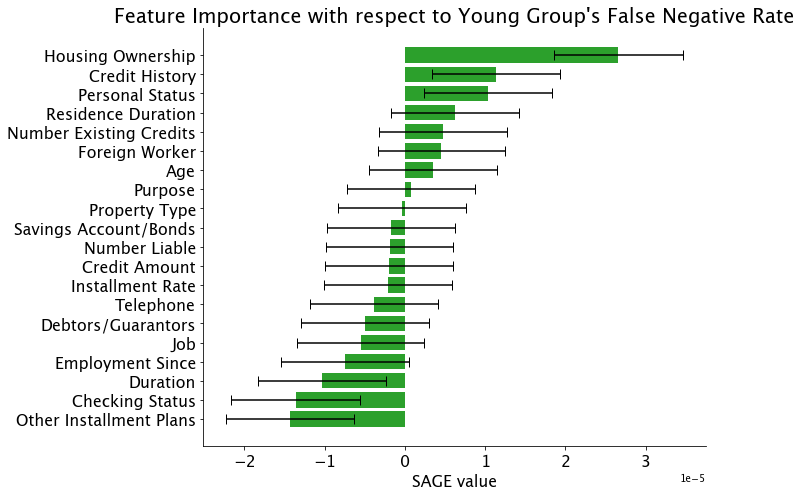

In [13]:
sage_values_young_fnr.plot(feature_names, title='Feature Importance with respect to Young Group\'s False Negative Rate')

# Old group FNR

In [14]:
where_old_train = train[:,age_col] > 30
where_old_test = np.invert(where_young_test)

test_old = test[where_old_test]
Y_test_old = Y_test[where_old_test]

In [15]:
# Setup and calculate with custom fairness-related loss function
imputer_old = sage.MarginalImputer(model, train[where_old_train])
estimator_old_fnr = sage.PermutationEstimator(imputer_old, 'fnr')
%time sage_values_old_fnr = estimator_old_fnr(test_old, Y_test_old, verbose=True, thresh=0.1)

# Print results
print("SAGE values using false negative rate as loss:", sage_values_old_fnr)

  0%|          | 0/1 [00:00<?, ?it/s]

fn = 0, p = 408, fnr = 0.0
===> Iteration 0, Prev loss = 0.0 [outer loop]
fn = 0, p = 408, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 408, fnr = 0.0024509803921568627
	Loss = 0.0024509803921568627 [inner loop]
fn = 1, p = 408, fnr = 0.0024509803921568627
	Loss = 0.0024509803921568627 [inner loop]
fn = 3, p = 408, fnr = 0.007352941176470588
	Loss = 0.007352941176470588 [inner loop]
fn = 3, p = 408, fnr = 0.007352941176470588
	Loss = 0.007352941176470588 [inner loop]
fn = 5, p = 408, fnr = 0.012254901960784314
	Loss = 0.012254901960784314 [inner loop]
fn = 7, p = 408, fnr = 0.01715686274509804
	Loss = 0.01715686274509804 [inner loop]
fn = 6, p = 408, fnr = 0.014705882352941176
	Loss = 0.014705882352941176 [inner loop]
fn = 8, p = 408, fnr = 0.0196078431372549
	Loss = 0.0196078431372549 [inner loop]
fn = 10, p = 408, fnr = 0.024509803921568627
	Loss = 0.024509803921568627 [inner loop]
fn = 12, p = 408, fnr = 0.029411764705882353
	Loss = 0.029411764705882353 [inner loop]
fn = 14, p = 4

fn = 0, p = 399, fnr = 0.0
===> Iteration 5, Prev loss = 0.0 [outer loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 399, fnr = 0.002506265664160401
	Loss = 0.002506265664160401 [inner loop]
fn = 4, p = 399, fnr = 0.010025062656641603
	Loss = 0.010025062656641603 [inner loop]
fn = 4, p = 399, fnr = 0.010025062656641603
	Loss = 0.010025062656641603 [inner loop]
fn = 4, p = 399, fnr = 0.010025062656641603
	Loss = 0.010025062656641603 [inner loop]
fn = 8, p = 399, fnr = 0.020050125313283207
	Loss = 0.020050125313283207 [inner loop]
fn = 11, p = 399, fnr = 0.02756892230576441
	Loss = 0.02756892230576441 [inner loop]
fn = 15, p = 399, fnr = 0.03759398496240601
	Loss = 0.03759398496240601 [inner loop]
fn = 15, p = 399, fnr = 0.03759398496240601
	Loss = 0.03759398496240601 [inner loop]
fn = 18, p = 399, fnr = 0.045112781954887216
	Loss = 0.045112781954887216 [inner loop]
fn = 14, p = 399, fnr = 0.03508771929824561
	Loss 

fn = 16, p = 392, fnr = 0.04081632653061224
	Loss = 0.04081632653061224 [inner loop]
fn = 15, p = 392, fnr = 0.03826530612244898
	Loss = 0.03826530612244898 [inner loop]
fn = 19, p = 392, fnr = 0.04846938775510204
	Loss = 0.04846938775510204 [inner loop]
StdDev Ratio = 0.2754 (Converge at 0.1000)
fn = 0, p = 397, fnr = 0.0
===> Iteration 10, Prev loss = 0.0 [outer loop]
fn = 0, p = 397, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 397, fnr = 0.0025188916876574307
	Loss = 0.0025188916876574307 [inner loop]
fn = 1, p = 397, fnr = 0.0025188916876574307
	Loss = 0.0025188916876574307 [inner loop]
fn = 1, p = 397, fnr = 0.0025188916876574307
	Loss = 0.0025188916876574307 [inner loop]
fn = 1, p = 397, fnr = 0.0025188916876574307
	Loss = 0.0025188916876574307 [inner loop]
fn = 3, p = 397, fnr = 0.007556675062972292
	Loss = 0.007556675062972292 [inner loop]
fn = 3, p = 397, fnr = 0.007556675062972292
	Loss = 0.007556675062972292 [inner loop]
fn = 6, p = 397, fnr = 0.015113350125944584
	Loss =

fn = 12, p = 403, fnr = 0.02977667493796526
	Loss = 0.02977667493796526 [inner loop]
fn = 15, p = 403, fnr = 0.03722084367245657
	Loss = 0.03722084367245657 [inner loop]
fn = 16, p = 403, fnr = 0.03970223325062035
	Loss = 0.03970223325062035 [inner loop]
fn = 19, p = 403, fnr = 0.04714640198511166
	Loss = 0.04714640198511166 [inner loop]
fn = 17, p = 403, fnr = 0.04218362282878412
	Loss = 0.04218362282878412 [inner loop]
fn = 22, p = 403, fnr = 0.05459057071960298
	Loss = 0.05459057071960298 [inner loop]
fn = 18, p = 403, fnr = 0.04466501240694789
	Loss = 0.04466501240694789 [inner loop]
StdDev Ratio = 0.3502 (Converge at 0.1000)
fn = 0, p = 394, fnr = 0.0
===> Iteration 15, Prev loss = 0.0 [outer loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 394, fnr = 0.0025380710659898475
	Loss = 0.0025380710659898475 [inner loop]
fn = 1, p = 394, fnr = 0.002538071065989847

fn = 11, p = 413, fnr = 0.026634382566585957
	Loss = 0.026634382566585957 [inner loop]
fn = 10, p = 413, fnr = 0.024213075060532687
	Loss = 0.024213075060532687 [inner loop]
fn = 9, p = 413, fnr = 0.021791767554479417
	Loss = 0.021791767554479417 [inner loop]
fn = 13, p = 413, fnr = 0.031476997578692496
	Loss = 0.031476997578692496 [inner loop]
fn = 15, p = 413, fnr = 0.03631961259079903
	Loss = 0.03631961259079903 [inner loop]
fn = 18, p = 413, fnr = 0.043583535108958835
	Loss = 0.043583535108958835 [inner loop]
fn = 21, p = 413, fnr = 0.05084745762711865
	Loss = 0.05084745762711865 [inner loop]
fn = 21, p = 413, fnr = 0.05084745762711865
	Loss = 0.05084745762711865 [inner loop]
fn = 19, p = 413, fnr = 0.04600484261501211
	Loss = 0.04600484261501211 [inner loop]
fn = 22, p = 413, fnr = 0.053268765133171914
	Loss = 0.053268765133171914 [inner loop]
StdDev Ratio = 0.2904 (Converge at 0.1000)
fn = 0, p = 397, fnr = 0.0
===> Iteration 20, Prev loss = 0.0 [outer loop]
fn = 0, p = 397, fnr 

fn = 1, p = 399, fnr = 0.002506265664160401
	Loss = 0.002506265664160401 [inner loop]
fn = 2, p = 399, fnr = 0.005012531328320802
	Loss = 0.005012531328320802 [inner loop]
fn = 3, p = 399, fnr = 0.007518796992481203
	Loss = 0.007518796992481203 [inner loop]
fn = 6, p = 399, fnr = 0.015037593984962405
	Loss = 0.015037593984962405 [inner loop]
fn = 10, p = 399, fnr = 0.02506265664160401
	Loss = 0.02506265664160401 [inner loop]
fn = 8, p = 399, fnr = 0.020050125313283207
	Loss = 0.020050125313283207 [inner loop]
fn = 10, p = 399, fnr = 0.02506265664160401
	Loss = 0.02506265664160401 [inner loop]
fn = 14, p = 399, fnr = 0.03508771929824561
	Loss = 0.03508771929824561 [inner loop]
fn = 17, p = 399, fnr = 0.042606516290726815
	Loss = 0.042606516290726815 [inner loop]
fn = 16, p = 399, fnr = 0.040100250626566414
	Loss = 0.040100250626566414 [inner loop]
fn = 18, p = 399, fnr = 0.045112781954887216
	Loss = 0.045112781954887216 [inner loop]
fn = 18, p = 399, fnr = 0.045112781954887216
	Loss = 0

fn = 0, p = 401, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 401, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 401, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 401, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 401, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 401, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 401, fnr = 0.0024937655860349127
	Loss = 0.0024937655860349127 [inner loop]
fn = 2, p = 401, fnr = 0.004987531172069825
	Loss = 0.004987531172069825 [inner loop]
fn = 1, p = 401, fnr = 0.0024937655860349127
	Loss = 0.0024937655860349127 [inner loop]
fn = 2, p = 401, fnr = 0.004987531172069825
	Loss = 0.004987531172069825 [inner loop]
fn = 6, p = 401, fnr = 0.014962593516209476
	Loss = 0.014962593516209476 [inner loop]
fn = 9, p = 401, fnr = 0.022443890274314215
	Loss = 0.022443890274314215 [inner loop]
fn = 10, p = 401, fnr = 0.02493765586034913
	Loss = 0.02493765586034913 [inner loop]
fn = 14, p = 401, fnr = 0.034912718204488775
	Loss = 0.034912718204488775 [inner lo

fn = 21, p = 391, fnr = 0.05370843989769821
	Loss = 0.05370843989769821 [inner loop]
StdDev Ratio = 0.2479 (Converge at 0.1000)
fn = 0, p = 387, fnr = 0.0
===> Iteration 34, Prev loss = 0.0 [outer loop]
fn = 0, p = 387, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 387, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 387, fnr = 0.002583979328165375
	Loss = 0.002583979328165375 [inner loop]
fn = 3, p = 387, fnr = 0.007751937984496124
	Loss = 0.007751937984496124 [inner loop]
fn = 3, p = 387, fnr = 0.007751937984496124
	Loss = 0.007751937984496124 [inner loop]
fn = 3, p = 387, fnr = 0.007751937984496124
	Loss = 0.007751937984496124 [inner loop]
fn = 5, p = 387, fnr = 0.012919896640826873
	Loss = 0.012919896640826873 [inner loop]
fn = 5, p = 387, fnr = 0.012919896640826873
	Loss = 0.012919896640826873 [inner loop]
fn = 5, p = 387, fnr = 0.012919896640826873
	Loss = 0.012919896640826873 [inner loop]
fn = 11, p = 387, fnr = 0.028423772609819122
	Loss = 0.028423772609819122 [inner loop]
fn =

fn = 20, p = 391, fnr = 0.05115089514066496
	Loss = 0.05115089514066496 [inner loop]
fn = 23, p = 391, fnr = 0.058823529411764705
	Loss = 0.058823529411764705 [inner loop]
fn = 27, p = 391, fnr = 0.06905370843989769
	Loss = 0.06905370843989769 [inner loop]
fn = 30, p = 391, fnr = 0.07672634271099744
	Loss = 0.07672634271099744 [inner loop]
fn = 33, p = 391, fnr = 0.08439897698209718
	Loss = 0.08439897698209718 [inner loop]
fn = 31, p = 391, fnr = 0.0792838874680307
	Loss = 0.0792838874680307 [inner loop]
StdDev Ratio = 0.2551 (Converge at 0.1000)
fn = 0, p = 389, fnr = 0.0
===> Iteration 39, Prev loss = 0.0 [outer loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 389, fnr = 0.002570694087403599
	Loss = 0.002570694087403599 [inner loop]
fn = 1, p = 389, fnr = 0.002570694087403599
	Loss = 0.002570694087403599 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inne

fn = 8, p = 406, fnr = 0.019704433497536946
	Loss = 0.019704433497536946 [inner loop]
fn = 9, p = 406, fnr = 0.022167487684729065
	Loss = 0.022167487684729065 [inner loop]
fn = 14, p = 406, fnr = 0.034482758620689655
	Loss = 0.034482758620689655 [inner loop]
fn = 17, p = 406, fnr = 0.04187192118226601
	Loss = 0.04187192118226601 [inner loop]
fn = 18, p = 406, fnr = 0.04433497536945813
	Loss = 0.04433497536945813 [inner loop]
fn = 23, p = 406, fnr = 0.05665024630541872
	Loss = 0.05665024630541872 [inner loop]
fn = 21, p = 406, fnr = 0.05172413793103448
	Loss = 0.05172413793103448 [inner loop]
fn = 28, p = 406, fnr = 0.06896551724137931
	Loss = 0.06896551724137931 [inner loop]
fn = 30, p = 406, fnr = 0.07389162561576355
	Loss = 0.07389162561576355 [inner loop]
fn = 26, p = 406, fnr = 0.06403940886699508
	Loss = 0.06403940886699508 [inner loop]
StdDev Ratio = 0.2524 (Converge at 0.1000)
fn = 0, p = 414, fnr = 0.0
===> Iteration 44, Prev loss = 0.0 [outer loop]
fn = 0, p = 414, fnr = 0.0
	

fn = 2, p = 403, fnr = 0.004962779156327543
	Loss = 0.004962779156327543 [inner loop]
fn = 2, p = 403, fnr = 0.004962779156327543
	Loss = 0.004962779156327543 [inner loop]
fn = 1, p = 403, fnr = 0.0024813895781637717
	Loss = 0.0024813895781637717 [inner loop]
fn = 4, p = 403, fnr = 0.009925558312655087
	Loss = 0.009925558312655087 [inner loop]
fn = 5, p = 403, fnr = 0.01240694789081886
	Loss = 0.01240694789081886 [inner loop]
fn = 8, p = 403, fnr = 0.019851116625310174
	Loss = 0.019851116625310174 [inner loop]
fn = 7, p = 403, fnr = 0.017369727047146403
	Loss = 0.017369727047146403 [inner loop]
fn = 9, p = 403, fnr = 0.022332506203473945
	Loss = 0.022332506203473945 [inner loop]
fn = 12, p = 403, fnr = 0.02977667493796526
	Loss = 0.02977667493796526 [inner loop]
fn = 11, p = 403, fnr = 0.02729528535980149
	Loss = 0.02729528535980149 [inner loop]
fn = 12, p = 403, fnr = 0.02977667493796526
	Loss = 0.02977667493796526 [inner loop]
fn = 11, p = 403, fnr = 0.02729528535980149
	Loss = 0.027

fn = 0, p = 407, fnr = 0.0
===> Iteration 53, Prev loss = 0.0 [outer loop]
fn = 0, p = 407, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 407, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 407, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 407, fnr = 0.004914004914004914
	Loss = 0.004914004914004914 [inner loop]
fn = 2, p = 407, fnr = 0.004914004914004914
	Loss = 0.004914004914004914 [inner loop]
fn = 3, p = 407, fnr = 0.007371007371007371
	Loss = 0.007371007371007371 [inner loop]
fn = 3, p = 407, fnr = 0.007371007371007371
	Loss = 0.007371007371007371 [inner loop]
fn = 4, p = 407, fnr = 0.009828009828009828
	Loss = 0.009828009828009828 [inner loop]
fn = 5, p = 407, fnr = 0.012285012285012284
	Loss = 0.012285012285012284 [inner loop]
fn = 9, p = 407, fnr = 0.022113022113022112
	Loss = 0.022113022113022112 [inner loop]
fn = 9, p = 407, fnr = 0.022113022113022112
	Loss = 0.022113022113022112 [inner loop]
fn = 13, p = 407, fnr = 0.03194103194103194
	Loss = 0.03194103194103194 [inner lo

fn = 26, p = 403, fnr = 0.06451612903225806
	Loss = 0.06451612903225806 [inner loop]
fn = 24, p = 403, fnr = 0.05955334987593052
	Loss = 0.05955334987593052 [inner loop]
fn = 23, p = 403, fnr = 0.05707196029776675
	Loss = 0.05707196029776675 [inner loop]
StdDev Ratio = 0.2428 (Converge at 0.1000)
fn = 0, p = 397, fnr = 0.0
===> Iteration 58, Prev loss = 0.0 [outer loop]
fn = 0, p = 397, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 397, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 397, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 397, fnr = 0.005037783375314861
	Loss = 0.005037783375314861 [inner loop]
fn = 4, p = 397, fnr = 0.010075566750629723
	Loss = 0.010075566750629723 [inner loop]
fn = 3, p = 397, fnr = 0.007556675062972292
	Loss = 0.007556675062972292 [inner loop]
fn = 5, p = 397, fnr = 0.012594458438287154
	Loss = 0.012594458438287154 [inner loop]
fn = 7, p = 397, fnr = 0.017632241813602016
	Loss = 0.017632241813602016 [inner loop]
fn = 11, p = 397, fnr = 0.027707808564231

fn = 11, p = 407, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 11, p = 407, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 12, p = 407, fnr = 0.029484029484029485
	Loss = 0.029484029484029485 [inner loop]
fn = 19, p = 407, fnr = 0.04668304668304668
	Loss = 0.04668304668304668 [inner loop]
fn = 21, p = 407, fnr = 0.051597051597051594
	Loss = 0.051597051597051594 [inner loop]
fn = 25, p = 407, fnr = 0.06142506142506143
	Loss = 0.06142506142506143 [inner loop]
fn = 28, p = 407, fnr = 0.0687960687960688
	Loss = 0.0687960687960688 [inner loop]
fn = 25, p = 407, fnr = 0.06142506142506143
	Loss = 0.06142506142506143 [inner loop]
StdDev Ratio = 0.2426 (Converge at 0.1000)
fn = 0, p = 396, fnr = 0.0
===> Iteration 63, Prev loss = 0.0 [outer loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inne

fn = 10, p = 393, fnr = 0.02544529262086514
	Loss = 0.02544529262086514 [inner loop]
fn = 12, p = 393, fnr = 0.030534351145038167
	Loss = 0.030534351145038167 [inner loop]
fn = 13, p = 393, fnr = 0.03307888040712468
	Loss = 0.03307888040712468 [inner loop]
fn = 13, p = 393, fnr = 0.03307888040712468
	Loss = 0.03307888040712468 [inner loop]
fn = 15, p = 393, fnr = 0.03816793893129771
	Loss = 0.03816793893129771 [inner loop]
fn = 17, p = 393, fnr = 0.043256997455470736
	Loss = 0.043256997455470736 [inner loop]
fn = 19, p = 393, fnr = 0.04834605597964377
	Loss = 0.04834605597964377 [inner loop]
fn = 21, p = 393, fnr = 0.05343511450381679
	Loss = 0.05343511450381679 [inner loop]
fn = 27, p = 393, fnr = 0.06870229007633588
	Loss = 0.06870229007633588 [inner loop]
fn = 28, p = 393, fnr = 0.07124681933842239
	Loss = 0.07124681933842239 [inner loop]
fn = 23, p = 393, fnr = 0.058524173027989825
	Loss = 0.058524173027989825 [inner loop]
StdDev Ratio = 0.2345 (Converge at 0.1000)
fn = 0, p = 403,

fn = 3, p = 405, fnr = 0.007407407407407408
	Loss = 0.007407407407407408 [inner loop]
fn = 2, p = 405, fnr = 0.0049382716049382715
	Loss = 0.0049382716049382715 [inner loop]
fn = 4, p = 405, fnr = 0.009876543209876543
	Loss = 0.009876543209876543 [inner loop]
fn = 4, p = 405, fnr = 0.009876543209876543
	Loss = 0.009876543209876543 [inner loop]
fn = 6, p = 405, fnr = 0.014814814814814815
	Loss = 0.014814814814814815 [inner loop]
fn = 7, p = 405, fnr = 0.01728395061728395
	Loss = 0.01728395061728395 [inner loop]
fn = 11, p = 405, fnr = 0.027160493827160494
	Loss = 0.027160493827160494 [inner loop]
fn = 14, p = 405, fnr = 0.0345679012345679
	Loss = 0.0345679012345679 [inner loop]
fn = 17, p = 405, fnr = 0.04197530864197531
	Loss = 0.04197530864197531 [inner loop]
fn = 20, p = 405, fnr = 0.04938271604938271
	Loss = 0.04938271604938271 [inner loop]
fn = 21, p = 405, fnr = 0.05185185185185185
	Loss = 0.05185185185185185 [inner loop]
fn = 22, p = 405, fnr = 0.05432098765432099
	Loss = 0.05432

fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 402, fnr = 0.0024875621890547263
	Loss = 0.0024875621890547263 [inner loop]
fn = 3, p = 402, fnr = 0.007462686567164179
	Loss = 0.007462686567164179 [inner loop]
fn = 4, p = 402, fnr = 0.009950248756218905
	Loss = 0.009950248756218905 [inner loop]
fn = 6, p = 402, fnr = 0.014925373134328358
	Loss = 0.014925373134328358 [inner loop]
fn = 7, p = 402, fnr = 0.017412935323383085
	Loss = 0.017412935323383085 [inner loop]
fn = 7, p = 402, fnr = 0.017412935323383085
	Loss = 0.017412935323383085 [inner loop]
fn = 8, p = 402, fnr = 0.01990049751243781
	Loss = 0.01990049751243781 [inner loop]
fn = 8, p = 402, fnr = 0.01990049751243781
	Loss = 0.01990049751243781 [inner loop]
fn = 11, p = 402, fnr = 0.02736318407960199
	Loss = 0.02736318407960199 [inner loop]
fn = 14, p = 402, fnr

fn = 24, p = 411, fnr = 0.058394160583941604
	Loss = 0.058394160583941604 [inner loop]
fn = 23, p = 411, fnr = 0.05596107055961071
	Loss = 0.05596107055961071 [inner loop]
StdDev Ratio = 0.2214 (Converge at 0.1000)
fn = 0, p = 419, fnr = 0.0
===> Iteration 82, Prev loss = 0.0 [outer loop]
fn = 0, p = 419, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 419, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 419, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 419, fnr = 0.00477326968973747
	Loss = 0.00477326968973747 [inner loop]
fn = 3, p = 419, fnr = 0.007159904534606206
	Loss = 0.007159904534606206 [inner loop]
fn = 5, p = 419, fnr = 0.011933174224343675
	Loss = 0.011933174224343675 [inner loop]
fn = 5, p = 419, fnr = 0.011933174224343675
	Loss = 0.011933174224343675 [inner loop]
fn = 5, p = 419, fnr = 0.011933174224343675
	Loss = 0.011933174224343675 [inner loop]
fn = 4, p = 419, fnr = 0.00954653937947494
	Loss = 0.00954653937947494 [inner loop]
fn = 8, p = 419, fnr = 0.01909307875894988

fn = 0, p = 410, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 410, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 410, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 410, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 410, fnr = 0.004878048780487805
	Loss = 0.004878048780487805 [inner loop]
fn = 2, p = 410, fnr = 0.004878048780487805
	Loss = 0.004878048780487805 [inner loop]
fn = 3, p = 410, fnr = 0.007317073170731708
	Loss = 0.007317073170731708 [inner loop]
fn = 4, p = 410, fnr = 0.00975609756097561
	Loss = 0.00975609756097561 [inner loop]
fn = 7, p = 410, fnr = 0.01707317073170732
	Loss = 0.01707317073170732 [inner loop]
fn = 9, p = 410, fnr = 0.02195121951219512
	Loss = 0.02195121951219512 [inner loop]
fn = 12, p = 410, fnr = 0.02926829268292683
	Loss = 0.02926829268292683 [inner loop]
fn = 15, p = 410, fnr = 0.036585365853658534
	Loss = 0.036585365853658534 [inner loop]
fn = 15, p = 410, fnr = 0.036585365853658534
	Loss = 0.036585365853658534 [inner loop]
fn = 18, p = 410, fnr =

fn = 19, p = 396, fnr = 0.047979797979797977
	Loss = 0.047979797979797977 [inner loop]
fn = 20, p = 396, fnr = 0.050505050505050504
	Loss = 0.050505050505050504 [inner loop]
fn = 21, p = 396, fnr = 0.05303030303030303
	Loss = 0.05303030303030303 [inner loop]
fn = 22, p = 396, fnr = 0.05555555555555555
	Loss = 0.05555555555555555 [inner loop]
StdDev Ratio = 0.2371 (Converge at 0.1000)
fn = 0, p = 400, fnr = 0.0
===> Iteration 92, Prev loss = 0.0 [outer loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inner loop]
fn = 6, p = 400, fnr = 0.015
	Loss = 0.015 [inner loop]
fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inner loop]
fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inne

fn = 22, p = 404, fnr = 0.054455445544554455
	Loss = 0.054455445544554455 [inner loop]
fn = 26, p = 404, fnr = 0.06435643564356436
	Loss = 0.06435643564356436 [inner loop]
fn = 23, p = 404, fnr = 0.05693069306930693
	Loss = 0.05693069306930693 [inner loop]
StdDev Ratio = 0.2395 (Converge at 0.1000)
fn = 0, p = 400, fnr = 0.0
===> Iteration 97, Prev loss = 0.0 [outer loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 3, p = 400, fnr = 0.0075
	Loss = 0.0075 [inner loop]
fn = 4, p = 400, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 5, p = 400, fnr = 0.0125
	Loss = 0.0125 [inner loop]
fn = 8, p = 400, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 12, p = 400, fnr = 0.03
	Loss = 0.03 [inner loop]
fn = 13, p = 400

fn = 18, p = 415, fnr = 0.043373493975903614
	Loss = 0.043373493975903614 [inner loop]
StdDev Ratio = 0.2399 (Converge at 0.1000)
fn = 0, p = 402, fnr = 0.0
===> Iteration 102, Prev loss = 0.0 [outer loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 402, fnr = 0.004975124378109453
	Loss = 0.004975124378109453 [inner loop]
fn = 3, p = 402, fnr = 0.007462686567164179
	Loss = 0.007462686567164179 [inner loop]
fn = 6, p = 402, fnr = 0.014925373134328358
	Loss = 0.014925373134328358 [inner loop]
fn = 7, p = 402, fnr = 0.017412935323383085
	Loss = 0.017412935323383085 [inner loop]
fn = 7, p = 402, fnr = 0.017412935323383085
	Loss = 0.017412935323383085 [inner loop]
fn = 7, p = 402, fnr = 0.017412935323383085
	Loss = 0.017412935323383085 [inner loop]
fn = 8, p = 402, fnr = 0.01990049751243781
	Loss = 0.01990049751243781

fn = 10, p = 402, fnr = 0.024875621890547265
	Loss = 0.024875621890547265 [inner loop]
fn = 12, p = 402, fnr = 0.029850746268656716
	Loss = 0.029850746268656716 [inner loop]
fn = 14, p = 402, fnr = 0.03482587064676617
	Loss = 0.03482587064676617 [inner loop]
fn = 13, p = 402, fnr = 0.03233830845771144
	Loss = 0.03233830845771144 [inner loop]
fn = 14, p = 402, fnr = 0.03482587064676617
	Loss = 0.03482587064676617 [inner loop]
fn = 18, p = 402, fnr = 0.04477611940298507
	Loss = 0.04477611940298507 [inner loop]
fn = 21, p = 402, fnr = 0.05223880597014925
	Loss = 0.05223880597014925 [inner loop]
fn = 21, p = 402, fnr = 0.05223880597014925
	Loss = 0.05223880597014925 [inner loop]
fn = 19, p = 402, fnr = 0.0472636815920398
	Loss = 0.0472636815920398 [inner loop]
StdDev Ratio = 0.2405 (Converge at 0.1000)
fn = 0, p = 390, fnr = 0.0
===> Iteration 107, Prev loss = 0.0 [outer loop]
fn = 0, p = 390, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 390, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p 

fn = 12, p = 408, fnr = 0.029411764705882353
	Loss = 0.029411764705882353 [inner loop]
fn = 14, p = 408, fnr = 0.03431372549019608
	Loss = 0.03431372549019608 [inner loop]
fn = 16, p = 408, fnr = 0.0392156862745098
	Loss = 0.0392156862745098 [inner loop]
fn = 19, p = 408, fnr = 0.04656862745098039
	Loss = 0.04656862745098039 [inner loop]
fn = 19, p = 408, fnr = 0.04656862745098039
	Loss = 0.04656862745098039 [inner loop]
fn = 20, p = 408, fnr = 0.049019607843137254
	Loss = 0.049019607843137254 [inner loop]
fn = 20, p = 408, fnr = 0.049019607843137254
	Loss = 0.049019607843137254 [inner loop]
fn = 21, p = 408, fnr = 0.051470588235294115
	Loss = 0.051470588235294115 [inner loop]
StdDev Ratio = 0.2394 (Converge at 0.1000)
fn = 0, p = 402, fnr = 0.0
===> Iteration 112, Prev loss = 0.0 [outer loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 

fn = 3, p = 405, fnr = 0.007407407407407408
	Loss = 0.007407407407407408 [inner loop]
fn = 4, p = 405, fnr = 0.009876543209876543
	Loss = 0.009876543209876543 [inner loop]
fn = 7, p = 405, fnr = 0.01728395061728395
	Loss = 0.01728395061728395 [inner loop]
fn = 8, p = 405, fnr = 0.019753086419753086
	Loss = 0.019753086419753086 [inner loop]
fn = 13, p = 405, fnr = 0.03209876543209877
	Loss = 0.03209876543209877 [inner loop]
fn = 17, p = 405, fnr = 0.04197530864197531
	Loss = 0.04197530864197531 [inner loop]
fn = 17, p = 405, fnr = 0.04197530864197531
	Loss = 0.04197530864197531 [inner loop]
fn = 17, p = 405, fnr = 0.04197530864197531
	Loss = 0.04197530864197531 [inner loop]
fn = 18, p = 405, fnr = 0.044444444444444446
	Loss = 0.044444444444444446 [inner loop]
fn = 19, p = 405, fnr = 0.04691358024691358
	Loss = 0.04691358024691358 [inner loop]
fn = 24, p = 405, fnr = 0.05925925925925926
	Loss = 0.05925925925925926 [inner loop]
fn = 28, p = 405, fnr = 0.0691358024691358
	Loss = 0.06913580

fn = 0, p = 392, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 392, fnr = 0.002551020408163265
	Loss = 0.002551020408163265 [inner loop]
fn = 1, p = 392, fnr = 0.002551020408163265
	Loss = 0.002551020408163265 [inner loop]
fn = 1, p = 392, fnr = 0.002551020408163265
	Loss = 0.002551020408163265 [inner loop]
fn = 1, p = 392, fnr = 0.002551020408163265
	Loss = 0.002551020408163265 [inner loop]
fn = 1, p = 392, fnr = 0.002551020408163265
	Loss = 0.002551020408163265 [inner loop]
fn = 1, p = 392, fnr = 0.002551020408163265
	Loss = 0.002551020408163265 [inner loop]
fn = 2, p = 392, fnr = 0.00510204081632653
	Loss = 0.00510204081632653 [inner loop]
fn = 5, p = 392, fnr = 0.012755102040816327
	Loss = 0.012755102040816327 [inner loop]
fn = 5, p = 392, fnr = 0.012755102040816327
	Loss = 0.012755102040816327 [inner loop]
fn = 6, p = 392, fnr = 0.015306122448979591
	Loss = 0.015306122448979591 [inner loop]
fn = 7, p = 392, fnr = 0.017857142857142856
	Loss = 0.017857142857142856 [inner loop]
fn =

fn = 16, p = 405, fnr = 0.03950617283950617
	Loss = 0.03950617283950617 [inner loop]
fn = 16, p = 405, fnr = 0.03950617283950617
	Loss = 0.03950617283950617 [inner loop]
fn = 18, p = 405, fnr = 0.044444444444444446
	Loss = 0.044444444444444446 [inner loop]
fn = 23, p = 405, fnr = 0.056790123456790124
	Loss = 0.056790123456790124 [inner loop]
fn = 23, p = 405, fnr = 0.056790123456790124
	Loss = 0.056790123456790124 [inner loop]
StdDev Ratio = 0.2550 (Converge at 0.1000)
fn = 0, p = 383, fnr = 0.0
===> Iteration 126, Prev loss = 0.0 [outer loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 383, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 383, fnr = 0.0026109660574412533
	Loss = 0.0026109660574412533 [inner loop]
fn = 3, p = 383, fnr = 0.007832898172323759
	Loss = 0.007832898172323759 [inner loop]
fn = 4, p = 383, fnr = 0.010443864229765013
	Loss = 0.010443864229765013 [inner loop]
fn = 4, p = 383, fnr = 0.010443864229765013
	Loss = 0.010443864229765013 [inner loop]


fn = 7, p = 414, fnr = 0.016908212560386472
	Loss = 0.016908212560386472 [inner loop]
fn = 9, p = 414, fnr = 0.021739130434782608
	Loss = 0.021739130434782608 [inner loop]
fn = 11, p = 414, fnr = 0.026570048309178744
	Loss = 0.026570048309178744 [inner loop]
fn = 12, p = 414, fnr = 0.028985507246376812
	Loss = 0.028985507246376812 [inner loop]
fn = 11, p = 414, fnr = 0.026570048309178744
	Loss = 0.026570048309178744 [inner loop]
fn = 14, p = 414, fnr = 0.033816425120772944
	Loss = 0.033816425120772944 [inner loop]
fn = 16, p = 414, fnr = 0.03864734299516908
	Loss = 0.03864734299516908 [inner loop]
fn = 17, p = 414, fnr = 0.04106280193236715
	Loss = 0.04106280193236715 [inner loop]
fn = 22, p = 414, fnr = 0.05314009661835749
	Loss = 0.05314009661835749 [inner loop]
fn = 23, p = 414, fnr = 0.05555555555555555
	Loss = 0.05555555555555555 [inner loop]
fn = 23, p = 414, fnr = 0.05555555555555555
	Loss = 0.05555555555555555 [inner loop]
StdDev Ratio = 0.2802 (Converge at 0.1000)
fn = 0, p = 

fn = 3, p = 414, fnr = 0.007246376811594203
	Loss = 0.007246376811594203 [inner loop]
fn = 1, p = 414, fnr = 0.0024154589371980675
	Loss = 0.0024154589371980675 [inner loop]
fn = 2, p = 414, fnr = 0.004830917874396135
	Loss = 0.004830917874396135 [inner loop]
fn = 4, p = 414, fnr = 0.00966183574879227
	Loss = 0.00966183574879227 [inner loop]
fn = 6, p = 414, fnr = 0.014492753623188406
	Loss = 0.014492753623188406 [inner loop]
fn = 7, p = 414, fnr = 0.016908212560386472
	Loss = 0.016908212560386472 [inner loop]
fn = 5, p = 414, fnr = 0.012077294685990338
	Loss = 0.012077294685990338 [inner loop]
fn = 8, p = 414, fnr = 0.01932367149758454
	Loss = 0.01932367149758454 [inner loop]
fn = 8, p = 414, fnr = 0.01932367149758454
	Loss = 0.01932367149758454 [inner loop]
fn = 12, p = 414, fnr = 0.028985507246376812
	Loss = 0.028985507246376812 [inner loop]
fn = 13, p = 414, fnr = 0.03140096618357488
	Loss = 0.03140096618357488 [inner loop]
fn = 16, p = 414, fnr = 0.03864734299516908
	Loss = 0.0386

fn = 22, p = 410, fnr = 0.05365853658536585
	Loss = 0.05365853658536585 [inner loop]
StdDev Ratio = 0.2962 (Converge at 0.1000)
fn = 0, p = 396, fnr = 0.0
===> Iteration 140, Prev loss = 0.0 [outer loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 396, fnr = 0.0025252525252525255
	Loss = 0.0025252525252525255 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 1, p = 396, fnr = 0.0025252525252525255
	Loss = 0.0025252525252525255 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 3, p = 396, fnr = 0.007575757575757576
	Loss = 0.007575757575757576 [inner loop]
fn = 4, p = 396, fnr = 0.010101010101010102
	Loss = 0.01010101010101

fn = 17, p = 382, fnr = 0.04450261780104712
	Loss = 0.04450261780104712 [inner loop]
fn = 19, p = 382, fnr = 0.049738219895287955
	Loss = 0.049738219895287955 [inner loop]
fn = 21, p = 382, fnr = 0.0549738219895288
	Loss = 0.0549738219895288 [inner loop]
fn = 24, p = 382, fnr = 0.06282722513089005
	Loss = 0.06282722513089005 [inner loop]
StdDev Ratio = 0.2849 (Converge at 0.1000)
fn = 0, p = 406, fnr = 0.0
===> Iteration 145, Prev loss = 0.0 [outer loop]
fn = 0, p = 406, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 406, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 406, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 406, fnr = 0.0024630541871921183
	Loss = 0.0024630541871921183 [inner loop]
fn = 1, p = 406, fnr = 0.0024630541871921183
	Loss = 0.0024630541871921183 [inner loop]
fn = 1, p = 406, fnr = 0.0024630541871921183
	Loss = 0.0024630541871921183 [inner loop]
fn = 1, p = 406, fnr = 0.0024630541871921183
	Loss = 0.0024630541871921183 [inner loop]
fn = 5, p = 406, fnr = 0.01231527

fn = 10, p = 396, fnr = 0.025252525252525252
	Loss = 0.025252525252525252 [inner loop]
fn = 9, p = 396, fnr = 0.022727272727272728
	Loss = 0.022727272727272728 [inner loop]
fn = 11, p = 396, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 17, p = 396, fnr = 0.04292929292929293
	Loss = 0.04292929292929293 [inner loop]
fn = 21, p = 396, fnr = 0.05303030303030303
	Loss = 0.05303030303030303 [inner loop]
fn = 22, p = 396, fnr = 0.05555555555555555
	Loss = 0.05555555555555555 [inner loop]
fn = 24, p = 396, fnr = 0.06060606060606061
	Loss = 0.06060606060606061 [inner loop]
fn = 22, p = 396, fnr = 0.05555555555555555
	Loss = 0.05555555555555555 [inner loop]
fn = 23, p = 396, fnr = 0.05808080808080808
	Loss = 0.05808080808080808 [inner loop]
fn = 22, p = 396, fnr = 0.05555555555555555
	Loss = 0.05555555555555555 [inner loop]
StdDev Ratio = 0.2959 (Converge at 0.1000)
fn = 0, p = 408, fnr = 0.0
===> Iteration 150, Prev loss = 0.0 [outer loop]
fn = 0, p = 408, fnr = 0.0

fn = 7, p = 396, fnr = 0.017676767676767676
	Loss = 0.017676767676767676 [inner loop]
fn = 7, p = 396, fnr = 0.017676767676767676
	Loss = 0.017676767676767676 [inner loop]
fn = 9, p = 396, fnr = 0.022727272727272728
	Loss = 0.022727272727272728 [inner loop]
fn = 11, p = 396, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 12, p = 396, fnr = 0.030303030303030304
	Loss = 0.030303030303030304 [inner loop]
fn = 14, p = 396, fnr = 0.03535353535353535
	Loss = 0.03535353535353535 [inner loop]
fn = 15, p = 396, fnr = 0.03787878787878788
	Loss = 0.03787878787878788 [inner loop]
fn = 17, p = 396, fnr = 0.04292929292929293
	Loss = 0.04292929292929293 [inner loop]
fn = 20, p = 396, fnr = 0.050505050505050504
	Loss = 0.050505050505050504 [inner loop]
fn = 22, p = 396, fnr = 0.05555555555555555
	Loss = 0.05555555555555555 [inner loop]
fn = 25, p = 396, fnr = 0.06313131313131314
	Loss = 0.06313131313131314 [inner loop]
StdDev Ratio = 0.2639 (Converge at 0.1000)
fn = 0, p = 4

fn = 5, p = 395, fnr = 0.012658227848101266
	Loss = 0.012658227848101266 [inner loop]
fn = 4, p = 395, fnr = 0.010126582278481013
	Loss = 0.010126582278481013 [inner loop]
fn = 7, p = 395, fnr = 0.017721518987341773
	Loss = 0.017721518987341773 [inner loop]
fn = 8, p = 395, fnr = 0.020253164556962026
	Loss = 0.020253164556962026 [inner loop]
fn = 9, p = 395, fnr = 0.02278481012658228
	Loss = 0.02278481012658228 [inner loop]
fn = 11, p = 395, fnr = 0.027848101265822784
	Loss = 0.027848101265822784 [inner loop]
fn = 13, p = 395, fnr = 0.03291139240506329
	Loss = 0.03291139240506329 [inner loop]
fn = 17, p = 395, fnr = 0.043037974683544304
	Loss = 0.043037974683544304 [inner loop]
fn = 18, p = 395, fnr = 0.04556962025316456
	Loss = 0.04556962025316456 [inner loop]
fn = 19, p = 395, fnr = 0.04810126582278481
	Loss = 0.04810126582278481 [inner loop]
fn = 19, p = 395, fnr = 0.04810126582278481
	Loss = 0.04810126582278481 [inner loop]
fn = 20, p = 395, fnr = 0.05063291139240506
	Loss = 0.0506

fn = 0, p = 400, fnr = 0.0
===> Iteration 164, Prev loss = 0.0 [outer loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 5, p = 400, fnr = 0.0125
	Loss = 0.0125 [inner loop]
fn = 5, p = 400, fnr = 0.0125
	Loss = 0.0125 [inner loop]
fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inner loop]
fn = 8, p = 400, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inner loop]
fn = 12, p = 400, fnr = 0.03
	Loss = 0.03 [inner loop]
fn = 11, p = 400, fnr = 0.0275
	Loss = 0.0275 [inner loop]
fn = 16, p = 400, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 19, p = 400, fnr = 0.0475
	Loss = 0.0475 [inner loop]
fn = 19, p = 400, fnr = 0.04

fn = 8, p = 400, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 10, p = 400, fnr = 0.025
	Loss = 0.025 [inner loop]
fn = 15, p = 400, fnr = 0.0375
	Loss = 0.0375 [inner loop]
fn = 16, p = 400, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 16, p = 400, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 18, p = 400, fnr = 0.045
	Loss = 0.045 [inner loop]
fn = 18, p = 400, fnr = 0.045
	Loss = 0.045 [inner loop]
fn = 22, p = 400, fnr = 0.055
	Loss = 0.055 [inner loop]
fn = 26, p = 400, fnr = 0.065
	Loss = 0.065 [inner loop]
fn = 28, p = 400, fnr = 0.07
	Loss = 0.07 [inner loop]
fn = 29, p = 400, fnr = 0.0725
	Loss = 0.0725 [inner loop]
StdDev Ratio = 0.2788 (Converge at 0.1000)
fn = 0, p = 388, fnr = 0.0
===> Iteration 170, Prev loss = 0.0 [outer loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]

fn = 7, p = 405, fnr = 0.01728395061728395
	Loss = 0.01728395061728395 [inner loop]
fn = 6, p = 405, fnr = 0.014814814814814815
	Loss = 0.014814814814814815 [inner loop]
fn = 10, p = 405, fnr = 0.024691358024691357
	Loss = 0.024691358024691357 [inner loop]
fn = 13, p = 405, fnr = 0.03209876543209877
	Loss = 0.03209876543209877 [inner loop]
fn = 16, p = 405, fnr = 0.03950617283950617
	Loss = 0.03950617283950617 [inner loop]
fn = 17, p = 405, fnr = 0.04197530864197531
	Loss = 0.04197530864197531 [inner loop]
fn = 17, p = 405, fnr = 0.04197530864197531
	Loss = 0.04197530864197531 [inner loop]
fn = 19, p = 405, fnr = 0.04691358024691358
	Loss = 0.04691358024691358 [inner loop]
fn = 19, p = 405, fnr = 0.04691358024691358
	Loss = 0.04691358024691358 [inner loop]
fn = 19, p = 405, fnr = 0.04691358024691358
	Loss = 0.04691358024691358 [inner loop]
fn = 24, p = 405, fnr = 0.05925925925925926
	Loss = 0.05925925925925926 [inner loop]
fn = 22, p = 405, fnr = 0.05432098765432099
	Loss = 0.054320987

fn = 1, p = 383, fnr = 0.0026109660574412533
	Loss = 0.0026109660574412533 [inner loop]
fn = 1, p = 383, fnr = 0.0026109660574412533
	Loss = 0.0026109660574412533 [inner loop]
fn = 2, p = 383, fnr = 0.005221932114882507
	Loss = 0.005221932114882507 [inner loop]
fn = 1, p = 383, fnr = 0.0026109660574412533
	Loss = 0.0026109660574412533 [inner loop]
fn = 4, p = 383, fnr = 0.010443864229765013
	Loss = 0.010443864229765013 [inner loop]
fn = 5, p = 383, fnr = 0.013054830287206266
	Loss = 0.013054830287206266 [inner loop]
fn = 6, p = 383, fnr = 0.015665796344647518
	Loss = 0.015665796344647518 [inner loop]
fn = 6, p = 383, fnr = 0.015665796344647518
	Loss = 0.015665796344647518 [inner loop]
fn = 5, p = 383, fnr = 0.013054830287206266
	Loss = 0.013054830287206266 [inner loop]
fn = 7, p = 383, fnr = 0.018276762402088774
	Loss = 0.018276762402088774 [inner loop]
fn = 6, p = 383, fnr = 0.015665796344647518
	Loss = 0.015665796344647518 [inner loop]
fn = 8, p = 383, fnr = 0.020887728459530026
	Los

fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 4, p = 398, fnr = 0.010050251256281407
	Loss = 0.010050251256281407 [inner loop]
fn = 3, p = 398, fnr = 0.007537688442211055
	Loss = 0.007537688442211055 [inner loop]
fn = 6, p = 398, fnr = 0.01507537688442211
	Loss = 0.01507537688442211 [inner loop]
fn = 7, p = 398, fnr = 0.017587939698492462
	Loss = 0.017587939698492462 [inner loop]
fn = 11, p = 398, fnr = 0.02763819095477387
	Loss = 0.02763819095477387 [inner loop]
fn = 12, p = 398, fnr = 0.03015075376884422
	Loss = 0.03015075376884422 [inner loop]
fn = 11, p = 398, fnr = 0.02763819095477387
	Loss = 0.02763819095477387 [inner loop]
fn = 12, p = 398, fnr = 0.03015075376884422
	Loss = 0.03015075376884422 [inner loop]
fn = 13, p = 398, fnr = 0.032663316582914576
	Loss = 0.032663316582914576 [inner loop]
fn = 15, p = 398, fnr = 0.03768844221105527
	Loss = 0.03768844221105527 [inner loop]
fn = 19, p = 398, fnr = 0.04773869346733668
	Loss = 0.04773869346733668 [inner loop]
fn = 19, 

fn = 9, p = 402, fnr = 0.022388059701492536
	Loss = 0.022388059701492536 [inner loop]
fn = 12, p = 402, fnr = 0.029850746268656716
	Loss = 0.029850746268656716 [inner loop]
fn = 15, p = 402, fnr = 0.03731343283582089
	Loss = 0.03731343283582089 [inner loop]
fn = 17, p = 402, fnr = 0.04228855721393035
	Loss = 0.04228855721393035 [inner loop]
fn = 16, p = 402, fnr = 0.03980099502487562
	Loss = 0.03980099502487562 [inner loop]
fn = 17, p = 402, fnr = 0.04228855721393035
	Loss = 0.04228855721393035 [inner loop]
fn = 19, p = 402, fnr = 0.0472636815920398
	Loss = 0.0472636815920398 [inner loop]
fn = 20, p = 402, fnr = 0.04975124378109453
	Loss = 0.04975124378109453 [inner loop]
fn = 20, p = 402, fnr = 0.04975124378109453
	Loss = 0.04975124378109453 [inner loop]
StdDev Ratio = 0.2978 (Converge at 0.1000)
fn = 0, p = 406, fnr = 0.0
===> Iteration 190, Prev loss = 0.0 [outer loop]
fn = 0, p = 406, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 406, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p =

fn = 3, p = 388, fnr = 0.007731958762886598
	Loss = 0.007731958762886598 [inner loop]
fn = 6, p = 388, fnr = 0.015463917525773196
	Loss = 0.015463917525773196 [inner loop]
fn = 7, p = 388, fnr = 0.01804123711340206
	Loss = 0.01804123711340206 [inner loop]
fn = 5, p = 388, fnr = 0.01288659793814433
	Loss = 0.01288659793814433 [inner loop]
fn = 8, p = 388, fnr = 0.020618556701030927
	Loss = 0.020618556701030927 [inner loop]
fn = 11, p = 388, fnr = 0.028350515463917526
	Loss = 0.028350515463917526 [inner loop]
fn = 13, p = 388, fnr = 0.03350515463917526
	Loss = 0.03350515463917526 [inner loop]
fn = 13, p = 388, fnr = 0.03350515463917526
	Loss = 0.03350515463917526 [inner loop]
fn = 18, p = 388, fnr = 0.04639175257731959
	Loss = 0.04639175257731959 [inner loop]
fn = 18, p = 388, fnr = 0.04639175257731959
	Loss = 0.04639175257731959 [inner loop]
fn = 18, p = 388, fnr = 0.04639175257731959
	Loss = 0.04639175257731959 [inner loop]
fn = 17, p = 388, fnr = 0.04381443298969072
	Loss = 0.04381443

fn = 0, p = 412, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 412, fnr = 0.0024271844660194173
	Loss = 0.0024271844660194173 [inner loop]
fn = 2, p = 412, fnr = 0.0048543689320388345
	Loss = 0.0048543689320388345 [inner loop]
fn = 2, p = 412, fnr = 0.0048543689320388345
	Loss = 0.0048543689320388345 [inner loop]
fn = 2, p = 412, fnr = 0.0048543689320388345
	Loss = 0.0048543689320388345 [inner loop]
fn = 5, p = 412, fnr = 0.012135922330097087
	Loss = 0.012135922330097087 [inner loop]
fn = 9, p = 412, fnr = 0.021844660194174758
	Loss = 0.021844660194174758 [inner loop]
fn = 12, p = 412, fnr = 0.02912621359223301
	Loss = 0.02912621359223301 [inner loop]
fn = 12, p = 412, fnr = 0.02912621359223301
	Loss = 0.02912621359223301 [inner loop]
fn = 13, p = 412, fnr = 0.03155339805825243
	Loss = 0.03155339805825243 [inner loop]
fn = 12, p = 412, fnr = 0.02912621359223301
	Loss = 0.02912621359223301 [inner loop]
fn = 12, p = 412, fnr = 0.02912621359223301
	Loss = 0.02912621359223301 [inner loop]

fn = 15, p = 411, fnr = 0.0364963503649635
	Loss = 0.0364963503649635 [inner loop]
fn = 19, p = 411, fnr = 0.046228710462287104
	Loss = 0.046228710462287104 [inner loop]
StdDev Ratio = 0.2389 (Converge at 0.1000)
fn = 0, p = 405, fnr = 0.0
===> Iteration 204, Prev loss = 0.0 [outer loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 405, fnr = 0.0024691358024691358
	Loss = 0.0024691358024691358 [inner loop]
fn = 1, p = 405, fnr = 0.0024691358024691358
	Loss = 0.0024691358024691358 [inner loop]
fn = 2, p = 405, fnr = 0.0049382716049382715
	Loss = 0.0049382716049382715 [inner loop]
fn = 2, p = 405, fnr = 0.0049382716049382715
	Loss = 0.0049382716049382715 [inner loop]
fn = 3, p = 405, fnr = 0.007407407407407408
	Loss = 0.007407407407407408 [inner loop]
fn = 4, p = 405, fnr = 0.009876543209876543
	Loss = 0.009876543209876543 [inner loop]
fn = 5, p = 405, fnr = 0.012345

fn = 12, p = 388, fnr = 0.030927835051546393
	Loss = 0.030927835051546393 [inner loop]
fn = 13, p = 388, fnr = 0.03350515463917526
	Loss = 0.03350515463917526 [inner loop]
fn = 14, p = 388, fnr = 0.03608247422680412
	Loss = 0.03608247422680412 [inner loop]
fn = 21, p = 388, fnr = 0.05412371134020619
	Loss = 0.05412371134020619 [inner loop]
fn = 27, p = 388, fnr = 0.06958762886597938
	Loss = 0.06958762886597938 [inner loop]
fn = 27, p = 388, fnr = 0.06958762886597938
	Loss = 0.06958762886597938 [inner loop]
fn = 22, p = 388, fnr = 0.05670103092783505
	Loss = 0.05670103092783505 [inner loop]
StdDev Ratio = 0.2349 (Converge at 0.1000)
fn = 0, p = 399, fnr = 0.0
===> Iteration 209, Prev loss = 0.0 [outer loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 399, fnr = 0.005012531328320802
	Loss = 0.005012531328320802 [inner loop]
fn = 3, p = 399, fnr = 0.007518796992481203
	Loss = 0.007518796992481203 [inner loop]
fn = 3, 

fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inner loop]
fn = 8, p = 400, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 9, p = 400, fnr = 0.0225
	Loss = 0.0225 [inner loop]
fn = 13, p = 400, fnr = 0.0325
	Loss = 0.0325 [inner loop]
fn = 16, p = 400, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 21, p = 400, fnr = 0.0525
	Loss = 0.0525 [inner loop]
fn = 25, p = 400, fnr = 0.0625
	Loss = 0.0625 [inner loop]
fn = 25, p = 400, fnr = 0.0625
	Loss = 0.0625 [inner loop]
fn = 23, p = 400, fnr = 0.0575
	Loss = 0.0575 [inner loop]
StdDev Ratio = 0.2266 (Converge at 0.1000)
fn = 0, p = 388, fnr = 0.0
===> Iteration 214, Prev loss = 0.0 [outer loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 388, fnr = 0.005154639175257732
	Loss = 0.005154639175257732 [inner loop]
fn = 1, p = 388

fn = 14, p = 396, fnr = 0.03535353535353535
	Loss = 0.03535353535353535 [inner loop]
fn = 13, p = 396, fnr = 0.03282828282828283
	Loss = 0.03282828282828283 [inner loop]
fn = 16, p = 396, fnr = 0.04040404040404041
	Loss = 0.04040404040404041 [inner loop]
fn = 20, p = 396, fnr = 0.050505050505050504
	Loss = 0.050505050505050504 [inner loop]
fn = 22, p = 396, fnr = 0.05555555555555555
	Loss = 0.05555555555555555 [inner loop]
fn = 25, p = 396, fnr = 0.06313131313131314
	Loss = 0.06313131313131314 [inner loop]
fn = 26, p = 396, fnr = 0.06565656565656566
	Loss = 0.06565656565656566 [inner loop]
fn = 27, p = 396, fnr = 0.06818181818181818
	Loss = 0.06818181818181818 [inner loop]
fn = 26, p = 396, fnr = 0.06565656565656566
	Loss = 0.06565656565656566 [inner loop]
StdDev Ratio = 0.2308 (Converge at 0.1000)
fn = 0, p = 407, fnr = 0.0
===> Iteration 219, Prev loss = 0.0 [outer loop]
fn = 0, p = 407, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 407, fnr = 0.002457002457002457
	Loss = 0.00245700

fn = 4, p = 398, fnr = 0.010050251256281407
	Loss = 0.010050251256281407 [inner loop]
fn = 3, p = 398, fnr = 0.007537688442211055
	Loss = 0.007537688442211055 [inner loop]
fn = 3, p = 398, fnr = 0.007537688442211055
	Loss = 0.007537688442211055 [inner loop]
fn = 6, p = 398, fnr = 0.01507537688442211
	Loss = 0.01507537688442211 [inner loop]
fn = 7, p = 398, fnr = 0.017587939698492462
	Loss = 0.017587939698492462 [inner loop]
fn = 8, p = 398, fnr = 0.020100502512562814
	Loss = 0.020100502512562814 [inner loop]
fn = 11, p = 398, fnr = 0.02763819095477387
	Loss = 0.02763819095477387 [inner loop]
fn = 12, p = 398, fnr = 0.03015075376884422
	Loss = 0.03015075376884422 [inner loop]
fn = 16, p = 398, fnr = 0.04020100502512563
	Loss = 0.04020100502512563 [inner loop]
fn = 20, p = 398, fnr = 0.05025125628140704
	Loss = 0.05025125628140704 [inner loop]
fn = 23, p = 398, fnr = 0.05778894472361809
	Loss = 0.05778894472361809 [inner loop]
fn = 27, p = 398, fnr = 0.0678391959798995
	Loss = 0.06783919

fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 404, fnr = 0.0049504950495049506
	Loss = 0.0049504950495049506 [inner loop]
fn = 2, p = 404, fnr = 0.0049504950495049506
	Loss = 0.0049504950495049506 [inner loop]
fn = 3, p = 404, fnr = 0.007425742574257425
	Loss = 0.007425742574257425 [inner loop]
fn = 4, p = 404, fnr = 0.009900990099009901
	Loss = 0.009900990099009901 [inner loop]
fn = 5, p = 404, fnr = 0.012376237623762377
	Loss = 0.012376237623762377 [inner loop]
fn = 7, p = 404, fnr = 0.017326732673267328
	Loss = 0.017326732673267328 [inner loop]
fn = 8, p = 404, fnr = 0.019801980198019802
	Loss = 0.019801980198019802 [inner loop]
fn = 9, p = 404, fnr = 0.022277227722772276
	Loss = 0.022277227722772276 [inner loop]
fn = 9, p = 404, fnr = 0.022277227722772276
	Loss = 0.022277227722772276 [inner loop]
fn = 11, p = 4

fn = 28, p = 413, fnr = 0.06779661016949153
	Loss = 0.06779661016949153 [inner loop]
StdDev Ratio = 0.1943 (Converge at 0.1000)
fn = 0, p = 384, fnr = 0.0
===> Iteration 233, Prev loss = 0.0 [outer loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 384, fnr = 0.0026041666666666665
	Loss = 0.0026041666666666665 [inner loop]
fn = 1, p = 384, fnr = 0.0026041666666666665
	Loss = 0.0026041666666666665 [inner loop]
fn = 1, p = 384, fnr = 0.0026041666666666665
	Loss = 0.0026041666666666665 [inner loop]
fn = 3, p = 384, fnr = 0.0078125
	Loss = 0.0078125 [inner loop]
fn = 3, p = 384, fnr = 0.0078125
	Loss = 0.0078125 [inner loop]
fn = 5, p = 384, fnr = 0.013020833333333334
	Loss = 0.013020833333333334 [inner loop]
fn = 6, p = 384, fnr = 0.015625
	Loss = 0.015625 [inner loop]
fn = 8, p = 384, fnr = 0.020833333333333332
	Loss = 0.020833333333333332 [inner loop]
fn = 8, p = 384, fnr = 0.020833333333333332
	Loss = 0.020833333333

fn = 0, p = 407, fnr = 0.0
===> Iteration 238, Prev loss = 0.0 [outer loop]
fn = 0, p = 407, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 407, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 407, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 407, fnr = 0.002457002457002457
	Loss = 0.002457002457002457 [inner loop]
fn = 1, p = 407, fnr = 0.002457002457002457
	Loss = 0.002457002457002457 [inner loop]
fn = 2, p = 407, fnr = 0.004914004914004914
	Loss = 0.004914004914004914 [inner loop]
fn = 4, p = 407, fnr = 0.009828009828009828
	Loss = 0.009828009828009828 [inner loop]
fn = 6, p = 407, fnr = 0.014742014742014743
	Loss = 0.014742014742014743 [inner loop]
fn = 8, p = 407, fnr = 0.019656019656019656
	Loss = 0.019656019656019656 [inner loop]
fn = 10, p = 407, fnr = 0.02457002457002457
	Loss = 0.02457002457002457 [inner loop]
fn = 10, p = 407, fnr = 0.02457002457002457
	Loss = 0.02457002457002457 [inner loop]
fn = 11, p = 407, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loo

fn = 25, p = 405, fnr = 0.06172839506172839
	Loss = 0.06172839506172839 [inner loop]
fn = 25, p = 405, fnr = 0.06172839506172839
	Loss = 0.06172839506172839 [inner loop]
StdDev Ratio = 0.2033 (Converge at 0.1000)
fn = 0, p = 382, fnr = 0.0
===> Iteration 243, Prev loss = 0.0 [outer loop]
fn = 0, p = 382, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 382, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 382, fnr = 0.002617801047120419
	Loss = 0.002617801047120419 [inner loop]
fn = 1, p = 382, fnr = 0.002617801047120419
	Loss = 0.002617801047120419 [inner loop]
fn = 2, p = 382, fnr = 0.005235602094240838
	Loss = 0.005235602094240838 [inner loop]
fn = 3, p = 382, fnr = 0.007853403141361256
	Loss = 0.007853403141361256 [inner loop]
fn = 5, p = 382, fnr = 0.013089005235602094
	Loss = 0.013089005235602094 [inner loop]
fn = 6, p = 382, fnr = 0.015706806282722512
	Loss = 0.015706806282722512 [inner loop]
fn = 7, p = 382, fnr = 0.01832460732984293
	Loss = 0.01832460732984293 [inner loop]
fn = 9,

fn = 17, p = 394, fnr = 0.04314720812182741
	Loss = 0.04314720812182741 [inner loop]
fn = 18, p = 394, fnr = 0.04568527918781726
	Loss = 0.04568527918781726 [inner loop]
fn = 21, p = 394, fnr = 0.0532994923857868
	Loss = 0.0532994923857868 [inner loop]
fn = 24, p = 394, fnr = 0.06091370558375635
	Loss = 0.06091370558375635 [inner loop]
fn = 23, p = 394, fnr = 0.0583756345177665
	Loss = 0.0583756345177665 [inner loop]
StdDev Ratio = 0.1917 (Converge at 0.1000)
fn = 0, p = 405, fnr = 0.0
===> Iteration 248, Prev loss = 0.0 [outer loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 405, fnr = 0.0024691358024691358
	Loss = 0.0024691358024691358 [inner loop]
fn = 1, p = 405, fnr = 0.0024691358024691358
	Loss = 0.0024691358024691358 [inner loop]
fn = 2, p = 405, fnr = 0.0049382716049382715
	Loss = 0.0049382716049382715 [inner loop]
fn = 1, p = 405, fnr = 0.002469135802469

fn = 8, p = 416, fnr = 0.019230769230769232
	Loss = 0.019230769230769232 [inner loop]
fn = 10, p = 416, fnr = 0.02403846153846154
	Loss = 0.02403846153846154 [inner loop]
fn = 10, p = 416, fnr = 0.02403846153846154
	Loss = 0.02403846153846154 [inner loop]
fn = 9, p = 416, fnr = 0.021634615384615384
	Loss = 0.021634615384615384 [inner loop]
fn = 12, p = 416, fnr = 0.028846153846153848
	Loss = 0.028846153846153848 [inner loop]
fn = 17, p = 416, fnr = 0.040865384615384616
	Loss = 0.040865384615384616 [inner loop]
fn = 19, p = 416, fnr = 0.04567307692307692
	Loss = 0.04567307692307692 [inner loop]
fn = 21, p = 416, fnr = 0.05048076923076923
	Loss = 0.05048076923076923 [inner loop]
fn = 22, p = 416, fnr = 0.052884615384615384
	Loss = 0.052884615384615384 [inner loop]
fn = 23, p = 416, fnr = 0.055288461538461536
	Loss = 0.055288461538461536 [inner loop]
StdDev Ratio = 0.2017 (Converge at 0.1000)
fn = 0, p = 399, fnr = 0.0
===> Iteration 253, Prev loss = 0.0 [outer loop]
fn = 0, p = 399, fnr 

fn = 3, p = 408, fnr = 0.007352941176470588
	Loss = 0.007352941176470588 [inner loop]
fn = 4, p = 408, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 6, p = 408, fnr = 0.014705882352941176
	Loss = 0.014705882352941176 [inner loop]
fn = 7, p = 408, fnr = 0.01715686274509804
	Loss = 0.01715686274509804 [inner loop]
fn = 7, p = 408, fnr = 0.01715686274509804
	Loss = 0.01715686274509804 [inner loop]
fn = 10, p = 408, fnr = 0.024509803921568627
	Loss = 0.024509803921568627 [inner loop]
fn = 11, p = 408, fnr = 0.02696078431372549
	Loss = 0.02696078431372549 [inner loop]
fn = 11, p = 408, fnr = 0.02696078431372549
	Loss = 0.02696078431372549 [inner loop]
fn = 13, p = 408, fnr = 0.031862745098039214
	Loss = 0.031862745098039214 [inner loop]
fn = 16, p = 408, fnr = 0.0392156862745098
	Loss = 0.0392156862745098 [inner loop]
fn = 17, p = 408, fnr = 0.041666666666666664
	Loss = 0.041666666666666664 [inner loop]
fn = 14, p = 408, fnr = 0.03431372549019608
	Loss = 0.03431372

fn = 7, p = 391, fnr = 0.017902813299232736
	Loss = 0.017902813299232736 [inner loop]
fn = 8, p = 391, fnr = 0.020460358056265986
	Loss = 0.020460358056265986 [inner loop]
fn = 10, p = 391, fnr = 0.02557544757033248
	Loss = 0.02557544757033248 [inner loop]
fn = 9, p = 391, fnr = 0.023017902813299233
	Loss = 0.023017902813299233 [inner loop]
fn = 12, p = 391, fnr = 0.030690537084398978
	Loss = 0.030690537084398978 [inner loop]
fn = 14, p = 391, fnr = 0.03580562659846547
	Loss = 0.03580562659846547 [inner loop]
fn = 15, p = 391, fnr = 0.03836317135549872
	Loss = 0.03836317135549872 [inner loop]
fn = 20, p = 391, fnr = 0.05115089514066496
	Loss = 0.05115089514066496 [inner loop]
fn = 21, p = 391, fnr = 0.05370843989769821
	Loss = 0.05370843989769821 [inner loop]
fn = 22, p = 391, fnr = 0.056265984654731455
	Loss = 0.056265984654731455 [inner loop]
fn = 25, p = 391, fnr = 0.0639386189258312
	Loss = 0.0639386189258312 [inner loop]
fn = 23, p = 391, fnr = 0.058823529411764705
	Loss = 0.05882

fn = 6, p = 409, fnr = 0.014669926650366748
	Loss = 0.014669926650366748 [inner loop]
fn = 6, p = 409, fnr = 0.014669926650366748
	Loss = 0.014669926650366748 [inner loop]
fn = 12, p = 409, fnr = 0.029339853300733496
	Loss = 0.029339853300733496 [inner loop]
fn = 12, p = 409, fnr = 0.029339853300733496
	Loss = 0.029339853300733496 [inner loop]
fn = 14, p = 409, fnr = 0.034229828850855744
	Loss = 0.034229828850855744 [inner loop]
fn = 12, p = 409, fnr = 0.029339853300733496
	Loss = 0.029339853300733496 [inner loop]
fn = 15, p = 409, fnr = 0.03667481662591687
	Loss = 0.03667481662591687 [inner loop]
fn = 21, p = 409, fnr = 0.05134474327628362
	Loss = 0.05134474327628362 [inner loop]
fn = 23, p = 409, fnr = 0.05623471882640587
	Loss = 0.05623471882640587 [inner loop]
fn = 26, p = 409, fnr = 0.06356968215158924
	Loss = 0.06356968215158924 [inner loop]
fn = 27, p = 409, fnr = 0.06601466992665037
	Loss = 0.06601466992665037 [inner loop]
fn = 27, p = 409, fnr = 0.06601466992665037
	Loss = 0.0

fn = 2, p = 401, fnr = 0.004987531172069825
	Loss = 0.004987531172069825 [inner loop]
fn = 2, p = 401, fnr = 0.004987531172069825
	Loss = 0.004987531172069825 [inner loop]
fn = 4, p = 401, fnr = 0.00997506234413965
	Loss = 0.00997506234413965 [inner loop]
fn = 5, p = 401, fnr = 0.012468827930174564
	Loss = 0.012468827930174564 [inner loop]
fn = 6, p = 401, fnr = 0.014962593516209476
	Loss = 0.014962593516209476 [inner loop]
fn = 7, p = 401, fnr = 0.017456359102244388
	Loss = 0.017456359102244388 [inner loop]
fn = 8, p = 401, fnr = 0.0199501246882793
	Loss = 0.0199501246882793 [inner loop]
fn = 8, p = 401, fnr = 0.0199501246882793
	Loss = 0.0199501246882793 [inner loop]
fn = 8, p = 401, fnr = 0.0199501246882793
	Loss = 0.0199501246882793 [inner loop]
fn = 14, p = 401, fnr = 0.034912718204488775
	Loss = 0.034912718204488775 [inner loop]
fn = 17, p = 401, fnr = 0.04239401496259352
	Loss = 0.04239401496259352 [inner loop]
fn = 17, p = 401, fnr = 0.04239401496259352
	Loss = 0.04239401496259

fn = 24, p = 390, fnr = 0.06153846153846154
	Loss = 0.06153846153846154 [inner loop]
fn = 23, p = 390, fnr = 0.05897435897435897
	Loss = 0.05897435897435897 [inner loop]
StdDev Ratio = 0.1765 (Converge at 0.1000)
fn = 0, p = 402, fnr = 0.0
===> Iteration 277, Prev loss = 0.0 [outer loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 402, fnr = 0.0024875621890547263
	Loss = 0.0024875621890547263 [inner loop]
fn = 2, p = 402, fnr = 0.004975124378109453
	Loss = 0.004975124378109453 [inner loop]
fn = 3, p = 402, fnr = 0.007462686567164179
	Loss = 0.007462686567164179 [inner loop]
fn = 5, p = 402, fnr = 0.012437810945273632
	Loss = 0.012437810945273632 [inner loop]
fn = 5, p = 402, fnr = 0.012437810945273632
	Loss = 0.012437810945273632 [inner loop]
fn = 6, p = 402, fnr = 0.014925373134328358
	Loss = 0.01492537313432835

fn = 9, p = 383, fnr = 0.02349869451697128
	Loss = 0.02349869451697128 [inner loop]
fn = 14, p = 383, fnr = 0.03655352480417755
	Loss = 0.03655352480417755 [inner loop]
fn = 18, p = 383, fnr = 0.04699738903394256
	Loss = 0.04699738903394256 [inner loop]
fn = 24, p = 383, fnr = 0.06266318537859007
	Loss = 0.06266318537859007 [inner loop]
fn = 22, p = 383, fnr = 0.057441253263707574
	Loss = 0.057441253263707574 [inner loop]
fn = 27, p = 383, fnr = 0.07049608355091384
	Loss = 0.07049608355091384 [inner loop]
fn = 22, p = 383, fnr = 0.057441253263707574
	Loss = 0.057441253263707574 [inner loop]
StdDev Ratio = 0.1765 (Converge at 0.1000)
fn = 0, p = 389, fnr = 0.0
===> Iteration 282, Prev loss = 0.0 [outer loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 

fn = 19, p = 408, fnr = 0.04656862745098039
	Loss = 0.04656862745098039 [inner loop]
fn = 21, p = 408, fnr = 0.051470588235294115
	Loss = 0.051470588235294115 [inner loop]
StdDev Ratio = 0.1743 (Converge at 0.1000)
fn = 0, p = 390, fnr = 0.0
===> Iteration 287, Prev loss = 0.0 [outer loop]
fn = 0, p = 390, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 390, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 390, fnr = 0.007692307692307693
	Loss = 0.007692307692307693 [inner loop]
fn = 4, p = 390, fnr = 0.010256410256410256
	Loss = 0.010256410256410256 [inner loop]
fn = 5, p = 390, fnr = 0.01282051282051282
	Loss = 0.01282051282051282 [inner loop]
fn = 5, p = 390, fnr = 0.01282051282051282
	Loss = 0.01282051282051282 [inner loop]
fn = 4, p = 390, fnr = 0.010256410256410256
	Loss = 0.010256410256410256 [inner loop]
fn = 6, p = 390, fnr = 0.015384615384615385
	Loss = 0.015384615384615385 [inner loop]
fn = 8, p = 390, fnr = 0.020512820512820513
	Loss = 0.020512820512820513 [inner loop]
fn = 8,

fn = 12, p = 410, fnr = 0.02926829268292683
	Loss = 0.02926829268292683 [inner loop]
fn = 16, p = 410, fnr = 0.03902439024390244
	Loss = 0.03902439024390244 [inner loop]
fn = 17, p = 410, fnr = 0.041463414634146344
	Loss = 0.041463414634146344 [inner loop]
fn = 17, p = 410, fnr = 0.041463414634146344
	Loss = 0.041463414634146344 [inner loop]
fn = 21, p = 410, fnr = 0.05121951219512195
	Loss = 0.05121951219512195 [inner loop]
fn = 23, p = 410, fnr = 0.05609756097560976
	Loss = 0.05609756097560976 [inner loop]
fn = 23, p = 410, fnr = 0.05609756097560976
	Loss = 0.05609756097560976 [inner loop]
StdDev Ratio = 0.1740 (Converge at 0.1000)
fn = 0, p = 388, fnr = 0.0
===> Iteration 292, Prev loss = 0.0 [outer loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 388, fnr = 0.002577319587628866
	Loss = 0.002577319587628866 [inner loop]
fn = 1, p = 388, fnr = 0.002577319587628866
	Loss = 0.002577319587628866 [inner loop]
fn = 1

fn = 10, p = 405, fnr = 0.024691358024691357
	Loss = 0.024691358024691357 [inner loop]
fn = 11, p = 405, fnr = 0.027160493827160494
	Loss = 0.027160493827160494 [inner loop]
fn = 12, p = 405, fnr = 0.02962962962962963
	Loss = 0.02962962962962963 [inner loop]
fn = 17, p = 405, fnr = 0.04197530864197531
	Loss = 0.04197530864197531 [inner loop]
fn = 18, p = 405, fnr = 0.044444444444444446
	Loss = 0.044444444444444446 [inner loop]
fn = 21, p = 405, fnr = 0.05185185185185185
	Loss = 0.05185185185185185 [inner loop]
fn = 22, p = 405, fnr = 0.05432098765432099
	Loss = 0.05432098765432099 [inner loop]
fn = 25, p = 405, fnr = 0.06172839506172839
	Loss = 0.06172839506172839 [inner loop]
fn = 28, p = 405, fnr = 0.0691358024691358
	Loss = 0.0691358024691358 [inner loop]
fn = 27, p = 405, fnr = 0.06666666666666667
	Loss = 0.06666666666666667 [inner loop]
StdDev Ratio = 0.1770 (Converge at 0.1000)
fn = 0, p = 388, fnr = 0.0
===> Iteration 297, Prev loss = 0.0 [outer loop]
fn = 0, p = 388, fnr = 0.0


fn = 3, p = 401, fnr = 0.007481296758104738
	Loss = 0.007481296758104738 [inner loop]
fn = 4, p = 401, fnr = 0.00997506234413965
	Loss = 0.00997506234413965 [inner loop]
fn = 4, p = 401, fnr = 0.00997506234413965
	Loss = 0.00997506234413965 [inner loop]
fn = 6, p = 401, fnr = 0.014962593516209476
	Loss = 0.014962593516209476 [inner loop]
fn = 7, p = 401, fnr = 0.017456359102244388
	Loss = 0.017456359102244388 [inner loop]
fn = 8, p = 401, fnr = 0.0199501246882793
	Loss = 0.0199501246882793 [inner loop]
fn = 10, p = 401, fnr = 0.02493765586034913
	Loss = 0.02493765586034913 [inner loop]
fn = 13, p = 401, fnr = 0.032418952618453865
	Loss = 0.032418952618453865 [inner loop]
fn = 14, p = 401, fnr = 0.034912718204488775
	Loss = 0.034912718204488775 [inner loop]
fn = 17, p = 401, fnr = 0.04239401496259352
	Loss = 0.04239401496259352 [inner loop]
fn = 21, p = 401, fnr = 0.05236907730673317
	Loss = 0.05236907730673317 [inner loop]
fn = 24, p = 401, fnr = 0.059850374064837904
	Loss = 0.05985037

fn = 0, p = 397, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 397, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 397, fnr = 0.0025188916876574307
	Loss = 0.0025188916876574307 [inner loop]
fn = 1, p = 397, fnr = 0.0025188916876574307
	Loss = 0.0025188916876574307 [inner loop]
fn = 2, p = 397, fnr = 0.005037783375314861
	Loss = 0.005037783375314861 [inner loop]
fn = 3, p = 397, fnr = 0.007556675062972292
	Loss = 0.007556675062972292 [inner loop]
fn = 7, p = 397, fnr = 0.017632241813602016
	Loss = 0.017632241813602016 [inner loop]
fn = 8, p = 397, fnr = 0.020151133501259445
	Loss = 0.020151133501259445 [inner loop]
fn = 7, p = 397, fnr = 0.017632241813602016
	Loss = 0.017632241813602016 [inner loop]
fn = 10, p = 397, fnr = 0.02518891687657431
	Loss = 0.02518891687657431 [inner loop]
fn = 8, p = 397, fnr = 0.020151133501259445
	Loss = 0.020151133501259445 [inner loop]
fn = 19, p = 397, fnr = 0.04785894206549118
	Loss = 0.04785894206549118 [inner loop]
fn = 25, p = 397, fnr = 0.06297229

fn = 25, p = 393, fnr = 0.06361323155216285
	Loss = 0.06361323155216285 [inner loop]
StdDev Ratio = 0.1593 (Converge at 0.1000)
fn = 0, p = 400, fnr = 0.0
===> Iteration 311, Prev loss = 0.0 [outer loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 3, p = 400, fnr = 0.0075
	Loss = 0.0075 [inner loop]
fn = 5, p = 400, fnr = 0.0125
	Loss = 0.0125 [inner loop]
fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inner loop]
fn = 6, p = 400, fnr = 0.015
	Loss = 0.015 [inner loop]
fn = 6, p = 400, fnr = 0.015
	Loss = 0.015 [inner loop]
fn = 6, p = 400, fnr = 0.015
	Loss = 0.015 [inner loop]
fn = 8, p = 400, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inner loop]
fn = 11, p = 400, fnr = 0.0275
	Loss = 0.0275 [inner loop]
fn = 10, p = 400, fnr = 0.025
	Loss = 0.025 [inner loop]
fn

fn = 0, p = 406, fnr = 0.0
===> Iteration 316, Prev loss = 0.0 [outer loop]
fn = 0, p = 406, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 406, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 406, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 406, fnr = 0.007389162561576354
	Loss = 0.007389162561576354 [inner loop]
fn = 4, p = 406, fnr = 0.009852216748768473
	Loss = 0.009852216748768473 [inner loop]
fn = 5, p = 406, fnr = 0.012315270935960592
	Loss = 0.012315270935960592 [inner loop]
fn = 6, p = 406, fnr = 0.014778325123152709
	Loss = 0.014778325123152709 [inner loop]
fn = 6, p = 406, fnr = 0.014778325123152709
	Loss = 0.014778325123152709 [inner loop]
fn = 6, p = 406, fnr = 0.014778325123152709
	Loss = 0.014778325123152709 [inner loop]
fn = 6, p = 406, fnr = 0.014778325123152709
	Loss = 0.014778325123152709 [inner loop]
fn = 6, p = 406, fnr = 0.014778325123152709
	Loss = 0.014778325123152709 [inner loop]
fn = 10, p = 406, fnr = 0.024630541871921183
	Loss = 0.024630541871921183 [inner

fn = 0, p = 392, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 392, fnr = 0.007653061224489796
	Loss = 0.007653061224489796 [inner loop]
fn = 4, p = 392, fnr = 0.01020408163265306
	Loss = 0.01020408163265306 [inner loop]
fn = 6, p = 392, fnr = 0.015306122448979591
	Loss = 0.015306122448979591 [inner loop]
fn = 10, p = 392, fnr = 0.025510204081632654
	Loss = 0.025510204081632654 [inner loop]
fn = 11, p = 392, fnr = 0.02806122448979592
	Loss = 0.02806122448979592 [inner loop]
fn = 10, p = 392, fnr = 0.025510204081632654
	Loss = 0.025510204081632654 [inner loop]
fn = 12, p = 392, fnr = 0.030612244897959183
	Loss = 0.030612244897959183 [inner loop]
fn = 11, p = 392, fnr = 0.02806122448979592
	Loss = 0.02806122448979592 [inner loop]
fn = 15, p = 392, fnr = 0.03826530612244898
	Loss = 0.03826530612244898 [inner loop]
fn = 16, p = 392, fnr = 0.04081632653061224
	Loss = 0.04081632653061224 [inner loop]
fn = 17, p = 392, fnr = 0.04336734693877551
	Loss = 0.04336734693877551 [inner loop]
fn = 2

fn = 0, p = 408, fnr = 0.0
===> Iteration 326, Prev loss = 0.0 [outer loop]
fn = 0, p = 408, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 408, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 408, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 408, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 408, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 408, fnr = 0.0024509803921568627
	Loss = 0.0024509803921568627 [inner loop]
fn = 3, p = 408, fnr = 0.007352941176470588
	Loss = 0.007352941176470588 [inner loop]
fn = 3, p = 408, fnr = 0.007352941176470588
	Loss = 0.007352941176470588 [inner loop]
fn = 3, p = 408, fnr = 0.007352941176470588
	Loss = 0.007352941176470588 [inner loop]
fn = 3, p = 408, fnr = 0.007352941176470588
	Loss = 0.007352941176470588 [inner loop]
fn = 4, p = 408, fnr = 0.00980392156862745
	Loss = 0.00980392156862745 [inner loop]
fn = 5, p = 408, fnr = 0.012254901960784314
	Loss = 0.012254901960784314 [inner loop]
fn = 11, p = 408, fnr = 0.02696078431372549
	Loss = 0.02696078

fn = 19, p = 409, fnr = 0.04645476772616137
	Loss = 0.04645476772616137 [inner loop]
StdDev Ratio = 0.1387 (Converge at 0.1000)
fn = 0, p = 394, fnr = 0.0
===> Iteration 331, Prev loss = 0.0 [outer loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 394, fnr = 0.005076142131979695
	Loss = 0.005076142131979695 [inner loop]
fn = 2, p = 394, fnr = 0.005076142131979695
	Loss = 0.005076142131979695 [inner loop]
fn = 2, p = 394, fnr = 0.005076142131979695
	Loss = 0.005076142131979695 [inner loop]
fn = 3, p = 394, fnr = 0.007614213197969543
	Loss = 0.007614213197969543 [inner loop]
fn = 8, p = 394, fnr = 0.02030456852791878
	Loss = 0.02030456852791878 [inner loop]
fn = 9, p = 394, fnr = 0.02284263959390863
	Loss = 0.02284263959390863 [inner loop]
fn = 10, p = 394, fnr = 0.025380710659898477
	Loss = 0.025380710659898477 [inner loop]
fn = 10, p = 394, fnr = 0.025380710659898

fn = 9, p = 395, fnr = 0.02278481012658228
	Loss = 0.02278481012658228 [inner loop]
fn = 11, p = 395, fnr = 0.027848101265822784
	Loss = 0.027848101265822784 [inner loop]
fn = 15, p = 395, fnr = 0.0379746835443038
	Loss = 0.0379746835443038 [inner loop]
fn = 16, p = 395, fnr = 0.04050632911392405
	Loss = 0.04050632911392405 [inner loop]
fn = 22, p = 395, fnr = 0.05569620253164557
	Loss = 0.05569620253164557 [inner loop]
fn = 20, p = 395, fnr = 0.05063291139240506
	Loss = 0.05063291139240506 [inner loop]
StdDev Ratio = 0.1388 (Converge at 0.1000)
fn = 0, p = 395, fnr = 0.0
===> Iteration 336, Prev loss = 0.0 [outer loop]
fn = 0, p = 395, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 395, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 395, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 395, fnr = 0.002531645569620253
	Loss = 0.002531645569620253 [inner loop]
fn = 2, p = 395, fnr = 0.005063291139240506
	Loss = 0.005063291139240506 [inner loop]
fn = 2, p = 395, fnr = 0.005063291139240506


fn = 10, p = 405, fnr = 0.024691358024691357
	Loss = 0.024691358024691357 [inner loop]
fn = 10, p = 405, fnr = 0.024691358024691357
	Loss = 0.024691358024691357 [inner loop]
fn = 12, p = 405, fnr = 0.02962962962962963
	Loss = 0.02962962962962963 [inner loop]
fn = 14, p = 405, fnr = 0.0345679012345679
	Loss = 0.0345679012345679 [inner loop]
fn = 17, p = 405, fnr = 0.04197530864197531
	Loss = 0.04197530864197531 [inner loop]
fn = 19, p = 405, fnr = 0.04691358024691358
	Loss = 0.04691358024691358 [inner loop]
fn = 19, p = 405, fnr = 0.04691358024691358
	Loss = 0.04691358024691358 [inner loop]
fn = 20, p = 405, fnr = 0.04938271604938271
	Loss = 0.04938271604938271 [inner loop]
fn = 21, p = 405, fnr = 0.05185185185185185
	Loss = 0.05185185185185185 [inner loop]
fn = 19, p = 405, fnr = 0.04691358024691358
	Loss = 0.04691358024691358 [inner loop]
fn = 19, p = 405, fnr = 0.04691358024691358
	Loss = 0.04691358024691358 [inner loop]
StdDev Ratio = 0.1388 (Converge at 0.1000)
fn = 0, p = 396, fnr

fn = 1, p = 391, fnr = 0.0025575447570332483
	Loss = 0.0025575447570332483 [inner loop]
fn = 1, p = 391, fnr = 0.0025575447570332483
	Loss = 0.0025575447570332483 [inner loop]
fn = 3, p = 391, fnr = 0.0076726342710997444
	Loss = 0.0076726342710997444 [inner loop]
fn = 5, p = 391, fnr = 0.01278772378516624
	Loss = 0.01278772378516624 [inner loop]
fn = 4, p = 391, fnr = 0.010230179028132993
	Loss = 0.010230179028132993 [inner loop]
fn = 8, p = 391, fnr = 0.020460358056265986
	Loss = 0.020460358056265986 [inner loop]
fn = 13, p = 391, fnr = 0.03324808184143223
	Loss = 0.03324808184143223 [inner loop]
fn = 13, p = 391, fnr = 0.03324808184143223
	Loss = 0.03324808184143223 [inner loop]
fn = 13, p = 391, fnr = 0.03324808184143223
	Loss = 0.03324808184143223 [inner loop]
fn = 18, p = 391, fnr = 0.04603580562659847
	Loss = 0.04603580562659847 [inner loop]
fn = 16, p = 391, fnr = 0.04092071611253197
	Loss = 0.04092071611253197 [inner loop]
fn = 17, p = 391, fnr = 0.043478260869565216
	Loss = 0.

fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 4, p = 396, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 5, p = 396, fnr = 0.012626262626262626
	Loss = 0.012626262626262626 [inner loop]
fn = 8, p = 396, fnr = 0.020202020202020204
	Loss = 0.020202020202020204 [inner loop]
fn = 8, p = 396, fnr = 0.020202020202020204
	Loss = 0.020202020202020204 [inner loop]
fn = 7, p = 396, fnr = 0.017676767676767676
	Loss = 0.017676767676767676 [inner loop]
fn = 8, p = 396, fnr = 0.020202020202020204
	Loss = 0.020202020202020204 [inner loop]
fn = 10, p = 396, fnr = 0.025252525252525252
	Loss = 0.025252525252525252 [inner loop]
fn = 12, p = 396, fnr = 0.030303030303030304
	Loss = 0.03030303030303

fn = 22, p = 402, fnr = 0.05472636815920398
	Loss = 0.05472636815920398 [inner loop]
fn = 24, p = 402, fnr = 0.05970149253731343
	Loss = 0.05970149253731343 [inner loop]
StdDev Ratio = 0.1345 (Converge at 0.1000)
fn = 0, p = 396, fnr = 0.0
===> Iteration 355, Prev loss = 0.0 [outer loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 396, fnr = 0.0025252525252525255
	Loss = 0.0025252525252525255 [inner loop]
fn = 1, p = 396, fnr = 0.0025252525252525255
	Loss = 0.0025252525252525255 [inner loop]
fn = 3, p = 396, fnr = 0.007575757575757576
	Loss = 0.007575757575757576 [inner loop]
fn = 5, p = 396, fnr = 0.012626262626262626
	Loss = 0.012626262626262626 [inner loop]
fn = 7, p = 396, fnr = 0.017676767676767676
	Loss = 0.017676767676767676 [inner loop]
fn = 5, p = 396, fnr = 0.012626262626262626
	Loss = 0.012626262626262

fn = 0, p = 398, fnr = 0.0
===> Iteration 360, Prev loss = 0.0 [outer loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 398, fnr = 0.002512562814070352
	Loss = 0.002512562814070352 [inner loop]
fn = 3, p = 398, fnr = 0.007537688442211055
	Loss = 0.007537688442211055 [inner loop]
fn = 5, p = 398, fnr = 0.01256281407035176
	Loss = 0.01256281407035176 [inner loop]
fn = 8, p = 398, fnr = 0.020100502512562814
	Loss = 0.020100502512562814 [inner loop]
fn = 7, p = 398, fnr = 0.017587939698492462
	Loss = 0.017587939698492462 [inner loop]
fn = 11, p = 398, fnr = 0.02763819095477387
	Loss = 0.02763819095477387 [inner loop]
fn = 11, p = 398, fnr = 0.02763819095477387
	Loss = 0.02763819095477387 [inner loop]
fn = 12, p = 398, fnr = 0.03015075376884422
	Loss = 0.030150753768

fn = 20, p = 397, fnr = 0.05037783375314862
	Loss = 0.05037783375314862 [inner loop]
fn = 23, p = 397, fnr = 0.05793450881612091
	Loss = 0.05793450881612091 [inner loop]
fn = 26, p = 397, fnr = 0.0654911838790932
	Loss = 0.0654911838790932 [inner loop]
fn = 24, p = 397, fnr = 0.060453400503778336
	Loss = 0.060453400503778336 [inner loop]
StdDev Ratio = 0.1376 (Converge at 0.1000)
fn = 0, p = 400, fnr = 0.0
===> Iteration 365, Prev loss = 0.0 [outer loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 3, p = 400, fnr = 0.0075
	Loss = 0.0075 [inner loop]
fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inner loop]
fn = 8, p = 400, fnr = 0.02
	Loss = 0.02 [inn

fn = 34, p = 405, fnr = 0.08395061728395062
	Loss = 0.08395061728395062 [inner loop]
fn = 36, p = 405, fnr = 0.08888888888888889
	Loss = 0.08888888888888889 [inner loop]
fn = 34, p = 405, fnr = 0.08395061728395062
	Loss = 0.08395061728395062 [inner loop]
StdDev Ratio = 0.1328 (Converge at 0.1000)
fn = 0, p = 391, fnr = 0.0
===> Iteration 370, Prev loss = 0.0 [outer loop]
fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 391, fnr = 0.005115089514066497
	Loss = 0.005115089514066497 [inner loop]
fn = 2, p = 391, fnr = 0.005115089514066497
	Loss = 0.005115089514066497 [inner loop]
fn = 2, p = 391, fnr = 0.005115089514066497
	Loss = 0.005115089514066497 [inner loop]
fn = 4, p = 391, fnr = 0.010230179028132993
	Loss = 0.010230179028132993 [inner loop]
fn = 5, p = 391, fnr = 0.01278772378516624
	Loss = 0.01278772378516624 [inner loop]
fn = 7, p = 391, fnr = 0.01790281329923273

fn = 12, p = 388, fnr = 0.030927835051546393
	Loss = 0.030927835051546393 [inner loop]
fn = 12, p = 388, fnr = 0.030927835051546393
	Loss = 0.030927835051546393 [inner loop]
fn = 17, p = 388, fnr = 0.04381443298969072
	Loss = 0.04381443298969072 [inner loop]
fn = 19, p = 388, fnr = 0.04896907216494845
	Loss = 0.04896907216494845 [inner loop]
fn = 17, p = 388, fnr = 0.04381443298969072
	Loss = 0.04381443298969072 [inner loop]
fn = 17, p = 388, fnr = 0.04381443298969072
	Loss = 0.04381443298969072 [inner loop]
StdDev Ratio = 0.1309 (Converge at 0.1000)
fn = 0, p = 396, fnr = 0.0
===> Iteration 375, Prev loss = 0.0 [outer loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 396, fnr = 0.0025252525252525255
	Loss = 0.0025252525252525255 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 5, p = 396, fnr = 0.012626262626262626
	Loss = 0.0

fn = 6, p = 403, fnr = 0.01488833746898263
	Loss = 0.01488833746898263 [inner loop]
fn = 8, p = 403, fnr = 0.019851116625310174
	Loss = 0.019851116625310174 [inner loop]
fn = 14, p = 403, fnr = 0.034739454094292806
	Loss = 0.034739454094292806 [inner loop]
fn = 18, p = 403, fnr = 0.04466501240694789
	Loss = 0.04466501240694789 [inner loop]
fn = 19, p = 403, fnr = 0.04714640198511166
	Loss = 0.04714640198511166 [inner loop]
fn = 21, p = 403, fnr = 0.052109181141439205
	Loss = 0.052109181141439205 [inner loop]
fn = 26, p = 403, fnr = 0.06451612903225806
	Loss = 0.06451612903225806 [inner loop]
fn = 31, p = 403, fnr = 0.07692307692307693
	Loss = 0.07692307692307693 [inner loop]
fn = 33, p = 403, fnr = 0.08188585607940446
	Loss = 0.08188585607940446 [inner loop]
fn = 30, p = 403, fnr = 0.07444168734491315
	Loss = 0.07444168734491315 [inner loop]
fn = 30, p = 403, fnr = 0.07444168734491315
	Loss = 0.07444168734491315 [inner loop]
StdDev Ratio = 0.1296 (Converge at 0.1000)
fn = 0, p = 407, f

fn = 1, p = 410, fnr = 0.0024390243902439024
	Loss = 0.0024390243902439024 [inner loop]
fn = 2, p = 410, fnr = 0.004878048780487805
	Loss = 0.004878048780487805 [inner loop]
fn = 4, p = 410, fnr = 0.00975609756097561
	Loss = 0.00975609756097561 [inner loop]
fn = 8, p = 410, fnr = 0.01951219512195122
	Loss = 0.01951219512195122 [inner loop]
fn = 7, p = 410, fnr = 0.01707317073170732
	Loss = 0.01707317073170732 [inner loop]
fn = 12, p = 410, fnr = 0.02926829268292683
	Loss = 0.02926829268292683 [inner loop]
fn = 12, p = 410, fnr = 0.02926829268292683
	Loss = 0.02926829268292683 [inner loop]
fn = 15, p = 410, fnr = 0.036585365853658534
	Loss = 0.036585365853658534 [inner loop]
fn = 16, p = 410, fnr = 0.03902439024390244
	Loss = 0.03902439024390244 [inner loop]
fn = 15, p = 410, fnr = 0.036585365853658534
	Loss = 0.036585365853658534 [inner loop]
fn = 16, p = 410, fnr = 0.03902439024390244
	Loss = 0.03902439024390244 [inner loop]
fn = 18, p = 410, fnr = 0.04390243902439024
	Loss = 0.043902

fn = 0, p = 412, fnr = 0.0
===> Iteration 389, Prev loss = 0.0 [outer loop]
fn = 0, p = 412, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 412, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 412, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 412, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 412, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 412, fnr = 0.0024271844660194173
	Loss = 0.0024271844660194173 [inner loop]
fn = 4, p = 412, fnr = 0.009708737864077669
	Loss = 0.009708737864077669 [inner loop]
fn = 5, p = 412, fnr = 0.012135922330097087
	Loss = 0.012135922330097087 [inner loop]
fn = 8, p = 412, fnr = 0.019417475728155338
	Loss = 0.019417475728155338 [inner loop]
fn = 9, p = 412, fnr = 0.021844660194174758
	Loss = 0.021844660194174758 [inner loop]
fn = 9, p = 412, fnr = 0.021844660194174758
	Loss = 0.021844660194174758 [inner loop]
fn = 12, p = 412, fnr = 0.02912621359223301
	Loss = 0.02912621359223301 [inner loop]
fn = 13, p = 412, fnr = 0.03155339805825243
	Loss = 0.0315533

fn = 26, p = 408, fnr = 0.06372549019607843
	Loss = 0.06372549019607843 [inner loop]
fn = 22, p = 408, fnr = 0.05392156862745098
	Loss = 0.05392156862745098 [inner loop]
fn = 25, p = 408, fnr = 0.061274509803921566
	Loss = 0.061274509803921566 [inner loop]
StdDev Ratio = 0.1306 (Converge at 0.1000)
fn = 0, p = 419, fnr = 0.0
===> Iteration 394, Prev loss = 0.0 [outer loop]
fn = 0, p = 419, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 419, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 419, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 419, fnr = 0.002386634844868735
	Loss = 0.002386634844868735 [inner loop]
fn = 4, p = 419, fnr = 0.00954653937947494
	Loss = 0.00954653937947494 [inner loop]
fn = 5, p = 419, fnr = 0.011933174224343675
	Loss = 0.011933174224343675 [inner loop]
fn = 6, p = 419, fnr = 0.014319809069212411
	Loss = 0.014319809069212411 [inner loop]
fn = 7, p = 419, fnr = 0.016706443914081145
	Loss = 0.016706443914081145 [inner loop]
fn = 9, p = 419, fnr = 0.021479713603818

fn = 14, p = 390, fnr = 0.035897435897435895
	Loss = 0.035897435897435895 [inner loop]
fn = 19, p = 390, fnr = 0.04871794871794872
	Loss = 0.04871794871794872 [inner loop]
fn = 18, p = 390, fnr = 0.046153846153846156
	Loss = 0.046153846153846156 [inner loop]
fn = 19, p = 390, fnr = 0.04871794871794872
	Loss = 0.04871794871794872 [inner loop]
fn = 22, p = 390, fnr = 0.05641025641025641
	Loss = 0.05641025641025641 [inner loop]
fn = 22, p = 390, fnr = 0.05641025641025641
	Loss = 0.05641025641025641 [inner loop]
fn = 23, p = 390, fnr = 0.05897435897435897
	Loss = 0.05897435897435897 [inner loop]
StdDev Ratio = 0.1281 (Converge at 0.1000)
fn = 0, p = 408, fnr = 0.0
===> Iteration 399, Prev loss = 0.0 [outer loop]
fn = 0, p = 408, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 408, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 408, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 408, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 408, fnr = 0.004901960784313725
	Loss = 0.004901960784313725 [

fn = 6, p = 404, fnr = 0.01485148514851485
	Loss = 0.01485148514851485 [inner loop]
fn = 8, p = 404, fnr = 0.019801980198019802
	Loss = 0.019801980198019802 [inner loop]
fn = 9, p = 404, fnr = 0.022277227722772276
	Loss = 0.022277227722772276 [inner loop]
fn = 9, p = 404, fnr = 0.022277227722772276
	Loss = 0.022277227722772276 [inner loop]
fn = 10, p = 404, fnr = 0.024752475247524754
	Loss = 0.024752475247524754 [inner loop]
fn = 12, p = 404, fnr = 0.0297029702970297
	Loss = 0.0297029702970297 [inner loop]
fn = 16, p = 404, fnr = 0.039603960396039604
	Loss = 0.039603960396039604 [inner loop]
fn = 19, p = 404, fnr = 0.04702970297029703
	Loss = 0.04702970297029703 [inner loop]
fn = 19, p = 404, fnr = 0.04702970297029703
	Loss = 0.04702970297029703 [inner loop]
fn = 21, p = 404, fnr = 0.05198019801980198
	Loss = 0.05198019801980198 [inner loop]
StdDev Ratio = 0.1257 (Converge at 0.1000)
fn = 0, p = 405, fnr = 0.0
===> Iteration 404, Prev loss = 0.0 [outer loop]
fn = 0, p = 405, fnr = 0.0


fn = 3, p = 407, fnr = 0.007371007371007371
	Loss = 0.007371007371007371 [inner loop]
fn = 6, p = 407, fnr = 0.014742014742014743
	Loss = 0.014742014742014743 [inner loop]
fn = 5, p = 407, fnr = 0.012285012285012284
	Loss = 0.012285012285012284 [inner loop]
fn = 5, p = 407, fnr = 0.012285012285012284
	Loss = 0.012285012285012284 [inner loop]
fn = 8, p = 407, fnr = 0.019656019656019656
	Loss = 0.019656019656019656 [inner loop]
fn = 10, p = 407, fnr = 0.02457002457002457
	Loss = 0.02457002457002457 [inner loop]
fn = 11, p = 407, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 12, p = 407, fnr = 0.029484029484029485
	Loss = 0.029484029484029485 [inner loop]
fn = 12, p = 407, fnr = 0.029484029484029485
	Loss = 0.029484029484029485 [inner loop]
fn = 18, p = 407, fnr = 0.044226044226044224
	Loss = 0.044226044226044224 [inner loop]
fn = 23, p = 407, fnr = 0.056511056511056514
	Loss = 0.056511056511056514 [inner loop]
fn = 24, p = 407, fnr = 0.05896805896805897
	Loss = 

fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 4, p = 396, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 4, p = 396, fnr = 0.010101010101010102
	Loss = 0.010101010101010102 [inner loop]
fn = 5, p = 396, fnr = 0.012626262626262626
	Loss = 0.012626262626262626 [inner loop]
fn = 7, p = 396, fnr = 0.017676767676767676
	Loss = 0.017676767676767676 [inner loop]
fn = 6, p = 396, fnr = 0.015151515151515152
	Loss = 0.015151515151515152 [inner loop]
fn = 9, p = 396, fnr = 0.022727272727272728
	Loss = 0.022727272727272728 [inner loop]
fn = 12, p = 396, fnr = 0.030303030303030304
	Loss = 0.030303030303030304 [inner loop]
fn = 18, p = 396, fnr = 0.045454545454545456
	Loss = 0.045454545454545456 [inner loop]


fn = 0, p = 399, fnr = 0.0
===> Iteration 418, Prev loss = 0.0 [outer loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 399, fnr = 0.002506265664160401
	Loss = 0.002506265664160401 [inner loop]
fn = 1, p = 399, fnr = 0.002506265664160401
	Loss = 0.002506265664160401 [inner loop]
fn = 1, p = 399, fnr = 0.002506265664160401
	Loss = 0.002506265664160401 [inner loop]
fn = 1, p = 399, fnr = 0.002506265664160401
	Loss = 0.002506265664160401 [inner loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 399, fnr = 0.002506265664160401
	Loss = 0.002506265664160401 [inner loop]
fn = 5, p = 399, fnr = 0.012531328320802004
	Loss = 0.012531328320802004 [inner loop]
fn = 5, p = 399, fnr = 0.012531328320802004
	Loss = 0.012531328320802004 [inner loop]
fn = 4, p = 399, fnr = 0.010025062656641603
	Loss = 0.010025062656641603 [inner loop]
fn = 5, p = 399, fnr = 0.012531328320802004
	Loss = 0.012531328320802004 [inner 

fn = 20, p = 401, fnr = 0.04987531172069826
	Loss = 0.04987531172069826 [inner loop]
fn = 23, p = 401, fnr = 0.057356608478802994
	Loss = 0.057356608478802994 [inner loop]
fn = 27, p = 401, fnr = 0.06733167082294264
	Loss = 0.06733167082294264 [inner loop]
fn = 26, p = 401, fnr = 0.06483790523690773
	Loss = 0.06483790523690773 [inner loop]
StdDev Ratio = 0.1119 (Converge at 0.1000)
fn = 0, p = 391, fnr = 0.0
===> Iteration 423, Prev loss = 0.0 [outer loop]
fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 391, fnr = 0.0025575447570332483
	Loss = 0.0025575447570332483 [inner loop]
fn = 1, p = 391, fnr = 0.0025575447570332483
	Loss = 0.0025575447570332483 [inner loop]
fn = 4, p = 391, fnr = 0.010230179028132993
	Loss = 0.010230179028132993 [inner loop]
fn = 6, p = 391, 

fn = 12, p = 399, fnr = 0.03007518796992481
	Loss = 0.03007518796992481 [inner loop]
fn = 15, p = 399, fnr = 0.03759398496240601
	Loss = 0.03759398496240601 [inner loop]
fn = 18, p = 399, fnr = 0.045112781954887216
	Loss = 0.045112781954887216 [inner loop]
fn = 16, p = 399, fnr = 0.040100250626566414
	Loss = 0.040100250626566414 [inner loop]
fn = 19, p = 399, fnr = 0.047619047619047616
	Loss = 0.047619047619047616 [inner loop]
fn = 25, p = 399, fnr = 0.06265664160401002
	Loss = 0.06265664160401002 [inner loop]
fn = 28, p = 399, fnr = 0.07017543859649122
	Loss = 0.07017543859649122 [inner loop]
fn = 24, p = 399, fnr = 0.06015037593984962
	Loss = 0.06015037593984962 [inner loop]
StdDev Ratio = 0.1109 (Converge at 0.1000)
fn = 0, p = 384, fnr = 0.0
===> Iteration 428, Prev loss = 0.0 [outer loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 384, fnr = 0.0
	Loss = 0.0 

fn = 14, p = 400, fnr = 0.035
	Loss = 0.035 [inner loop]
fn = 13, p = 400, fnr = 0.0325
	Loss = 0.0325 [inner loop]
fn = 11, p = 400, fnr = 0.0275
	Loss = 0.0275 [inner loop]
fn = 13, p = 400, fnr = 0.0325
	Loss = 0.0325 [inner loop]
fn = 16, p = 400, fnr = 0.04
	Loss = 0.04 [inner loop]
fn = 20, p = 400, fnr = 0.05
	Loss = 0.05 [inner loop]
fn = 21, p = 400, fnr = 0.0525
	Loss = 0.0525 [inner loop]
fn = 20, p = 400, fnr = 0.05
	Loss = 0.05 [inner loop]
StdDev Ratio = 0.1100 (Converge at 0.1000)
fn = 0, p = 400, fnr = 0.0
===> Iteration 433, Prev loss = 0.0 [outer loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inn

fn = 18, p = 387, fnr = 0.046511627906976744
	Loss = 0.046511627906976744 [inner loop]
fn = 17, p = 387, fnr = 0.04392764857881137
	Loss = 0.04392764857881137 [inner loop]
StdDev Ratio = 0.1112 (Converge at 0.1000)
fn = 0, p = 394, fnr = 0.0
===> Iteration 438, Prev loss = 0.0 [outer loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 394, fnr = 0.0025380710659898475
	Loss = 0.0025380710659898475 [inner loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 394, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 3, p = 394, fnr = 0.007614213197969543
	Loss = 0.007614213197969543 [inner loop]
fn = 3, p = 394, fnr = 0.007614213197969543
	Loss = 0.007614213197969543 [inner loop]
fn = 3, p = 394, fnr = 0.007614213197969543
	Loss = 0.007614213197969543 [inner loop]
fn = 5, p = 394, fnr = 0.012690355329949238
	Loss = 0.012690355329949238 [inner loop]
fn = 6, p = 394, 

fn = 18, p = 387, fnr = 0.046511627906976744
	Loss = 0.046511627906976744 [inner loop]
fn = 22, p = 387, fnr = 0.056847545219638244
	Loss = 0.056847545219638244 [inner loop]
fn = 20, p = 387, fnr = 0.05167958656330749
	Loss = 0.05167958656330749 [inner loop]
fn = 24, p = 387, fnr = 0.06201550387596899
	Loss = 0.06201550387596899 [inner loop]
fn = 24, p = 387, fnr = 0.06201550387596899
	Loss = 0.06201550387596899 [inner loop]
fn = 28, p = 387, fnr = 0.07235142118863049
	Loss = 0.07235142118863049 [inner loop]
StdDev Ratio = 0.1097 (Converge at 0.1000)
fn = 0, p = 404, fnr = 0.0
===> Iteration 443, Prev loss = 0.0 [outer loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 404, fnr = 0.0024752475247524753
	Loss = 0.

fn = 11, p = 393, fnr = 0.027989821882951654
	Loss = 0.027989821882951654 [inner loop]
fn = 14, p = 393, fnr = 0.035623409669211195
	Loss = 0.035623409669211195 [inner loop]
fn = 16, p = 393, fnr = 0.04071246819338423
	Loss = 0.04071246819338423 [inner loop]
fn = 16, p = 393, fnr = 0.04071246819338423
	Loss = 0.04071246819338423 [inner loop]
fn = 19, p = 393, fnr = 0.04834605597964377
	Loss = 0.04834605597964377 [inner loop]
fn = 25, p = 393, fnr = 0.06361323155216285
	Loss = 0.06361323155216285 [inner loop]
fn = 28, p = 393, fnr = 0.07124681933842239
	Loss = 0.07124681933842239 [inner loop]
fn = 31, p = 393, fnr = 0.07888040712468193
	Loss = 0.07888040712468193 [inner loop]
fn = 32, p = 393, fnr = 0.08142493638676845
	Loss = 0.08142493638676845 [inner loop]
fn = 34, p = 393, fnr = 0.08651399491094147
	Loss = 0.08651399491094147 [inner loop]
StdDev Ratio = 0.1104 (Converge at 0.1000)
fn = 0, p = 405, fnr = 0.0
===> Iteration 448, Prev loss = 0.0 [outer loop]
fn = 0, p = 405, fnr = 0.0


fn = 6, p = 395, fnr = 0.015189873417721518
	Loss = 0.015189873417721518 [inner loop]
fn = 5, p = 395, fnr = 0.012658227848101266
	Loss = 0.012658227848101266 [inner loop]
fn = 6, p = 395, fnr = 0.015189873417721518
	Loss = 0.015189873417721518 [inner loop]
fn = 8, p = 395, fnr = 0.020253164556962026
	Loss = 0.020253164556962026 [inner loop]
fn = 8, p = 395, fnr = 0.020253164556962026
	Loss = 0.020253164556962026 [inner loop]
fn = 9, p = 395, fnr = 0.02278481012658228
	Loss = 0.02278481012658228 [inner loop]
fn = 11, p = 395, fnr = 0.027848101265822784
	Loss = 0.027848101265822784 [inner loop]
fn = 11, p = 395, fnr = 0.027848101265822784
	Loss = 0.027848101265822784 [inner loop]
fn = 13, p = 395, fnr = 0.03291139240506329
	Loss = 0.03291139240506329 [inner loop]
fn = 17, p = 395, fnr = 0.043037974683544304
	Loss = 0.043037974683544304 [inner loop]
fn = 14, p = 395, fnr = 0.035443037974683546
	Loss = 0.035443037974683546 [inner loop]
fn = 17, p = 395, fnr = 0.043037974683544304
	Loss = 

fn = 1, p = 412, fnr = 0.0024271844660194173
	Loss = 0.0024271844660194173 [inner loop]
fn = 1, p = 412, fnr = 0.0024271844660194173
	Loss = 0.0024271844660194173 [inner loop]
fn = 2, p = 412, fnr = 0.0048543689320388345
	Loss = 0.0048543689320388345 [inner loop]
fn = 3, p = 412, fnr = 0.007281553398058253
	Loss = 0.007281553398058253 [inner loop]
fn = 5, p = 412, fnr = 0.012135922330097087
	Loss = 0.012135922330097087 [inner loop]
fn = 6, p = 412, fnr = 0.014563106796116505
	Loss = 0.014563106796116505 [inner loop]
fn = 6, p = 412, fnr = 0.014563106796116505
	Loss = 0.014563106796116505 [inner loop]
fn = 7, p = 412, fnr = 0.01699029126213592
	Loss = 0.01699029126213592 [inner loop]
fn = 11, p = 412, fnr = 0.02669902912621359
	Loss = 0.02669902912621359 [inner loop]
fn = 11, p = 412, fnr = 0.02669902912621359
	Loss = 0.02669902912621359 [inner loop]
fn = 11, p = 412, fnr = 0.02669902912621359
	Loss = 0.02669902912621359 [inner loop]
fn = 12, p = 412, fnr = 0.02912621359223301
	Loss = 0

fn = 21, p = 397, fnr = 0.05289672544080604
	Loss = 0.05289672544080604 [inner loop]
fn = 21, p = 397, fnr = 0.05289672544080604
	Loss = 0.05289672544080604 [inner loop]
fn = 19, p = 397, fnr = 0.04785894206549118
	Loss = 0.04785894206549118 [inner loop]
StdDev Ratio = 0.1099 (Converge at 0.1000)
fn = 0, p = 398, fnr = 0.0
===> Iteration 462, Prev loss = 0.0 [outer loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 398, fnr = 0.002512562814070352
	Loss = 0.002512562814070352 [inner loop]
fn = 4, p = 398, fnr = 0.010050251256281407
	Loss = 0.010050251256281407 [inner loop]
fn = 5, p = 398, fnr = 0.01256281407035176
	Loss = 0.01256281407035176 [inner loop]
fn = 4, p = 398, fnr = 0.010050251256281407
	Loss = 0.010050251256281407 [inner loop]
fn = 6, p = 398, fnr = 0.01507537688442211
	Loss = 0.01507537688442211 [inner loop]
fn = 7, p = 398, fnr = 0.017587939698492462


fn = 13, p = 398, fnr = 0.032663316582914576
	Loss = 0.032663316582914576 [inner loop]
fn = 17, p = 398, fnr = 0.04271356783919598
	Loss = 0.04271356783919598 [inner loop]
fn = 18, p = 398, fnr = 0.04522613065326633
	Loss = 0.04522613065326633 [inner loop]
fn = 22, p = 398, fnr = 0.05527638190954774
	Loss = 0.05527638190954774 [inner loop]
fn = 25, p = 398, fnr = 0.06281407035175879
	Loss = 0.06281407035175879 [inner loop]
fn = 25, p = 398, fnr = 0.06281407035175879
	Loss = 0.06281407035175879 [inner loop]
fn = 25, p = 398, fnr = 0.06281407035175879
	Loss = 0.06281407035175879 [inner loop]
StdDev Ratio = 0.1129 (Converge at 0.1000)
fn = 0, p = 405, fnr = 0.0
===> Iteration 467, Prev loss = 0.0 [outer loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 405, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 405, fnr = 0

fn = 8, p = 407, fnr = 0.019656019656019656
	Loss = 0.019656019656019656 [inner loop]
fn = 10, p = 407, fnr = 0.02457002457002457
	Loss = 0.02457002457002457 [inner loop]
fn = 11, p = 407, fnr = 0.02702702702702703
	Loss = 0.02702702702702703 [inner loop]
fn = 14, p = 407, fnr = 0.0343980343980344
	Loss = 0.0343980343980344 [inner loop]
fn = 14, p = 407, fnr = 0.0343980343980344
	Loss = 0.0343980343980344 [inner loop]
fn = 18, p = 407, fnr = 0.044226044226044224
	Loss = 0.044226044226044224 [inner loop]
fn = 23, p = 407, fnr = 0.056511056511056514
	Loss = 0.056511056511056514 [inner loop]
fn = 22, p = 407, fnr = 0.05405405405405406
	Loss = 0.05405405405405406 [inner loop]
fn = 26, p = 407, fnr = 0.06388206388206388
	Loss = 0.06388206388206388 [inner loop]
fn = 22, p = 407, fnr = 0.05405405405405406
	Loss = 0.05405405405405406 [inner loop]
StdDev Ratio = 0.1121 (Converge at 0.1000)
fn = 0, p = 394, fnr = 0.0
===> Iteration 472, Prev loss = 0.0 [outer loop]
fn = 0, p = 394, fnr = 0.0
	Lo

fn = 7, p = 401, fnr = 0.017456359102244388
	Loss = 0.017456359102244388 [inner loop]
fn = 6, p = 401, fnr = 0.014962593516209476
	Loss = 0.014962593516209476 [inner loop]
fn = 7, p = 401, fnr = 0.017456359102244388
	Loss = 0.017456359102244388 [inner loop]
fn = 7, p = 401, fnr = 0.017456359102244388
	Loss = 0.017456359102244388 [inner loop]
fn = 9, p = 401, fnr = 0.022443890274314215
	Loss = 0.022443890274314215 [inner loop]
fn = 11, p = 401, fnr = 0.02743142144638404
	Loss = 0.02743142144638404 [inner loop]
fn = 14, p = 401, fnr = 0.034912718204488775
	Loss = 0.034912718204488775 [inner loop]
fn = 17, p = 401, fnr = 0.04239401496259352
	Loss = 0.04239401496259352 [inner loop]
fn = 18, p = 401, fnr = 0.04488778054862843
	Loss = 0.04488778054862843 [inner loop]
fn = 22, p = 401, fnr = 0.05486284289276808
	Loss = 0.05486284289276808 [inner loop]
fn = 22, p = 401, fnr = 0.05486284289276808
	Loss = 0.05486284289276808 [inner loop]
fn = 22, p = 401, fnr = 0.05486284289276808
	Loss = 0.0548

fn = 4, p = 407, fnr = 0.009828009828009828
	Loss = 0.009828009828009828 [inner loop]
fn = 7, p = 407, fnr = 0.0171990171990172
	Loss = 0.0171990171990172 [inner loop]
fn = 6, p = 407, fnr = 0.014742014742014743
	Loss = 0.014742014742014743 [inner loop]
fn = 6, p = 407, fnr = 0.014742014742014743
	Loss = 0.014742014742014743 [inner loop]
fn = 7, p = 407, fnr = 0.0171990171990172
	Loss = 0.0171990171990172 [inner loop]
fn = 7, p = 407, fnr = 0.0171990171990172
	Loss = 0.0171990171990172 [inner loop]
fn = 9, p = 407, fnr = 0.022113022113022112
	Loss = 0.022113022113022112 [inner loop]
fn = 10, p = 407, fnr = 0.02457002457002457
	Loss = 0.02457002457002457 [inner loop]
fn = 9, p = 407, fnr = 0.022113022113022112
	Loss = 0.022113022113022112 [inner loop]
fn = 12, p = 407, fnr = 0.029484029484029485
	Loss = 0.029484029484029485 [inner loop]
fn = 15, p = 407, fnr = 0.036855036855036855
	Loss = 0.036855036855036855 [inner loop]
fn = 17, p = 407, fnr = 0.04176904176904177
	Loss = 0.04176904176

fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 389, fnr = 0.002570694087403599
	Loss = 0.002570694087403599 [inner loop]
fn = 2, p = 389, fnr = 0.005141388174807198
	Loss = 0.005141388174807198 [inner loop]
fn = 3, p = 389, fnr = 0.007712082262210797
	Loss = 0.007712082262210797 [inner loop]
fn = 3, p = 389, fnr = 0.007712082262210797
	Loss = 0.007712082262210797 [inner loop]
fn = 4, p = 389, fnr = 0.010282776349614395
	Loss = 0.010282776349614395 [inner loop]
fn = 6, p = 389, fnr = 0.015424164524421594
	Loss = 0.015424164524421594 [inner loop]
fn = 8, p = 389, fnr = 0.02056555269922879
	Loss = 0.02056555269922879 [inner loop]
fn = 8, p = 389, fnr = 0.02056555269922879
	Loss = 0.02056555269922879 [inner loop]
fn = 9, p = 389, fnr = 0.02313624678663239
	Loss = 0.02313624678663239 [inner loop]
fn = 11, p = 389, fnr = 0.028277634961439587
	Loss = 0.028277634961439587 [inner loop]
fn = 12, p = 389, fnr = 0.030848329048843

fn = 32, p = 407, fnr = 0.07862407862407862
	Loss = 0.07862407862407862 [inner loop]
fn = 34, p = 407, fnr = 0.08353808353808354
	Loss = 0.08353808353808354 [inner loop]
fn = 29, p = 407, fnr = 0.07125307125307126
	Loss = 0.07125307125307126 [inner loop]
StdDev Ratio = 0.1079 (Converge at 0.1000)
fn = 0, p = 392, fnr = 0.0
===> Iteration 491, Prev loss = 0.0 [outer loop]
fn = 0, p = 392, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 392, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 392, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 392, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 392, fnr = 0.00510204081632653
	Loss = 0.00510204081632653 [inner loop]
fn = 2, p = 392, fnr = 0.00510204081632653
	Loss = 0.00510204081632653 [inner loop]
fn = 2, p = 392, fnr = 0.00510204081632653
	Loss = 0.00510204081632653 [inner loop]
fn = 5, p = 392, fnr = 0.012755102040816327
	Loss = 0.012755102040816327 [inner loop]
fn = 7, p = 392, fnr = 0.017857142857142856
	Loss = 0.017857142857142856 [inner 

fn = 16, p = 390, fnr = 0.041025641025641026
	Loss = 0.041025641025641026 [inner loop]
fn = 17, p = 390, fnr = 0.04358974358974359
	Loss = 0.04358974358974359 [inner loop]
fn = 18, p = 390, fnr = 0.046153846153846156
	Loss = 0.046153846153846156 [inner loop]
fn = 17, p = 390, fnr = 0.04358974358974359
	Loss = 0.04358974358974359 [inner loop]
fn = 18, p = 390, fnr = 0.046153846153846156
	Loss = 0.046153846153846156 [inner loop]
fn = 20, p = 390, fnr = 0.05128205128205128
	Loss = 0.05128205128205128 [inner loop]
StdDev Ratio = 0.1050 (Converge at 0.1000)
fn = 0, p = 395, fnr = 0.0
===> Iteration 496, Prev loss = 0.0 [outer loop]
fn = 0, p = 395, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 395, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 395, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 395, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 395, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 395, fnr = 0.005063291139240506
	Loss = 0.005063291139240506 [inner loop]
fn = 3, p = 395, fn

fn = 7, p = 401, fnr = 0.017456359102244388
	Loss = 0.017456359102244388 [inner loop]
fn = 11, p = 401, fnr = 0.02743142144638404
	Loss = 0.02743142144638404 [inner loop]
fn = 10, p = 401, fnr = 0.02493765586034913
	Loss = 0.02493765586034913 [inner loop]
fn = 13, p = 401, fnr = 0.032418952618453865
	Loss = 0.032418952618453865 [inner loop]
fn = 12, p = 401, fnr = 0.029925187032418952
	Loss = 0.029925187032418952 [inner loop]
fn = 20, p = 401, fnr = 0.04987531172069826
	Loss = 0.04987531172069826 [inner loop]
fn = 18, p = 401, fnr = 0.04488778054862843
	Loss = 0.04488778054862843 [inner loop]
fn = 18, p = 401, fnr = 0.04488778054862843
	Loss = 0.04488778054862843 [inner loop]
StdDev Ratio = 0.1054 (Converge at 0.1000)
fn = 0, p = 392, fnr = 0.0
===> Iteration 501, Prev loss = 0.0 [outer loop]
fn = 0, p = 392, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 392, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 392, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 392, fnr = 0.002551020408163

fn = 4, p = 393, fnr = 0.010178117048346057
	Loss = 0.010178117048346057 [inner loop]
fn = 7, p = 393, fnr = 0.017811704834605598
	Loss = 0.017811704834605598 [inner loop]
fn = 8, p = 393, fnr = 0.020356234096692113
	Loss = 0.020356234096692113 [inner loop]
fn = 8, p = 393, fnr = 0.020356234096692113
	Loss = 0.020356234096692113 [inner loop]
fn = 15, p = 393, fnr = 0.03816793893129771
	Loss = 0.03816793893129771 [inner loop]
fn = 18, p = 393, fnr = 0.04580152671755725
	Loss = 0.04580152671755725 [inner loop]
fn = 17, p = 393, fnr = 0.043256997455470736
	Loss = 0.043256997455470736 [inner loop]
fn = 21, p = 393, fnr = 0.05343511450381679
	Loss = 0.05343511450381679 [inner loop]
fn = 24, p = 393, fnr = 0.061068702290076333
	Loss = 0.061068702290076333 [inner loop]
fn = 25, p = 393, fnr = 0.06361323155216285
	Loss = 0.06361323155216285 [inner loop]
fn = 23, p = 393, fnr = 0.058524173027989825
	Loss = 0.058524173027989825 [inner loop]
fn = 22, p = 393, fnr = 0.05597964376590331
	Loss = 0.0

fn = 2, p = 390, fnr = 0.005128205128205128
	Loss = 0.005128205128205128 [inner loop]
fn = 3, p = 390, fnr = 0.007692307692307693
	Loss = 0.007692307692307693 [inner loop]
fn = 4, p = 390, fnr = 0.010256410256410256
	Loss = 0.010256410256410256 [inner loop]
fn = 7, p = 390, fnr = 0.017948717948717947
	Loss = 0.017948717948717947 [inner loop]
fn = 8, p = 390, fnr = 0.020512820512820513
	Loss = 0.020512820512820513 [inner loop]
fn = 12, p = 390, fnr = 0.03076923076923077
	Loss = 0.03076923076923077 [inner loop]
fn = 14, p = 390, fnr = 0.035897435897435895
	Loss = 0.035897435897435895 [inner loop]
fn = 15, p = 390, fnr = 0.038461538461538464
	Loss = 0.038461538461538464 [inner loop]
fn = 16, p = 390, fnr = 0.041025641025641026
	Loss = 0.041025641025641026 [inner loop]
fn = 17, p = 390, fnr = 0.04358974358974359
	Loss = 0.04358974358974359 [inner loop]
fn = 19, p = 390, fnr = 0.04871794871794872
	Loss = 0.04871794871794872 [inner loop]
fn = 23, p = 390, fnr = 0.05897435897435897
	Loss = 0.

fn = 23, p = 389, fnr = 0.05912596401028278
	Loss = 0.05912596401028278 [inner loop]
StdDev Ratio = 0.1070 (Converge at 0.1000)
fn = 0, p = 399, fnr = 0.0
===> Iteration 515, Prev loss = 0.0 [outer loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 399, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 399, fnr = 0.002506265664160401
	Loss = 0.002506265664160401 [inner loop]
fn = 3, p = 399, fnr = 0.007518796992481203
	Loss = 0.007518796992481203 [inner loop]
fn = 4, p = 399, fnr = 0.010025062656641603
	Loss = 0.010025062656641603 [inner loop]
fn = 7, p = 399, fnr = 0.017543859649122806
	Loss = 0.017543859649122806 [inner loop]
fn = 5, p = 399, fnr = 0.012531328320802004
	Loss = 0.012531328320802004 [inner loop]
fn = 7, p = 399, fnr = 0.017543859649122806
	Loss = 0.

fn = 19, p = 410, fnr = 0.046341463414634146
	Loss = 0.046341463414634146 [inner loop]
fn = 20, p = 410, fnr = 0.04878048780487805
	Loss = 0.04878048780487805 [inner loop]
fn = 19, p = 410, fnr = 0.046341463414634146
	Loss = 0.046341463414634146 [inner loop]
fn = 21, p = 410, fnr = 0.05121951219512195
	Loss = 0.05121951219512195 [inner loop]
fn = 22, p = 410, fnr = 0.05365853658536585
	Loss = 0.05365853658536585 [inner loop]
StdDev Ratio = 0.1052 (Converge at 0.1000)
fn = 0, p = 402, fnr = 0.0
===> Iteration 520, Prev loss = 0.0 [outer loop]
fn = 0, p = 402, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 402, fnr = 0.004975124378109453
	Loss = 0.004975124378109453 [inner loop]
fn = 2, p = 402, fnr = 0.004975124378109453
	Loss = 0.004975124378109453 [inner loop]
fn = 4, p = 402, fnr = 0.009950248756218905
	Loss = 0.009950248756218905 [inner loop]
fn = 3, p = 402, fnr = 0.007462686567164179
	Loss = 0.007462686567164179 [inner loop]
fn = 4, p = 402, fnr = 0.009950248756218905
	Loss = 0.00

fn = 5, p = 379, fnr = 0.013192612137203167
	Loss = 0.013192612137203167 [inner loop]
fn = 7, p = 379, fnr = 0.018469656992084433
	Loss = 0.018469656992084433 [inner loop]
fn = 8, p = 379, fnr = 0.021108179419525065
	Loss = 0.021108179419525065 [inner loop]
fn = 6, p = 379, fnr = 0.0158311345646438
	Loss = 0.0158311345646438 [inner loop]
fn = 8, p = 379, fnr = 0.021108179419525065
	Loss = 0.021108179419525065 [inner loop]
fn = 13, p = 379, fnr = 0.03430079155672823
	Loss = 0.03430079155672823 [inner loop]
fn = 12, p = 379, fnr = 0.0316622691292876
	Loss = 0.0316622691292876 [inner loop]
fn = 15, p = 379, fnr = 0.0395778364116095
	Loss = 0.0395778364116095 [inner loop]
fn = 17, p = 379, fnr = 0.044854881266490766
	Loss = 0.044854881266490766 [inner loop]
fn = 22, p = 379, fnr = 0.05804749340369393
	Loss = 0.05804749340369393 [inner loop]
fn = 22, p = 379, fnr = 0.05804749340369393
	Loss = 0.05804749340369393 [inner loop]
fn = 21, p = 379, fnr = 0.055408970976253295
	Loss = 0.05540897097

fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 388, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 388, fnr = 0.002577319587628866
	Loss = 0.002577319587628866 [inner loop]
fn = 2, p = 388, fnr = 0.005154639175257732
	Loss = 0.005154639175257732 [inner loop]
fn = 2, p = 388, fnr = 0.005154639175257732
	Loss = 0.005154639175257732 [inner loop]
fn = 3, p = 388, fnr = 0.007731958762886598
	Loss = 0.007731958762886598 [inner loop]
fn = 3, p = 388, fnr = 0.007731958762886598
	Loss = 0.007731958762886598 [inner loop]
fn = 3, p = 388, fnr = 0.007731958762886598
	Loss = 0.007731958762886598 [inner loop]
fn = 3, p = 388, fnr = 0.007731958762886598
	Loss = 0.007731958762886598 [inner loop]
fn = 4, p = 388, fnr = 0.010309278350515464
	Loss = 0.010309278350515464 [inner loop]
fn = 7, p = 388, fnr = 0.01804123711340206
	Loss = 0.01804123711340206 [inner loop]
fn = 8, p = 388, fnr = 0.020618556701030927
	Loss = 0.020618556701030927

fn = 20, p = 397, fnr = 0.05037783375314862
	Loss = 0.05037783375314862 [inner loop]
fn = 20, p = 397, fnr = 0.05037783375314862
	Loss = 0.05037783375314862 [inner loop]
fn = 20, p = 397, fnr = 0.05037783375314862
	Loss = 0.05037783375314862 [inner loop]
StdDev Ratio = 0.1118 (Converge at 0.1000)
fn = 0, p = 403, fnr = 0.0
===> Iteration 534, Prev loss = 0.0 [outer loop]
fn = 0, p = 403, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 403, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 403, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 403, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 403, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 403, fnr = 0.0024813895781637717
	Loss = 0.0024813895781637717 [inner loop]
fn = 2, p = 403, fnr = 0.004962779156327543
	Loss = 0.004962779156327543 [inner loop]
fn = 3, p = 403, fnr = 0.007444168734491315
	Loss = 0.007444168734491315 [inner loop]
fn = 7, p = 403, fnr = 0.017369727047146403
	Loss = 0.017369727047146403 [inner loop]
fn = 9, p = 403, fnr

fn = 14, p = 384, fnr = 0.036458333333333336
	Loss = 0.036458333333333336 [inner loop]
fn = 21, p = 384, fnr = 0.0546875
	Loss = 0.0546875 [inner loop]
fn = 26, p = 384, fnr = 0.06770833333333333
	Loss = 0.06770833333333333 [inner loop]
fn = 28, p = 384, fnr = 0.07291666666666667
	Loss = 0.07291666666666667 [inner loop]
fn = 28, p = 384, fnr = 0.07291666666666667
	Loss = 0.07291666666666667 [inner loop]
StdDev Ratio = 0.1120 (Converge at 0.1000)
fn = 0, p = 419, fnr = 0.0
===> Iteration 539, Prev loss = 0.0 [outer loop]
fn = 0, p = 419, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 419, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 419, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 419, fnr = 0.002386634844868735
	Loss = 0.002386634844868735 [inner loop]
fn = 2, p = 419, fnr = 0.00477326968973747
	Loss = 0.00477326968973747 [inner loop]
fn = 3, p = 419, fnr = 0.007159904534606206
	Loss = 0.007159904534606206 [inner loop]
fn = 4, p = 419, fnr = 0.00954653937947494
	Loss = 0.009546539

fn = 19, p = 398, fnr = 0.04773869346733668
	Loss = 0.04773869346733668 [inner loop]
fn = 21, p = 398, fnr = 0.052763819095477386
	Loss = 0.052763819095477386 [inner loop]
fn = 24, p = 398, fnr = 0.06030150753768844
	Loss = 0.06030150753768844 [inner loop]
fn = 27, p = 398, fnr = 0.0678391959798995
	Loss = 0.0678391959798995 [inner loop]
fn = 30, p = 398, fnr = 0.07537688442211055
	Loss = 0.07537688442211055 [inner loop]
StdDev Ratio = 0.1107 (Converge at 0.1000)
fn = 0, p = 403, fnr = 0.0
===> Iteration 544, Prev loss = 0.0 [outer loop]
fn = 0, p = 403, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 403, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 403, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 403, fnr = 0.0024813895781637717
	Loss = 0.0024813895781637717 [inner loop]
fn = 3, p = 403, fnr = 0.007444168734491315
	Loss = 0.007444168734491315 [inner loop]
fn = 4, p = 403, fnr = 0.009925558312655087
	Loss = 0.009925558312655087 [inner loop]
fn = 6, p = 403, fnr = 0.014888337468982

fn = 10, p = 380, fnr = 0.02631578947368421
	Loss = 0.02631578947368421 [inner loop]
fn = 12, p = 380, fnr = 0.031578947368421054
	Loss = 0.031578947368421054 [inner loop]
fn = 14, p = 380, fnr = 0.03684210526315789
	Loss = 0.03684210526315789 [inner loop]
fn = 19, p = 380, fnr = 0.05
	Loss = 0.05 [inner loop]
fn = 18, p = 380, fnr = 0.04736842105263158
	Loss = 0.04736842105263158 [inner loop]
fn = 18, p = 380, fnr = 0.04736842105263158
	Loss = 0.04736842105263158 [inner loop]
fn = 19, p = 380, fnr = 0.05
	Loss = 0.05 [inner loop]
fn = 20, p = 380, fnr = 0.05263157894736842
	Loss = 0.05263157894736842 [inner loop]
fn = 22, p = 380, fnr = 0.05789473684210526
	Loss = 0.05789473684210526 [inner loop]
fn = 21, p = 380, fnr = 0.05526315789473684
	Loss = 0.05526315789473684 [inner loop]
StdDev Ratio = 0.1103 (Converge at 0.1000)
fn = 0, p = 411, fnr = 0.0
===> Iteration 549, Prev loss = 0.0 [outer loop]
fn = 0, p = 411, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 411, fnr = 0.0
	Loss = 0.

fn = 3, p = 383, fnr = 0.007832898172323759
	Loss = 0.007832898172323759 [inner loop]
fn = 3, p = 383, fnr = 0.007832898172323759
	Loss = 0.007832898172323759 [inner loop]
fn = 7, p = 383, fnr = 0.018276762402088774
	Loss = 0.018276762402088774 [inner loop]
fn = 10, p = 383, fnr = 0.02610966057441253
	Loss = 0.02610966057441253 [inner loop]
fn = 11, p = 383, fnr = 0.028720626631853787
	Loss = 0.028720626631853787 [inner loop]
fn = 11, p = 383, fnr = 0.028720626631853787
	Loss = 0.028720626631853787 [inner loop]
fn = 14, p = 383, fnr = 0.03655352480417755
	Loss = 0.03655352480417755 [inner loop]
fn = 15, p = 383, fnr = 0.0391644908616188
	Loss = 0.0391644908616188 [inner loop]
fn = 21, p = 383, fnr = 0.05483028720626632
	Loss = 0.05483028720626632 [inner loop]
fn = 22, p = 383, fnr = 0.057441253263707574
	Loss = 0.057441253263707574 [inner loop]
fn = 25, p = 383, fnr = 0.06527415143603134
	Loss = 0.06527415143603134 [inner loop]
fn = 29, p = 383, fnr = 0.07571801566579635
	Loss = 0.0757

fn = 1, p = 398, fnr = 0.002512562814070352
	Loss = 0.002512562814070352 [inner loop]
fn = 2, p = 398, fnr = 0.005025125628140704
	Loss = 0.005025125628140704 [inner loop]
fn = 2, p = 398, fnr = 0.005025125628140704
	Loss = 0.005025125628140704 [inner loop]
fn = 5, p = 398, fnr = 0.01256281407035176
	Loss = 0.01256281407035176 [inner loop]
fn = 6, p = 398, fnr = 0.01507537688442211
	Loss = 0.01507537688442211 [inner loop]
fn = 7, p = 398, fnr = 0.017587939698492462
	Loss = 0.017587939698492462 [inner loop]
fn = 10, p = 398, fnr = 0.02512562814070352
	Loss = 0.02512562814070352 [inner loop]
fn = 11, p = 398, fnr = 0.02763819095477387
	Loss = 0.02763819095477387 [inner loop]
fn = 12, p = 398, fnr = 0.03015075376884422
	Loss = 0.03015075376884422 [inner loop]
fn = 14, p = 398, fnr = 0.035175879396984924
	Loss = 0.035175879396984924 [inner loop]
fn = 17, p = 398, fnr = 0.04271356783919598
	Loss = 0.04271356783919598 [inner loop]
fn = 18, p = 398, fnr = 0.04522613065326633
	Loss = 0.0452261

fn = 24, p = 407, fnr = 0.05896805896805897
	Loss = 0.05896805896805897 [inner loop]
fn = 18, p = 407, fnr = 0.044226044226044224
	Loss = 0.044226044226044224 [inner loop]
StdDev Ratio = 0.1095 (Converge at 0.1000)
fn = 0, p = 389, fnr = 0.0
===> Iteration 563, Prev loss = 0.0 [outer loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 4, p = 389, fnr = 0.010282776349614395
	Loss = 0.010282776349614395 [inner loop]
fn = 5, p = 389, fnr = 0.012853470437017995
	Loss = 0.012853470437017995 [inner loop]
fn = 7, p = 389, fnr = 0.017994858611825194
	Loss = 0.017994858611825194 [inner loop]
fn = 7, p = 389, fnr = 0.017994858611825194
	Loss = 0.017994858611825194 [inner loop]
fn = 9, p = 389, fnr = 0.02313624678663239
	Loss = 0.02313624678663239 [inner loop]
fn = 10, p = 389, fnr = 0.02570694087403599
	Loss = 0.02570694087403599 [inner loop]
fn = 10, p = 389, fnr = 0.02570694087403599
	Loss = 0.02570694087403599 [inner loop]
fn = 11

fn = 14, p = 410, fnr = 0.03414634146341464
	Loss = 0.03414634146341464 [inner loop]
fn = 18, p = 410, fnr = 0.04390243902439024
	Loss = 0.04390243902439024 [inner loop]
fn = 21, p = 410, fnr = 0.05121951219512195
	Loss = 0.05121951219512195 [inner loop]
fn = 19, p = 410, fnr = 0.046341463414634146
	Loss = 0.046341463414634146 [inner loop]
fn = 22, p = 410, fnr = 0.05365853658536585
	Loss = 0.05365853658536585 [inner loop]
fn = 21, p = 410, fnr = 0.05121951219512195
	Loss = 0.05121951219512195 [inner loop]
StdDev Ratio = 0.1084 (Converge at 0.1000)
fn = 0, p = 398, fnr = 0.0
===> Iteration 568, Prev loss = 0.0 [outer loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 398, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 398, fnr = 0.005025125628140704
	Loss = 0.005

fn = 8, p = 396, fnr = 0.020202020202020204
	Loss = 0.020202020202020204 [inner loop]
fn = 15, p = 396, fnr = 0.03787878787878788
	Loss = 0.03787878787878788 [inner loop]
fn = 18, p = 396, fnr = 0.045454545454545456
	Loss = 0.045454545454545456 [inner loop]
fn = 20, p = 396, fnr = 0.050505050505050504
	Loss = 0.050505050505050504 [inner loop]
fn = 23, p = 396, fnr = 0.05808080808080808
	Loss = 0.05808080808080808 [inner loop]
fn = 26, p = 396, fnr = 0.06565656565656566
	Loss = 0.06565656565656566 [inner loop]
fn = 28, p = 396, fnr = 0.0707070707070707
	Loss = 0.0707070707070707 [inner loop]
fn = 27, p = 396, fnr = 0.06818181818181818
	Loss = 0.06818181818181818 [inner loop]
StdDev Ratio = 0.1076 (Converge at 0.1000)
fn = 0, p = 389, fnr = 0.0
===> Iteration 573, Prev loss = 0.0 [outer loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 389, fnr = 0.00257069408740359

fn = 6, p = 392, fnr = 0.015306122448979591
	Loss = 0.015306122448979591 [inner loop]
fn = 10, p = 392, fnr = 0.025510204081632654
	Loss = 0.025510204081632654 [inner loop]
fn = 8, p = 392, fnr = 0.02040816326530612
	Loss = 0.02040816326530612 [inner loop]
fn = 13, p = 392, fnr = 0.03316326530612245
	Loss = 0.03316326530612245 [inner loop]
fn = 12, p = 392, fnr = 0.030612244897959183
	Loss = 0.030612244897959183 [inner loop]
fn = 11, p = 392, fnr = 0.02806122448979592
	Loss = 0.02806122448979592 [inner loop]
fn = 11, p = 392, fnr = 0.02806122448979592
	Loss = 0.02806122448979592 [inner loop]
fn = 15, p = 392, fnr = 0.03826530612244898
	Loss = 0.03826530612244898 [inner loop]
fn = 15, p = 392, fnr = 0.03826530612244898
	Loss = 0.03826530612244898 [inner loop]
fn = 17, p = 392, fnr = 0.04336734693877551
	Loss = 0.04336734693877551 [inner loop]
fn = 21, p = 392, fnr = 0.05357142857142857
	Loss = 0.05357142857142857 [inner loop]
fn = 20, p = 392, fnr = 0.05102040816326531
	Loss = 0.0510204

fn = 0, p = 400, fnr = 0.0
===> Iteration 582, Prev loss = 0.0 [outer loop]
fn = 0, p = 400, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 1, p = 400, fnr = 0.0025
	Loss = 0.0025 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 2, p = 400, fnr = 0.005
	Loss = 0.005 [inner loop]
fn = 4, p = 400, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 5, p = 400, fnr = 0.0125
	Loss = 0.0125 [inner loop]
fn = 4, p = 400, fnr = 0.01
	Loss = 0.01 [inner loop]
fn = 7, p = 400, fnr = 0.0175
	Loss = 0.0175 [inner loop]
fn = 8, p = 400, fnr = 0.02
	Loss = 0.02 [inner loop]
fn = 12, p = 400, fnr = 0.03
	Loss = 0.03 [inner loop]
fn = 11, p = 400, fnr = 0.0275
	Loss = 0.0275 [inner loop]
fn = 12, p = 400, fnr = 0.03
	Loss = 0.03 [inner loop]
fn = 17, p = 400, fnr = 0.0425
	Loss = 0.0425 [inner loop]
fn = 19, p = 400, fnr = 0.0475
	Loss = 0.0475 [inner loop]
fn = 22, p = 400, fnr =

fn = 3, p = 397, fnr = 0.007556675062972292
	Loss = 0.007556675062972292 [inner loop]
fn = 3, p = 397, fnr = 0.007556675062972292
	Loss = 0.007556675062972292 [inner loop]
fn = 4, p = 397, fnr = 0.010075566750629723
	Loss = 0.010075566750629723 [inner loop]
fn = 9, p = 397, fnr = 0.022670025188916875
	Loss = 0.022670025188916875 [inner loop]
fn = 12, p = 397, fnr = 0.030226700251889168
	Loss = 0.030226700251889168 [inner loop]
fn = 15, p = 397, fnr = 0.037783375314861464
	Loss = 0.037783375314861464 [inner loop]
fn = 14, p = 397, fnr = 0.03526448362720403
	Loss = 0.03526448362720403 [inner loop]
fn = 14, p = 397, fnr = 0.03526448362720403
	Loss = 0.03526448362720403 [inner loop]
fn = 19, p = 397, fnr = 0.04785894206549118
	Loss = 0.04785894206549118 [inner loop]
fn = 19, p = 397, fnr = 0.04785894206549118
	Loss = 0.04785894206549118 [inner loop]
fn = 22, p = 397, fnr = 0.055415617128463476
	Loss = 0.055415617128463476 [inner loop]
fn = 23, p = 397, fnr = 0.05793450881612091
	Loss = 0.0

fn = 0, p = 401, fnr = 0.0
===> Iteration 592, Prev loss = 0.0 [outer loop]
fn = 0, p = 401, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 401, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 401, fnr = 0.0024937655860349127
	Loss = 0.0024937655860349127 [inner loop]
fn = 1, p = 401, fnr = 0.0024937655860349127
	Loss = 0.0024937655860349127 [inner loop]
fn = 1, p = 401, fnr = 0.0024937655860349127
	Loss = 0.0024937655860349127 [inner loop]
fn = 2, p = 401, fnr = 0.004987531172069825
	Loss = 0.004987531172069825 [inner loop]
fn = 4, p = 401, fnr = 0.00997506234413965
	Loss = 0.00997506234413965 [inner loop]
fn = 4, p = 401, fnr = 0.00997506234413965
	Loss = 0.00997506234413965 [inner loop]
fn = 7, p = 401, fnr = 0.017456359102244388
	Loss = 0.017456359102244388 [inner loop]
fn = 8, p = 401, fnr = 0.0199501246882793
	Loss = 0.0199501246882793 [inner loop]
fn = 8, p = 401, fnr = 0.0199501246882793
	Loss = 0.0199501246882793 [inner loop]
fn = 11, p = 401, fnr = 0.02743142144638404
	Loss = 

fn = 0, p = 409, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 409, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 409, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 409, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 409, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 2, p = 409, fnr = 0.004889975550122249
	Loss = 0.004889975550122249 [inner loop]
fn = 4, p = 409, fnr = 0.009779951100244499
	Loss = 0.009779951100244499 [inner loop]
fn = 5, p = 409, fnr = 0.012224938875305624
	Loss = 0.012224938875305624 [inner loop]
fn = 5, p = 409, fnr = 0.012224938875305624
	Loss = 0.012224938875305624 [inner loop]
fn = 5, p = 409, fnr = 0.012224938875305624
	Loss = 0.012224938875305624 [inner loop]
fn = 7, p = 409, fnr = 0.017114914425427872
	Loss = 0.017114914425427872 [inner loop]
fn = 10, p = 409, fnr = 0.02444987775061125
	Loss = 0.02444987775061125 [inner loop]
fn = 12, p = 409, fnr = 0.029339853300733496
	Loss = 0.029339853300733496 [inner loop]
fn = 15, p = 409, fnr = 0.03667481662591687
	Loss = 

fn = 0, p = 396, fnr = 0.0
===> Iteration 602, Prev loss = 0.0 [outer loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 396, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 396, fnr = 0.0025252525252525255
	Loss = 0.0025252525252525255 [inner loop]
fn = 1, p = 396, fnr = 0.0025252525252525255
	Loss = 0.0025252525252525255 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 3, p = 396, fnr = 0.007575757575757576
	Loss = 0.007575757575757576 [inner loop]
fn = 2, p = 396, fnr = 0.005050505050505051
	Loss = 0.005050505050505051 [inner loop]
fn = 7, p = 396, fnr = 0.017676767676767676
	Loss = 0.017676767676767676 [inner loop]
fn = 6, p = 396, fnr = 0.015151515151515152
	Loss = 0.015151515151515152 [inner loop]
fn = 6, p = 396, fnr = 0.015151515151515152
	Loss = 0.015151515151515152 [inner loop]
fn = 8, p = 396, fnr = 0.020202020202020204
	Loss = 0.020202020202020204 [in

fn = 10, p = 408, fnr = 0.024509803921568627
	Loss = 0.024509803921568627 [inner loop]
fn = 14, p = 408, fnr = 0.03431372549019608
	Loss = 0.03431372549019608 [inner loop]
fn = 16, p = 408, fnr = 0.0392156862745098
	Loss = 0.0392156862745098 [inner loop]
fn = 17, p = 408, fnr = 0.041666666666666664
	Loss = 0.041666666666666664 [inner loop]
fn = 20, p = 408, fnr = 0.049019607843137254
	Loss = 0.049019607843137254 [inner loop]
fn = 16, p = 408, fnr = 0.0392156862745098
	Loss = 0.0392156862745098 [inner loop]
StdDev Ratio = 0.1086 (Converge at 0.1000)
fn = 0, p = 410, fnr = 0.0
===> Iteration 607, Prev loss = 0.0 [outer loop]
fn = 0, p = 410, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 410, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 410, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 410, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 410, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 410, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 410, fnr = 0.0024390243902439024
	Loss = 0.00

fn = 10, p = 389, fnr = 0.02570694087403599
	Loss = 0.02570694087403599 [inner loop]
fn = 12, p = 389, fnr = 0.030848329048843187
	Loss = 0.030848329048843187 [inner loop]
fn = 12, p = 389, fnr = 0.030848329048843187
	Loss = 0.030848329048843187 [inner loop]
fn = 12, p = 389, fnr = 0.030848329048843187
	Loss = 0.030848329048843187 [inner loop]
fn = 12, p = 389, fnr = 0.030848329048843187
	Loss = 0.030848329048843187 [inner loop]
fn = 17, p = 389, fnr = 0.043701799485861184
	Loss = 0.043701799485861184 [inner loop]
fn = 18, p = 389, fnr = 0.04627249357326478
	Loss = 0.04627249357326478 [inner loop]
fn = 21, p = 389, fnr = 0.05398457583547558
	Loss = 0.05398457583547558 [inner loop]
fn = 13, p = 389, fnr = 0.033419023136246784
	Loss = 0.033419023136246784 [inner loop]
StdDev Ratio = 0.1112 (Converge at 0.1000)
fn = 0, p = 389, fnr = 0.0
===> Iteration 612, Prev loss = 0.0 [outer loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 389, fnr = 0.0
	Loss = 0.0 [inner loop]


fn = 7, p = 391, fnr = 0.017902813299232736
	Loss = 0.017902813299232736 [inner loop]
fn = 9, p = 391, fnr = 0.023017902813299233
	Loss = 0.023017902813299233 [inner loop]
fn = 11, p = 391, fnr = 0.028132992327365727
	Loss = 0.028132992327365727 [inner loop]
fn = 9, p = 391, fnr = 0.023017902813299233
	Loss = 0.023017902813299233 [inner loop]
fn = 11, p = 391, fnr = 0.028132992327365727
	Loss = 0.028132992327365727 [inner loop]
fn = 11, p = 391, fnr = 0.028132992327365727
	Loss = 0.028132992327365727 [inner loop]
fn = 12, p = 391, fnr = 0.030690537084398978
	Loss = 0.030690537084398978 [inner loop]
fn = 16, p = 391, fnr = 0.04092071611253197
	Loss = 0.04092071611253197 [inner loop]
fn = 19, p = 391, fnr = 0.04859335038363171
	Loss = 0.04859335038363171 [inner loop]
fn = 25, p = 391, fnr = 0.0639386189258312
	Loss = 0.0639386189258312 [inner loop]
fn = 25, p = 391, fnr = 0.0639386189258312
	Loss = 0.0639386189258312 [inner loop]
fn = 25, p = 391, fnr = 0.0639386189258312
	Loss = 0.06393

fn = 1, p = 399, fnr = 0.002506265664160401
	Loss = 0.002506265664160401 [inner loop]
fn = 2, p = 399, fnr = 0.005012531328320802
	Loss = 0.005012531328320802 [inner loop]
fn = 1, p = 399, fnr = 0.002506265664160401
	Loss = 0.002506265664160401 [inner loop]
fn = 4, p = 399, fnr = 0.010025062656641603
	Loss = 0.010025062656641603 [inner loop]
fn = 5, p = 399, fnr = 0.012531328320802004
	Loss = 0.012531328320802004 [inner loop]
fn = 7, p = 399, fnr = 0.017543859649122806
	Loss = 0.017543859649122806 [inner loop]
fn = 9, p = 399, fnr = 0.022556390977443608
	Loss = 0.022556390977443608 [inner loop]
fn = 9, p = 399, fnr = 0.022556390977443608
	Loss = 0.022556390977443608 [inner loop]
fn = 9, p = 399, fnr = 0.022556390977443608
	Loss = 0.022556390977443608 [inner loop]
fn = 9, p = 399, fnr = 0.022556390977443608
	Loss = 0.022556390977443608 [inner loop]
fn = 9, p = 399, fnr = 0.022556390977443608
	Loss = 0.022556390977443608 [inner loop]
fn = 13, p = 399, fnr = 0.03258145363408521
	Loss = 0.

fn = 0, p = 382, fnr = 0.0
===> Iteration 626, Prev loss = 0.0 [outer loop]
fn = 0, p = 382, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 382, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 382, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 382, fnr = 0.002617801047120419
	Loss = 0.002617801047120419 [inner loop]
fn = 1, p = 382, fnr = 0.002617801047120419
	Loss = 0.002617801047120419 [inner loop]
fn = 3, p = 382, fnr = 0.007853403141361256
	Loss = 0.007853403141361256 [inner loop]
fn = 4, p = 382, fnr = 0.010471204188481676
	Loss = 0.010471204188481676 [inner loop]
fn = 5, p = 382, fnr = 0.013089005235602094
	Loss = 0.013089005235602094 [inner loop]
fn = 6, p = 382, fnr = 0.015706806282722512
	Loss = 0.015706806282722512 [inner loop]
fn = 7, p = 382, fnr = 0.01832460732984293
	Loss = 0.01832460732984293 [inner loop]
fn = 8, p = 382, fnr = 0.020942408376963352
	Loss = 0.020942408376963352 [inner loop]
fn = 13, p = 382, fnr = 0.034031413612565446
	Loss = 0.034031413612565446 [inner l

fn = 24, p = 397, fnr = 0.060453400503778336
	Loss = 0.060453400503778336 [inner loop]
fn = 26, p = 397, fnr = 0.0654911838790932
	Loss = 0.0654911838790932 [inner loop]
fn = 31, p = 397, fnr = 0.07808564231738035
	Loss = 0.07808564231738035 [inner loop]
fn = 31, p = 397, fnr = 0.07808564231738035
	Loss = 0.07808564231738035 [inner loop]
fn = 28, p = 397, fnr = 0.07052896725440806
	Loss = 0.07052896725440806 [inner loop]
StdDev Ratio = 0.1040 (Converge at 0.1000)
fn = 0, p = 404, fnr = 0.0
===> Iteration 631, Prev loss = 0.0 [outer loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 404, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 404, fnr = 0.0024752475247524753
	Loss = 0.0024752475247524753 [inner loop]
fn = 3, p = 404, fnr = 0.007425742574257425
	Loss = 0.007425742574257425 [inner loop]
fn = 3, p = 404, fnr = 0.007425742574257425
	Loss = 0.007425742574257425 [inner loop]
fn = 3, p = 404, fnr = 0.007425742574257425
	Loss = 0.007425742574257425 [inner loop]
fn = 4

fn = 9, p = 393, fnr = 0.022900763358778626
	Loss = 0.022900763358778626 [inner loop]
fn = 9, p = 393, fnr = 0.022900763358778626
	Loss = 0.022900763358778626 [inner loop]
fn = 14, p = 393, fnr = 0.035623409669211195
	Loss = 0.035623409669211195 [inner loop]
fn = 18, p = 393, fnr = 0.04580152671755725
	Loss = 0.04580152671755725 [inner loop]
fn = 17, p = 393, fnr = 0.043256997455470736
	Loss = 0.043256997455470736 [inner loop]
fn = 17, p = 393, fnr = 0.043256997455470736
	Loss = 0.043256997455470736 [inner loop]
fn = 19, p = 393, fnr = 0.04834605597964377
	Loss = 0.04834605597964377 [inner loop]
fn = 23, p = 393, fnr = 0.058524173027989825
	Loss = 0.058524173027989825 [inner loop]
fn = 26, p = 393, fnr = 0.06615776081424936
	Loss = 0.06615776081424936 [inner loop]
fn = 29, p = 393, fnr = 0.0737913486005089
	Loss = 0.0737913486005089 [inner loop]
StdDev Ratio = 0.1039 (Converge at 0.1000)
fn = 0, p = 403, fnr = 0.0
===> Iteration 636, Prev loss = 0.0 [outer loop]
fn = 0, p = 403, fnr = 

fn = 8, p = 396, fnr = 0.020202020202020204
	Loss = 0.020202020202020204 [inner loop]
fn = 9, p = 396, fnr = 0.022727272727272728
	Loss = 0.022727272727272728 [inner loop]
fn = 10, p = 396, fnr = 0.025252525252525252
	Loss = 0.025252525252525252 [inner loop]
fn = 11, p = 396, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 11, p = 396, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 11, p = 396, fnr = 0.027777777777777776
	Loss = 0.027777777777777776 [inner loop]
fn = 15, p = 396, fnr = 0.03787878787878788
	Loss = 0.03787878787878788 [inner loop]
fn = 18, p = 396, fnr = 0.045454545454545456
	Loss = 0.045454545454545456 [inner loop]
fn = 20, p = 396, fnr = 0.050505050505050504
	Loss = 0.050505050505050504 [inner loop]
fn = 17, p = 396, fnr = 0.04292929292929293
	Loss = 0.04292929292929293 [inner loop]
fn = 19, p = 396, fnr = 0.047979797979797977
	Loss = 0.047979797979797977 [inner loop]
fn = 24, p = 396, fnr = 0.06060606060606061
	Loss

fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 0, p = 391, fnr = 0.0
	Loss = 0.0 [inner loop]
fn = 1, p = 391, fnr = 0.0025575447570332483
	Loss = 0.0025575447570332483 [inner loop]
fn = 2, p = 391, fnr = 0.005115089514066497
	Loss = 0.005115089514066497 [inner loop]
fn = 3, p = 391, fnr = 0.0076726342710997444
	Loss = 0.0076726342710997444 [inner loop]
fn = 3, p = 391, fnr = 0.0076726342710997444
	Loss = 0.0076726342710997444 [inner loop]
fn = 5, p = 391, fnr = 0.01278772378516624
	Loss = 0.01278772378516624 [inner loop]
fn = 6, p = 391, fnr = 0.015345268542199489
	Loss = 0.015345268542199489 [inner loop]
fn = 7, p = 391, fnr = 0.017902813299232736
	Loss = 0.017902813299232736 [inner loop]
fn = 7, p = 391, fnr = 0.017902813299232736
	Loss = 0.017902813299232736 [inner loop]
fn = 10, p = 391, fnr = 0.02557544757033248
	Loss = 0.02557544757033248 [inner loop]
fn = 10, p = 391, fnr = 0.02557544757033248
	Loss = 0.0255754475703

fn = 25, p = 394, fnr = 0.06345177664974619
	Loss = 0.06345177664974619 [inner loop]
fn = 28, p = 394, fnr = 0.07106598984771574
	Loss = 0.07106598984771574 [inner loop]
fn = 33, p = 394, fnr = 0.08375634517766498
	Loss = 0.08375634517766498 [inner loop]
fn = 32, p = 394, fnr = 0.08121827411167512
	Loss = 0.08121827411167512 [inner loop]
fn = 34, p = 394, fnr = 0.08629441624365482
	Loss = 0.08629441624365482 [inner loop]
StdDev Ratio = 0.1000 (Converge at 0.1000)
Detected convergence
CPU times: user 4h 7min 13s, sys: 2min 39s, total: 4h 9min 52s
Wall time: 3h 52min 47s
SAGE values using false negative rate as loss: SAGE Explanation(
  (Mean): [-0.00 -0.00 -0.00 ... -0.00 -0.00 -0.00]
  (Std):  [7.73e-06 7.70e-06 7.69e-06 ... 7.66e-06 7.67e-06 7.68e-06]
)


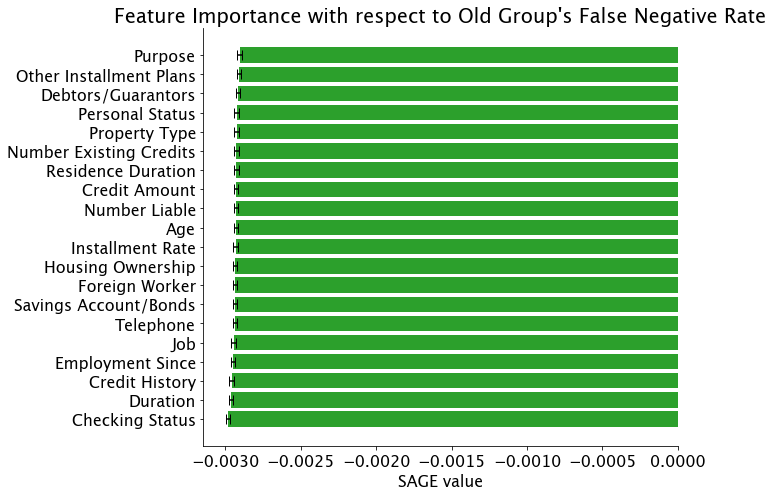

In [16]:
sage_values_old_fnr.plot(feature_names, title='Feature Importance with respect to Old Group\'s False Negative Rate')